## Dependancy Management

In [1]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

In [2]:
!pip install pytorch-metric-learning


[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
import scipy.io as sio
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import random_split, TensorDataset, DataLoader, Dataset
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import itertools
import random
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
import nbformat
from torchmetrics.image import PeakSignalNoiseRatio
from torch.amp import autocast, GradScaler
from pytorch_metric_learning.samplers import MPerClassSampler
import glob
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


## Data Processing Pipeline

Labels shape: (1096, 715)
Hypercube shape: (1096, 715, 102)


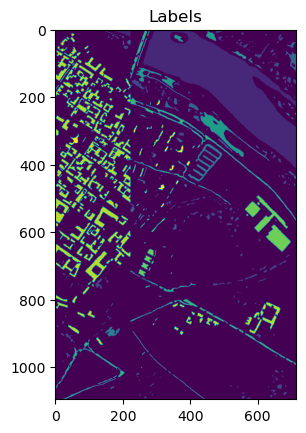

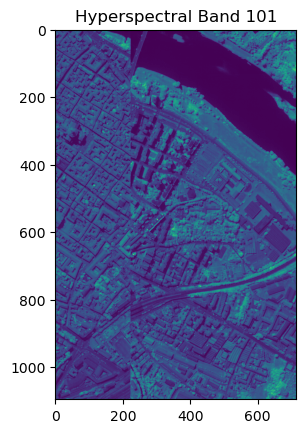

In [5]:
dataset_dir = r"C:\Users\vella\Documents\GitHub\FYP2425_LOCAL\FYP_DATASET"

gt_files = 'Pavia_gt.mat'
data_files = 'Pavia.mat'
label_files = 'pavia_gt'
hypercube_files = 'pavia'

def extract_Features():
    gt_file = os.path.join(dataset_dir, gt_files)
    data_file = os.path.join(dataset_dir, data_files)

    gt = sio.loadmat(gt_file)
    labels = gt[label_files]

    data = sio.loadmat(data_file)
    hypercube = data[hypercube_files]
    #scaling the data in place and setting to float32 to reduce memory usage
    max_value = np.max(hypercube)
    hypercube = (hypercube / max_value).astype(np.float32)


    #shapes of loaded data
    print(f"Labels shape: {labels.shape}")
    print(f"Hypercube shape: {hypercube.shape}")

    #visualisation of label map and a given band of hyperspectral data
    plt.figure()
    plt.imshow(labels)
    plt.title('Labels')

    band = 101
    plt.figure()
    plt.imshow(hypercube[:,:,band])
    plt.title(f'Hyperspectral Band {band}')
    plt.show()

    return hypercube, labels

hypercube, labels = extract_Features()

In [6]:
def extract_windows(data, labels, window_size):
    extract_windows_save_dir = 'extracted_windows_labels'
    if not os.path.exists(extract_windows_save_dir):
        os.makedirs(extract_windows_save_dir)
        print(f"Created directory: {extract_windows_save_dir}")

    margin = window_size // 2
    padded_data = np.pad(data, ((margin, margin), (margin, margin), (0, 0)), mode='constant')
    padded_labels = np.pad(labels, ((margin, margin), (margin, margin)), mode='constant')

    X_windows = []  #extracted windows
    y_labels = []   #corresponding labels

    print("Starting window extraction...")
    for i in range(margin, padded_data.shape[0] - margin):
        for j in range(margin, padded_data.shape[1] - margin):
            window = padded_data[i-margin:i+margin+1, j-margin:j+margin+1, :]
            label = padded_labels[i, j]

            if label != 0:
                #print('ignoring label 0 (background)')
                X_windows.append(window)
                y_labels.append(label)

    #convertying to numpy arrays
    X_windows = np.array(X_windows)
    y_labels = np.array(y_labels)

    #saving extracted windows and labels
    windows_file = os.path.join(extract_windows_save_dir, 'extracted_windows.npy')
    labels_file = os.path.join(extract_windows_save_dir, 'extracted_labels.npy')

    np.save(windows_file, X_windows)
    np.save(labels_file, y_labels)

    print(f"Saved extracted windows to: {windows_file}")
    print(f"Saved corresponding labels to: {labels_file}")
    print(f"\nTotal windows extracted: {len(X_windows)}")
    print(f"Extracted windows shape: {X_windows.shape}")
    print(f"Corresponding labels shape: {y_labels.shape}")

    return X_windows, y_labels

In [7]:
window_size = 5

X_windows, y_labels = extract_windows(hypercube, labels, window_size)

Created directory: extracted_windows_labels
Starting window extraction...


Saved extracted windows to: extracted_windows_labels\extracted_windows.npy
Saved corresponding labels to: extracted_windows_labels\extracted_labels.npy

Total windows extracted: 148152
Extracted windows shape: (148152, 5, 5, 102)
Corresponding labels shape: (148152,)


In [8]:
def get_samples(X_windows, y_labels, samples_per_class):
    
    indices_save_dir = 'indices'
    if not os.path.exists(indices_save_dir):
        os.makedirs(indices_save_dir)
        print(f"Created directory: {indices_save_dir}")
    
    #get unique classes
    classes = np.unique(y_labels)
    print(f"Unique classes found as: {classes}")

    #init lists
    X_sampled = [] #to store training samples
    y_sampled = [] #to store training labels

    X_val = [] # to store validation samples
    y_val = [] # to store validation labels

    selected_indices_total = [] #to store indices of selected training and validation samples
    validation_selected = [] #temp storage for validation indices
    validation_total = [] #to store all validation indices

    print("\n == STARTING SAMPLING PROCESS ==")
    for cls in classes:
        if cls == 0:
            print(f"!! SKIPPING CLASS 0 !!")
            continue

        #getting the indices for the current class:
        class_indices = np.where(y_labels == cls)[0]
        print(f"Class: {cls}: Found {len(class_indices)} samples")

        # shuffle class-specific indices to ensure randomness
        np.random.shuffle(class_indices)
        print(f"Shuffled class indices for class '{cls}'")

        #select 'samples_per_class' samples for training
        selected_indices = class_indices[:samples_per_class]
        #selecting 5 samples for validation
        validation_selected = class_indices[samples_per_class:samples_per_class+5]

        print(f"Selected {len(selected_indices)} training samples and {len(validation_selected)} validation samples for class '{cls}'\n")

        #store selected indices for training and validation
        selected_indices_total.extend(selected_indices)
        validation_total.extend(validation_selected)

        # appending the selected samples and their labels to the lists
        X_sampled.append(X_windows[selected_indices])
        y_sampled.append(y_labels[selected_indices])

        X_val.append(X_windows[validation_selected])
        y_val.append(y_labels[validation_selected])

    #concat the sampled arrays for training
    X_train = np.vstack(X_sampled)
    y_train = np.hstack(y_sampled)

    # shift labels to start from 0
    y_train = y_train - 1

    print(f"\n -- Training set created with: \n\t{X_train.shape[0]} samples\n\tshape {X_train.shape} --")

    #concat the sampled arrays for validation
    X_val = np.vstack(X_val)
    y_val = np.hstack(y_val)
    y_val = y_val - 1

    print(f"\n -- Validation set created with: \n\t{X_val.shape[0]} samples\n\tshape {X_val.shape} --")

    #create the test set from the remaining data (i.e. that which is not selected for training or validation)
    selected_indices_total.extend(validation_total)

    #getting indices not in the training or val sets
    test_indices = np.setdiff1d(np.arange(X_windows.shape[0]), selected_indices_total)
    X_test = X_windows[test_indices]
    y_test = y_labels[test_indices]
    y_test = y_test - 1

    print(f"\n -- Test set created with: \n\t{X_test.shape[0]} samples\n\tshape {X_test.shape} --\n")

    # Save the datasets to the 'datasets' folder
    np.save(os.path.join(indices_save_dir, 'X_train.npy'), X_train)
    np.save(os.path.join(indices_save_dir, 'y_train.npy'), y_train)
    np.save(os.path.join(indices_save_dir, 'X_val.npy'), X_val)
    np.save(os.path.join(indices_save_dir, 'y_val.npy'), y_val)
    np.save(os.path.join(indices_save_dir, 'X_test.npy'), X_test)
    np.save(os.path.join(indices_save_dir, 'y_test.npy'), y_test)

    print(f"\nAll datasets saved to the '{indices_save_dir}' folder.")

    #return the training, val, test sets + selected indices
    return X_train, X_test, y_train, y_test, X_val, y_val, selected_indices_total

In [9]:
X_train, X_test, y_train, y_test, X_val, y_val, selected_indices_total = get_samples(X_windows, y_labels, 20)
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

Created directory: indices
Unique classes found as: [1 2 3 4 5 6 7 8 9]

 == STARTING SAMPLING PROCESS ==
Class: 1: Found 65971 samples
Shuffled class indices for class '1'
Selected 20 training samples and 5 validation samples for class '1'

Class: 2: Found 7598 samples
Shuffled class indices for class '2'
Selected 20 training samples and 5 validation samples for class '2'

Class: 3: Found 3090 samples
Shuffled class indices for class '3'
Selected 20 training samples and 5 validation samples for class '3'

Class: 4: Found 2685 samples
Shuffled class indices for class '4'
Selected 20 training samples and 5 validation samples for class '4'

Class: 5: Found 6584 samples
Shuffled class indices for class '5'
Selected 20 training samples and 5 validation samples for class '5'

Class: 6: Found 9248 samples
Shuffled class indices for class '6'
Selected 20 training samples and 5 validation samples for class '6'

Class: 7: Found 7287 samples
Shuffled class indices for class '7'
Selected 20 train


 -- Test set created with: 
	147927 samples
	shape (147927, 5, 5, 102) --




All datasets saved to the 'indices' folder.
(180, 5, 5, 102)
(45, 5, 5, 102)
(147927, 5, 5, 102)


In [10]:
class HyperspectralDataset(Dataset):
    def __init__(self, X, y):
        """
        Args:
            X (numpy.ndarray): Hyperspectral data of shape (num_samples, height, width, num_bands).
            y (numpy.ndarray): Labels of shape (num_samples,).
        """
        #converting to pytorch tensor
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [11]:
#loading the saved datasets
X_train = np.load('indices/X_train.npy')
y_train = np.load('indices/y_train.npy')
X_val = np.load('indices/X_val.npy')
y_val = np.load('indices/y_val.npy')
X_test = np.load('indices/X_test.npy')
y_test = np.load('indices/y_test.npy')


#creating pytorch datasets
train_dataset = HyperspectralDataset(X_train, y_train)
val_dataset = HyperspectralDataset(X_val, y_val)
test_dataset = HyperspectralDataset(X_test, y_test)

m = 20
num_classes = len(np.unique(y_train))

#theoretical batch size calc
required_batch_size = m * num_classes  # 10 * 9 = 90

#ensuring batch size doesn't exceed training set size
if required_batch_size > len(train_dataset):
    #case 1: not enough samples - reduce m proportionally
    print("Case 1 applied")
    max_possible_m = len(train_dataset) // num_classes
    m = max(1, max_possible_m)
    batch_size_train = m * num_classes
else:
    #case 2: use full batch size
    print("Case 2 applied")
    batch_size_train = required_batch_size

sampler = MPerClassSampler(labels = y_train, m=m, batch_size = batch_size_train, length_before_new_iter = len(train_dataset))

#dataloaders
train_loader = DataLoader(train_dataset, batch_size = batch_size_train, sampler=sampler)

batch_size = 256
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print("DataLoaders created successfully!")

#class dist in first batch
for X_batch, y_batch in train_loader:
    unique, counts = np.unique(y_batch.numpy(), return_counts=True)
    print(f"Training batch size: {batch_size_train}")
    print("Class distribution in batch:", dict(zip(unique, counts)))
    break



Case 2 applied
DataLoaders created successfully!
Training batch size: 180
Class distribution in batch: {0: 20, 1: 20, 2: 20, 3: 20, 4: 20, 5: 20, 6: 20, 7: 20, 8: 20}


## Creating directory for saving model predictions

In [12]:
predictions_dir = 'model_predictions'
os.makedirs(predictions_dir, exist_ok=True)
print(f"Created dir: {predictions_dir}")

Created dir: model_predictions


## Creating the Dataset splits and Dataloaders for unsupervised tasks

In [13]:
X_train, X_val = train_test_split(X_windows, test_size=0.2, random_state=42)

print(f"Training data shape: {X_train.shape}")
print(f"Validation data shape: {X_val.shape}")

Training data shape: (118521, 5, 5, 102)
Validation data shape: (29631, 5, 5, 102)


In [14]:
class UnsupervisedDataset(Dataset):
    def __init__(self, data):
        self.data = torch.tensor(data, dtype=torch.float32)  #converting to pytorch tensor

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

In [15]:
#creating datasets for unsupervised task
unsup_train_dataset = UnsupervisedDataset(X_train)
unsup_val_dataset = UnsupervisedDataset(X_val)

#dataloaders for unsupervised task
batch_size = 64
train_loader_cae = DataLoader(unsup_train_dataset, batch_size=batch_size, shuffle=True)
val_loader_cae = DataLoader(unsup_val_dataset, batch_size=batch_size, shuffle=False)

print("DataLoaders created successfully!")

DataLoaders created successfully!


In [16]:
window_num_channels = X_windows.shape[3]
print(window_num_channels)

102


## Convolutional Autoencoder

In [17]:
class ConvAutoEncode(nn.Module):
    def __init__(self, dropout_prob=0.1):
        super(ConvAutoEncode, self).__init__()

        #encoder
        self.encoder = nn.Sequential(
            #Block 1
            nn.Conv2d(window_num_channels, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Dropout(dropout_prob),

            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # 5x5 -> 2x2

            #Block 2
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Dropout(dropout_prob),

            #Bottleneck
            nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.MaxPool2d(2, 2)  # 2x2 -> 1x1
        )

        #decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 128, kernel_size=2, stride=2),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Dropout(dropout_prob),

            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.ConvTranspose2d(64, 64, kernel_size=2, stride=2, output_padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Dropout(dropout_prob),

            nn.ConvTranspose2d(64, window_num_channels, kernel_size=3, stride=1, padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded


LOG: Epoch [1/50]


	 Training Batch [1/1852], Loss: 0.1629, PSNR: 7.8806


	 Training Batch [200/1852], Loss: 0.0909, PSNR: 7.4684


	 Training Batch [400/1852], Loss: 0.0520, PSNR: 9.4418


	 Training Batch [600/1852], Loss: 0.0252, PSNR: 12.8799


	 Training Batch [800/1852], Loss: 0.0161, PSNR: 12.6868


	 Training Batch [1000/1852], Loss: 0.0135, PSNR: 15.6840


	 Training Batch [1200/1852], Loss: 0.0092, PSNR: 17.3234


	 Training Batch [1400/1852], Loss: 0.0091, PSNR: 17.4123


	 Training Batch [1600/1852], Loss: 0.0084, PSNR: 18.7777


	 Training Batch [1800/1852], Loss: 0.0075, PSNR: 17.5752


Epoch [1/50] Training Loss: 0.0327, PSNR: 13.5954
	[Val]   Batch [1/463] Loss: 0.0055, PSNR: 17.8594
	[Val]   Batch [10/463] Loss: 0.0051, PSNR: 19.0157
	[Val]   Batch [20/463] Loss: 0.0051, PSNR: 18.0247
	[Val]   Batch [30/463] Loss: 0.0062, PSNR: 18.5932
	[Val]   Batch [40/463] Loss: 0.0049, PSNR: 17.7049
	[Val]   Batch [50/463] Loss: 0.0051, PSNR: 17.9234


	[Val]   Batch [60/463] Loss: 0.0049, PSNR: 17.9571
	[Val]   Batch [70/463] Loss: 0.0069, PSNR: 18.3255
	[Val]   Batch [80/463] Loss: 0.0061, PSNR: 20.2389
	[Val]   Batch [90/463] Loss: 0.0059, PSNR: 19.3183
	[Val]   Batch [100/463] Loss: 0.0060, PSNR: 19.0401
	[Val]   Batch [110/463] Loss: 0.0070, PSNR: 18.4579
	[Val]   Batch [120/463] Loss: 0.0047, PSNR: 17.9580


	[Val]   Batch [130/463] Loss: 0.0056, PSNR: 19.3466
	[Val]   Batch [140/463] Loss: 0.0065, PSNR: 18.8958
	[Val]   Batch [150/463] Loss: 0.0074, PSNR: 18.9332
	[Val]   Batch [160/463] Loss: 0.0060, PSNR: 19.1631
	[Val]   Batch [170/463] Loss: 0.0076, PSNR: 18.1478
	[Val]   Batch [180/463] Loss: 0.0056, PSNR: 18.9192


	[Val]   Batch [190/463] Loss: 0.0060, PSNR: 19.2581
	[Val]   Batch [200/463] Loss: 0.0061, PSNR: 18.6369
	[Val]   Batch [210/463] Loss: 0.0059, PSNR: 18.2255
	[Val]   Batch [220/463] Loss: 0.0058, PSNR: 19.4382
	[Val]   Batch [230/463] Loss: 0.0069, PSNR: 19.2880
	[Val]   Batch [240/463] Loss: 0.0052, PSNR: 18.0812


	[Val]   Batch [250/463] Loss: 0.0067, PSNR: 17.2664
	[Val]   Batch [260/463] Loss: 0.0058, PSNR: 18.2682
	[Val]   Batch [270/463] Loss: 0.0044, PSNR: 17.4656
	[Val]   Batch [280/463] Loss: 0.0055, PSNR: 20.1687
	[Val]   Batch [290/463] Loss: 0.0060, PSNR: 17.1891
	[Val]   Batch [300/463] Loss: 0.0061, PSNR: 19.4187


	[Val]   Batch [310/463] Loss: 0.0056, PSNR: 19.3123
	[Val]   Batch [320/463] Loss: 0.0057, PSNR: 19.1797
	[Val]   Batch [330/463] Loss: 0.0066, PSNR: 18.5880
	[Val]   Batch [340/463] Loss: 0.0054, PSNR: 19.5309
	[Val]   Batch [350/463] Loss: 0.0071, PSNR: 19.4377
	[Val]   Batch [360/463] Loss: 0.0048, PSNR: 20.3911
	[Val]   Batch [370/463] Loss: 0.0070, PSNR: 18.5131


	[Val]   Batch [380/463] Loss: 0.0069, PSNR: 18.6657
	[Val]   Batch [390/463] Loss: 0.0063, PSNR: 18.4835
	[Val]   Batch [400/463] Loss: 0.0055, PSNR: 17.5394
	[Val]   Batch [410/463] Loss: 0.0054, PSNR: 19.8540
	[Val]   Batch [420/463] Loss: 0.0056, PSNR: 18.6318
	[Val]   Batch [430/463] Loss: 0.0055, PSNR: 18.0636
	[Val]   Batch [440/463] Loss: 0.0054, PSNR: 19.0666


	[Val]   Batch [450/463] Loss: 0.0042, PSNR: 16.4149
	[Val]   Batch [460/463] Loss: 0.0059, PSNR: 17.7989
Epoch [1/50] Validation Loss: 0.0058, PSNR: 18.6196

LOG: Epoch [2/50]
	 Training Batch [1/1852], Loss: 0.0049, PSNR: 16.4048


	 Training Batch [200/1852], Loss: 0.0048, PSNR: 20.3171


	 Training Batch [400/1852], Loss: 0.0049, PSNR: 18.1735


	 Training Batch [600/1852], Loss: 0.0048, PSNR: 20.0567


	 Training Batch [800/1852], Loss: 0.0034, PSNR: 18.7234


	 Training Batch [1000/1852], Loss: 0.0046, PSNR: 19.6374


	 Training Batch [1200/1852], Loss: 0.0032, PSNR: 20.7875


	 Training Batch [1400/1852], Loss: 0.0041, PSNR: 20.5890


	 Training Batch [1600/1852], Loss: 0.0048, PSNR: 20.1252


	 Training Batch [1800/1852], Loss: 0.0037, PSNR: 19.8695


Epoch [2/50] Training Loss: 0.0046, PSNR: 19.8449
	[Val]   Batch [1/463] Loss: 0.0028, PSNR: 20.7816
	[Val]   Batch [10/463] Loss: 0.0026, PSNR: 21.9855
	[Val]   Batch [20/463] Loss: 0.0025, PSNR: 21.0924
	[Val]   Batch [30/463] Loss: 0.0033, PSNR: 21.3434
	[Val]   Batch [40/463] Loss: 0.0025, PSNR: 20.6578
	[Val]   Batch [50/463] Loss: 0.0026, PSNR: 20.8351


	[Val]   Batch [60/463] Loss: 0.0025, PSNR: 20.9327
	[Val]   Batch [70/463] Loss: 0.0038, PSNR: 20.9550
	[Val]   Batch [80/463] Loss: 0.0034, PSNR: 22.8622
	[Val]   Batch [90/463] Loss: 0.0031, PSNR: 22.2051
	[Val]   Batch [100/463] Loss: 0.0033, PSNR: 21.5963
	[Val]   Batch [110/463] Loss: 0.0038, PSNR: 21.1290
	[Val]   Batch [120/463] Loss: 0.0024, PSNR: 20.9207
	[Val]   Batch [130/463] Loss: 0.0029, PSNR: 22.2571


	[Val]   Batch [140/463] Loss: 0.0035, PSNR: 21.6103
	[Val]   Batch [150/463] Loss: 0.0040, PSNR: 21.6617
	[Val]   Batch [160/463] Loss: 0.0033, PSNR: 21.7364
	[Val]   Batch [170/463] Loss: 0.0042, PSNR: 20.7167
	[Val]   Batch [180/463] Loss: 0.0031, PSNR: 21.4209
	[Val]   Batch [190/463] Loss: 0.0032, PSNR: 22.0924
	[Val]   Batch [200/463] Loss: 0.0032, PSNR: 21.3878


	[Val]   Batch [210/463] Loss: 0.0033, PSNR: 20.7282
	[Val]   Batch [220/463] Loss: 0.0031, PSNR: 22.1128
	[Val]   Batch [230/463] Loss: 0.0036, PSNR: 22.0918
	[Val]   Batch [240/463] Loss: 0.0027, PSNR: 20.9369
	[Val]   Batch [250/463] Loss: 0.0036, PSNR: 19.9369
	[Val]   Batch [260/463] Loss: 0.0031, PSNR: 20.9906
	[Val]   Batch [270/463] Loss: 0.0022, PSNR: 20.5903


	[Val]   Batch [280/463] Loss: 0.0028, PSNR: 23.0150
	[Val]   Batch [290/463] Loss: 0.0031, PSNR: 20.0601
	[Val]   Batch [300/463] Loss: 0.0032, PSNR: 22.2179
	[Val]   Batch [310/463] Loss: 0.0031, PSNR: 21.8670
	[Val]   Batch [320/463] Loss: 0.0030, PSNR: 21.9284
	[Val]   Batch [330/463] Loss: 0.0034, PSNR: 21.4721


	[Val]   Batch [340/463] Loss: 0.0029, PSNR: 22.3124
	[Val]   Batch [350/463] Loss: 0.0040, PSNR: 21.9113
	[Val]   Batch [360/463] Loss: 0.0026, PSNR: 23.0023
	[Val]   Batch [370/463] Loss: 0.0037, PSNR: 21.3159
	[Val]   Batch [380/463] Loss: 0.0035, PSNR: 21.6262
	[Val]   Batch [390/463] Loss: 0.0033, PSNR: 21.3651
	[Val]   Batch [400/463] Loss: 0.0030, PSNR: 20.2486


	[Val]   Batch [410/463] Loss: 0.0027, PSNR: 22.8582
	[Val]   Batch [420/463] Loss: 0.0029, PSNR: 21.5335
	[Val]   Batch [430/463] Loss: 0.0030, PSNR: 20.7427
	[Val]   Batch [440/463] Loss: 0.0029, PSNR: 21.7555
	[Val]   Batch [450/463] Loss: 0.0021, PSNR: 19.3629
	[Val]   Batch [460/463] Loss: 0.0030, PSNR: 20.7151
Epoch [2/50] Validation Loss: 0.0031, PSNR: 21.4263

LOG: Epoch [3/50]
	 Training Batch [1/1852], Loss: 0.0030, PSNR: 21.3991


	 Training Batch [200/1852], Loss: 0.0034, PSNR: 20.8492


	 Training Batch [400/1852], Loss: 0.0027, PSNR: 21.8473


	 Training Batch [600/1852], Loss: 0.0042, PSNR: 20.7954


	 Training Batch [800/1852], Loss: 0.0031, PSNR: 22.3623


	 Training Batch [1000/1852], Loss: 0.0023, PSNR: 21.8318


	 Training Batch [1200/1852], Loss: 0.0021, PSNR: 21.6478


	 Training Batch [1400/1852], Loss: 0.0017, PSNR: 22.9250


	 Training Batch [1600/1852], Loss: 0.0024, PSNR: 24.0452


	 Training Batch [1800/1852], Loss: 0.0017, PSNR: 23.3475


Epoch [3/50] Training Loss: 0.0025, PSNR: 22.4657
	[Val]   Batch [1/463] Loss: 0.0016, PSNR: 23.3048
	[Val]   Batch [10/463] Loss: 0.0014, PSNR: 24.4909
	[Val]   Batch [20/463] Loss: 0.0014, PSNR: 23.6698
	[Val]   Batch [30/463] Loss: 0.0017, PSNR: 24.2472
	[Val]   Batch [40/463] Loss: 0.0015, PSNR: 22.7739
	[Val]   Batch [50/463] Loss: 0.0015, PSNR: 23.1320
	[Val]   Batch [60/463] Loss: 0.0015, PSNR: 23.1667


	[Val]   Batch [70/463] Loss: 0.0019, PSNR: 23.8498
	[Val]   Batch [80/463] Loss: 0.0017, PSNR: 25.7118
	[Val]   Batch [90/463] Loss: 0.0017, PSNR: 24.7992
	[Val]   Batch [100/463] Loss: 0.0018, PSNR: 24.3556
	[Val]   Batch [110/463] Loss: 0.0019, PSNR: 24.0870
	[Val]   Batch [120/463] Loss: 0.0015, PSNR: 23.0585
	[Val]   Batch [130/463] Loss: 0.0015, PSNR: 25.1708
	[Val]   Batch [140/463] Loss: 0.0019, PSNR: 24.3708


	[Val]   Batch [150/463] Loss: 0.0019, PSNR: 24.9241
	[Val]   Batch [160/463] Loss: 0.0020, PSNR: 23.9997
	[Val]   Batch [170/463] Loss: 0.0023, PSNR: 23.4159
	[Val]   Batch [180/463] Loss: 0.0018, PSNR: 23.8377
	[Val]   Batch [190/463] Loss: 0.0017, PSNR: 24.8626
	[Val]   Batch [200/463] Loss: 0.0017, PSNR: 24.2451
	[Val]   Batch [210/463] Loss: 0.0020, PSNR: 23.0037


	[Val]   Batch [220/463] Loss: 0.0018, PSNR: 24.5475
	[Val]   Batch [230/463] Loss: 0.0016, PSNR: 25.5172
	[Val]   Batch [240/463] Loss: 0.0015, PSNR: 23.4252
	[Val]   Batch [250/463] Loss: 0.0021, PSNR: 22.3891
	[Val]   Batch [260/463] Loss: 0.0018, PSNR: 23.3936
	[Val]   Batch [270/463] Loss: 0.0013, PSNR: 22.6924
	[Val]   Batch [280/463] Loss: 0.0016, PSNR: 25.4886
	[Val]   Batch [290/463] Loss: 0.0017, PSNR: 22.6608


	[Val]   Batch [300/463] Loss: 0.0018, PSNR: 24.6257
	[Val]   Batch [310/463] Loss: 0.0019, PSNR: 24.0115
	[Val]   Batch [320/463] Loss: 0.0017, PSNR: 24.4718
	[Val]   Batch [330/463] Loss: 0.0017, PSNR: 24.4480
	[Val]   Batch [340/463] Loss: 0.0016, PSNR: 24.7971
	[Val]   Batch [350/463] Loss: 0.0022, PSNR: 24.5975
	[Val]   Batch [360/463] Loss: 0.0018, PSNR: 24.6471
	[Val]   Batch [370/463] Loss: 0.0019, PSNR: 24.2679


	[Val]   Batch [380/463] Loss: 0.0016, PSNR: 24.8953
	[Val]   Batch [390/463] Loss: 0.0016, PSNR: 24.4249
	[Val]   Batch [400/463] Loss: 0.0018, PSNR: 22.4932
	[Val]   Batch [410/463] Loss: 0.0015, PSNR: 25.4030
	[Val]   Batch [420/463] Loss: 0.0016, PSNR: 24.1705
	[Val]   Batch [430/463] Loss: 0.0018, PSNR: 22.9112
	[Val]   Batch [440/463] Loss: 0.0017, PSNR: 24.1254
	[Val]   Batch [450/463] Loss: 0.0014, PSNR: 21.1395


	[Val]   Batch [460/463] Loss: 0.0017, PSNR: 23.2135
Epoch [3/50] Validation Loss: 0.0017, PSNR: 24.0237

LOG: Epoch [4/50]
	 Training Batch [1/1852], Loss: 0.0019, PSNR: 23.0433


	 Training Batch [200/1852], Loss: 0.0018, PSNR: 23.8151


	 Training Batch [400/1852], Loss: 0.0015, PSNR: 22.4986


	 Training Batch [600/1852], Loss: 0.0017, PSNR: 24.3559


	 Training Batch [800/1852], Loss: 0.0019, PSNR: 25.3251


	 Training Batch [1000/1852], Loss: 0.0015, PSNR: 25.0137


	 Training Batch [1200/1852], Loss: 0.0017, PSNR: 23.0510


	 Training Batch [1400/1852], Loss: 0.0014, PSNR: 25.0321


	 Training Batch [1600/1852], Loss: 0.0013, PSNR: 25.6647


	 Training Batch [1800/1852], Loss: 0.0012, PSNR: 26.2086


Epoch [4/50] Training Loss: 0.0017, PSNR: 24.2138
	[Val]   Batch [1/463] Loss: 0.0011, PSNR: 24.6636
	[Val]   Batch [10/463] Loss: 0.0010, PSNR: 25.9693
	[Val]   Batch [20/463] Loss: 0.0010, PSNR: 25.2012
	[Val]   Batch [30/463] Loss: 0.0012, PSNR: 25.6388
	[Val]   Batch [40/463] Loss: 0.0011, PSNR: 24.1373
	[Val]   Batch [50/463] Loss: 0.0011, PSNR: 24.5531


	[Val]   Batch [60/463] Loss: 0.0011, PSNR: 24.5089
	[Val]   Batch [70/463] Loss: 0.0014, PSNR: 25.2984
	[Val]   Batch [80/463] Loss: 0.0012, PSNR: 27.3635
	[Val]   Batch [90/463] Loss: 0.0012, PSNR: 26.2829
	[Val]   Batch [100/463] Loss: 0.0013, PSNR: 25.7836
	[Val]   Batch [110/463] Loss: 0.0013, PSNR: 25.6277
	[Val]   Batch [120/463] Loss: 0.0010, PSNR: 24.5021
	[Val]   Batch [130/463] Loss: 0.0010, PSNR: 26.6620


	[Val]   Batch [140/463] Loss: 0.0013, PSNR: 25.8039
	[Val]   Batch [150/463] Loss: 0.0013, PSNR: 26.5566
	[Val]   Batch [160/463] Loss: 0.0014, PSNR: 25.3353
	[Val]   Batch [170/463] Loss: 0.0017, PSNR: 24.7293
	[Val]   Batch [180/463] Loss: 0.0013, PSNR: 25.1920
	[Val]   Batch [190/463] Loss: 0.0012, PSNR: 26.3347
	[Val]   Batch [200/463] Loss: 0.0011, PSNR: 25.9056


	[Val]   Batch [210/463] Loss: 0.0015, PSNR: 24.3006
	[Val]   Batch [220/463] Loss: 0.0013, PSNR: 25.8709
	[Val]   Batch [230/463] Loss: 0.0011, PSNR: 27.1882
	[Val]   Batch [240/463] Loss: 0.0011, PSNR: 24.8863
	[Val]   Batch [250/463] Loss: 0.0015, PSNR: 23.6998
	[Val]   Batch [260/463] Loss: 0.0013, PSNR: 24.6602
	[Val]   Batch [270/463] Loss: 0.0009, PSNR: 24.2371
	[Val]   Batch [280/463] Loss: 0.0012, PSNR: 26.9144


	[Val]   Batch [290/463] Loss: 0.0012, PSNR: 24.0911
	[Val]   Batch [300/463] Loss: 0.0013, PSNR: 25.9824
	[Val]   Batch [310/463] Loss: 0.0014, PSNR: 25.4029
	[Val]   Batch [320/463] Loss: 0.0012, PSNR: 25.9613
	[Val]   Batch [330/463] Loss: 0.0012, PSNR: 26.0216
	[Val]   Batch [340/463] Loss: 0.0011, PSNR: 26.2615
	[Val]   Batch [350/463] Loss: 0.0016, PSNR: 25.9718


	[Val]   Batch [360/463] Loss: 0.0014, PSNR: 25.7177
	[Val]   Batch [370/463] Loss: 0.0013, PSNR: 25.7275
	[Val]   Batch [380/463] Loss: 0.0011, PSNR: 26.5972
	[Val]   Batch [390/463] Loss: 0.0011, PSNR: 26.0583
	[Val]   Batch [400/463] Loss: 0.0013, PSNR: 23.7539
	[Val]   Batch [410/463] Loss: 0.0011, PSNR: 26.9401
	[Val]   Batch [420/463] Loss: 0.0011, PSNR: 25.6104


	[Val]   Batch [430/463] Loss: 0.0014, PSNR: 24.1708
	[Val]   Batch [440/463] Loss: 0.0012, PSNR: 25.4673
	[Val]   Batch [450/463] Loss: 0.0010, PSNR: 22.5012
	[Val]   Batch [460/463] Loss: 0.0012, PSNR: 24.6532
Epoch [4/50] Validation Loss: 0.0012, PSNR: 25.4869

LOG: Epoch [5/50]
	 Training Batch [1/1852], Loss: 0.0017, PSNR: 24.3544


	 Training Batch [200/1852], Loss: 0.0014, PSNR: 26.2153


	 Training Batch [400/1852], Loss: 0.0014, PSNR: 25.8332


	 Training Batch [600/1852], Loss: 0.0015, PSNR: 23.7210


	 Training Batch [800/1852], Loss: 0.0011, PSNR: 26.6719


	 Training Batch [1000/1852], Loss: 0.0013, PSNR: 25.3880


	 Training Batch [1200/1852], Loss: 0.0012, PSNR: 24.8342


	 Training Batch [1400/1852], Loss: 0.0011, PSNR: 26.0394


	 Training Batch [1600/1852], Loss: 0.0010, PSNR: 25.7451


	 Training Batch [1800/1852], Loss: 0.0011, PSNR: 25.3083


Epoch [5/50] Training Loss: 0.0013, PSNR: 25.2780
	[Val]   Batch [1/463] Loss: 0.0009, PSNR: 25.6932
	[Val]   Batch [10/463] Loss: 0.0008, PSNR: 27.0016
	[Val]   Batch [20/463] Loss: 0.0008, PSNR: 26.2141
	[Val]   Batch [30/463] Loss: 0.0010, PSNR: 26.6808
	[Val]   Batch [40/463] Loss: 0.0009, PSNR: 25.0478
	[Val]   Batch [50/463] Loss: 0.0009, PSNR: 25.5295
	[Val]   Batch [60/463] Loss: 0.0009, PSNR: 25.4926


	[Val]   Batch [70/463] Loss: 0.0011, PSNR: 26.3101
	[Val]   Batch [80/463] Loss: 0.0009, PSNR: 28.5915
	[Val]   Batch [90/463] Loss: 0.0009, PSNR: 27.3661
	[Val]   Batch [100/463] Loss: 0.0010, PSNR: 26.9016
	[Val]   Batch [110/463] Loss: 0.0010, PSNR: 26.7320
	[Val]   Batch [120/463] Loss: 0.0008, PSNR: 25.4903


	[Val]   Batch [130/463] Loss: 0.0008, PSNR: 27.7153
	[Val]   Batch [140/463] Loss: 0.0010, PSNR: 26.8562
	[Val]   Batch [150/463] Loss: 0.0010, PSNR: 27.6273
	[Val]   Batch [160/463] Loss: 0.0012, PSNR: 26.2605
	[Val]   Batch [170/463] Loss: 0.0013, PSNR: 25.7071
	[Val]   Batch [180/463] Loss: 0.0010, PSNR: 26.1979
	[Val]   Batch [190/463] Loss: 0.0009, PSNR: 27.3351
	[Val]   Batch [200/463] Loss: 0.0009, PSNR: 26.9812


	[Val]   Batch [210/463] Loss: 0.0012, PSNR: 25.2605
	[Val]   Batch [220/463] Loss: 0.0011, PSNR: 26.8688
	[Val]   Batch [230/463] Loss: 0.0008, PSNR: 28.3612
	[Val]   Batch [240/463] Loss: 0.0008, PSNR: 25.9725
	[Val]   Batch [250/463] Loss: 0.0012, PSNR: 24.6285
	[Val]   Batch [260/463] Loss: 0.0011, PSNR: 25.5258
	[Val]   Batch [270/463] Loss: 0.0007, PSNR: 25.2870


	[Val]   Batch [280/463] Loss: 0.0009, PSNR: 27.9496
	[Val]   Batch [290/463] Loss: 0.0010, PSNR: 25.1759
	[Val]   Batch [300/463] Loss: 0.0011, PSNR: 26.8517
	[Val]   Batch [310/463] Loss: 0.0011, PSNR: 26.3759
	[Val]   Batch [320/463] Loss: 0.0009, PSNR: 27.0814
	[Val]   Batch [330/463] Loss: 0.0009, PSNR: 27.0894
	[Val]   Batch [340/463] Loss: 0.0009, PSNR: 27.3277


	[Val]   Batch [350/463] Loss: 0.0013, PSNR: 26.9805
	[Val]   Batch [360/463] Loss: 0.0012, PSNR: 26.4434
	[Val]   Batch [370/463] Loss: 0.0010, PSNR: 26.8500
	[Val]   Batch [380/463] Loss: 0.0009, PSNR: 27.7210
	[Val]   Batch [390/463] Loss: 0.0009, PSNR: 27.1790
	[Val]   Batch [400/463] Loss: 0.0011, PSNR: 24.7410
	[Val]   Batch [410/463] Loss: 0.0008, PSNR: 27.9738
	[Val]   Batch [420/463] Loss: 0.0009, PSNR: 26.6054


	[Val]   Batch [430/463] Loss: 0.0011, PSNR: 25.0897
	[Val]   Batch [440/463] Loss: 0.0010, PSNR: 26.4702
	[Val]   Batch [450/463] Loss: 0.0008, PSNR: 23.4943
	[Val]   Batch [460/463] Loss: 0.0010, PSNR: 25.6079
Epoch [5/50] Validation Loss: 0.0009, PSNR: 26.5212

LOG: Epoch [6/50]
	 Training Batch [1/1852], Loss: 0.0011, PSNR: 24.4781


	 Training Batch [200/1852], Loss: 0.0013, PSNR: 23.9905


	 Training Batch [400/1852], Loss: 0.0011, PSNR: 26.6448


	 Training Batch [600/1852], Loss: 0.0015, PSNR: 24.2779


	 Training Batch [800/1852], Loss: 0.0010, PSNR: 28.5680


	 Training Batch [1000/1852], Loss: 0.0010, PSNR: 25.6680


	 Training Batch [1200/1852], Loss: 0.0011, PSNR: 25.6956


	 Training Batch [1400/1852], Loss: 0.0011, PSNR: 27.3683


	 Training Batch [1600/1852], Loss: 0.0009, PSNR: 25.9462


	 Training Batch [1800/1852], Loss: 0.0013, PSNR: 25.6777


Epoch [6/50] Training Loss: 0.0011, PSNR: 26.1256
	[Val]   Batch [1/463] Loss: 0.0007, PSNR: 26.6260
	[Val]   Batch [10/463] Loss: 0.0006, PSNR: 28.0254
	[Val]   Batch [20/463] Loss: 0.0006, PSNR: 27.2688
	[Val]   Batch [30/463] Loss: 0.0008, PSNR: 27.6178
	[Val]   Batch [40/463] Loss: 0.0007, PSNR: 26.0006
	[Val]   Batch [50/463] Loss: 0.0007, PSNR: 26.5827
	[Val]   Batch [60/463] Loss: 0.0007, PSNR: 26.4136


	[Val]   Batch [70/463] Loss: 0.0009, PSNR: 27.2417
	[Val]   Batch [80/463] Loss: 0.0007, PSNR: 29.7667
	[Val]   Batch [90/463] Loss: 0.0007, PSNR: 28.3920
	[Val]   Batch [100/463] Loss: 0.0008, PSNR: 27.8804
	[Val]   Batch [110/463] Loss: 0.0008, PSNR: 27.7380
	[Val]   Batch [120/463] Loss: 0.0007, PSNR: 26.5049
	[Val]   Batch [130/463] Loss: 0.0007, PSNR: 28.6684
	[Val]   Batch [140/463] Loss: 0.0008, PSNR: 27.8357


	[Val]   Batch [150/463] Loss: 0.0008, PSNR: 28.6474
	[Val]   Batch [160/463] Loss: 0.0009, PSNR: 27.1701
	[Val]   Batch [170/463] Loss: 0.0011, PSNR: 26.5470
	[Val]   Batch [180/463] Loss: 0.0008, PSNR: 27.2340
	[Val]   Batch [190/463] Loss: 0.0007, PSNR: 28.3261
	[Val]   Batch [200/463] Loss: 0.0007, PSNR: 28.1138
	[Val]   Batch [210/463] Loss: 0.0009, PSNR: 26.1812


	[Val]   Batch [220/463] Loss: 0.0009, PSNR: 27.7763
	[Val]   Batch [230/463] Loss: 0.0007, PSNR: 29.3920
	[Val]   Batch [240/463] Loss: 0.0007, PSNR: 27.0119
	[Val]   Batch [250/463] Loss: 0.0010, PSNR: 25.5529
	[Val]   Batch [260/463] Loss: 0.0009, PSNR: 26.3766
	[Val]   Batch [270/463] Loss: 0.0006, PSNR: 26.4198
	[Val]   Batch [280/463] Loss: 0.0007, PSNR: 28.9314
	[Val]   Batch [290/463] Loss: 0.0008, PSNR: 26.1852


	[Val]   Batch [300/463] Loss: 0.0009, PSNR: 27.6993
	[Val]   Batch [310/463] Loss: 0.0009, PSNR: 27.3495
	[Val]   Batch [320/463] Loss: 0.0007, PSNR: 28.1697
	[Val]   Batch [330/463] Loss: 0.0007, PSNR: 28.1216
	[Val]   Batch [340/463] Loss: 0.0007, PSNR: 28.3445
	[Val]   Batch [350/463] Loss: 0.0010, PSNR: 27.8942
	[Val]   Batch [360/463] Loss: 0.0010, PSNR: 27.1370


	[Val]   Batch [370/463] Loss: 0.0008, PSNR: 27.8522
	[Val]   Batch [380/463] Loss: 0.0007, PSNR: 28.8454
	[Val]   Batch [390/463] Loss: 0.0007, PSNR: 28.2380
	[Val]   Batch [400/463] Loss: 0.0009, PSNR: 25.6295
	[Val]   Batch [410/463] Loss: 0.0007, PSNR: 28.9612
	[Val]   Batch [420/463] Loss: 0.0007, PSNR: 27.5925
	[Val]   Batch [430/463] Loss: 0.0009, PSNR: 26.0004


	[Val]   Batch [440/463] Loss: 0.0008, PSNR: 27.3684
	[Val]   Batch [450/463] Loss: 0.0007, PSNR: 24.5127
	[Val]   Batch [460/463] Loss: 0.0008, PSNR: 26.5241
Epoch [6/50] Validation Loss: 0.0008, PSNR: 27.5186

LOG: Epoch [7/50]
	 Training Batch [1/1852], Loss: 0.0009, PSNR: 25.9906


	 Training Batch [200/1852], Loss: 0.0010, PSNR: 26.6780


	 Training Batch [400/1852], Loss: 0.0009, PSNR: 27.3517


	 Training Batch [600/1852], Loss: 0.0009, PSNR: 26.9343


	 Training Batch [800/1852], Loss: 0.0008, PSNR: 27.0913


	 Training Batch [1000/1852], Loss: 0.0007, PSNR: 26.2855


	 Training Batch [1200/1852], Loss: 0.0008, PSNR: 26.5462


	 Training Batch [1400/1852], Loss: 0.0008, PSNR: 26.2834


	 Training Batch [1600/1852], Loss: 0.0008, PSNR: 26.1468


	 Training Batch [1800/1852], Loss: 0.0008, PSNR: 24.4007


Epoch [7/50] Training Loss: 0.0009, PSNR: 26.8054
	[Val]   Batch [1/463] Loss: 0.0006, PSNR: 27.3728
	[Val]   Batch [10/463] Loss: 0.0005, PSNR: 28.8604
	[Val]   Batch [20/463] Loss: 0.0005, PSNR: 28.1013
	[Val]   Batch [30/463] Loss: 0.0006, PSNR: 28.3823
	[Val]   Batch [40/463] Loss: 0.0006, PSNR: 26.7876
	[Val]   Batch [50/463] Loss: 0.0006, PSNR: 27.4614
	[Val]   Batch [60/463] Loss: 0.0006, PSNR: 27.1928


	[Val]   Batch [70/463] Loss: 0.0007, PSNR: 27.9656
	[Val]   Batch [80/463] Loss: 0.0006, PSNR: 30.6734
	[Val]   Batch [90/463] Loss: 0.0006, PSNR: 29.1873
	[Val]   Batch [100/463] Loss: 0.0007, PSNR: 28.6634
	[Val]   Batch [110/463] Loss: 0.0007, PSNR: 28.5347
	[Val]   Batch [120/463] Loss: 0.0005, PSNR: 27.3391
	[Val]   Batch [130/463] Loss: 0.0005, PSNR: 29.4271


	[Val]   Batch [140/463] Loss: 0.0007, PSNR: 28.6491
	[Val]   Batch [150/463] Loss: 0.0007, PSNR: 29.4882
	[Val]   Batch [160/463] Loss: 0.0008, PSNR: 27.9152
	[Val]   Batch [170/463] Loss: 0.0009, PSNR: 27.2249
	[Val]   Batch [180/463] Loss: 0.0007, PSNR: 28.0054
	[Val]   Batch [190/463] Loss: 0.0006, PSNR: 29.1136
	[Val]   Batch [200/463] Loss: 0.0006, PSNR: 28.9851


	[Val]   Batch [210/463] Loss: 0.0008, PSNR: 26.9832
	[Val]   Batch [220/463] Loss: 0.0007, PSNR: 28.5814
	[Val]   Batch [230/463] Loss: 0.0006, PSNR: 30.1460
	[Val]   Batch [240/463] Loss: 0.0005, PSNR: 27.8300
	[Val]   Batch [250/463] Loss: 0.0008, PSNR: 26.3391
	[Val]   Batch [260/463] Loss: 0.0008, PSNR: 27.1482
	[Val]   Batch [270/463] Loss: 0.0004, PSNR: 27.4146


	[Val]   Batch [280/463] Loss: 0.0006, PSNR: 29.8195
	[Val]   Batch [290/463] Loss: 0.0006, PSNR: 26.9691
	[Val]   Batch [300/463] Loss: 0.0008, PSNR: 28.4285
	[Val]   Batch [310/463] Loss: 0.0007, PSNR: 28.1567
	[Val]   Batch [320/463] Loss: 0.0006, PSNR: 29.0430
	[Val]   Batch [330/463] Loss: 0.0006, PSNR: 28.9013


	[Val]   Batch [340/463] Loss: 0.0006, PSNR: 29.2127
	[Val]   Batch [350/463] Loss: 0.0009, PSNR: 28.6224
	[Val]   Batch [360/463] Loss: 0.0009, PSNR: 27.7802
	[Val]   Batch [370/463] Loss: 0.0007, PSNR: 28.6302
	[Val]   Batch [380/463] Loss: 0.0005, PSNR: 29.7240
	[Val]   Batch [390/463] Loss: 0.0005, PSNR: 29.0967
	[Val]   Batch [400/463] Loss: 0.0007, PSNR: 26.3807
	[Val]   Batch [410/463] Loss: 0.0006, PSNR: 29.7415


	[Val]   Batch [420/463] Loss: 0.0006, PSNR: 28.4457
	[Val]   Batch [430/463] Loss: 0.0007, PSNR: 26.8024
	[Val]   Batch [440/463] Loss: 0.0007, PSNR: 28.1786
	[Val]   Batch [450/463] Loss: 0.0005, PSNR: 25.4449
	[Val]   Batch [460/463] Loss: 0.0007, PSNR: 27.3089
Epoch [7/50] Validation Loss: 0.0006, PSNR: 28.3397

LOG: Epoch [8/50]
	 Training Batch [1/1852], Loss: 0.0008, PSNR: 27.8897


	 Training Batch [200/1852], Loss: 0.0007, PSNR: 27.2828


	 Training Batch [400/1852], Loss: 0.0007, PSNR: 29.0391


	 Training Batch [600/1852], Loss: 0.0006, PSNR: 28.2593


	 Training Batch [800/1852], Loss: 0.0007, PSNR: 29.6596


	 Training Batch [1000/1852], Loss: 0.0007, PSNR: 28.6187


	 Training Batch [1200/1852], Loss: 0.0007, PSNR: 29.3340


	 Training Batch [1400/1852], Loss: 0.0007, PSNR: 27.8139


	 Training Batch [1600/1852], Loss: 0.0008, PSNR: 28.6437


	 Training Batch [1800/1852], Loss: 0.0008, PSNR: 26.7562


Epoch [8/50] Training Loss: 0.0008, PSNR: 27.4168
	[Val]   Batch [1/463] Loss: 0.0005, PSNR: 27.9972
	[Val]   Batch [10/463] Loss: 0.0005, PSNR: 29.5689
	[Val]   Batch [20/463] Loss: 0.0004, PSNR: 28.7719
	[Val]   Batch [30/463] Loss: 0.0006, PSNR: 29.0204
	[Val]   Batch [40/463] Loss: 0.0005, PSNR: 27.4102
	[Val]   Batch [50/463] Loss: 0.0005, PSNR: 28.1589


	[Val]   Batch [60/463] Loss: 0.0005, PSNR: 27.8207
	[Val]   Batch [70/463] Loss: 0.0006, PSNR: 28.6143
	[Val]   Batch [80/463] Loss: 0.0005, PSNR: 31.4437
	[Val]   Batch [90/463] Loss: 0.0005, PSNR: 29.9034
	[Val]   Batch [100/463] Loss: 0.0006, PSNR: 29.3922
	[Val]   Batch [110/463] Loss: 0.0006, PSNR: 29.2225
	[Val]   Batch [120/463] Loss: 0.0005, PSNR: 27.9766
	[Val]   Batch [130/463] Loss: 0.0005, PSNR: 30.0857


	[Val]   Batch [140/463] Loss: 0.0006, PSNR: 29.2874
	[Val]   Batch [150/463] Loss: 0.0006, PSNR: 30.2163
	[Val]   Batch [160/463] Loss: 0.0007, PSNR: 28.5457
	[Val]   Batch [170/463] Loss: 0.0008, PSNR: 27.8919
	[Val]   Batch [180/463] Loss: 0.0006, PSNR: 28.6111
	[Val]   Batch [190/463] Loss: 0.0005, PSNR: 29.6916
	[Val]   Batch [200/463] Loss: 0.0005, PSNR: 29.6665


	[Val]   Batch [210/463] Loss: 0.0007, PSNR: 27.6569
	[Val]   Batch [220/463] Loss: 0.0006, PSNR: 29.1977
	[Val]   Batch [230/463] Loss: 0.0005, PSNR: 30.7927
	[Val]   Batch [240/463] Loss: 0.0005, PSNR: 28.5023
	[Val]   Batch [250/463] Loss: 0.0007, PSNR: 27.0208
	[Val]   Batch [260/463] Loss: 0.0007, PSNR: 27.8002
	[Val]   Batch [270/463] Loss: 0.0004, PSNR: 28.1241


	[Val]   Batch [280/463] Loss: 0.0005, PSNR: 30.4557
	[Val]   Batch [290/463] Loss: 0.0005, PSNR: 27.6607
	[Val]   Batch [300/463] Loss: 0.0007, PSNR: 28.9492
	[Val]   Batch [310/463] Loss: 0.0006, PSNR: 28.8103
	[Val]   Batch [320/463] Loss: 0.0005, PSNR: 29.7601
	[Val]   Batch [330/463] Loss: 0.0005, PSNR: 29.6127
	[Val]   Batch [340/463] Loss: 0.0005, PSNR: 29.8758


	[Val]   Batch [350/463] Loss: 0.0007, PSNR: 29.2985
	[Val]   Batch [360/463] Loss: 0.0008, PSNR: 28.2180
	[Val]   Batch [370/463] Loss: 0.0006, PSNR: 29.3173
	[Val]   Batch [380/463] Loss: 0.0005, PSNR: 30.4705
	[Val]   Batch [390/463] Loss: 0.0005, PSNR: 29.8200
	[Val]   Batch [400/463] Loss: 0.0006, PSNR: 26.9853
	[Val]   Batch [410/463] Loss: 0.0005, PSNR: 30.3754


	[Val]   Batch [420/463] Loss: 0.0005, PSNR: 29.0879
	[Val]   Batch [430/463] Loss: 0.0006, PSNR: 27.4410
	[Val]   Batch [440/463] Loss: 0.0006, PSNR: 28.7888
	[Val]   Batch [450/463] Loss: 0.0005, PSNR: 26.0786
	[Val]   Batch [460/463] Loss: 0.0006, PSNR: 27.9568
Epoch [8/50] Validation Loss: 0.0005, PSNR: 29.0092

LOG: Epoch [9/50]
	 Training Batch [1/1852], Loss: 0.0007, PSNR: 27.4993


	 Training Batch [200/1852], Loss: 0.0006, PSNR: 28.7152


	 Training Batch [400/1852], Loss: 0.0006, PSNR: 28.1497


	 Training Batch [600/1852], Loss: 0.0006, PSNR: 28.3094


	 Training Batch [800/1852], Loss: 0.0007, PSNR: 28.0553


	 Training Batch [1000/1852], Loss: 0.0007, PSNR: 28.5864


	 Training Batch [1200/1852], Loss: 0.0007, PSNR: 28.0366


	 Training Batch [1400/1852], Loss: 0.0007, PSNR: 28.8299


	 Training Batch [1600/1852], Loss: 0.0006, PSNR: 27.6554


	 Training Batch [1800/1852], Loss: 0.0006, PSNR: 27.2714


Epoch [9/50] Training Loss: 0.0007, PSNR: 27.9370
	[Val]   Batch [1/463] Loss: 0.0005, PSNR: 28.3983
	[Val]   Batch [10/463] Loss: 0.0004, PSNR: 30.0409
	[Val]   Batch [20/463] Loss: 0.0004, PSNR: 29.1765
	[Val]   Batch [30/463] Loss: 0.0005, PSNR: 29.5803
	[Val]   Batch [40/463] Loss: 0.0005, PSNR: 27.7809
	[Val]   Batch [50/463] Loss: 0.0004, PSNR: 28.6246
	[Val]   Batch [60/463] Loss: 0.0005, PSNR: 28.2288


	[Val]   Batch [70/463] Loss: 0.0006, PSNR: 29.2074
	[Val]   Batch [80/463] Loss: 0.0004, PSNR: 32.0858
	[Val]   Batch [90/463] Loss: 0.0005, PSNR: 30.3466
	[Val]   Batch [100/463] Loss: 0.0005, PSNR: 29.9076
	[Val]   Batch [110/463] Loss: 0.0005, PSNR: 29.8084
	[Val]   Batch [120/463] Loss: 0.0004, PSNR: 28.3741
	[Val]   Batch [130/463] Loss: 0.0004, PSNR: 30.5339
	[Val]   Batch [140/463] Loss: 0.0005, PSNR: 29.8389


	[Val]   Batch [150/463] Loss: 0.0005, PSNR: 30.8602
	[Val]   Batch [160/463] Loss: 0.0006, PSNR: 29.0574
	[Val]   Batch [170/463] Loss: 0.0007, PSNR: 28.4375
	[Val]   Batch [180/463] Loss: 0.0005, PSNR: 29.2021
	[Val]   Batch [190/463] Loss: 0.0005, PSNR: 30.2246
	[Val]   Batch [200/463] Loss: 0.0004, PSNR: 30.2455
	[Val]   Batch [210/463] Loss: 0.0006, PSNR: 28.2419


	[Val]   Batch [220/463] Loss: 0.0005, PSNR: 29.6964
	[Val]   Batch [230/463] Loss: 0.0004, PSNR: 31.4366
	[Val]   Batch [240/463] Loss: 0.0004, PSNR: 29.0111
	[Val]   Batch [250/463] Loss: 0.0006, PSNR: 27.5208
	[Val]   Batch [260/463] Loss: 0.0006, PSNR: 28.3619
	[Val]   Batch [270/463] Loss: 0.0003, PSNR: 28.6412


	[Val]   Batch [280/463] Loss: 0.0004, PSNR: 31.0177
	[Val]   Batch [290/463] Loss: 0.0005, PSNR: 28.2101
	[Val]   Batch [300/463] Loss: 0.0006, PSNR: 29.4319
	[Val]   Batch [310/463] Loss: 0.0006, PSNR: 29.3530
	[Val]   Batch [320/463] Loss: 0.0004, PSNR: 30.2766
	[Val]   Batch [330/463] Loss: 0.0005, PSNR: 30.2195
	[Val]   Batch [340/463] Loss: 0.0004, PSNR: 30.4287


	[Val]   Batch [350/463] Loss: 0.0006, PSNR: 29.8698
	[Val]   Batch [360/463] Loss: 0.0007, PSNR: 28.5393
	[Val]   Batch [370/463] Loss: 0.0005, PSNR: 29.8446
	[Val]   Batch [380/463] Loss: 0.0004, PSNR: 31.0340
	[Val]   Batch [390/463] Loss: 0.0004, PSNR: 30.3979
	[Val]   Batch [400/463] Loss: 0.0006, PSNR: 27.4114
	[Val]   Batch [410/463] Loss: 0.0004, PSNR: 30.7431


	[Val]   Batch [420/463] Loss: 0.0004, PSNR: 29.6186
	[Val]   Batch [430/463] Loss: 0.0006, PSNR: 27.9297
	[Val]   Batch [440/463] Loss: 0.0005, PSNR: 29.2587
	[Val]   Batch [450/463] Loss: 0.0004, PSNR: 26.4762
	[Val]   Batch [460/463] Loss: 0.0005, PSNR: 28.4634
Epoch [9/50] Validation Loss: 0.0005, PSNR: 29.5251

LOG: Epoch [10/50]
	 Training Batch [1/1852], Loss: 0.0007, PSNR: 28.3855


	 Training Batch [200/1852], Loss: 0.0006, PSNR: 27.4461


	 Training Batch [400/1852], Loss: 0.0010, PSNR: 28.4085


	 Training Batch [600/1852], Loss: 0.0007, PSNR: 28.3620


	 Training Batch [800/1852], Loss: 0.0007, PSNR: 28.5108


	 Training Batch [1000/1852], Loss: 0.0009, PSNR: 27.8372


	 Training Batch [1200/1852], Loss: 0.0006, PSNR: 29.5190


	 Training Batch [1400/1852], Loss: 0.0006, PSNR: 28.7338


	 Training Batch [1600/1852], Loss: 0.0004, PSNR: 29.8925


	 Training Batch [1800/1852], Loss: 0.0005, PSNR: 29.4686


Epoch [10/50] Training Loss: 0.0006, PSNR: 28.3670
	[Val]   Batch [1/463] Loss: 0.0004, PSNR: 29.0660
	[Val]   Batch [10/463] Loss: 0.0003, PSNR: 30.7710
	[Val]   Batch [20/463] Loss: 0.0003, PSNR: 29.9337
	[Val]   Batch [30/463] Loss: 0.0004, PSNR: 30.2690
	[Val]   Batch [40/463] Loss: 0.0004, PSNR: 28.5365
	[Val]   Batch [50/463] Loss: 0.0004, PSNR: 29.4603
	[Val]   Batch [60/463] Loss: 0.0004, PSNR: 28.9666


	[Val]   Batch [70/463] Loss: 0.0005, PSNR: 29.8551
	[Val]   Batch [80/463] Loss: 0.0003, PSNR: 32.8253
	[Val]   Batch [90/463] Loss: 0.0004, PSNR: 31.1144
	[Val]   Batch [100/463] Loss: 0.0004, PSNR: 30.6431
	[Val]   Batch [110/463] Loss: 0.0004, PSNR: 30.5377
	[Val]   Batch [120/463] Loss: 0.0004, PSNR: 29.1101
	[Val]   Batch [130/463] Loss: 0.0004, PSNR: 31.3082


	[Val]   Batch [140/463] Loss: 0.0005, PSNR: 30.4933
	[Val]   Batch [150/463] Loss: 0.0004, PSNR: 31.6205
	[Val]   Batch [160/463] Loss: 0.0005, PSNR: 29.7485
	[Val]   Batch [170/463] Loss: 0.0006, PSNR: 29.0974
	[Val]   Batch [180/463] Loss: 0.0004, PSNR: 29.9458
	[Val]   Batch [190/463] Loss: 0.0004, PSNR: 30.8482
	[Val]   Batch [200/463] Loss: 0.0004, PSNR: 30.9214
	[Val]   Batch [210/463] Loss: 0.0005, PSNR: 28.9656


	[Val]   Batch [220/463] Loss: 0.0005, PSNR: 30.2786
	[Val]   Batch [230/463] Loss: 0.0004, PSNR: 32.1507
	[Val]   Batch [240/463] Loss: 0.0004, PSNR: 29.7404
	[Val]   Batch [250/463] Loss: 0.0005, PSNR: 28.2562
	[Val]   Batch [260/463] Loss: 0.0005, PSNR: 29.1195
	[Val]   Batch [270/463] Loss: 0.0003, PSNR: 29.4196
	[Val]   Batch [280/463] Loss: 0.0004, PSNR: 31.6760


	[Val]   Batch [290/463] Loss: 0.0004, PSNR: 29.0050
	[Val]   Batch [300/463] Loss: 0.0005, PSNR: 30.0644
	[Val]   Batch [310/463] Loss: 0.0005, PSNR: 30.0114
	[Val]   Batch [320/463] Loss: 0.0004, PSNR: 31.0400
	[Val]   Batch [330/463] Loss: 0.0004, PSNR: 30.9090
	[Val]   Batch [340/463] Loss: 0.0004, PSNR: 31.1189
	[Val]   Batch [350/463] Loss: 0.0006, PSNR: 30.5239


	[Val]   Batch [360/463] Loss: 0.0007, PSNR: 29.0069
	[Val]   Batch [370/463] Loss: 0.0004, PSNR: 30.5404
	[Val]   Batch [380/463] Loss: 0.0003, PSNR: 31.8761
	[Val]   Batch [390/463] Loss: 0.0003, PSNR: 31.1090
	[Val]   Batch [400/463] Loss: 0.0005, PSNR: 28.0485
	[Val]   Batch [410/463] Loss: 0.0004, PSNR: 31.4700
	[Val]   Batch [420/463] Loss: 0.0004, PSNR: 30.3030


	[Val]   Batch [430/463] Loss: 0.0005, PSNR: 28.6366
	[Val]   Batch [440/463] Loss: 0.0004, PSNR: 29.9463
	[Val]   Batch [450/463] Loss: 0.0003, PSNR: 27.2851
	[Val]   Batch [460/463] Loss: 0.0004, PSNR: 29.2119
Epoch [10/50] Validation Loss: 0.0004, PSNR: 30.2493

LOG: Epoch [11/50]
	 Training Batch [1/1852], Loss: 0.0005, PSNR: 29.2485


	 Training Batch [200/1852], Loss: 0.0005, PSNR: 30.3858


	 Training Batch [400/1852], Loss: 0.0006, PSNR: 29.9095


	 Training Batch [600/1852], Loss: 0.0005, PSNR: 29.8047


	 Training Batch [800/1852], Loss: 0.0006, PSNR: 28.2413


	 Training Batch [1000/1852], Loss: 0.0005, PSNR: 27.8923


	 Training Batch [1200/1852], Loss: 0.0006, PSNR: 27.6458


	 Training Batch [1400/1852], Loss: 0.0006, PSNR: 28.5207


	 Training Batch [1600/1852], Loss: 0.0008, PSNR: 28.8679


	 Training Batch [1800/1852], Loss: 0.0007, PSNR: 26.9778


Epoch [11/50] Training Loss: 0.0006, PSNR: 28.7790
	[Val]   Batch [1/463] Loss: 0.0004, PSNR: 29.5613
	[Val]   Batch [10/463] Loss: 0.0003, PSNR: 31.3471
	[Val]   Batch [20/463] Loss: 0.0003, PSNR: 30.4391
	[Val]   Batch [30/463] Loss: 0.0004, PSNR: 30.7798
	[Val]   Batch [40/463] Loss: 0.0004, PSNR: 29.0859
	[Val]   Batch [50/463] Loss: 0.0003, PSNR: 30.0857
	[Val]   Batch [60/463] Loss: 0.0003, PSNR: 29.4792


	[Val]   Batch [70/463] Loss: 0.0004, PSNR: 30.4652
	[Val]   Batch [80/463] Loss: 0.0003, PSNR: 33.3904
	[Val]   Batch [90/463] Loss: 0.0003, PSNR: 31.6734
	[Val]   Batch [100/463] Loss: 0.0004, PSNR: 31.1949
	[Val]   Batch [110/463] Loss: 0.0004, PSNR: 31.1033
	[Val]   Batch [120/463] Loss: 0.0003, PSNR: 29.6085
	[Val]   Batch [130/463] Loss: 0.0003, PSNR: 31.8115
	[Val]   Batch [140/463] Loss: 0.0004, PSNR: 31.0544


	[Val]   Batch [150/463] Loss: 0.0003, PSNR: 32.2727
	[Val]   Batch [160/463] Loss: 0.0005, PSNR: 30.3558
	[Val]   Batch [170/463] Loss: 0.0005, PSNR: 29.6585
	[Val]   Batch [180/463] Loss: 0.0004, PSNR: 30.4698
	[Val]   Batch [190/463] Loss: 0.0004, PSNR: 31.3165
	[Val]   Batch [200/463] Loss: 0.0003, PSNR: 31.4893
	[Val]   Batch [210/463] Loss: 0.0004, PSNR: 29.5721


	[Val]   Batch [220/463] Loss: 0.0004, PSNR: 30.7250
	[Val]   Batch [230/463] Loss: 0.0003, PSNR: 32.6779
	[Val]   Batch [240/463] Loss: 0.0003, PSNR: 30.3002
	[Val]   Batch [250/463] Loss: 0.0005, PSNR: 28.8656
	[Val]   Batch [260/463] Loss: 0.0004, PSNR: 29.7252
	[Val]   Batch [270/463] Loss: 0.0002, PSNR: 29.9729
	[Val]   Batch [280/463] Loss: 0.0003, PSNR: 32.1769
	[Val]   Batch [290/463] Loss: 0.0003, PSNR: 29.6002


	[Val]   Batch [300/463] Loss: 0.0005, PSNR: 30.5560
	[Val]   Batch [310/463] Loss: 0.0004, PSNR: 30.5645
	[Val]   Batch [320/463] Loss: 0.0003, PSNR: 31.6005
	[Val]   Batch [330/463] Loss: 0.0003, PSNR: 31.4820
	[Val]   Batch [340/463] Loss: 0.0003, PSNR: 31.6415
	[Val]   Batch [350/463] Loss: 0.0005, PSNR: 31.0594
	[Val]   Batch [360/463] Loss: 0.0006, PSNR: 29.3288


	[Val]   Batch [370/463] Loss: 0.0004, PSNR: 31.0943
	[Val]   Batch [380/463] Loss: 0.0003, PSNR: 32.5010
	[Val]   Batch [390/463] Loss: 0.0003, PSNR: 31.6544
	[Val]   Batch [400/463] Loss: 0.0004, PSNR: 28.5262
	[Val]   Batch [410/463] Loss: 0.0003, PSNR: 31.8998
	[Val]   Batch [420/463] Loss: 0.0003, PSNR: 30.8115
	[Val]   Batch [430/463] Loss: 0.0004, PSNR: 29.1579
	[Val]   Batch [440/463] Loss: 0.0004, PSNR: 30.3709


	[Val]   Batch [450/463] Loss: 0.0003, PSNR: 27.7723
	[Val]   Batch [460/463] Loss: 0.0004, PSNR: 29.7942
Epoch [11/50] Validation Loss: 0.0004, PSNR: 30.7934

LOG: Epoch [12/50]
	 Training Batch [1/1852], Loss: 0.0006, PSNR: 28.9003


	 Training Batch [200/1852], Loss: 0.0006, PSNR: 28.0216


	 Training Batch [400/1852], Loss: 0.0005, PSNR: 27.8086


	 Training Batch [600/1852], Loss: 0.0005, PSNR: 30.7297


	 Training Batch [800/1852], Loss: 0.0009, PSNR: 30.6467


	 Training Batch [1000/1852], Loss: 0.0006, PSNR: 28.8601


	 Training Batch [1200/1852], Loss: 0.0005, PSNR: 28.4905


	 Training Batch [1400/1852], Loss: 0.0004, PSNR: 27.5899


	 Training Batch [1600/1852], Loss: 0.0005, PSNR: 30.7779


	 Training Batch [1800/1852], Loss: 0.0005, PSNR: 28.6773


Epoch [12/50] Training Loss: 0.0005, PSNR: 29.1010
	[Val]   Batch [1/463] Loss: 0.0003, PSNR: 29.8158
	[Val]   Batch [10/463] Loss: 0.0003, PSNR: 31.6376
	[Val]   Batch [20/463] Loss: 0.0003, PSNR: 30.7319
	[Val]   Batch [30/463] Loss: 0.0004, PSNR: 31.0435
	[Val]   Batch [40/463] Loss: 0.0003, PSNR: 29.3514
	[Val]   Batch [50/463] Loss: 0.0003, PSNR: 30.4392
	[Val]   Batch [60/463] Loss: 0.0003, PSNR: 29.7643


	[Val]   Batch [70/463] Loss: 0.0004, PSNR: 30.7785
	[Val]   Batch [80/463] Loss: 0.0003, PSNR: 33.7155
	[Val]   Batch [90/463] Loss: 0.0003, PSNR: 31.9567
	[Val]   Batch [100/463] Loss: 0.0003, PSNR: 31.4513
	[Val]   Batch [110/463] Loss: 0.0004, PSNR: 31.3679
	[Val]   Batch [120/463] Loss: 0.0003, PSNR: 29.8142
	[Val]   Batch [130/463] Loss: 0.0003, PSNR: 32.0930


	[Val]   Batch [140/463] Loss: 0.0004, PSNR: 31.2782
	[Val]   Batch [150/463] Loss: 0.0003, PSNR: 32.6119
	[Val]   Batch [160/463] Loss: 0.0004, PSNR: 30.7479
	[Val]   Batch [170/463] Loss: 0.0005, PSNR: 30.0585
	[Val]   Batch [180/463] Loss: 0.0004, PSNR: 30.7540
	[Val]   Batch [190/463] Loss: 0.0004, PSNR: 31.5710
	[Val]   Batch [200/463] Loss: 0.0003, PSNR: 31.7067


	[Val]   Batch [210/463] Loss: 0.0004, PSNR: 29.9032
	[Val]   Batch [220/463] Loss: 0.0004, PSNR: 30.9651
	[Val]   Batch [230/463] Loss: 0.0003, PSNR: 32.8806
	[Val]   Batch [240/463] Loss: 0.0003, PSNR: 30.5830
	[Val]   Batch [250/463] Loss: 0.0004, PSNR: 29.2239
	[Val]   Batch [260/463] Loss: 0.0004, PSNR: 30.1525
	[Val]   Batch [270/463] Loss: 0.0002, PSNR: 30.2242
	[Val]   Batch [280/463] Loss: 0.0003, PSNR: 32.3911


	[Val]   Batch [290/463] Loss: 0.0003, PSNR: 29.9308
	[Val]   Batch [300/463] Loss: 0.0004, PSNR: 30.7725
	[Val]   Batch [310/463] Loss: 0.0004, PSNR: 30.8438
	[Val]   Batch [320/463] Loss: 0.0003, PSNR: 31.8750
	[Val]   Batch [330/463] Loss: 0.0003, PSNR: 31.7269
	[Val]   Batch [340/463] Loss: 0.0003, PSNR: 31.8830
	[Val]   Batch [350/463] Loss: 0.0005, PSNR: 31.4300


	[Val]   Batch [360/463] Loss: 0.0006, PSNR: 29.4601
	[Val]   Batch [370/463] Loss: 0.0004, PSNR: 31.4197
	[Val]   Batch [380/463] Loss: 0.0003, PSNR: 32.8268
	[Val]   Batch [390/463] Loss: 0.0003, PSNR: 31.8809
	[Val]   Batch [400/463] Loss: 0.0004, PSNR: 28.7912
	[Val]   Batch [410/463] Loss: 0.0003, PSNR: 32.0979
	[Val]   Batch [420/463] Loss: 0.0003, PSNR: 31.0862


	[Val]   Batch [430/463] Loss: 0.0004, PSNR: 29.4771
	[Val]   Batch [440/463] Loss: 0.0004, PSNR: 30.6093
	[Val]   Batch [450/463] Loss: 0.0003, PSNR: 28.0417
	[Val]   Batch [460/463] Loss: 0.0003, PSNR: 30.1453
Epoch [12/50] Validation Loss: 0.0003, PSNR: 31.0779

LOG: Epoch [13/50]
	 Training Batch [1/1852], Loss: 0.0004, PSNR: 28.2925


	 Training Batch [200/1852], Loss: 0.0007, PSNR: 27.6748


	 Training Batch [400/1852], Loss: 0.0005, PSNR: 29.0284


	 Training Batch [600/1852], Loss: 0.0004, PSNR: 30.6592


	 Training Batch [800/1852], Loss: 0.0004, PSNR: 31.1169


	 Training Batch [1000/1852], Loss: 0.0005, PSNR: 27.1812


	 Training Batch [1200/1852], Loss: 0.0004, PSNR: 26.4126


	 Training Batch [1400/1852], Loss: 0.0006, PSNR: 30.0337


	 Training Batch [1600/1852], Loss: 0.0005, PSNR: 30.3395


	 Training Batch [1800/1852], Loss: 0.0004, PSNR: 30.9628


Epoch [13/50] Training Loss: 0.0005, PSNR: 29.3684
	[Val]   Batch [1/463] Loss: 0.0003, PSNR: 30.3139
	[Val]   Batch [10/463] Loss: 0.0002, PSNR: 32.1439
	[Val]   Batch [20/463] Loss: 0.0002, PSNR: 31.1921
	[Val]   Batch [30/463] Loss: 0.0003, PSNR: 31.5389
	[Val]   Batch [40/463] Loss: 0.0003, PSNR: 29.7988
	[Val]   Batch [50/463] Loss: 0.0003, PSNR: 30.9406
	[Val]   Batch [60/463] Loss: 0.0003, PSNR: 30.2787


	[Val]   Batch [70/463] Loss: 0.0003, PSNR: 31.4301
	[Val]   Batch [80/463] Loss: 0.0002, PSNR: 34.3403
	[Val]   Batch [90/463] Loss: 0.0003, PSNR: 32.4829
	[Val]   Batch [100/463] Loss: 0.0003, PSNR: 32.0388
	[Val]   Batch [110/463] Loss: 0.0003, PSNR: 32.0319
	[Val]   Batch [120/463] Loss: 0.0003, PSNR: 30.2970
	[Val]   Batch [130/463] Loss: 0.0003, PSNR: 32.6427
	[Val]   Batch [140/463] Loss: 0.0003, PSNR: 31.9213


	[Val]   Batch [150/463] Loss: 0.0003, PSNR: 33.2881
	[Val]   Batch [160/463] Loss: 0.0004, PSNR: 31.3503
	[Val]   Batch [170/463] Loss: 0.0004, PSNR: 30.5802
	[Val]   Batch [180/463] Loss: 0.0003, PSNR: 31.2385
	[Val]   Batch [190/463] Loss: 0.0003, PSNR: 32.0453
	[Val]   Batch [200/463] Loss: 0.0003, PSNR: 32.3496
	[Val]   Batch [210/463] Loss: 0.0003, PSNR: 30.5132


	[Val]   Batch [220/463] Loss: 0.0004, PSNR: 31.4551
	[Val]   Batch [230/463] Loss: 0.0003, PSNR: 33.6013
	[Val]   Batch [240/463] Loss: 0.0003, PSNR: 31.1389
	[Val]   Batch [250/463] Loss: 0.0004, PSNR: 29.7244
	[Val]   Batch [260/463] Loss: 0.0003, PSNR: 30.7799
	[Val]   Batch [270/463] Loss: 0.0002, PSNR: 30.7549
	[Val]   Batch [280/463] Loss: 0.0003, PSNR: 32.9348
	[Val]   Batch [290/463] Loss: 0.0003, PSNR: 30.4929


	[Val]   Batch [300/463] Loss: 0.0004, PSNR: 31.3409
	[Val]   Batch [310/463] Loss: 0.0004, PSNR: 31.3122
	[Val]   Batch [320/463] Loss: 0.0003, PSNR: 32.3860
	[Val]   Batch [330/463] Loss: 0.0003, PSNR: 32.2732
	[Val]   Batch [340/463] Loss: 0.0003, PSNR: 32.4731
	[Val]   Batch [350/463] Loss: 0.0004, PSNR: 32.0214
	[Val]   Batch [360/463] Loss: 0.0006, PSNR: 29.7488


	[Val]   Batch [370/463] Loss: 0.0003, PSNR: 31.9677
	[Val]   Batch [380/463] Loss: 0.0002, PSNR: 33.4846
	[Val]   Batch [390/463] Loss: 0.0002, PSNR: 32.5165
	[Val]   Batch [400/463] Loss: 0.0004, PSNR: 29.2553
	[Val]   Batch [410/463] Loss: 0.0003, PSNR: 32.5733
	[Val]   Batch [420/463] Loss: 0.0003, PSNR: 31.6452
	[Val]   Batch [430/463] Loss: 0.0004, PSNR: 29.9404


	[Val]   Batch [440/463] Loss: 0.0003, PSNR: 31.0829
	[Val]   Batch [450/463] Loss: 0.0003, PSNR: 28.5022
	[Val]   Batch [460/463] Loss: 0.0003, PSNR: 30.6467
Epoch [13/50] Validation Loss: 0.0003, PSNR: 31.6348

LOG: Epoch [14/50]
	 Training Batch [1/1852], Loss: 0.0005, PSNR: 30.7621


	 Training Batch [200/1852], Loss: 0.0004, PSNR: 28.5873


	 Training Batch [400/1852], Loss: 0.0005, PSNR: 30.3883


	 Training Batch [600/1852], Loss: 0.0005, PSNR: 30.4172


	 Training Batch [800/1852], Loss: 0.0005, PSNR: 29.1419


	 Training Batch [1000/1852], Loss: 0.0006, PSNR: 29.1798


	 Training Batch [1200/1852], Loss: 0.0005, PSNR: 29.6292


	 Training Batch [1400/1852], Loss: 0.0006, PSNR: 28.5127


	 Training Batch [1600/1852], Loss: 0.0004, PSNR: 31.6114


	 Training Batch [1800/1852], Loss: 0.0005, PSNR: 28.8816


Epoch [14/50] Training Loss: 0.0005, PSNR: 29.6061
	[Val]   Batch [1/463] Loss: 0.0003, PSNR: 30.4905
	[Val]   Batch [10/463] Loss: 0.0002, PSNR: 32.2841
	[Val]   Batch [20/463] Loss: 0.0002, PSNR: 31.3532
	[Val]   Batch [30/463] Loss: 0.0003, PSNR: 31.7055
	[Val]   Batch [40/463] Loss: 0.0003, PSNR: 29.9692
	[Val]   Batch [50/463] Loss: 0.0002, PSNR: 31.1467
	[Val]   Batch [60/463] Loss: 0.0003, PSNR: 30.4061


	[Val]   Batch [70/463] Loss: 0.0003, PSNR: 31.6310
	[Val]   Batch [80/463] Loss: 0.0002, PSNR: 34.4869
	[Val]   Batch [90/463] Loss: 0.0003, PSNR: 32.6155
	[Val]   Batch [100/463] Loss: 0.0003, PSNR: 32.1946
	[Val]   Batch [110/463] Loss: 0.0003, PSNR: 32.1715
	[Val]   Batch [120/463] Loss: 0.0003, PSNR: 30.4592
	[Val]   Batch [130/463] Loss: 0.0003, PSNR: 32.8164
	[Val]   Batch [140/463] Loss: 0.0003, PSNR: 32.0109


	[Val]   Batch [150/463] Loss: 0.0003, PSNR: 33.4974
	[Val]   Batch [160/463] Loss: 0.0003, PSNR: 31.5632
	[Val]   Batch [170/463] Loss: 0.0004, PSNR: 30.8419
	[Val]   Batch [180/463] Loss: 0.0003, PSNR: 31.4321
	[Val]   Batch [190/463] Loss: 0.0003, PSNR: 32.1911
	[Val]   Batch [200/463] Loss: 0.0003, PSNR: 32.4261
	[Val]   Batch [210/463] Loss: 0.0003, PSNR: 30.7521


	[Val]   Batch [220/463] Loss: 0.0004, PSNR: 31.5679
	[Val]   Batch [230/463] Loss: 0.0002, PSNR: 33.7010
	[Val]   Batch [240/463] Loss: 0.0002, PSNR: 31.3142
	[Val]   Batch [250/463] Loss: 0.0004, PSNR: 29.9846
	[Val]   Batch [260/463] Loss: 0.0003, PSNR: 31.0399
	[Val]   Batch [270/463] Loss: 0.0002, PSNR: 30.9256
	[Val]   Batch [280/463] Loss: 0.0003, PSNR: 33.0619


	[Val]   Batch [290/463] Loss: 0.0003, PSNR: 30.6822
	[Val]   Batch [300/463] Loss: 0.0004, PSNR: 31.5392
	[Val]   Batch [310/463] Loss: 0.0003, PSNR: 31.5063
	[Val]   Batch [320/463] Loss: 0.0003, PSNR: 32.6088
	[Val]   Batch [330/463] Loss: 0.0003, PSNR: 32.4007
	[Val]   Batch [340/463] Loss: 0.0003, PSNR: 32.6166
	[Val]   Batch [350/463] Loss: 0.0004, PSNR: 32.2209


	[Val]   Batch [360/463] Loss: 0.0005, PSNR: 29.8766
	[Val]   Batch [370/463] Loss: 0.0003, PSNR: 32.1223
	[Val]   Batch [380/463] Loss: 0.0002, PSNR: 33.5936
	[Val]   Batch [390/463] Loss: 0.0002, PSNR: 32.6047
	[Val]   Batch [400/463] Loss: 0.0004, PSNR: 29.4173
	[Val]   Batch [410/463] Loss: 0.0003, PSNR: 32.6683
	[Val]   Batch [420/463] Loss: 0.0003, PSNR: 31.7478
	[Val]   Batch [430/463] Loss: 0.0003, PSNR: 30.1170


	[Val]   Batch [440/463] Loss: 0.0003, PSNR: 31.2275
	[Val]   Batch [450/463] Loss: 0.0002, PSNR: 28.7237
	[Val]   Batch [460/463] Loss: 0.0003, PSNR: 30.8919
Epoch [14/50] Validation Loss: 0.0003, PSNR: 31.7944
Early stopping triggered at epoch 14. No improvement for 3 epochs.


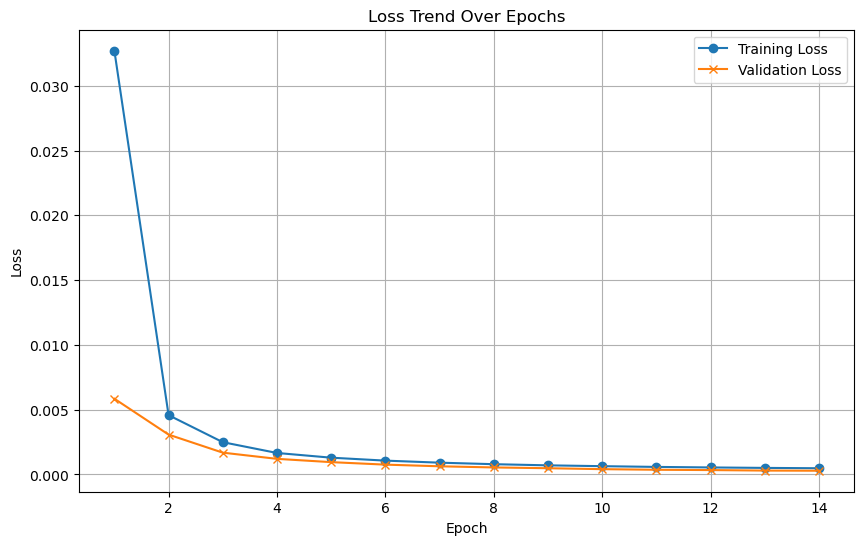

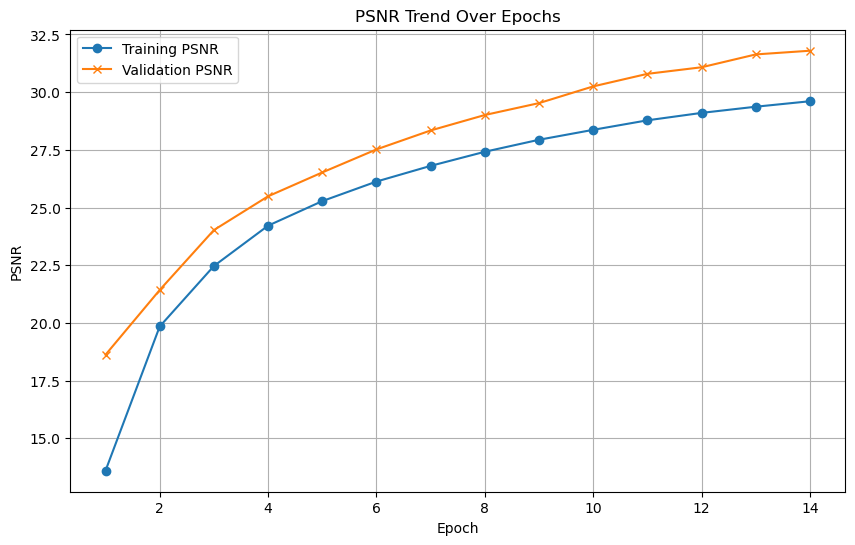

In [18]:
model_cae = ConvAutoEncode()
criterion_cae = nn.MSELoss()
optimizer_cae = optim.Adam(model_cae.parameters(), lr=0.0001)

#parameters for CAE
num_epochs_cae = 50
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_cae = model_cae.to(device)

#early stopping parameters
patience = 3  # number of epochs to wait for improvement
tolerance = 1e-4
best_val_loss = float('inf')
epochs_without_improvement = 0

#grad accumulation parameters
accumulation_steps = 8 

# for loss and metrics tracking
autoencoder_epoch_losses_cae = []
validation_epoch_losses_cae = []
train_psnr = []
val_psnr = []

psnr = PeakSignalNoiseRatio().to(device)

# mixed precision training
scaler = GradScaler()  # Gradient scaler for mixed precision

for epoch in range(num_epochs_cae):
    # training
    model_cae.train()
    running_loss = 0.0
    running_psnr = 0.0

    print(f"\nLOG: Epoch [{epoch + 1}/{num_epochs_cae}]")

    optimizer_cae.zero_grad()

    for batch_idx, data in enumerate(train_loader_cae):
        data = data.to(device).permute(0, 3, 1, 2)

        # mixed precision forward pass
        with autocast(device_type='cuda', dtype=torch.float16):
            _, decoded = model_cae(data)
            loss = criterion_cae(decoded, data) / accumulation_steps

            with torch.no_grad():
                nan_in_out = torch.isnan(decoded).any().item()
                inf_in_out = torch.isinf(decoded).any().item()

        #backward pass with gradient scaling
        scaler.scale(loss).backward()

        loss_value = loss.item() * accumulation_steps
        running_loss += loss_value

        psnr_value = psnr(decoded, data).item()
        running_psnr += psnr_value


        # performing optimizer step and reset gradients after `accumulation_steps` batches
        if (batch_idx + 1) % accumulation_steps == 0 or (batch_idx + 1) == len(train_loader_cae):
            scaler.step(optimizer_cae)
            scaler.update()
            optimizer_cae.zero_grad()

        if batch_idx == 0 or (batch_idx + 1) % 200 == 0:
            print(
    f"\t Training Batch [{batch_idx + 1}/{len(train_loader_cae)}], "
    f"Loss: {loss_value:.4f}, PSNR: {psnr_value:.4f}"
)


        #delete intermediate variables and clear GPU cache
        del data, decoded, loss
        torch.cuda.empty_cache()

    #compute average metrics for the epoch
    avg_train_loss = running_loss / len(train_loader_cae)
    avg_train_psnr = running_psnr / len(train_loader_cae)

    autoencoder_epoch_losses_cae.append(avg_train_loss)
    train_psnr.append(avg_train_psnr)

    print(f"Epoch [{epoch + 1}/{num_epochs_cae}] Training Loss: {avg_train_loss:.4f}, PSNR: {avg_train_psnr:.4f}")

    #clear GPU cache after training
    torch.cuda.empty_cache()

    #validation
    model_cae.eval()
    validation_loss = 0.0
    val_psnr_epoch = 0.0

    with torch.no_grad():
        for batch_idx, data in enumerate(val_loader_cae):
            data = data.to(device).permute(0, 3, 1, 2)

            # Mixed precision forward pass for validation
            with autocast(device_type='cuda', dtype=torch.float16):
                _, decoded = model_cae(data)
                loss = criterion_cae(decoded, data)

            validation_loss += loss.item()
            val_psnr_epoch += psnr(decoded, data).item()

            if batch_idx == 0 or (batch_idx + 1) % 10 == 0:
                loss_val = loss.item()
                psnr_val = psnr(decoded, data).item()
                print(
                    f"\t[Val]   Batch [{batch_idx + 1}/{len(val_loader_cae)}] "
                    f"Loss: {loss_val:.4f}, PSNR: {psnr_val:.4f}"
                )

            del data, decoded, loss
            torch.cuda.empty_cache()

    # average validation metrics for the epoch
    avg_val_loss = validation_loss / len(val_loader_cae)
    avg_val_psnr = val_psnr_epoch / len(val_loader_cae)

    validation_epoch_losses_cae.append(avg_val_loss)
    val_psnr.append(avg_val_psnr)

    print(f"Epoch [{epoch + 1}/{num_epochs_cae}] Validation Loss: {avg_val_loss:.4f}, PSNR: {avg_val_psnr:.4f}")

    # early stopping logic
    if avg_val_loss < best_val_loss - tolerance:
        best_val_loss = avg_val_loss
        epochs_without_improvement = 0  # Reset counter
        #best model checkpoint
        #torch.save(model_cae.state_dict(), 'best_model_cae.pth')
    else:
        epochs_without_improvement += 1

    if epochs_without_improvement >= patience:
        print(f"Early stopping triggered at epoch {epoch + 1}. No improvement for {patience} epochs.")
        break

#plot for training and validation loss trends
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(autoencoder_epoch_losses_cae) + 1), autoencoder_epoch_losses_cae, marker='o', label="Training Loss")
plt.plot(range(1, len(validation_epoch_losses_cae) + 1), validation_epoch_losses_cae, marker='x', label="Validation Loss")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Trend Over Epochs')
plt.legend()
plt.grid()
plt.show()

#plot for PSNR trends
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(train_psnr) + 1), train_psnr, marker='o', label="Training PSNR")
plt.plot(range(1, len(val_psnr) + 1), val_psnr, marker='x', label="Validation PSNR")
plt.xlabel('Epoch')
plt.ylabel('PSNR')
plt.title('PSNR Trend Over Epochs')
plt.legend()
plt.grid()
plt.show()

## Using the encoder section of CAE as feature extractor to generate compact representations

In [19]:
#dir to save encoded representations
encoded_dir = 'encoded_representations'
os.makedirs(encoded_dir, exist_ok=True)

loaders = {
    'train': train_loader,
    'val': val_loader,
    'test': test_loader
}

model_cae.eval()

# Feature extraction
with torch.no_grad():
    for subset_name, loader in loaders.items():
        print(f"\nExtracting representations for the {subset_name} dataset...")

        # dir for the given subset's encoded features
        subset_encoded_dir = os.path.join(encoded_dir, subset_name)
        os.makedirs(subset_encoded_dir, exist_ok=True)

        for batch_idx, (data, labels) in enumerate(loader):
            data = data.to(device).permute(0, 3, 1, 2)

            # passing data through the encoder to obtain representations
            encoded_features, _ = model_cae(data)  # latent representation

            # moving to CPU and convert to NumPy
            encoded_features = encoded_features.cpu().numpy()  
            labels = labels.cpu().numpy() 

            #saving the encoded features and labels
            np.save(os.path.join(subset_encoded_dir, f'encoded_batch_{batch_idx}.npy'), encoded_features)
            np.save(os.path.join(subset_encoded_dir, f'labels_batch_{batch_idx}.npy'), labels)

            if batch_idx % 1 == 0 and subset_name != 'test':
                print(f"    Processed batch {batch_idx + 1}/{len(loader)} for {subset_name} dataset.")
            elif subset_name == 'test' and batch_idx % 100 == 0:  # Log less frequently for the test set
                print(f"    Processed batch {batch_idx + 1}/{len(loader)} for {subset_name} dataset.")

        print(f"Completed encoding for the {subset_name} dataset.")

print("Feature extraction completed for all subsets.")


Extracting representations for the train dataset...
    Processed batch 1/1 for train dataset.
Completed encoding for the train dataset.

Extracting representations for the val dataset...
    Processed batch 1/1 for val dataset.
Completed encoding for the val dataset.

Extracting representations for the test dataset...
    Processed batch 1/578 for test dataset.


    Processed batch 101/578 for test dataset.


    Processed batch 201/578 for test dataset.


    Processed batch 301/578 for test dataset.


    Processed batch 401/578 for test dataset.


    Processed batch 501/578 for test dataset.


Completed encoding for the test dataset.
Feature extraction completed for all subsets.


## End-To-End CNN

In [20]:
class hyperspectralCNN(nn.Module):
    def __init__(self, input_channels, num_classes):
        super(hyperspectralCNN, self).__init__()

        self.cnn_layers = nn.Sequential(
            # Block 1
            nn.Conv2d(input_channels, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # 5x5 -> 2x2

            # Block 2
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),

            # Bottleneck
            nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.MaxPool2d(2, 2)  # 2x2 -> 1x1
        )

        #fully connected layers for classification
        self.fc_layers = nn.Sequential(
            nn.Flatten(),  #3D to 1D vector for input to FC layers
            nn.Linear(16 * 2 * 2, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, num_classes)
        )

    def forward(self, x):
        x = self.cnn_layers(x)
        x = self.fc_layers(x)
        return x


LOG: Epoch [1/1000] - Training
Epoch [1/1000] completed, Average Training Loss: 2.2244
    Validation Batch [1/1], Loss: 2.2038
Validation Loss: 2.2038, Validation Accuracy: 11.11%
Validation loss improved from inf to 2.2038. Saving model...

LOG: Epoch [2/1000] - Training
Epoch [2/1000] completed, Average Training Loss: 2.1670
    Validation Batch [1/1], Loss: 2.2038
Validation Loss: 2.2038, Validation Accuracy: 11.11%
Validation loss improved from 2.2038 to 2.2038. Saving model...

LOG: Epoch [3/1000] - Training
Epoch [3/1000] completed, Average Training Loss: 2.1414
    Validation Batch [1/1], Loss: 2.2038
Validation Loss: 2.2038, Validation Accuracy: 11.11%
Validation loss improved from 2.2038 to 2.2038. Saving model...

LOG: Epoch [4/1000] - Training
Epoch [4/1000] completed, Average Training Loss: 2.1122
    Validation Batch [1/1], Loss: 2.2038
Validation Loss: 2.2038, Validation Accuracy: 11.11%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [5/1000] - Training
Ep

    Validation Batch [1/1], Loss: 2.2036
Validation Loss: 2.2036, Validation Accuracy: 11.11%
Validation loss improved from 2.2037 to 2.2036. Saving model...

LOG: Epoch [8/1000] - Training
Epoch [8/1000] completed, Average Training Loss: 2.0567
    Validation Batch [1/1], Loss: 2.2035
Validation Loss: 2.2035, Validation Accuracy: 11.11%
Validation loss improved from 2.2036 to 2.2035. Saving model...

LOG: Epoch [9/1000] - Training
Epoch [9/1000] completed, Average Training Loss: 2.0204
    Validation Batch [1/1], Loss: 2.2034
Validation Loss: 2.2034, Validation Accuracy: 11.11%
Validation loss improved from 2.2035 to 2.2034. Saving model...

LOG: Epoch [10/1000] - Training
Epoch [10/1000] completed, Average Training Loss: 2.0260
    Validation Batch [1/1], Loss: 2.2033
Validation Loss: 2.2033, Validation Accuracy: 11.11%
Validation loss improved from 2.2034 to 2.2033. Saving model...

LOG: Epoch [11/1000] - Training
Epoch [11/1000] completed, Average Training Loss: 2.0160
    Validati

    Validation Batch [1/1], Loss: 2.0990
Validation Loss: 2.0990, Validation Accuracy: 35.56%
Validation loss improved from 2.1140 to 2.0990. Saving model...

LOG: Epoch [37/1000] - Training
Epoch [37/1000] completed, Average Training Loss: 1.7598
    Validation Batch [1/1], Loss: 2.0826
Validation Loss: 2.0826, Validation Accuracy: 37.78%
Validation loss improved from 2.0990 to 2.0826. Saving model...

LOG: Epoch [38/1000] - Training
Epoch [38/1000] completed, Average Training Loss: 1.7334
    Validation Batch [1/1], Loss: 2.0655
Validation Loss: 2.0655, Validation Accuracy: 42.22%
Validation loss improved from 2.0826 to 2.0655. Saving model...

LOG: Epoch [39/1000] - Training
Epoch [39/1000] completed, Average Training Loss: 1.7271
    Validation Batch [1/1], Loss: 2.0482
Validation Loss: 2.0482, Validation Accuracy: 42.22%
Validation loss improved from 2.0655 to 2.0482. Saving model...

LOG: Epoch [40/1000] - Training
Epoch [40/1000] completed, Average Training Loss: 1.7170
    Vali

    Validation Batch [1/1], Loss: 1.5591
Validation Loss: 1.5591, Validation Accuracy: 75.56%
Validation loss improved from 1.5744 to 1.5591. Saving model...

LOG: Epoch [66/1000] - Training
Epoch [66/1000] completed, Average Training Loss: 1.4989
    Validation Batch [1/1], Loss: 1.5449
Validation Loss: 1.5449, Validation Accuracy: 75.56%
Validation loss improved from 1.5591 to 1.5449. Saving model...

LOG: Epoch [67/1000] - Training
Epoch [67/1000] completed, Average Training Loss: 1.4976
    Validation Batch [1/1], Loss: 1.5331
Validation Loss: 1.5331, Validation Accuracy: 75.56%
Validation loss improved from 1.5449 to 1.5331. Saving model...

LOG: Epoch [68/1000] - Training
Epoch [68/1000] completed, Average Training Loss: 1.4808
    Validation Batch [1/1], Loss: 1.5203
Validation Loss: 1.5203, Validation Accuracy: 75.56%
Validation loss improved from 1.5331 to 1.5203. Saving model...

LOG: Epoch [69/1000] - Training
Epoch [69/1000] completed, Average Training Loss: 1.4838
    Vali

Epoch [95/1000] completed, Average Training Loss: 1.2586
    Validation Batch [1/1], Loss: 1.2643
Validation Loss: 1.2643, Validation Accuracy: 84.44%
Validation loss improved from 1.2784 to 1.2643. Saving model...

LOG: Epoch [96/1000] - Training
Epoch [96/1000] completed, Average Training Loss: 1.2546
    Validation Batch [1/1], Loss: 1.2513
Validation Loss: 1.2513, Validation Accuracy: 84.44%
Validation loss improved from 1.2643 to 1.2513. Saving model...

LOG: Epoch [97/1000] - Training
Epoch [97/1000] completed, Average Training Loss: 1.2592
    Validation Batch [1/1], Loss: 1.2438
Validation Loss: 1.2438, Validation Accuracy: 84.44%
Validation loss improved from 1.2513 to 1.2438. Saving model...

LOG: Epoch [98/1000] - Training
Epoch [98/1000] completed, Average Training Loss: 1.2400
    Validation Batch [1/1], Loss: 1.2402
Validation Loss: 1.2402, Validation Accuracy: 84.44%
Validation loss improved from 1.2438 to 1.2402. Saving model...

LOG: Epoch [99/1000] - Training
Epoch [9

Epoch [123/1000] completed, Average Training Loss: 1.0301
    Validation Batch [1/1], Loss: 1.0425
Validation Loss: 1.0425, Validation Accuracy: 93.33%
Validation loss improved from 1.0446 to 1.0425. Saving model...

LOG: Epoch [124/1000] - Training
Epoch [124/1000] completed, Average Training Loss: 1.0355
    Validation Batch [1/1], Loss: 1.0358
Validation Loss: 1.0358, Validation Accuracy: 93.33%
Validation loss improved from 1.0425 to 1.0358. Saving model...

LOG: Epoch [125/1000] - Training
Epoch [125/1000] completed, Average Training Loss: 1.0336
    Validation Batch [1/1], Loss: 1.0241
Validation Loss: 1.0241, Validation Accuracy: 93.33%
Validation loss improved from 1.0358 to 1.0241. Saving model...

LOG: Epoch [126/1000] - Training
Epoch [126/1000] completed, Average Training Loss: 1.0105
    Validation Batch [1/1], Loss: 1.0127
Validation Loss: 1.0127, Validation Accuracy: 95.56%
Validation loss improved from 1.0241 to 1.0127. Saving model...

LOG: Epoch [127/1000] - Training


Epoch [152/1000] completed, Average Training Loss: 0.8321
    Validation Batch [1/1], Loss: 0.8330
Validation Loss: 0.8330, Validation Accuracy: 97.78%
Validation loss improved from 0.8397 to 0.8330. Saving model...

LOG: Epoch [153/1000] - Training
Epoch [153/1000] completed, Average Training Loss: 0.8093
    Validation Batch [1/1], Loss: 0.8317
Validation Loss: 0.8317, Validation Accuracy: 97.78%
Validation loss improved from 0.8330 to 0.8317. Saving model...

LOG: Epoch [154/1000] - Training
Epoch [154/1000] completed, Average Training Loss: 0.8150
    Validation Batch [1/1], Loss: 0.8198
Validation Loss: 0.8198, Validation Accuracy: 97.78%
Validation loss improved from 0.8317 to 0.8198. Saving model...

LOG: Epoch [155/1000] - Training
Epoch [155/1000] completed, Average Training Loss: 0.8270
    Validation Batch [1/1], Loss: 0.8109
Validation Loss: 0.8109, Validation Accuracy: 100.00%
Validation loss improved from 0.8198 to 0.8109. Saving model...

LOG: Epoch [156/1000] - Training

    Validation Batch [1/1], Loss: 0.6484
Validation Loss: 0.6484, Validation Accuracy: 97.78%
Validation loss improved from 0.6587 to 0.6484. Saving model...

LOG: Epoch [183/1000] - Training
Epoch [183/1000] completed, Average Training Loss: 0.6239
    Validation Batch [1/1], Loss: 0.6414
Validation Loss: 0.6414, Validation Accuracy: 97.78%
Validation loss improved from 0.6484 to 0.6414. Saving model...

LOG: Epoch [184/1000] - Training
Epoch [184/1000] completed, Average Training Loss: 0.6051
    Validation Batch [1/1], Loss: 0.6373
Validation Loss: 0.6373, Validation Accuracy: 97.78%
Validation loss improved from 0.6414 to 0.6373. Saving model...

LOG: Epoch [185/1000] - Training
Epoch [185/1000] completed, Average Training Loss: 0.5993
    Validation Batch [1/1], Loss: 0.6296
Validation Loss: 0.6296, Validation Accuracy: 97.78%
Validation loss improved from 0.6373 to 0.6296. Saving model...

LOG: Epoch [186/1000] - Training
Epoch [186/1000] completed, Average Training Loss: 0.5844


    Validation Batch [1/1], Loss: 0.4919
Validation Loss: 0.4919, Validation Accuracy: 95.56%
Validation loss improved from 0.5035 to 0.4919. Saving model...

LOG: Epoch [212/1000] - Training
Epoch [212/1000] completed, Average Training Loss: 0.4919
    Validation Batch [1/1], Loss: 0.4894
Validation Loss: 0.4894, Validation Accuracy: 95.56%
Validation loss improved from 0.4919 to 0.4894. Saving model...

LOG: Epoch [213/1000] - Training
Epoch [213/1000] completed, Average Training Loss: 0.4890
    Validation Batch [1/1], Loss: 0.4915
Validation Loss: 0.4915, Validation Accuracy: 97.78%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [214/1000] - Training
Epoch [214/1000] completed, Average Training Loss: 0.4517
    Validation Batch [1/1], Loss: 0.4855
Validation Loss: 0.4855, Validation Accuracy: 97.78%
Validation loss improved from 0.4894 to 0.4855. Saving model...

LOG: Epoch [215/1000] - Training
Epoch [215/1000] completed, Average Training Loss: 0.4546
    Validation 

    Validation Batch [1/1], Loss: 0.3796
Validation Loss: 0.3796, Validation Accuracy: 95.56%
Validation loss improved from 0.3828 to 0.3796. Saving model...

LOG: Epoch [241/1000] - Training
Epoch [241/1000] completed, Average Training Loss: 0.3557
    Validation Batch [1/1], Loss: 0.3760
Validation Loss: 0.3760, Validation Accuracy: 95.56%
Validation loss improved from 0.3796 to 0.3760. Saving model...

LOG: Epoch [242/1000] - Training
Epoch [242/1000] completed, Average Training Loss: 0.3355
    Validation Batch [1/1], Loss: 0.3742
Validation Loss: 0.3742, Validation Accuracy: 95.56%
Validation loss improved from 0.3760 to 0.3742. Saving model...

LOG: Epoch [243/1000] - Training
Epoch [243/1000] completed, Average Training Loss: 0.3087
    Validation Batch [1/1], Loss: 0.3739
Validation Loss: 0.3739, Validation Accuracy: 93.33%
Validation loss improved from 0.3742 to 0.3739. Saving model...

LOG: Epoch [244/1000] - Training
Epoch [244/1000] completed, Average Training Loss: 0.3312


Epoch [271/1000] completed, Average Training Loss: 0.2537
    Validation Batch [1/1], Loss: 0.2996
Validation Loss: 0.2996, Validation Accuracy: 97.78%
Validation loss improved from 0.3009 to 0.2996. Saving model...

LOG: Epoch [272/1000] - Training
Epoch [272/1000] completed, Average Training Loss: 0.2584
    Validation Batch [1/1], Loss: 0.2997
Validation Loss: 0.2997, Validation Accuracy: 95.56%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [273/1000] - Training
Epoch [273/1000] completed, Average Training Loss: 0.2570
    Validation Batch [1/1], Loss: 0.2960
Validation Loss: 0.2960, Validation Accuracy: 95.56%
Validation loss improved from 0.2996 to 0.2960. Saving model...

LOG: Epoch [274/1000] - Training
Epoch [274/1000] completed, Average Training Loss: 0.2294
    Validation Batch [1/1], Loss: 0.2881
Validation Loss: 0.2881, Validation Accuracy: 95.56%
Validation loss improved from 0.2960 to 0.2881. Saving model...

LOG: Epoch [275/1000] - Training
Epoch [275/1000

Epoch [301/1000] completed, Average Training Loss: 0.1895
    Validation Batch [1/1], Loss: 0.2396
Validation Loss: 0.2396, Validation Accuracy: 95.56%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [302/1000] - Training
Epoch [302/1000] completed, Average Training Loss: 0.1990
    Validation Batch [1/1], Loss: 0.2409
Validation Loss: 0.2409, Validation Accuracy: 95.56%
Validation loss did not improve. Patience: 4/100

LOG: Epoch [303/1000] - Training
Epoch [303/1000] completed, Average Training Loss: 0.1889
    Validation Batch [1/1], Loss: 0.2339
Validation Loss: 0.2339, Validation Accuracy: 95.56%
Validation loss improved from 0.2376 to 0.2339. Saving model...

LOG: Epoch [304/1000] - Training
Epoch [304/1000] completed, Average Training Loss: 0.1852
    Validation Batch [1/1], Loss: 0.2366
Validation Loss: 0.2366, Validation Accuracy: 95.56%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [305/1000] - Training
Epoch [305/1000] completed, Average Training 

    Validation Batch [1/1], Loss: 0.1851
Validation Loss: 0.1851, Validation Accuracy: 97.78%
Validation loss improved from 0.1971 to 0.1851. Saving model...

LOG: Epoch [331/1000] - Training
Epoch [331/1000] completed, Average Training Loss: 0.1307
    Validation Batch [1/1], Loss: 0.1822
Validation Loss: 0.1822, Validation Accuracy: 95.56%
Validation loss improved from 0.1851 to 0.1822. Saving model...

LOG: Epoch [332/1000] - Training
Epoch [332/1000] completed, Average Training Loss: 0.1556
    Validation Batch [1/1], Loss: 0.1865
Validation Loss: 0.1865, Validation Accuracy: 95.56%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [333/1000] - Training
Epoch [333/1000] completed, Average Training Loss: 0.1624
    Validation Batch [1/1], Loss: 0.1939
Validation Loss: 0.1939, Validation Accuracy: 95.56%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [334/1000] - Training
Epoch [334/1000] completed, Average Training Loss: 0.1601
    Validation Batch [1/1], Lo

    Validation Batch [1/1], Loss: 0.1525
Validation Loss: 0.1525, Validation Accuracy: 97.78%
Validation loss improved from 0.1643 to 0.1525. Saving model...

LOG: Epoch [359/1000] - Training
Epoch [359/1000] completed, Average Training Loss: 0.1195
    Validation Batch [1/1], Loss: 0.1520
Validation Loss: 0.1520, Validation Accuracy: 97.78%
Validation loss improved from 0.1525 to 0.1520. Saving model...

LOG: Epoch [360/1000] - Training
Epoch [360/1000] completed, Average Training Loss: 0.1180
    Validation Batch [1/1], Loss: 0.1629
Validation Loss: 0.1629, Validation Accuracy: 97.78%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [361/1000] - Training
Epoch [361/1000] completed, Average Training Loss: 0.1137
    Validation Batch [1/1], Loss: 0.1722
Validation Loss: 0.1722, Validation Accuracy: 97.78%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [362/1000] - Training
Epoch [362/1000] completed, Average Training Loss: 0.1088
    Validation Batch [1/1], Lo

    Validation Batch [1/1], Loss: 0.1560
Validation Loss: 0.1560, Validation Accuracy: 95.56%
Validation loss did not improve. Patience: 7/100

LOG: Epoch [388/1000] - Training
Epoch [388/1000] completed, Average Training Loss: 0.0954
    Validation Batch [1/1], Loss: 0.1665
Validation Loss: 0.1665, Validation Accuracy: 95.56%
Validation loss did not improve. Patience: 8/100

LOG: Epoch [389/1000] - Training
Epoch [389/1000] completed, Average Training Loss: 0.1040
    Validation Batch [1/1], Loss: 0.1729
Validation Loss: 0.1729, Validation Accuracy: 93.33%
Validation loss did not improve. Patience: 9/100

LOG: Epoch [390/1000] - Training
Epoch [390/1000] completed, Average Training Loss: 0.0932
    Validation Batch [1/1], Loss: 0.1746
Validation Loss: 0.1746, Validation Accuracy: 95.56%
Validation loss did not improve. Patience: 10/100

LOG: Epoch [391/1000] - Training
Epoch [391/1000] completed, Average Training Loss: 0.0846
    Validation Batch [1/1], Loss: 0.1765
Validation Loss: 0

Epoch [417/1000] completed, Average Training Loss: 0.0865
    Validation Batch [1/1], Loss: 0.1740
Validation Loss: 0.1740, Validation Accuracy: 93.33%
Validation loss did not improve. Patience: 20/100

LOG: Epoch [418/1000] - Training
Epoch [418/1000] completed, Average Training Loss: 0.0756
    Validation Batch [1/1], Loss: 0.1642
Validation Loss: 0.1642, Validation Accuracy: 93.33%
Validation loss did not improve. Patience: 21/100

LOG: Epoch [419/1000] - Training
Epoch [419/1000] completed, Average Training Loss: 0.0739
    Validation Batch [1/1], Loss: 0.1430
Validation Loss: 0.1430, Validation Accuracy: 93.33%
Validation loss did not improve. Patience: 22/100

LOG: Epoch [420/1000] - Training
Epoch [420/1000] completed, Average Training Loss: 0.0734
    Validation Batch [1/1], Loss: 0.1326
Validation Loss: 0.1326, Validation Accuracy: 95.56%
Validation loss improved from 0.1385 to 0.1326. Saving model...

LOG: Epoch [421/1000] - Training
Epoch [421/1000] completed, Average Traini

Epoch [447/1000] completed, Average Training Loss: 0.0602
    Validation Batch [1/1], Loss: 0.1252
Validation Loss: 0.1252, Validation Accuracy: 95.56%
Validation loss did not improve. Patience: 15/100

LOG: Epoch [448/1000] - Training
Epoch [448/1000] completed, Average Training Loss: 0.0720
    Validation Batch [1/1], Loss: 0.1241
Validation Loss: 0.1241, Validation Accuracy: 97.78%
Validation loss did not improve. Patience: 16/100

LOG: Epoch [449/1000] - Training
Epoch [449/1000] completed, Average Training Loss: 0.0638
    Validation Batch [1/1], Loss: 0.1244
Validation Loss: 0.1244, Validation Accuracy: 95.56%
Validation loss did not improve. Patience: 17/100

LOG: Epoch [450/1000] - Training
Epoch [450/1000] completed, Average Training Loss: 0.0839
    Validation Batch [1/1], Loss: 0.1121
Validation Loss: 0.1121, Validation Accuracy: 95.56%
Validation loss improved from 0.1228 to 0.1121. Saving model...

LOG: Epoch [451/1000] - Training
Epoch [451/1000] completed, Average Traini

Epoch [476/1000] completed, Average Training Loss: 0.0617
    Validation Batch [1/1], Loss: 0.1176
Validation Loss: 0.1176, Validation Accuracy: 95.56%
Validation loss did not improve. Patience: 15/100

LOG: Epoch [477/1000] - Training
Epoch [477/1000] completed, Average Training Loss: 0.0559
    Validation Batch [1/1], Loss: 0.1090
Validation Loss: 0.1090, Validation Accuracy: 95.56%
Validation loss did not improve. Patience: 16/100

LOG: Epoch [478/1000] - Training
Epoch [478/1000] completed, Average Training Loss: 0.0452
    Validation Batch [1/1], Loss: 0.1042
Validation Loss: 0.1042, Validation Accuracy: 95.56%
Validation loss improved from 0.1064 to 0.1042. Saving model...

LOG: Epoch [479/1000] - Training
Epoch [479/1000] completed, Average Training Loss: 0.0522
    Validation Batch [1/1], Loss: 0.1110
Validation Loss: 0.1110, Validation Accuracy: 95.56%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [480/1000] - Training
Epoch [480/1000] completed, Average Trainin

    Validation Batch [1/1], Loss: 0.1126
Validation Loss: 0.1126, Validation Accuracy: 95.56%
Validation loss did not improve. Patience: 20/100

LOG: Epoch [508/1000] - Training
Epoch [508/1000] completed, Average Training Loss: 0.0529
    Validation Batch [1/1], Loss: 0.1294
Validation Loss: 0.1294, Validation Accuracy: 95.56%
Validation loss did not improve. Patience: 21/100

LOG: Epoch [509/1000] - Training
Epoch [509/1000] completed, Average Training Loss: 0.0472
    Validation Batch [1/1], Loss: 0.1242
Validation Loss: 0.1242, Validation Accuracy: 95.56%
Validation loss did not improve. Patience: 22/100

LOG: Epoch [510/1000] - Training
Epoch [510/1000] completed, Average Training Loss: 0.0480
    Validation Batch [1/1], Loss: 0.1114
Validation Loss: 0.1114, Validation Accuracy: 97.78%
Validation loss did not improve. Patience: 23/100

LOG: Epoch [511/1000] - Training
Epoch [511/1000] completed, Average Training Loss: 0.0472
    Validation Batch [1/1], Loss: 0.0994
Validation Loss

Epoch [536/1000] completed, Average Training Loss: 0.0367
    Validation Batch [1/1], Loss: 0.1518
Validation Loss: 0.1518, Validation Accuracy: 97.78%
Validation loss did not improve. Patience: 23/100

LOG: Epoch [537/1000] - Training
Epoch [537/1000] completed, Average Training Loss: 0.0470
    Validation Batch [1/1], Loss: 0.1525
Validation Loss: 0.1525, Validation Accuracy: 97.78%
Validation loss did not improve. Patience: 24/100

LOG: Epoch [538/1000] - Training
Epoch [538/1000] completed, Average Training Loss: 0.0393
    Validation Batch [1/1], Loss: 0.1362
Validation Loss: 0.1362, Validation Accuracy: 95.56%
Validation loss did not improve. Patience: 25/100

LOG: Epoch [539/1000] - Training
Epoch [539/1000] completed, Average Training Loss: 0.0497
    Validation Batch [1/1], Loss: 0.1317
Validation Loss: 0.1317, Validation Accuracy: 95.56%
Validation loss did not improve. Patience: 26/100

LOG: Epoch [540/1000] - Training
Epoch [540/1000] completed, Average Training Loss: 0.045

Epoch [566/1000] completed, Average Training Loss: 0.0382
    Validation Batch [1/1], Loss: 0.1135
Validation Loss: 0.1135, Validation Accuracy: 95.56%
Validation loss did not improve. Patience: 53/100

LOG: Epoch [567/1000] - Training
Epoch [567/1000] completed, Average Training Loss: 0.0325
    Validation Batch [1/1], Loss: 0.1170
Validation Loss: 0.1170, Validation Accuracy: 95.56%
Validation loss did not improve. Patience: 54/100

LOG: Epoch [568/1000] - Training
Epoch [568/1000] completed, Average Training Loss: 0.0398
    Validation Batch [1/1], Loss: 0.1175
Validation Loss: 0.1175, Validation Accuracy: 95.56%
Validation loss did not improve. Patience: 55/100

LOG: Epoch [569/1000] - Training
Epoch [569/1000] completed, Average Training Loss: 0.0287
    Validation Batch [1/1], Loss: 0.1177
Validation Loss: 0.1177, Validation Accuracy: 95.56%
Validation loss did not improve. Patience: 56/100

LOG: Epoch [570/1000] - Training
Epoch [570/1000] completed, Average Training Loss: 0.034

Epoch [595/1000] completed, Average Training Loss: 0.0332
    Validation Batch [1/1], Loss: 0.0879
Validation Loss: 0.0879, Validation Accuracy: 95.56%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [596/1000] - Training
Epoch [596/1000] completed, Average Training Loss: 0.0339
    Validation Batch [1/1], Loss: 0.1115
Validation Loss: 0.1115, Validation Accuracy: 95.56%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [597/1000] - Training
Epoch [597/1000] completed, Average Training Loss: 0.0229
    Validation Batch [1/1], Loss: 0.1294
Validation Loss: 0.1294, Validation Accuracy: 95.56%
Validation loss did not improve. Patience: 4/100

LOG: Epoch [598/1000] - Training
Epoch [598/1000] completed, Average Training Loss: 0.0257
    Validation Batch [1/1], Loss: 0.1348
Validation Loss: 0.1348, Validation Accuracy: 95.56%
Validation loss did not improve. Patience: 5/100

LOG: Epoch [599/1000] - Training
Epoch [599/1000] completed, Average Training Loss: 0.0271
  

Epoch [626/1000] completed, Average Training Loss: 0.0259
    Validation Batch [1/1], Loss: 0.1087
Validation Loss: 0.1087, Validation Accuracy: 95.56%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [627/1000] - Training
Epoch [627/1000] completed, Average Training Loss: 0.0280
    Validation Batch [1/1], Loss: 0.1294
Validation Loss: 0.1294, Validation Accuracy: 95.56%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [628/1000] - Training
Epoch [628/1000] completed, Average Training Loss: 0.0283
    Validation Batch [1/1], Loss: 0.1402
Validation Loss: 0.1402, Validation Accuracy: 95.56%
Validation loss did not improve. Patience: 4/100

LOG: Epoch [629/1000] - Training
Epoch [629/1000] completed, Average Training Loss: 0.0215
    Validation Batch [1/1], Loss: 0.1511
Validation Loss: 0.1511, Validation Accuracy: 95.56%
Validation loss did not improve. Patience: 5/100

LOG: Epoch [630/1000] - Training
Epoch [630/1000] completed, Average Training Loss: 0.0257
  

Epoch [655/1000] completed, Average Training Loss: 0.0289
    Validation Batch [1/1], Loss: 0.0556
Validation Loss: 0.0556, Validation Accuracy: 100.00%
Validation loss improved from 0.0583 to 0.0556. Saving model...

LOG: Epoch [656/1000] - Training
Epoch [656/1000] completed, Average Training Loss: 0.0258
    Validation Batch [1/1], Loss: 0.0729
Validation Loss: 0.0729, Validation Accuracy: 97.78%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [657/1000] - Training
Epoch [657/1000] completed, Average Training Loss: 0.0318
    Validation Batch [1/1], Loss: 0.1164
Validation Loss: 0.1164, Validation Accuracy: 95.56%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [658/1000] - Training
Epoch [658/1000] completed, Average Training Loss: 0.0249
    Validation Batch [1/1], Loss: 0.1603
Validation Loss: 0.1603, Validation Accuracy: 95.56%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [659/1000] - Training
Epoch [659/1000] completed, Average Training

Epoch [683/1000] completed, Average Training Loss: 0.0271
    Validation Batch [1/1], Loss: 0.1020
Validation Loss: 0.1020, Validation Accuracy: 95.56%
Validation loss did not improve. Patience: 28/100

LOG: Epoch [684/1000] - Training
Epoch [684/1000] completed, Average Training Loss: 0.0266
    Validation Batch [1/1], Loss: 0.0976
Validation Loss: 0.0976, Validation Accuracy: 95.56%
Validation loss did not improve. Patience: 29/100

LOG: Epoch [685/1000] - Training
Epoch [685/1000] completed, Average Training Loss: 0.0194
    Validation Batch [1/1], Loss: 0.0975
Validation Loss: 0.0975, Validation Accuracy: 95.56%
Validation loss did not improve. Patience: 30/100

LOG: Epoch [686/1000] - Training
Epoch [686/1000] completed, Average Training Loss: 0.0246
    Validation Batch [1/1], Loss: 0.0984
Validation Loss: 0.0984, Validation Accuracy: 95.56%
Validation loss did not improve. Patience: 31/100

LOG: Epoch [687/1000] - Training
Epoch [687/1000] completed, Average Training Loss: 0.026

Epoch [713/1000] completed, Average Training Loss: 0.0250
    Validation Batch [1/1], Loss: 0.1305
Validation Loss: 0.1305, Validation Accuracy: 95.56%
Validation loss did not improve. Patience: 58/100

LOG: Epoch [714/1000] - Training
Epoch [714/1000] completed, Average Training Loss: 0.0178
    Validation Batch [1/1], Loss: 0.1401
Validation Loss: 0.1401, Validation Accuracy: 95.56%
Validation loss did not improve. Patience: 59/100

LOG: Epoch [715/1000] - Training
Epoch [715/1000] completed, Average Training Loss: 0.0192
    Validation Batch [1/1], Loss: 0.1471
Validation Loss: 0.1471, Validation Accuracy: 93.33%
Validation loss did not improve. Patience: 60/100

LOG: Epoch [716/1000] - Training
Epoch [716/1000] completed, Average Training Loss: 0.0220
    Validation Batch [1/1], Loss: 0.1570
Validation Loss: 0.1570, Validation Accuracy: 93.33%
Validation loss did not improve. Patience: 61/100

LOG: Epoch [717/1000] - Training
Epoch [717/1000] completed, Average Training Loss: 0.021

Epoch [744/1000] completed, Average Training Loss: 0.0178
    Validation Batch [1/1], Loss: 0.1058
Validation Loss: 0.1058, Validation Accuracy: 95.56%
Validation loss did not improve. Patience: 89/100

LOG: Epoch [745/1000] - Training
Epoch [745/1000] completed, Average Training Loss: 0.0159
    Validation Batch [1/1], Loss: 0.1074
Validation Loss: 0.1074, Validation Accuracy: 97.78%
Validation loss did not improve. Patience: 90/100

LOG: Epoch [746/1000] - Training
Epoch [746/1000] completed, Average Training Loss: 0.0160
    Validation Batch [1/1], Loss: 0.1118
Validation Loss: 0.1118, Validation Accuracy: 97.78%
Validation loss did not improve. Patience: 91/100

LOG: Epoch [747/1000] - Training
Epoch [747/1000] completed, Average Training Loss: 0.0201
    Validation Batch [1/1], Loss: 0.1131
Validation Loss: 0.1131, Validation Accuracy: 97.78%
Validation loss did not improve. Patience: 92/100

LOG: Epoch [748/1000] - Training
Epoch [748/1000] completed, Average Training Loss: 0.016

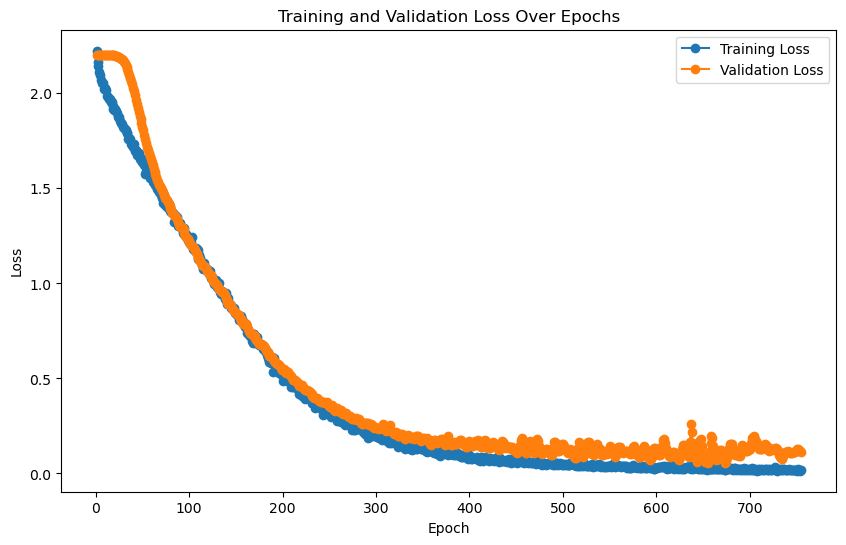

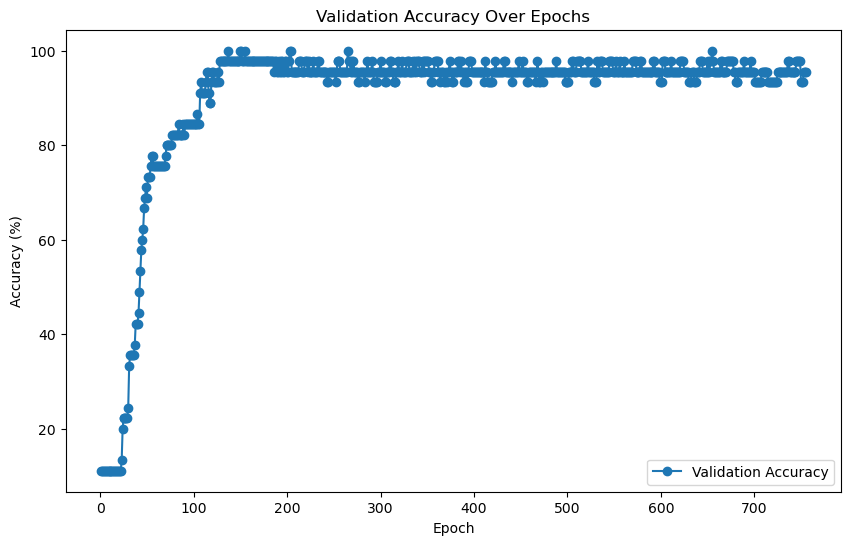


Evaluating on the test set...
    Test Batch [1/578], Loss: 0.0556



Final Test Loss: 0.1005, Test Accuracy: 97.44%
Saved E2E CNN predictions and true labels to model_predictions


In [21]:
#hyperparameters
num_epochs = 1000
learning_rate = 0.0001

#init the model, CrossEntropy loss function, and optimizer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#getting unique labels from entire dataset (train, validation, test)
all_labels = []
for loader in [train_loader, val_loader, test_loader]:
    for _, labels in loader:
        all_labels.extend(labels.tolist())
all_labels = np.unique(all_labels)

# init model with correct number of classes
num_classes = len(all_labels)
model = hyperspectralCNN(input_channels=window_num_channels, num_classes=num_classes).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
#lists to store losses and accuracies
classification_epoch_losses = []
validation_epoch_losses = []
val_accuracies = []

#early stopping parameters
patience = 100
best_val_loss = float('inf')
epochs_without_improvement = 0
best_model_weights = None

#training loop + validation with early stopping
for epoch in range(num_epochs):
    # TRAINING
    model.train()
    running_loss = 0.0
    print(f"\nLOG: Epoch [{epoch + 1}/{num_epochs}] - Training")

    for batch_idx, (data, target) in enumerate(train_loader):
        data = data.to(device).permute(0, 3, 1, 2) 
        target = target.to(device)

        # forward pass
        outputs = model(data)
        loss = criterion(outputs, target)

        # backward pass + optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # accum loss
        running_loss += loss.item()

        if (batch_idx + 1) % 10 == 0:
            print(f"    Training Batch [{batch_idx + 1}/{len(train_loader)}], Loss: {loss.item():.4f}")

    # calc + store average training loss per epoch
    avg_train_loss = running_loss / len(train_loader)
    classification_epoch_losses.append(avg_train_loss)
    print(f"Epoch [{epoch + 1}/{num_epochs}] completed, Average Training Loss: {avg_train_loss:.4f}")

    # VALIDATION
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(val_loader):
            data = data.to(device).permute(0, 3, 1, 2)
            target = target.to(device)
            outputs = model(data)
            loss = criterion(outputs, target)
            val_loss += loss.item()

            # accu calculation
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == target).sum().item()
            total += target.size(0)

            if batch_idx == 0 or (batch_idx + 1) % 10 == 0:
                print(f"    Validation Batch [{batch_idx + 1}/{len(val_loader)}], Loss: {loss.item():.4f}")

    # calc + store validation metrics
    avg_val_loss = val_loss / len(val_loader)
    validation_epoch_losses.append(avg_val_loss)
    val_accuracy = 100 * correct / total
    val_accuracies.append(val_accuracy)
    print(f"Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%")

    # early stopping logic
    if avg_val_loss <= best_val_loss:
        print(f"Validation loss improved from {best_val_loss:.4f} to {avg_val_loss:.4f}. Saving model...")
        best_val_loss = avg_val_loss
        epochs_without_improvement = 0
        best_model_weights = model.state_dict()
    else:
        epochs_without_improvement += 1
        print(f"Validation loss did not improve. Patience: {epochs_without_improvement}/{patience}")

    if epochs_without_improvement >= patience:
        print(f"Early stopping triggered at epoch {epoch + 1}. No improvement for {patience} epochs.")
        break

# loading the best model weights
if best_model_weights is not None:
    print("Loading the best model weights...")
    model.load_state_dict(best_model_weights)

completed_epochs = len(classification_epoch_losses)

# plot for loss and accuracy trends over epochs
plt.figure(figsize=(10,6))
plt.plot(range(1, completed_epochs + 1), classification_epoch_losses, label="Training Loss", marker='o')
plt.plot(range(1, completed_epochs + 1), validation_epoch_losses, label="Validation Loss", marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.show()

plt.figure(figsize=(10,6))
plt.plot(range(1, completed_epochs + 1), val_accuracies, label="Validation Accuracy", marker='o')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Validation Accuracy Over Epochs')
plt.legend()
plt.show()

#test Set Evaluation
print("\nEvaluating on the test set...")
model.eval()
test_loss = 0.0
correct = 0
total = 0
e2ecnn_test_predictions = []
e2ecnn_test_true_labels = []

with torch.no_grad():
    for batch_idx, (data, target) in enumerate(test_loader):
        data = data.to(device).permute(0, 3, 1, 2)
        target = target.to(device)
        outputs = model(data)
        loss = criterion(outputs, target)
        test_loss += loss.item()

        #accuracy calc
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == target).sum().item()
        total += target.size(0)

        e2ecnn_test_predictions.extend(predicted.cpu().numpy())
        e2ecnn_test_true_labels.extend(target.cpu().numpy())

        if batch_idx == 0 or (batch_idx + 1) % 1000 == 0:
            print(f"    Test Batch [{batch_idx + 1}/{len(test_loader)}], Loss: {loss.item():.4f}")

#calc + print test metrics
avg_test_loss = test_loss / len(test_loader)
test_accuracy = 100 * correct / total
print(f"\nFinal Test Loss: {avg_test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")

# Convert to numpy arrays and save
e2e_test_predictions = np.array(e2ecnn_test_predictions)
e2e_test_true_labels = np.array(e2ecnn_test_true_labels)

np.save(os.path.join(predictions_dir, 'e2e_cnn_predictions.npy'), e2e_test_predictions)
np.save(os.path.join(predictions_dir, 'e2e_cnn_true_labels.npy'), e2e_test_true_labels)
print(f"Saved E2E CNN predictions and true labels to {predictions_dir}")

In [22]:
# dir to save the cnn representations
e2ecnn_rep_dir = "e2ecnn_representations"
os.makedirs(e2ecnn_rep_dir, exist_ok=True)

e2ecnn_loaders = {
    'train': train_loader,
    'val': val_loader,
    'test': test_loader
}


model.eval()

with torch.no_grad():
    for e2ecnn_split_name, e2ecnn_loader in e2ecnn_loaders.items():
        print(f"\nExtracting SCL representations for the {e2ecnn_split_name} dataset...")
        # creating subfolder for the split
        e2ecnn_split_dir = os.path.join(e2ecnn_rep_dir, e2ecnn_split_name)
        os.makedirs(e2ecnn_split_dir, exist_ok=True)

        # processing the data batch-wise
        for e2ecnn_batch_idx, (e2ecnn_vectors, e2ecnn_labels) in enumerate(e2ecnn_loader):
            e2ecnn_vectors = e2ecnn_vectors.permute(0, 3, 1, 2) 
            e2ecnn_vectors = e2ecnn_vectors.to(device).float()
            # computing projections using the trained SCL model
            e2ecnn_projections = model(e2ecnn_vectors)

            # converting projections and labels to np arrays
            e2ecnn_projections_np = e2ecnn_projections.cpu().numpy()
            e2ecnn_labels_np = e2ecnn_labels.cpu().numpy()

            # saving the batch projections and labels
            np.save(os.path.join(e2ecnn_split_dir, f"cnn_encoded_batch_{e2ecnn_batch_idx}.npy"), e2ecnn_projections_np)
            np.save(os.path.join(e2ecnn_split_dir, f"cnn_labels_batch_{e2ecnn_batch_idx}.npy"), e2ecnn_labels_np)

            if (e2ecnn_batch_idx + 1) % 10 == 0:
                print(f"  Processed batch {e2ecnn_batch_idx + 1}/{len(e2ecnn_loader)} for {e2ecnn_split_name} dataset.")

        print(f"Completed extraction for the {e2ecnn_split_name} dataset. Representations saved in '{e2ecnn_split_dir}'.")

print("E2E CNN representations extraction complete.")


Extracting SCL representations for the train dataset...
Completed extraction for the train dataset. Representations saved in 'e2ecnn_representations\train'.

Extracting SCL representations for the val dataset...
Completed extraction for the val dataset. Representations saved in 'e2ecnn_representations\val'.

Extracting SCL representations for the test dataset...
  Processed batch 10/578 for test dataset.
  Processed batch 20/578 for test dataset.
  Processed batch 30/578 for test dataset.


  Processed batch 40/578 for test dataset.


  Processed batch 50/578 for test dataset.
  Processed batch 60/578 for test dataset.
  Processed batch 70/578 for test dataset.
  Processed batch 80/578 for test dataset.


  Processed batch 90/578 for test dataset.


  Processed batch 100/578 for test dataset.
  Processed batch 110/578 for test dataset.
  Processed batch 120/578 for test dataset.
  Processed batch 130/578 for test dataset.


  Processed batch 140/578 for test dataset.


  Processed batch 150/578 for test dataset.
  Processed batch 160/578 for test dataset.
  Processed batch 170/578 for test dataset.
  Processed batch 180/578 for test dataset.


  Processed batch 190/578 for test dataset.


  Processed batch 200/578 for test dataset.
  Processed batch 210/578 for test dataset.
  Processed batch 220/578 for test dataset.
  Processed batch 230/578 for test dataset.


  Processed batch 240/578 for test dataset.


  Processed batch 250/578 for test dataset.
  Processed batch 260/578 for test dataset.
  Processed batch 270/578 for test dataset.
  Processed batch 280/578 for test dataset.


  Processed batch 290/578 for test dataset.
  Processed batch 300/578 for test dataset.
  Processed batch 310/578 for test dataset.
  Processed batch 320/578 for test dataset.
  Processed batch 330/578 for test dataset.


  Processed batch 340/578 for test dataset.
  Processed batch 350/578 for test dataset.
  Processed batch 360/578 for test dataset.
  Processed batch 370/578 for test dataset.
  Processed batch 380/578 for test dataset.


  Processed batch 390/578 for test dataset.
  Processed batch 400/578 for test dataset.
  Processed batch 410/578 for test dataset.
  Processed batch 420/578 for test dataset.
  Processed batch 430/578 for test dataset.


  Processed batch 440/578 for test dataset.
  Processed batch 450/578 for test dataset.
  Processed batch 460/578 for test dataset.
  Processed batch 470/578 for test dataset.
  Processed batch 480/578 for test dataset.


  Processed batch 490/578 for test dataset.
  Processed batch 500/578 for test dataset.
  Processed batch 510/578 for test dataset.
  Processed batch 520/578 for test dataset.
  Processed batch 530/578 for test dataset.


  Processed batch 540/578 for test dataset.
  Processed batch 550/578 for test dataset.
  Processed batch 560/578 for test dataset.
  Processed batch 570/578 for test dataset.
Completed extraction for the test dataset. Representations saved in 'e2ecnn_representations\test'.
E2E CNN representations extraction complete.


In [23]:
def load_cnn_reps_and_labels(split_dir):
    #gather all the cnn_encoded_batch npy files in sorted order
    cnn_rep_files = sorted(glob.glob(os.path.join(split_dir, "cnn_encoded_batch_*.npy")))

    cnn_all_reps = []
    cnn_all_labels = []

    for cnn_rep_file in cnn_rep_files:
        #deriving label filenames
        cnn_label_file = cnn_rep_file.replace("cnn_encoded_batch_", "cnn_labels_batch_")

        cnn_reps = np.load(cnn_rep_file)
        cnn_labels = np.load(cnn_label_file)

        cnn_all_reps.append(cnn_reps)
        cnn_all_labels.append(cnn_labels)

    #concat along first dim
    cnn_all_reps = np.concatenate(cnn_all_reps, axis = 0)
    cnn_all_labels = np.concatenate(cnn_all_labels, axis = 0)

    return cnn_all_reps, cnn_all_labels

In [24]:
cnn_train_dir = os.path.join("e2ecnn_representations", "train")
cnn_val_dir   = os.path.join("e2ecnn_representations", "val")
cnn_test_dir  = os.path.join("e2ecnn_representations", "test")

cnn_train_reps, cnn_train_labels = load_cnn_reps_and_labels(cnn_train_dir)
cnn_val_reps, cnn_val_labels = load_cnn_reps_and_labels(cnn_val_dir)
cnn_test_reps, cnn_test_labels = load_cnn_reps_and_labels(cnn_test_dir)

## Logistic Regression Model

In [25]:
def load_encoded_data(encoded_dir):
    print(f"LOG: Loading encoded data (representations) from {encoded_dir}...")
    features_list = []
    labels_list = []

    #iter through batches
    for filename in sorted(os.listdir(encoded_dir)):
        if filename.startswith('encoded_batch_') and filename.endswith('.npy'):

            #load the features
            features = np.load(os.path.join(encoded_dir, filename))
            features_flat = features.reshape(features.shape[0], -1) #flatten features for LRM
            features_list.append(features_flat)
        
        elif filename.startswith('labels_batch_') and filename.endswith('.npy'):

            #load labels
            labels = np.load(os.path.join(encoded_dir, filename))
            labels_list.append(labels)

    #concat all batches into a single array
    encoded_features = np.vstack(features_list)
    encoded_labels = np.hstack(labels_list)

    print(f"LOG: Loaded {encoded_features.shape[0]} samples with {encoded_features.shape[1]} features each")
    print(f"LOG: Labels shape: {encoded_labels.shape}")

    return encoded_features, encoded_labels

In [26]:
lrm_encoded_train_dir = os.path.join(encoded_dir, 'train')
lrm_encoded_val_dir = os.path.join(encoded_dir, 'val')
lrm_encoded_test_dir = os.path.join(encoded_dir, 'test')

print("\nLoading training data for LRM...")
lrm_train_features, lrm_train_labels = load_encoded_data(lrm_encoded_train_dir)

print("\nLoading validation data for LRM...")
lrm_val_features, lrm_val_labels = load_encoded_data(lrm_encoded_val_dir)

print("\nLoading test data for LRM...")
lrm_test_features, lrm_test_labels = load_encoded_data(lrm_encoded_test_dir)

#verify shapes
print(f"\nLOG: Training features shape: {lrm_train_features.shape}, Training labels shape: {lrm_train_labels.shape}")
print(f"LOG: Validation features shape: {lrm_val_features.shape}, Validation labels shape: {lrm_val_labels.shape}")
print(f"LOG: Test features shape: {lrm_test_features.shape}, Test labels shape: {lrm_test_labels.shape}")

print("\nLOG: Training Logistic Regression model...")
logistic_clf = LogisticRegression(max_iter=5000, random_state=42, class_weight = 'balanced')
logistic_clf.fit(lrm_train_features, lrm_train_labels)
print("LOG: Logistic Regression training complete.")

#eval on Validation Set
print("\nLOG: Evaluating on the validation set...")
lrm_val_predictions = logistic_clf.predict(lrm_val_features)
lrm_val_accuracy = accuracy_score(lrm_val_labels, lrm_val_predictions)
print(f"Validation Accuracy: {lrm_val_accuracy * 100:.2f}%")
print("\nValidation Classification Report:\n", classification_report(lrm_val_labels, lrm_val_predictions))

#eval on Test Set
print("\nLOG: Evaluating on the test set...")
lrm_test_predictions = logistic_clf.predict(lrm_test_features)
lrm_test_accuracy = accuracy_score(lrm_test_labels, lrm_test_predictions)
print(f"Test Accuracy: {lrm_test_accuracy * 100:.2f}%")
print("\nTest Classification Report:\n", classification_report(lrm_test_labels, lrm_test_predictions))

np.save(os.path.join(predictions_dir, 'cae_lrm_predictions.npy'), lrm_test_predictions)
np.save(os.path.join(predictions_dir, 'cae_lrm_true_labels.npy'), lrm_test_labels)
print(f"Saved CAE+LRM predictions and true labels to {predictions_dir}")



Loading training data for LRM...
LOG: Loading encoded data (representations) from encoded_representations\train...
LOG: Loaded 180 samples with 64 features each
LOG: Labels shape: (180,)

Loading validation data for LRM...
LOG: Loading encoded data (representations) from encoded_representations\val...
LOG: Loaded 45 samples with 64 features each
LOG: Labels shape: (45,)

Loading test data for LRM...
LOG: Loading encoded data (representations) from encoded_representations\test...


LOG: Loaded 147927 samples with 64 features each
LOG: Labels shape: (147927,)

LOG: Training features shape: (180, 64), Training labels shape: (180,)
LOG: Validation features shape: (45, 64), Validation labels shape: (45,)
LOG: Test features shape: (147927, 64), Test labels shape: (147927,)

LOG: Training Logistic Regression model...
LOG: Logistic Regression training complete.

LOG: Evaluating on the validation set...
Validation Accuracy: 93.33%

Validation Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       0.80      0.80      0.80         5
           2       0.80      0.80      0.80         5
           3       1.00      1.00      1.00         5
           4       1.00      1.00      1.00         5
           5       1.00      0.80      0.89         5
           6       0.83      1.00      0.91         5
           7       1.00      1.00      1.00         5
           8       1.00    

Saved CAE+LRM predictions and true labels to model_predictions


### Classifying CAE Embeddings with MLP

In [27]:
class MLPClassifier(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(MLPClassifier, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, num_classes)
        
        self._init_weights()
    
    def _init_weights(self):
        for m in self.modules(): 
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                nn.init.constant_(m.bias, 0)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        return self.fc4(x)

In [28]:
cae_mlp_train_dir = os.path.join("encoded_representations", "train")
cae_mlp_val_dir   = os.path.join("encoded_representations", "val")
cae_mlp_test_dir  = os.path.join("encoded_representations", "test")

cae_mlp_train_reps, cae_mlp_train_labels = load_encoded_data(cae_mlp_train_dir)
cae_mlp_val_reps, cae_mlp_val_labels = load_encoded_data(cae_mlp_val_dir)
cae_mlp_test_reps, cae_mlp_test_labels = load_encoded_data(cae_mlp_test_dir)

print("Train reps shape:",cae_mlp_train_reps.shape)
print("Train labels shape:", cae_mlp_train_labels.shape)

print("Val reps shape:", cae_mlp_val_reps.shape)
print("Val labels shape:", cae_mlp_val_labels.shape)

print("Test reps shape:", cae_mlp_test_reps.shape)
print("Test labels shape:", cae_mlp_test_labels.shape)

LOG: Loading encoded data (representations) from encoded_representations\train...
LOG: Loaded 180 samples with 64 features each
LOG: Labels shape: (180,)
LOG: Loading encoded data (representations) from encoded_representations\val...
LOG: Loaded 45 samples with 64 features each
LOG: Labels shape: (45,)
LOG: Loading encoded data (representations) from encoded_representations\test...
LOG: Loaded 147927 samples with 64 features each
LOG: Labels shape: (147927,)
Train reps shape: (180, 64)
Train labels shape: (180,)
Val reps shape: (45, 64)
Val labels shape: (45,)
Test reps shape: (147927, 64)
Test labels shape: (147927,)


In [29]:
#converting arrays to torch tensors
cae_mlp_train_embeddings_torch = torch.tensor(cae_mlp_train_reps, dtype=torch.float32)
cae_mlp_train_labels_torch = torch.tensor(cae_mlp_train_labels, dtype=torch.long)

cae_mlp_val_embeddings_torch = torch.tensor(cae_mlp_val_reps, dtype=torch.float32)
cae_mlp_val_labels_torch = torch.tensor(cae_mlp_val_labels, dtype=torch.long)

cae_mlp_test_embeddings_torch = torch.tensor(cae_mlp_test_reps, dtype=torch.float32)
cae_mlp_test_labels_torch = torch.tensor(cae_mlp_test_labels, dtype=torch.long)

#building datasets for mlp
cae_mlp_train_dataset = TensorDataset(cae_mlp_train_embeddings_torch, cae_mlp_train_labels_torch)
cae_mlp_val_dataset = TensorDataset(cae_mlp_val_embeddings_torch, cae_mlp_val_labels_torch)
cae_mlp_test_dataset = TensorDataset(cae_mlp_test_embeddings_torch, cae_mlp_test_labels_torch)

cae_mlp_batch_size = 64
cae_mlp_train_loader = DataLoader(cae_mlp_train_dataset, batch_size=cae_mlp_batch_size, shuffle=True)
cae_mlp_val_loader = DataLoader(cae_mlp_val_dataset, batch_size=cae_mlp_batch_size, shuffle=False)
cae_mlp_test_loader = DataLoader(cae_mlp_test_dataset, batch_size=cae_mlp_batch_size, shuffle=False)


[Epoch 1/1000] Train Loss: 2.2912  |  Val Loss: 2.0766
Validation loss improved from inf to 2.0766.


[Epoch 2/1000] Train Loss: 2.0711  |  Val Loss: 1.9592
Validation loss improved from 2.0766 to 1.9592.


[Epoch 3/1000] Train Loss: 1.9433  |  Val Loss: 1.8620
Validation loss improved from 1.9592 to 1.8620.
[Epoch 4/1000] Train Loss: 1.8367  |  Val Loss: 1.7657
Validation loss improved from 1.8620 to 1.7657.
[Epoch 5/1000] Train Loss: 1.7312  |  Val Loss: 1.6747
Validation loss improved from 1.7657 to 1.6747.
[Epoch 6/1000] Train Loss: 1.6313  |  Val Loss: 1.5835
Validation loss improved from 1.6747 to 1.5835.
[Epoch 7/1000] Train Loss: 1.5304  |  Val Loss: 1.4912
Validation loss improved from 1.5835 to 1.4912.
[Epoch 8/1000] Train Loss: 1.4352  |  Val Loss: 1.4007
Validation loss improved from 1.4912 to 1.4007.
[Epoch 9/1000] Train Loss: 1.3340  |  Val Loss: 1.3042
Validation loss improved from 1.4007 to 1.3042.
[Epoch 10/1000] Train Loss: 1.2288  |  Val Loss: 1.2026
Validation loss improved from 1.3042 to 1.2026.
[Epoch 11/1000] Train Loss: 1.1278  |  Val Loss: 1.1014
Validation loss improved from 1.2026 to 1.1014.
[Epoch 12/1000] Train Loss: 1.0300  |  Val Loss: 1.0003
Validation loss

[Epoch 34/1000] Train Loss: 0.1939  |  Val Loss: 0.2440
Validation loss improved from 0.2525 to 0.2440.
[Epoch 35/1000] Train Loss: 0.1887  |  Val Loss: 0.2317
Validation loss improved from 0.2440 to 0.2317.
[Epoch 36/1000] Train Loss: 0.1769  |  Val Loss: 0.2290
Validation loss improved from 0.2317 to 0.2290.
[Epoch 37/1000] Train Loss: 0.1715  |  Val Loss: 0.2295
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 38/1000] Train Loss: 0.1677  |  Val Loss: 0.2255
Validation loss improved from 0.2290 to 0.2255.
[Epoch 39/1000] Train Loss: 0.1601  |  Val Loss: 0.2280
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 40/1000] Train Loss: 0.1531  |  Val Loss: 0.2176
Validation loss improved from 0.2255 to 0.2176.
[Epoch 41/1000] Train Loss: 0.1492  |  Val Loss: 0.1992
Validation loss improved from 0.2176 to 0.1992.
[Epoch 42/1000] Train Loss: 0.1486  |  Val Loss: 0.1968
Validation loss improved from 0.1992 to 0.1968.
[Epoch 43/1000] Train Loss: 0.1387  |  Val Loss: 0.2

[Epoch 64/1000] Train Loss: 0.0831  |  Val Loss: 0.1546
Validation loss improved from 0.1589 to 0.1546.
[Epoch 65/1000] Train Loss: 0.0769  |  Val Loss: 0.1690
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 66/1000] Train Loss: 0.0776  |  Val Loss: 0.1704
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 67/1000] Train Loss: 0.0754  |  Val Loss: 0.1650
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 68/1000] Train Loss: 0.0718  |  Val Loss: 0.1523
Validation loss improved from 0.1546 to 0.1523.
[Epoch 69/1000] Train Loss: 0.0705  |  Val Loss: 0.1596
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 70/1000] Train Loss: 0.0702  |  Val Loss: 0.1620
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 71/1000] Train Loss: 0.0662  |  Val Loss: 0.1535
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 72/1000] Train Loss: 0.0672  |  Val Loss: 0.1607
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 73/1000] Train 

[Epoch 92/1000] Train Loss: 0.0412  |  Val Loss: 0.1642
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 93/1000] Train Loss: 0.0410  |  Val Loss: 0.1441
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 94/1000] Train Loss: 0.0404  |  Val Loss: 0.1522
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 95/1000] Train Loss: 0.0370  |  Val Loss: 0.1785
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 96/1000] Train Loss: 0.0402  |  Val Loss: 0.1729
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 97/1000] Train Loss: 0.0350  |  Val Loss: 0.1553
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 98/1000] Train Loss: 0.0376  |  Val Loss: 0.1505
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 99/1000] Train Loss: 0.0351  |  Val Loss: 0.1665
!! Validation loss did NOT improve !! Patience: 12/100
[Epoch 100/1000] Train Loss: 0.0336  |  Val Loss: 0.1598
!! Validation loss did NOT improve !! Patience: 13/100
[Epoc

[Epoch 123/1000] Train Loss: 0.0193  |  Val Loss: 0.1754
!! Validation loss did NOT improve !! Patience: 36/100
[Epoch 124/1000] Train Loss: 0.0198  |  Val Loss: 0.1664
!! Validation loss did NOT improve !! Patience: 37/100
[Epoch 125/1000] Train Loss: 0.0188  |  Val Loss: 0.1695
!! Validation loss did NOT improve !! Patience: 38/100
[Epoch 126/1000] Train Loss: 0.0188  |  Val Loss: 0.1779
!! Validation loss did NOT improve !! Patience: 39/100
[Epoch 127/1000] Train Loss: 0.0180  |  Val Loss: 0.1719
!! Validation loss did NOT improve !! Patience: 40/100
[Epoch 128/1000] Train Loss: 0.0183  |  Val Loss: 0.1670
!! Validation loss did NOT improve !! Patience: 41/100
[Epoch 129/1000] Train Loss: 0.0175  |  Val Loss: 0.1745
!! Validation loss did NOT improve !! Patience: 42/100
[Epoch 130/1000] Train Loss: 0.0171  |  Val Loss: 0.1741
!! Validation loss did NOT improve !! Patience: 43/100
[Epoch 131/1000] Train Loss: 0.0176  |  Val Loss: 0.1832
!! Validation loss did NOT improve !! Patience:

[Epoch 155/1000] Train Loss: 0.0108  |  Val Loss: 0.1870
!! Validation loss did NOT improve !! Patience: 68/100
[Epoch 156/1000] Train Loss: 0.0107  |  Val Loss: 0.1888
!! Validation loss did NOT improve !! Patience: 69/100
[Epoch 157/1000] Train Loss: 0.0106  |  Val Loss: 0.1830
!! Validation loss did NOT improve !! Patience: 70/100
[Epoch 158/1000] Train Loss: 0.0102  |  Val Loss: 0.1875
!! Validation loss did NOT improve !! Patience: 71/100
[Epoch 159/1000] Train Loss: 0.0100  |  Val Loss: 0.1981
!! Validation loss did NOT improve !! Patience: 72/100
[Epoch 160/1000] Train Loss: 0.0100  |  Val Loss: 0.1941
!! Validation loss did NOT improve !! Patience: 73/100
[Epoch 161/1000] Train Loss: 0.0099  |  Val Loss: 0.1893
!! Validation loss did NOT improve !! Patience: 74/100
[Epoch 162/1000] Train Loss: 0.0096  |  Val Loss: 0.1838
!! Validation loss did NOT improve !! Patience: 75/100
[Epoch 163/1000] Train Loss: 0.0097  |  Val Loss: 0.1842
!! Validation loss did NOT improve !! Patience:

[Epoch 185/1000] Train Loss: 0.0067  |  Val Loss: 0.1993
!! Validation loss did NOT improve !! Patience: 98/100
[Epoch 186/1000] Train Loss: 0.0066  |  Val Loss: 0.1987
!! Validation loss did NOT improve !! Patience: 99/100
[Epoch 187/1000] Train Loss: 0.0066  |  Val Loss: 0.2041
!! Validation loss did NOT improve !! Patience: 100/100
!! Early stopping triggered at epoch 187 !!
No improvement for 100 epochs.


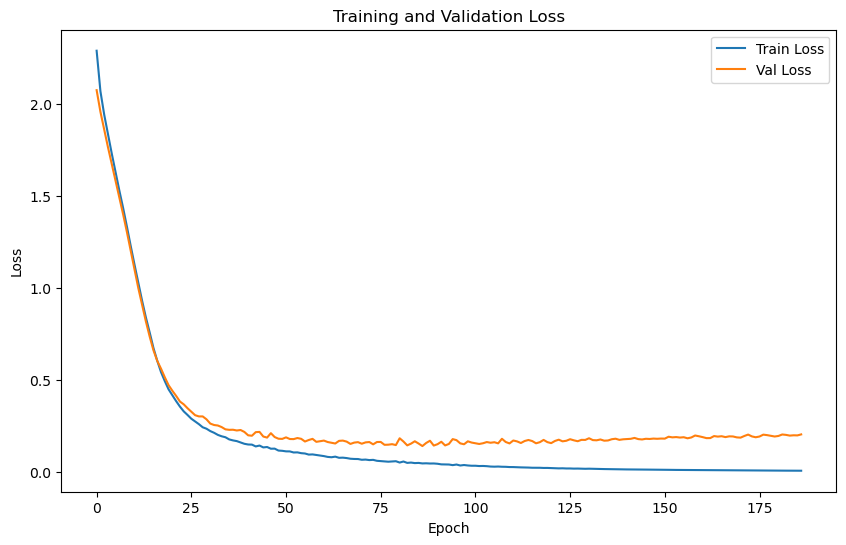

In [30]:
cae_mlp_input_dim = cae_mlp_train_reps.shape[1]
cae_mlp_num_classes = len(torch.unique(cae_mlp_train_labels_torch))
cae_mlp_model = MLPClassifier(cae_mlp_input_dim, cae_mlp_num_classes).to(device)

cae_mlp_criterion = nn.CrossEntropyLoss()
cae_mlp_optimizer = optim.Adam(cae_mlp_model.parameters(), lr=1e-3)

cae_mlp_num_epochs = 1000
cae_mlp_patience = 100

cae_mlp_train_losses = []
cae_mlp_val_losses = []

cae_mlp_best_val_loss = float('inf')
cae_mlp_epochs_without_improvement = 0

for cae_mlp_epoch in range(cae_mlp_num_epochs):
    # Training
    cae_mlp_model.train()
    cae_mlp_train_running_loss = 0.0
    
    for cae_mlp_embeddings_batch, cae_mlp_labels_batch in cae_mlp_train_loader:
        cae_mlp_embeddings_batch = cae_mlp_embeddings_batch.to(device)
        cae_mlp_labels_batch = cae_mlp_labels_batch.to(device)
        
        cae_mlp_optimizer.zero_grad()
        
        # Forward
        cae_mlp_outputs = cae_mlp_model(cae_mlp_embeddings_batch)
        cae_mlp_loss = cae_mlp_criterion(cae_mlp_outputs, cae_mlp_labels_batch)
        
        # Backward & Update
        cae_mlp_loss.backward()
        cae_mlp_optimizer.step()
        
        cae_mlp_train_running_loss += cae_mlp_loss.item() * cae_mlp_embeddings_batch.size(0)
    
    cae_mlp_epoch_train_loss = cae_mlp_train_running_loss / len(cae_mlp_train_loader.dataset)
    cae_mlp_train_losses.append(cae_mlp_epoch_train_loss)


    # Validation

    cae_mlp_model.eval()
    cae_mlp_val_running_loss = 0.0
    
    with torch.no_grad():
        for cae_mlp_val_embeddings_batch, cae_mlp_val_labels_batch in cae_mlp_val_loader:
            cae_mlp_val_embeddings_batch = cae_mlp_val_embeddings_batch.to(device)
            cae_mlp_val_labels_batch = cae_mlp_val_labels_batch.to(device)

            cae_mlp_val_outputs = cae_mlp_model(cae_mlp_val_embeddings_batch)
            cae_mlp_val_loss = cae_mlp_criterion(cae_mlp_val_outputs, cae_mlp_val_labels_batch)

            cae_mlp_val_running_loss += cae_mlp_val_loss.item() * cae_mlp_val_embeddings_batch.size(0)

    cae_mlp_epoch_val_loss = cae_mlp_val_running_loss / len(cae_mlp_val_loader.dataset)
    cae_mlp_val_losses.append(cae_mlp_epoch_val_loss)

    print(f"[Epoch {cae_mlp_epoch+1}/{cae_mlp_num_epochs}] "
          f"Train Loss: {cae_mlp_epoch_train_loss:.4f}  |  "
          f"Val Loss: {cae_mlp_epoch_val_loss:.4f}")

    # Early stopping

    if cae_mlp_epoch_val_loss < cae_mlp_best_val_loss:
        # improvement, reset patience
        print(f"Validation loss improved from {cae_mlp_best_val_loss:.4f} to {cae_mlp_epoch_val_loss:.4f}.")
        cae_mlp_best_val_loss = cae_mlp_epoch_val_loss
        cae_mlp_epochs_without_improvement = 0

    else:
        # no improvement
        cae_mlp_epochs_without_improvement += 1
        print(f"!! Validation loss did NOT improve !! "
              f"Patience: {cae_mlp_epochs_without_improvement}/{cae_mlp_patience}")
        
        if cae_mlp_epochs_without_improvement >= cae_mlp_patience:
            print(f"!! Early stopping triggered at epoch {cae_mlp_epoch+1} !!\n"
                  f"No improvement for {cae_mlp_patience} epochs.")
            break

plt.figure(figsize=(10,6))
plt.plot(cae_mlp_train_losses, label='Train Loss')
plt.plot(cae_mlp_val_losses,   label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


Saved CAE+MLP predictions and true labels to model_predictions
Test Loss: 0.2656 | Test Accuracy: 94.47%


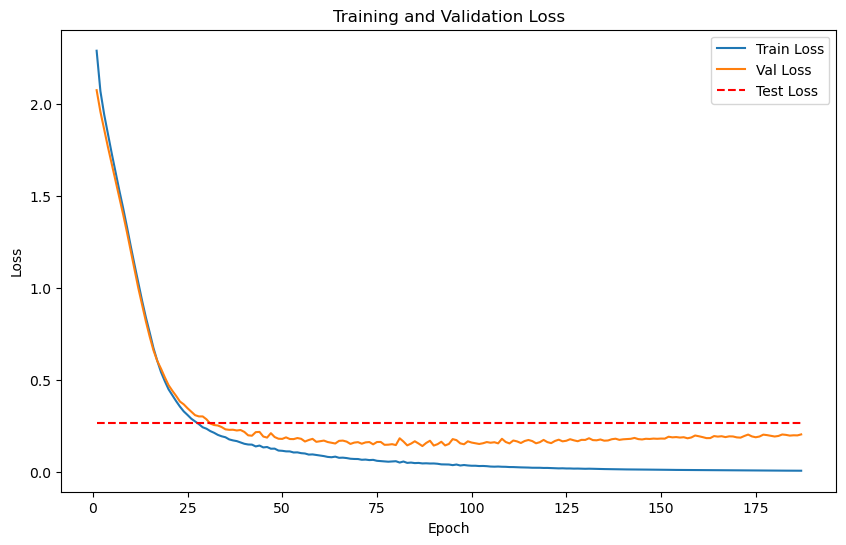

In [31]:
cae_mlp_model.eval()

cae_mlp_test_running_loss = 0.0
cae_mlp_test_correct = 0
cae_mlp_all_predictions = []
cae_mlp_all_true_labels = []

with torch.no_grad():
    for cae_mlp_test_embeddings_batch, cae_mlp_test_labels_batch in cae_mlp_test_loader:
        cae_mlp_test_embeddings_batch = cae_mlp_test_embeddings_batch.to(device)
        cae_mlp_test_labels_batch = cae_mlp_test_labels_batch.to(device)

        cae_mlp_test_outputs = cae_mlp_model(cae_mlp_test_embeddings_batch)
        
        cae_mlp_test_loss_batch = cae_mlp_criterion(cae_mlp_test_outputs, cae_mlp_test_labels_batch)
        cae_mlp_test_running_loss += cae_mlp_test_loss_batch.item() * cae_mlp_test_embeddings_batch.size(0)

        _, cae_mlp_test_predicted = torch.max(cae_mlp_test_outputs, dim=1)
        cae_mlp_test_correct += (cae_mlp_test_predicted == cae_mlp_test_labels_batch).sum().item()

        #saving predictions for conf matrix
        cae_mlp_all_predictions.extend(cae_mlp_test_predicted.cpu().numpy())
        cae_mlp_all_true_labels.extend(cae_mlp_test_labels_batch.cpu().numpy())

np.save(os.path.join(predictions_dir, 'cae_mlp_predictions.npy'), np.array(cae_mlp_all_predictions))
np.save(os.path.join(predictions_dir, 'cae_mlp_true_labels.npy'), np.array(cae_mlp_all_true_labels))
print(f"Saved CAE+MLP predictions and true labels to {predictions_dir}")

cae_mlp_epoch_test_loss = cae_mlp_test_running_loss / len(cae_mlp_test_loader.dataset)
cae_mlp_test_accuracy = cae_mlp_test_correct / len(cae_mlp_test_loader.dataset)

cae_mlp_test_accuracy_pct = cae_mlp_test_accuracy * 100.0

print(f"Test Loss: {cae_mlp_epoch_test_loss:.4f} | Test Accuracy: {cae_mlp_test_accuracy_pct:.2f}%")

cae_mlp_num_epochs_run = len(cae_mlp_train_losses)

plt.figure(figsize=(10,6))

plt.plot(range(1, cae_mlp_num_epochs_run + 1),
         cae_mlp_train_losses,
         label='Train Loss')
plt.plot(range(1, cae_mlp_num_epochs_run + 1),
         cae_mlp_val_losses,
         label='Val Loss')

plt.plot(range(1, cae_mlp_num_epochs_run + 1),
         [cae_mlp_epoch_test_loss]*cae_mlp_num_epochs_run,
         'r--',
         label='Test Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

## Typical SCL with Cosine Similarity (Supervised Contrastive Loss)

In [32]:
tscl_encoded_train_dir = os.path.join(encoded_dir, 'train')
tscl_encoded_val_dir = os.path.join(encoded_dir, 'val')
tscl_encoded_test_dir = os.path.join(encoded_dir, 'test')

tscl_train_embeddings, tscl_train_labels = load_encoded_data(tscl_encoded_train_dir)
tscl_val_embeddings, tscl_val_labels = load_encoded_data(tscl_encoded_val_dir)
tscl_test_embeddings, tscl_test_labels = load_encoded_data(tscl_encoded_test_dir)

#shape verification
print(f"\n\nTrain embeddings shape: {tscl_train_embeddings.shape}, \nTrain labels shape: {tscl_train_labels.shape}")
print(f"\n\nVal embeddings shape: {tscl_val_embeddings.shape}, \nVal labels shape: {tscl_val_labels.shape}")
print(f"\n\nTest embeddings shape: {tscl_test_embeddings.shape}, \nTest labels shape: {tscl_test_labels.shape}")

LOG: Loading encoded data (representations) from encoded_representations\train...
LOG: Loaded 180 samples with 64 features each
LOG: Labels shape: (180,)
LOG: Loading encoded data (representations) from encoded_representations\val...
LOG: Loaded 45 samples with 64 features each
LOG: Labels shape: (45,)
LOG: Loading encoded data (representations) from encoded_representations\test...


LOG: Loaded 147927 samples with 64 features each
LOG: Labels shape: (147927,)


Train embeddings shape: (180, 64), 
Train labels shape: (180,)


Val embeddings shape: (45, 64), 
Val labels shape: (45,)


Test embeddings shape: (147927, 64), 
Test labels shape: (147927,)


In [33]:
#flattening embeddings to (num_samples, 64)
tscl_train_embeddings = tscl_train_embeddings.reshape(tscl_train_embeddings.shape[0], -1)
tscl_val_embeddings = tscl_val_embeddings.reshape(tscl_val_embeddings.shape[0], -1)
tscl_test_embeddings = tscl_test_embeddings.reshape(tscl_test_embeddings.shape[0], -1)

#compute mean and std from training set
tscl_train_mean = np.mean(tscl_train_embeddings, axis=0)
tscl_train_std = np.std(tscl_train_embeddings, axis=0)

#normalize all datasets from above training mean and std
tscl_train_embeddings = (tscl_train_embeddings - tscl_train_mean) / tscl_train_std
tscl_val_embeddings = (tscl_val_embeddings - tscl_train_mean) / tscl_train_std
tscl_test_embeddings = (tscl_test_embeddings - tscl_train_mean) / tscl_train_std

tscl_train_dataset = TensorDataset(torch.tensor(tscl_train_embeddings, dtype=torch.float32), torch.tensor(tscl_train_labels, dtype=torch.long))
tscl_val_dataset = TensorDataset(torch.tensor(tscl_val_embeddings, dtype=torch.float32), torch.tensor(tscl_val_labels, dtype=torch.long))
tscl_test_dataset = TensorDataset(torch.tensor(tscl_test_embeddings, dtype=torch.float32), torch.tensor(tscl_test_labels, dtype=torch.long))

tscl_m = 20
tscl_num_classes = len(np.unique(tscl_train_labels))

# Calculate theoretical required batch size
tscl_required_batch_size = tscl_m * tscl_num_classes

# Ensure batch size doesn't exceed training set size
if tscl_required_batch_size > len(tscl_train_dataset):
    #case 1: Not enough samples - reduce m proportionally
    tscl_max_possible_m = len(tscl_train_dataset) // tscl_num_classes
    tscl_m = max(1, tscl_max_possible_m)  # Ensure m >= 1
    tscl_batch_size_train = tscl_m * tscl_num_classes
else:
    #case 2: Use full batch size
    tscl_batch_size_train = tscl_required_batch_size

tscl_sampler = MPerClassSampler(labels = tscl_train_labels, m = tscl_m, batch_size = tscl_batch_size_train, length_before_new_iter=len(tscl_train_dataset))
tscl_train_loader = DataLoader(tscl_train_dataset, batch_size=tscl_batch_size_train, sampler=tscl_sampler)

#creating dataloaders for scl
tscl_dataloader_bs = 256
tscl_val_loader = DataLoader(tscl_val_dataset, batch_size=tscl_dataloader_bs, shuffle=False)
tscl_test_loader = DataLoader(tscl_test_dataset, batch_size=tscl_dataloader_bs, shuffle=False)

for tscl_X_batch, tscl_y_batch in tscl_train_loader:
    tscl_unique, tscl_counts = np.unique(y_batch.numpy(), return_counts=True)
    print("Class distribution in batch:", dict(zip(tscl_unique, tscl_counts)))
    print(f"Training batch size: {tscl_batch_size_train}")
    break

Class distribution in batch: {0: 20, 1: 20, 2: 20, 3: 20, 4: 20, 5: 20, 6: 20, 7: 20, 8: 20}
Training batch size: 180


In [34]:
class SupConLoss(nn.Module):
    def __init__(self, temperature = 0.07):
        super(SupConLoss, self).__init__()
        self.temperature = temperature

    def forward(self, features, labels):
        #normalize feat vectors
        features = F.normalize(features, p=2, dim = 1)

        #compute cosine simi matrix
        similarity_matrix = torch.matmul(features, features.T) / self.temperature

        #create a mask for +ve pairs - i.e. same class
        labels = labels.unsqueeze(1)
        mask = torch.eq(labels, labels.T).float().to(features.device)

        #loss computation
        exp_sim = torch.exp(similarity_matrix)
        log_prob = similarity_matrix - torch.log(exp_sim.sum(dim = 1, keepdim=True))

        #mask out diagonal - i.e. self similarity
        mask_self = torch.eye(mask.shape[0], dtype = torch.bool).to(features.device)
        mask = mask * (~mask_self)

        #handling edge cases when there is no +ve pair
        mask_pos_pairs = mask.sum(dim=1)
        mask_pos_pairs = torch.where(mask_pos_pairs < 1e-6, 1, mask_pos_pairs)

        loss = -(mask * log_prob).sum(dim=1) / mask_pos_pairs

        return loss.mean() 

In [35]:
class SupConNet(nn.Module):
    def __init__(self, feature_dim=128):
        super(SupConNet, self).__init__()

        self.projection_head = nn.Sequential(
            nn.Linear(64, 128), #expects input of shape (batch_size, 64)
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, feature_dim)
        )

    def forward(self, x):
        #flattening input tensor
        #x = x.view(x.size(0), -1)  #reshaping -> (batch_size, channels * height * width)
        projections = self.projection_head(x)
        return projections


LOG: Epoch [1/2000] - Training


    Batch [1/1], Train Loss: 8.4525
Epoch [1/2000], Avg Train Loss: 8.4525
Epoch [1/2000], Avg Val Loss: 3.9743
Validation loss improved from inf to 3.9743. Saving model...

LOG: Epoch [2/2000] - Training
    Batch [1/1], Train Loss: 8.4462
Epoch [2/2000], Avg Train Loss: 8.4462
Epoch [2/2000], Avg Val Loss: 3.9276
Validation loss improved from 3.9743 to 3.9276. Saving model...

LOG: Epoch [3/2000] - Training
    Batch [1/1], Train Loss: 8.4136
Epoch [3/2000], Avg Train Loss: 8.4136
Epoch [3/2000], Avg Val Loss: 3.8821
Validation loss improved from 3.9276 to 3.8821. Saving model...

LOG: Epoch [4/2000] - Training
    Batch [1/1], Train Loss: 8.0573
Epoch [4/2000], Avg Train Loss: 8.0573
Epoch [4/2000], Avg Val Loss: 3.8380
Validation loss improved from 3.8821 to 3.8380. Saving model...

LOG: Epoch [5/2000] - Training
    Batch [1/1], Train Loss: 8.2444
Epoch [5/2000], Avg Train Loss: 8.2444
Epoch [5/2000], Avg Val Loss: 3.7949
Validation loss improved from 3.8380 to 3.7949. Saving mode

    Batch [1/1], Train Loss: 7.8630
Epoch [10/2000], Avg Train Loss: 7.8630
Epoch [10/2000], Avg Val Loss: 3.5983
Validation loss improved from 3.6353 to 3.5983. Saving model...

LOG: Epoch [11/2000] - Training
    Batch [1/1], Train Loss: 7.8935
Epoch [11/2000], Avg Train Loss: 7.8935
Epoch [11/2000], Avg Val Loss: 3.5622
Validation loss improved from 3.5983 to 3.5622. Saving model...

LOG: Epoch [12/2000] - Training
    Batch [1/1], Train Loss: 7.8005
Epoch [12/2000], Avg Train Loss: 7.8005
Epoch [12/2000], Avg Val Loss: 3.5272
Validation loss improved from 3.5622 to 3.5272. Saving model...

LOG: Epoch [13/2000] - Training
    Batch [1/1], Train Loss: 7.7057
Epoch [13/2000], Avg Train Loss: 7.7057
Epoch [13/2000], Avg Val Loss: 3.4931
Validation loss improved from 3.5272 to 3.4931. Saving model...

LOG: Epoch [14/2000] - Training
    Batch [1/1], Train Loss: 7.5062
Epoch [14/2000], Avg Train Loss: 7.5062
Epoch [14/2000], Avg Val Loss: 3.4601
Validation loss improved from 3.4931 to 3.

Epoch [42/2000], Avg Val Loss: 2.8676
Validation loss improved from 2.8799 to 2.8676. Saving model...

LOG: Epoch [43/2000] - Training
    Batch [1/1], Train Loss: 5.9161
Epoch [43/2000], Avg Train Loss: 5.9161
Epoch [43/2000], Avg Val Loss: 2.8559
Validation loss improved from 2.8676 to 2.8559. Saving model...

LOG: Epoch [44/2000] - Training
    Batch [1/1], Train Loss: 5.9900
Epoch [44/2000], Avg Train Loss: 5.9900
Epoch [44/2000], Avg Val Loss: 2.8446
Validation loss improved from 2.8559 to 2.8446. Saving model...

LOG: Epoch [45/2000] - Training
    Batch [1/1], Train Loss: 5.8544
Epoch [45/2000], Avg Train Loss: 5.8544
Epoch [45/2000], Avg Val Loss: 2.8337
Validation loss improved from 2.8446 to 2.8337. Saving model...

LOG: Epoch [46/2000] - Training
    Batch [1/1], Train Loss: 5.7779
Epoch [46/2000], Avg Train Loss: 5.7779
Epoch [46/2000], Avg Val Loss: 2.8234
Validation loss improved from 2.8337 to 2.8234. Saving model...

LOG: Epoch [47/2000] - Training
    Batch [1/1], Trai

    Batch [1/1], Train Loss: 5.7297
Epoch [49/2000], Avg Train Loss: 5.7297
Epoch [49/2000], Avg Val Loss: 2.7946
Validation loss improved from 2.8038 to 2.7946. Saving model...

LOG: Epoch [50/2000] - Training
    Batch [1/1], Train Loss: 5.6556
Epoch [50/2000], Avg Train Loss: 5.6556
Epoch [50/2000], Avg Val Loss: 2.7857
Validation loss improved from 2.7946 to 2.7857. Saving model...

LOG: Epoch [51/2000] - Training
    Batch [1/1], Train Loss: 5.6376
Epoch [51/2000], Avg Train Loss: 5.6376
Epoch [51/2000], Avg Val Loss: 2.7771
Validation loss improved from 2.7857 to 2.7771. Saving model...

LOG: Epoch [52/2000] - Training
    Batch [1/1], Train Loss: 5.6593
Epoch [52/2000], Avg Train Loss: 5.6593
Epoch [52/2000], Avg Val Loss: 2.7689
Validation loss improved from 2.7771 to 2.7689. Saving model...

LOG: Epoch [53/2000] - Training
    Batch [1/1], Train Loss: 5.6026
Epoch [53/2000], Avg Train Loss: 5.6026
Epoch [53/2000], Avg Val Loss: 2.7610
Validation loss improved from 2.7689 to 2.

    Batch [1/1], Train Loss: 4.9048
Epoch [87/2000], Avg Train Loss: 4.9048
Epoch [87/2000], Avg Val Loss: 2.6135
Validation loss improved from 2.6158 to 2.6135. Saving model...

LOG: Epoch [88/2000] - Training
    Batch [1/1], Train Loss: 4.8067
Epoch [88/2000], Avg Train Loss: 4.8067
Epoch [88/2000], Avg Val Loss: 2.6113
Validation loss improved from 2.6135 to 2.6113. Saving model...

LOG: Epoch [89/2000] - Training
    Batch [1/1], Train Loss: 4.8552
Epoch [89/2000], Avg Train Loss: 4.8552
Epoch [89/2000], Avg Val Loss: 2.6091
Validation loss improved from 2.6113 to 2.6091. Saving model...

LOG: Epoch [90/2000] - Training
    Batch [1/1], Train Loss: 4.8465
Epoch [90/2000], Avg Train Loss: 4.8465
Epoch [90/2000], Avg Val Loss: 2.6069
Validation loss improved from 2.6091 to 2.6069. Saving model...

LOG: Epoch [91/2000] - Training
    Batch [1/1], Train Loss: 4.7292
Epoch [91/2000], Avg Train Loss: 4.7292
Epoch [91/2000], Avg Val Loss: 2.6049
Validation loss improved from 2.6069 to 2.

    Batch [1/1], Train Loss: 4.4393
Epoch [131/2000], Avg Train Loss: 4.4393
Epoch [131/2000], Avg Val Loss: 2.5414
Validation loss improved from 2.5428 to 2.5414. Saving model...

LOG: Epoch [132/2000] - Training
    Batch [1/1], Train Loss: 4.4664
Epoch [132/2000], Avg Train Loss: 4.4664
Epoch [132/2000], Avg Val Loss: 2.5399
Validation loss improved from 2.5414 to 2.5399. Saving model...

LOG: Epoch [133/2000] - Training
    Batch [1/1], Train Loss: 4.4455
Epoch [133/2000], Avg Train Loss: 4.4455
Epoch [133/2000], Avg Val Loss: 2.5385
Validation loss improved from 2.5399 to 2.5385. Saving model...

LOG: Epoch [134/2000] - Training
    Batch [1/1], Train Loss: 4.4518
Epoch [134/2000], Avg Train Loss: 4.4518
Epoch [134/2000], Avg Val Loss: 2.5371
Validation loss improved from 2.5385 to 2.5371. Saving model...

LOG: Epoch [135/2000] - Training
    Batch [1/1], Train Loss: 4.4048
Epoch [135/2000], Avg Train Loss: 4.4048
Epoch [135/2000], Avg Val Loss: 2.5357
Validation loss improved fro

    Batch [1/1], Train Loss: 4.2971
Epoch [177/2000], Avg Train Loss: 4.2971
Epoch [177/2000], Avg Val Loss: 2.4827
Validation loss improved from 2.4839 to 2.4827. Saving model...

LOG: Epoch [178/2000] - Training
    Batch [1/1], Train Loss: 4.2384
Epoch [178/2000], Avg Train Loss: 4.2384
Epoch [178/2000], Avg Val Loss: 2.4815
Validation loss improved from 2.4827 to 2.4815. Saving model...

LOG: Epoch [179/2000] - Training
    Batch [1/1], Train Loss: 4.3117
Epoch [179/2000], Avg Train Loss: 4.3117
Epoch [179/2000], Avg Val Loss: 2.4803
Validation loss improved from 2.4815 to 2.4803. Saving model...

LOG: Epoch [180/2000] - Training
    Batch [1/1], Train Loss: 4.2666
Epoch [180/2000], Avg Train Loss: 4.2666
Epoch [180/2000], Avg Val Loss: 2.4791
Validation loss improved from 2.4803 to 2.4791. Saving model...

LOG: Epoch [181/2000] - Training
    Batch [1/1], Train Loss: 4.2416
Epoch [181/2000], Avg Train Loss: 4.2416
Epoch [181/2000], Avg Val Loss: 2.4780
Validation loss improved fro

    Batch [1/1], Train Loss: 4.1410
Epoch [225/2000], Avg Train Loss: 4.1410
Epoch [225/2000], Avg Val Loss: 2.4282
Validation loss improved from 2.4292 to 2.4282. Saving model...

LOG: Epoch [226/2000] - Training
    Batch [1/1], Train Loss: 4.1477
Epoch [226/2000], Avg Train Loss: 4.1477
Epoch [226/2000], Avg Val Loss: 2.4271
Validation loss improved from 2.4282 to 2.4271. Saving model...

LOG: Epoch [227/2000] - Training
    Batch [1/1], Train Loss: 4.1465
Epoch [227/2000], Avg Train Loss: 4.1465
Epoch [227/2000], Avg Val Loss: 2.4261
Validation loss improved from 2.4271 to 2.4261. Saving model...

LOG: Epoch [228/2000] - Training
    Batch [1/1], Train Loss: 4.1259
Epoch [228/2000], Avg Train Loss: 4.1259
Epoch [228/2000], Avg Val Loss: 2.4251
Validation loss improved from 2.4261 to 2.4251. Saving model...

LOG: Epoch [229/2000] - Training
    Batch [1/1], Train Loss: 4.1022
Epoch [229/2000], Avg Train Loss: 4.1022
Epoch [229/2000], Avg Val Loss: 2.4241
Validation loss improved fro

    Batch [1/1], Train Loss: 3.9867
Epoch [270/2000], Avg Train Loss: 3.9867
Epoch [270/2000], Avg Val Loss: 2.3853
Validation loss improved from 2.3862 to 2.3853. Saving model...

LOG: Epoch [271/2000] - Training
    Batch [1/1], Train Loss: 4.0643
Epoch [271/2000], Avg Train Loss: 4.0643
Epoch [271/2000], Avg Val Loss: 2.3844
Validation loss improved from 2.3853 to 2.3844. Saving model...

LOG: Epoch [272/2000] - Training
    Batch [1/1], Train Loss: 3.9924
Epoch [272/2000], Avg Train Loss: 3.9924
Epoch [272/2000], Avg Val Loss: 2.3835
Validation loss improved from 2.3844 to 2.3835. Saving model...

LOG: Epoch [273/2000] - Training
    Batch [1/1], Train Loss: 4.0265
Epoch [273/2000], Avg Train Loss: 4.0265
Epoch [273/2000], Avg Val Loss: 2.3825
Validation loss improved from 2.3835 to 2.3825. Saving model...

LOG: Epoch [274/2000] - Training
    Batch [1/1], Train Loss: 4.0137
Epoch [274/2000], Avg Train Loss: 4.0137
Epoch [274/2000], Avg Val Loss: 2.3816
Validation loss improved fro

Epoch [309/2000], Avg Val Loss: 2.3533
Validation loss improved from 2.3540 to 2.3533. Saving model...

LOG: Epoch [310/2000] - Training
    Batch [1/1], Train Loss: 3.9488
Epoch [310/2000], Avg Train Loss: 3.9488
Epoch [310/2000], Avg Val Loss: 2.3526
Validation loss improved from 2.3533 to 2.3526. Saving model...

LOG: Epoch [311/2000] - Training
    Batch [1/1], Train Loss: 3.9363
Epoch [311/2000], Avg Train Loss: 3.9363
Epoch [311/2000], Avg Val Loss: 2.3519
Validation loss improved from 2.3526 to 2.3519. Saving model...

LOG: Epoch [312/2000] - Training
    Batch [1/1], Train Loss: 3.9353
Epoch [312/2000], Avg Train Loss: 3.9353
Epoch [312/2000], Avg Val Loss: 2.3511
Validation loss improved from 2.3519 to 2.3511. Saving model...

LOG: Epoch [313/2000] - Training
    Batch [1/1], Train Loss: 3.9874
Epoch [313/2000], Avg Train Loss: 3.9874
Epoch [313/2000], Avg Val Loss: 2.3504
Validation loss improved from 2.3511 to 2.3504. Saving model...

LOG: Epoch [314/2000] - Training
    Bat

    Batch [1/1], Train Loss: 3.9134
Epoch [352/2000], Avg Train Loss: 3.9134
Epoch [352/2000], Avg Val Loss: 2.3233
Validation loss improved from 2.3240 to 2.3233. Saving model...

LOG: Epoch [353/2000] - Training
    Batch [1/1], Train Loss: 3.8799
Epoch [353/2000], Avg Train Loss: 3.8799
Epoch [353/2000], Avg Val Loss: 2.3227
Validation loss improved from 2.3233 to 2.3227. Saving model...

LOG: Epoch [354/2000] - Training
    Batch [1/1], Train Loss: 3.8997
Epoch [354/2000], Avg Train Loss: 3.8997
Epoch [354/2000], Avg Val Loss: 2.3221
Validation loss improved from 2.3227 to 2.3221. Saving model...

LOG: Epoch [355/2000] - Training
    Batch [1/1], Train Loss: 3.8659
Epoch [355/2000], Avg Train Loss: 3.8659
Epoch [355/2000], Avg Val Loss: 2.3215
Validation loss improved from 2.3221 to 2.3215. Saving model...

LOG: Epoch [356/2000] - Training
    Batch [1/1], Train Loss: 3.8705
Epoch [356/2000], Avg Train Loss: 3.8705
Epoch [356/2000], Avg Val Loss: 2.3208
Validation loss improved fro

    Batch [1/1], Train Loss: 3.8134
Epoch [395/2000], Avg Train Loss: 3.8134
Epoch [395/2000], Avg Val Loss: 2.2987
Validation loss improved from 2.2992 to 2.2987. Saving model...

LOG: Epoch [396/2000] - Training
    Batch [1/1], Train Loss: 3.8274
Epoch [396/2000], Avg Train Loss: 3.8274
Epoch [396/2000], Avg Val Loss: 2.2981
Validation loss improved from 2.2987 to 2.2981. Saving model...

LOG: Epoch [397/2000] - Training
    Batch [1/1], Train Loss: 3.8520
Epoch [397/2000], Avg Train Loss: 3.8520
Epoch [397/2000], Avg Val Loss: 2.2976
Validation loss improved from 2.2981 to 2.2976. Saving model...

LOG: Epoch [398/2000] - Training
    Batch [1/1], Train Loss: 3.8493
Epoch [398/2000], Avg Train Loss: 3.8493
Epoch [398/2000], Avg Val Loss: 2.2971
Validation loss improved from 2.2976 to 2.2971. Saving model...

LOG: Epoch [399/2000] - Training
    Batch [1/1], Train Loss: 3.8378
Epoch [399/2000], Avg Train Loss: 3.8378
Epoch [399/2000], Avg Val Loss: 2.2965
Validation loss improved fro

    Batch [1/1], Train Loss: 3.8145
Epoch [439/2000], Avg Train Loss: 3.8145
Epoch [439/2000], Avg Val Loss: 2.2773
Validation loss improved from 2.2778 to 2.2773. Saving model...

LOG: Epoch [440/2000] - Training
    Batch [1/1], Train Loss: 3.7952
Epoch [440/2000], Avg Train Loss: 3.7952
Epoch [440/2000], Avg Val Loss: 2.2768
Validation loss improved from 2.2773 to 2.2768. Saving model...

LOG: Epoch [441/2000] - Training
    Batch [1/1], Train Loss: 3.8174
Epoch [441/2000], Avg Train Loss: 3.8174
Epoch [441/2000], Avg Val Loss: 2.2764
Validation loss improved from 2.2768 to 2.2764. Saving model...

LOG: Epoch [442/2000] - Training
    Batch [1/1], Train Loss: 3.8076
Epoch [442/2000], Avg Train Loss: 3.8076
Epoch [442/2000], Avg Val Loss: 2.2759
Validation loss improved from 2.2764 to 2.2759. Saving model...

LOG: Epoch [443/2000] - Training
    Batch [1/1], Train Loss: 3.7381
Epoch [443/2000], Avg Train Loss: 3.7381
Epoch [443/2000], Avg Val Loss: 2.2754
Validation loss improved fro

    Batch [1/1], Train Loss: 3.7729
Epoch [482/2000], Avg Train Loss: 3.7729
Epoch [482/2000], Avg Val Loss: 2.2595
Validation loss improved from 2.2598 to 2.2595. Saving model...

LOG: Epoch [483/2000] - Training
    Batch [1/1], Train Loss: 3.7631
Epoch [483/2000], Avg Train Loss: 3.7631
Epoch [483/2000], Avg Val Loss: 2.2591
Validation loss improved from 2.2595 to 2.2591. Saving model...

LOG: Epoch [484/2000] - Training
    Batch [1/1], Train Loss: 3.7498
Epoch [484/2000], Avg Train Loss: 3.7498
Epoch [484/2000], Avg Val Loss: 2.2586
Validation loss improved from 2.2591 to 2.2586. Saving model...

LOG: Epoch [485/2000] - Training
    Batch [1/1], Train Loss: 3.7273
Epoch [485/2000], Avg Train Loss: 3.7273
Epoch [485/2000], Avg Val Loss: 2.2582
Validation loss improved from 2.2586 to 2.2582. Saving model...

LOG: Epoch [486/2000] - Training
    Batch [1/1], Train Loss: 3.7021
Epoch [486/2000], Avg Train Loss: 3.7021
Epoch [486/2000], Avg Val Loss: 2.2578
Validation loss improved fro

Epoch [523/2000], Avg Val Loss: 2.2443
Validation loss improved from 2.2447 to 2.2443. Saving model...

LOG: Epoch [524/2000] - Training
    Batch [1/1], Train Loss: 3.7229
Epoch [524/2000], Avg Train Loss: 3.7229
Epoch [524/2000], Avg Val Loss: 2.2440
Validation loss improved from 2.2443 to 2.2440. Saving model...

LOG: Epoch [525/2000] - Training
    Batch [1/1], Train Loss: 3.7298
Epoch [525/2000], Avg Train Loss: 3.7298
Epoch [525/2000], Avg Val Loss: 2.2436
Validation loss improved from 2.2440 to 2.2436. Saving model...

LOG: Epoch [526/2000] - Training
    Batch [1/1], Train Loss: 3.7410
Epoch [526/2000], Avg Train Loss: 3.7410
Epoch [526/2000], Avg Val Loss: 2.2433
Validation loss improved from 2.2436 to 2.2433. Saving model...

LOG: Epoch [527/2000] - Training
    Batch [1/1], Train Loss: 3.7029
Epoch [527/2000], Avg Train Loss: 3.7029
Epoch [527/2000], Avg Val Loss: 2.2429
Validation loss improved from 2.2433 to 2.2429. Saving model...

LOG: Epoch [528/2000] - Training
    Bat

    Batch [1/1], Train Loss: 3.6920
Epoch [565/2000], Avg Train Loss: 3.6920
Epoch [565/2000], Avg Val Loss: 2.2289
Validation loss improved from 2.2292 to 2.2289. Saving model...

LOG: Epoch [566/2000] - Training
    Batch [1/1], Train Loss: 3.6224
Epoch [566/2000], Avg Train Loss: 3.6224
Epoch [566/2000], Avg Val Loss: 2.2285
Validation loss improved from 2.2289 to 2.2285. Saving model...

LOG: Epoch [567/2000] - Training
    Batch [1/1], Train Loss: 3.6865
Epoch [567/2000], Avg Train Loss: 3.6865
Epoch [567/2000], Avg Val Loss: 2.2282
Validation loss improved from 2.2285 to 2.2282. Saving model...

LOG: Epoch [568/2000] - Training
    Batch [1/1], Train Loss: 3.6820
Epoch [568/2000], Avg Train Loss: 3.6820
Epoch [568/2000], Avg Val Loss: 2.2279
Validation loss improved from 2.2282 to 2.2279. Saving model...

LOG: Epoch [569/2000] - Training
    Batch [1/1], Train Loss: 3.6690
Epoch [569/2000], Avg Train Loss: 3.6690
Epoch [569/2000], Avg Val Loss: 2.2275
Validation loss improved fro

    Batch [1/1], Train Loss: 3.7118
Epoch [608/2000], Avg Train Loss: 3.7118
Epoch [608/2000], Avg Val Loss: 2.2155
Validation loss improved from 2.2157 to 2.2155. Saving model...

LOG: Epoch [609/2000] - Training
    Batch [1/1], Train Loss: 3.6705
Epoch [609/2000], Avg Train Loss: 3.6705
Epoch [609/2000], Avg Val Loss: 2.2152
Validation loss improved from 2.2155 to 2.2152. Saving model...

LOG: Epoch [610/2000] - Training
    Batch [1/1], Train Loss: 3.6663
Epoch [610/2000], Avg Train Loss: 3.6663
Epoch [610/2000], Avg Val Loss: 2.2149
Validation loss improved from 2.2152 to 2.2149. Saving model...

LOG: Epoch [611/2000] - Training
    Batch [1/1], Train Loss: 3.6384
Epoch [611/2000], Avg Train Loss: 3.6384
Epoch [611/2000], Avg Val Loss: 2.2146
Validation loss improved from 2.2149 to 2.2146. Saving model...

LOG: Epoch [612/2000] - Training
    Batch [1/1], Train Loss: 3.7002
Epoch [612/2000], Avg Train Loss: 3.7002
Epoch [612/2000], Avg Val Loss: 2.2143
Validation loss improved fro

Epoch [631/2000], Avg Val Loss: 2.2084
Validation loss improved from 2.2087 to 2.2084. Saving model...

LOG: Epoch [632/2000] - Training
    Batch [1/1], Train Loss: 3.6435
Epoch [632/2000], Avg Train Loss: 3.6435
Epoch [632/2000], Avg Val Loss: 2.2081
Validation loss improved from 2.2084 to 2.2081. Saving model...

LOG: Epoch [633/2000] - Training
    Batch [1/1], Train Loss: 3.6354
Epoch [633/2000], Avg Train Loss: 3.6354
Epoch [633/2000], Avg Val Loss: 2.2077
Validation loss improved from 2.2081 to 2.2077. Saving model...

LOG: Epoch [634/2000] - Training
    Batch [1/1], Train Loss: 3.6397
Epoch [634/2000], Avg Train Loss: 3.6397
Epoch [634/2000], Avg Val Loss: 2.2074
Validation loss improved from 2.2077 to 2.2074. Saving model...

LOG: Epoch [635/2000] - Training
    Batch [1/1], Train Loss: 3.6111
Epoch [635/2000], Avg Train Loss: 3.6111
Epoch [635/2000], Avg Val Loss: 2.2071
Validation loss improved from 2.2074 to 2.2071. Saving model...

LOG: Epoch [636/2000] - Training
    Bat

Epoch [672/2000], Avg Val Loss: 2.1962
Validation loss improved from 2.1965 to 2.1962. Saving model...

LOG: Epoch [673/2000] - Training
    Batch [1/1], Train Loss: 3.6197
Epoch [673/2000], Avg Train Loss: 3.6197
Epoch [673/2000], Avg Val Loss: 2.1960
Validation loss improved from 2.1962 to 2.1960. Saving model...

LOG: Epoch [674/2000] - Training
    Batch [1/1], Train Loss: 3.6027
Epoch [674/2000], Avg Train Loss: 3.6027
Epoch [674/2000], Avg Val Loss: 2.1957
Validation loss improved from 2.1960 to 2.1957. Saving model...

LOG: Epoch [675/2000] - Training
    Batch [1/1], Train Loss: 3.6030
Epoch [675/2000], Avg Train Loss: 3.6030
Epoch [675/2000], Avg Val Loss: 2.1954
Validation loss improved from 2.1957 to 2.1954. Saving model...

LOG: Epoch [676/2000] - Training
    Batch [1/1], Train Loss: 3.6286
Epoch [676/2000], Avg Train Loss: 3.6286
Epoch [676/2000], Avg Val Loss: 2.1951
Validation loss improved from 2.1954 to 2.1951. Saving model...

LOG: Epoch [677/2000] - Training
    Bat

Epoch [718/2000], Avg Val Loss: 2.1835
Validation loss improved from 2.1838 to 2.1835. Saving model...

LOG: Epoch [719/2000] - Training
    Batch [1/1], Train Loss: 3.6228
Epoch [719/2000], Avg Train Loss: 3.6228
Epoch [719/2000], Avg Val Loss: 2.1833
Validation loss improved from 2.1835 to 2.1833. Saving model...

LOG: Epoch [720/2000] - Training
    Batch [1/1], Train Loss: 3.6084
Epoch [720/2000], Avg Train Loss: 3.6084
Epoch [720/2000], Avg Val Loss: 2.1831
Validation loss improved from 2.1833 to 2.1831. Saving model...

LOG: Epoch [721/2000] - Training
    Batch [1/1], Train Loss: 3.5892
Epoch [721/2000], Avg Train Loss: 3.5892
Epoch [721/2000], Avg Val Loss: 2.1828
Validation loss improved from 2.1831 to 2.1828. Saving model...

LOG: Epoch [722/2000] - Training
    Batch [1/1], Train Loss: 3.5952
Epoch [722/2000], Avg Train Loss: 3.5952
Epoch [722/2000], Avg Val Loss: 2.1826
Validation loss improved from 2.1828 to 2.1826. Saving model...

LOG: Epoch [723/2000] - Training
    Bat

    Batch [1/1], Train Loss: 3.5815
Epoch [761/2000], Avg Train Loss: 3.5815
Epoch [761/2000], Avg Val Loss: 2.1752
Validation loss improved from 2.1754 to 2.1752. Saving model...

LOG: Epoch [762/2000] - Training
    Batch [1/1], Train Loss: 3.5895
Epoch [762/2000], Avg Train Loss: 3.5895
Epoch [762/2000], Avg Val Loss: 2.1750
Validation loss improved from 2.1752 to 2.1750. Saving model...

LOG: Epoch [763/2000] - Training
    Batch [1/1], Train Loss: 3.5941
Epoch [763/2000], Avg Train Loss: 3.5941
Epoch [763/2000], Avg Val Loss: 2.1748
Validation loss improved from 2.1750 to 2.1748. Saving model...

LOG: Epoch [764/2000] - Training
    Batch [1/1], Train Loss: 3.5809
Epoch [764/2000], Avg Train Loss: 3.5809
Epoch [764/2000], Avg Val Loss: 2.1747
Validation loss improved from 2.1748 to 2.1747. Saving model...

LOG: Epoch [765/2000] - Training
    Batch [1/1], Train Loss: 3.5572
Epoch [765/2000], Avg Train Loss: 3.5572
Epoch [765/2000], Avg Val Loss: 2.1746
Validation loss improved fro

    Batch [1/1], Train Loss: 3.5498
Epoch [807/2000], Avg Train Loss: 3.5498
Epoch [807/2000], Avg Val Loss: 2.1648
Validation loss improved from 2.1651 to 2.1648. Saving model...

LOG: Epoch [808/2000] - Training
    Batch [1/1], Train Loss: 3.5754
Epoch [808/2000], Avg Train Loss: 3.5754
Epoch [808/2000], Avg Val Loss: 2.1646
Validation loss improved from 2.1648 to 2.1646. Saving model...

LOG: Epoch [809/2000] - Training
    Batch [1/1], Train Loss: 3.5296
Epoch [809/2000], Avg Train Loss: 3.5296
Epoch [809/2000], Avg Val Loss: 2.1644
Validation loss improved from 2.1646 to 2.1644. Saving model...

LOG: Epoch [810/2000] - Training
    Batch [1/1], Train Loss: 3.5469
Epoch [810/2000], Avg Train Loss: 3.5469
Epoch [810/2000], Avg Val Loss: 2.1641
Validation loss improved from 2.1644 to 2.1641. Saving model...

LOG: Epoch [811/2000] - Training
    Batch [1/1], Train Loss: 3.5710
Epoch [811/2000], Avg Train Loss: 3.5710
Epoch [811/2000], Avg Val Loss: 2.1639
Validation loss improved fro

    Batch [1/1], Train Loss: 3.5763
Epoch [846/2000], Avg Train Loss: 3.5763
Epoch [846/2000], Avg Val Loss: 2.1582
Validation loss improved from 2.1583 to 2.1582. Saving model...

LOG: Epoch [847/2000] - Training
    Batch [1/1], Train Loss: 3.5444
Epoch [847/2000], Avg Train Loss: 3.5444
Epoch [847/2000], Avg Val Loss: 2.1581
Validation loss improved from 2.1582 to 2.1581. Saving model...

LOG: Epoch [848/2000] - Training
    Batch [1/1], Train Loss: 3.5529
Epoch [848/2000], Avg Train Loss: 3.5529
Epoch [848/2000], Avg Val Loss: 2.1580
Validation loss improved from 2.1581 to 2.1580. Saving model...

LOG: Epoch [849/2000] - Training
    Batch [1/1], Train Loss: 3.5426
Epoch [849/2000], Avg Train Loss: 3.5426
Epoch [849/2000], Avg Val Loss: 2.1578
Validation loss improved from 2.1580 to 2.1578. Saving model...

LOG: Epoch [850/2000] - Training
    Batch [1/1], Train Loss: 3.5146
Epoch [850/2000], Avg Train Loss: 3.5146
Epoch [850/2000], Avg Val Loss: 2.1576
Validation loss improved fro

Epoch [888/2000], Avg Val Loss: 2.1516
Validation loss improved from 2.1518 to 2.1516. Saving model...

LOG: Epoch [889/2000] - Training
    Batch [1/1], Train Loss: 3.5089
Epoch [889/2000], Avg Train Loss: 3.5089
Epoch [889/2000], Avg Val Loss: 2.1515
Validation loss improved from 2.1516 to 2.1515. Saving model...

LOG: Epoch [890/2000] - Training
    Batch [1/1], Train Loss: 3.5268
Epoch [890/2000], Avg Train Loss: 3.5268
Epoch [890/2000], Avg Val Loss: 2.1512
Validation loss improved from 2.1515 to 2.1512. Saving model...

LOG: Epoch [891/2000] - Training
    Batch [1/1], Train Loss: 3.5096
Epoch [891/2000], Avg Train Loss: 3.5096
Epoch [891/2000], Avg Val Loss: 2.1510
Validation loss improved from 2.1512 to 2.1510. Saving model...

LOG: Epoch [892/2000] - Training
    Batch [1/1], Train Loss: 3.4863
Epoch [892/2000], Avg Train Loss: 3.4863
Epoch [892/2000], Avg Val Loss: 2.1507
Validation loss improved from 2.1510 to 2.1507. Saving model...

LOG: Epoch [893/2000] - Training
    Bat

    Batch [1/1], Train Loss: 3.5018
Epoch [930/2000], Avg Train Loss: 3.5018
Epoch [930/2000], Avg Val Loss: 2.1425
Validation loss improved from 2.1427 to 2.1425. Saving model...

LOG: Epoch [931/2000] - Training
    Batch [1/1], Train Loss: 3.4912
Epoch [931/2000], Avg Train Loss: 3.4912
Epoch [931/2000], Avg Val Loss: 2.1423
Validation loss improved from 2.1425 to 2.1423. Saving model...

LOG: Epoch [932/2000] - Training
    Batch [1/1], Train Loss: 3.4765
Epoch [932/2000], Avg Train Loss: 3.4765
Epoch [932/2000], Avg Val Loss: 2.1421
Validation loss improved from 2.1423 to 2.1421. Saving model...

LOG: Epoch [933/2000] - Training
    Batch [1/1], Train Loss: 3.5072
Epoch [933/2000], Avg Train Loss: 3.5072
Epoch [933/2000], Avg Val Loss: 2.1418
Validation loss improved from 2.1421 to 2.1418. Saving model...

LOG: Epoch [934/2000] - Training
    Batch [1/1], Train Loss: 3.4648
Epoch [934/2000], Avg Train Loss: 3.4648
Epoch [934/2000], Avg Val Loss: 2.1416
Validation loss improved fro

    Batch [1/1], Train Loss: 3.4997
Epoch [976/2000], Avg Train Loss: 3.4997
Epoch [976/2000], Avg Val Loss: 2.1360
Validation loss improved from 2.1361 to 2.1360. Saving model...

LOG: Epoch [977/2000] - Training
    Batch [1/1], Train Loss: 3.4987
Epoch [977/2000], Avg Train Loss: 3.4987
Epoch [977/2000], Avg Val Loss: 2.1359
Validation loss improved from 2.1360 to 2.1359. Saving model...

LOG: Epoch [978/2000] - Training
    Batch [1/1], Train Loss: 3.4871
Epoch [978/2000], Avg Train Loss: 3.4871
Epoch [978/2000], Avg Val Loss: 2.1358
Validation loss improved from 2.1359 to 2.1358. Saving model...

LOG: Epoch [979/2000] - Training
    Batch [1/1], Train Loss: 3.4925
Epoch [979/2000], Avg Train Loss: 3.4925
Epoch [979/2000], Avg Val Loss: 2.1357
Validation loss improved from 2.1358 to 2.1357. Saving model...

LOG: Epoch [980/2000] - Training
    Batch [1/1], Train Loss: 3.5075
Epoch [980/2000], Avg Train Loss: 3.5075
Epoch [980/2000], Avg Val Loss: 2.1355
Validation loss improved fro

    Batch [1/1], Train Loss: 3.5013
Epoch [1016/2000], Avg Train Loss: 3.5013
Epoch [1016/2000], Avg Val Loss: 2.1316
Validation loss improved from 2.1317 to 2.1316. Saving model...

LOG: Epoch [1017/2000] - Training
    Batch [1/1], Train Loss: 3.4880
Epoch [1017/2000], Avg Train Loss: 3.4880
Epoch [1017/2000], Avg Val Loss: 2.1314
Validation loss improved from 2.1316 to 2.1314. Saving model...

LOG: Epoch [1018/2000] - Training
    Batch [1/1], Train Loss: 3.4591
Epoch [1018/2000], Avg Train Loss: 3.4591
Epoch [1018/2000], Avg Val Loss: 2.1312
Validation loss improved from 2.1314 to 2.1312. Saving model...

LOG: Epoch [1019/2000] - Training
    Batch [1/1], Train Loss: 3.4578
Epoch [1019/2000], Avg Train Loss: 3.4578
Epoch [1019/2000], Avg Val Loss: 2.1311
Validation loss improved from 2.1312 to 2.1311. Saving model...

LOG: Epoch [1020/2000] - Training
    Batch [1/1], Train Loss: 3.4566
Epoch [1020/2000], Avg Train Loss: 3.4566
Epoch [1020/2000], Avg Val Loss: 2.1309
Validation los

    Batch [1/1], Train Loss: 3.4759
Epoch [1058/2000], Avg Train Loss: 3.4759
Epoch [1058/2000], Avg Val Loss: 2.1279
Validation loss improved from 2.1280 to 2.1279. Saving model...

LOG: Epoch [1059/2000] - Training
    Batch [1/1], Train Loss: 3.4363
Epoch [1059/2000], Avg Train Loss: 3.4363
Epoch [1059/2000], Avg Val Loss: 2.1277
Validation loss improved from 2.1279 to 2.1277. Saving model...

LOG: Epoch [1060/2000] - Training
    Batch [1/1], Train Loss: 3.4506
Epoch [1060/2000], Avg Train Loss: 3.4506
Epoch [1060/2000], Avg Val Loss: 2.1276
Validation loss improved from 2.1277 to 2.1276. Saving model...

LOG: Epoch [1061/2000] - Training
    Batch [1/1], Train Loss: 3.4304
Epoch [1061/2000], Avg Train Loss: 3.4304
Epoch [1061/2000], Avg Val Loss: 2.1275
Validation loss improved from 2.1276 to 2.1275. Saving model...

LOG: Epoch [1062/2000] - Training
    Batch [1/1], Train Loss: 3.4382
Epoch [1062/2000], Avg Train Loss: 3.4382
Epoch [1062/2000], Avg Val Loss: 2.1273
Validation los

    Batch [1/1], Train Loss: 3.4078
Epoch [1101/2000], Avg Train Loss: 3.4078
Epoch [1101/2000], Avg Val Loss: 2.1233
Validation loss improved from 2.1233 to 2.1233. Saving model...

LOG: Epoch [1102/2000] - Training
    Batch [1/1], Train Loss: 3.4249
Epoch [1102/2000], Avg Train Loss: 3.4249
Epoch [1102/2000], Avg Val Loss: 2.1233
Validation loss did not improve. Patience: 1/100

LOG: Epoch [1103/2000] - Training
    Batch [1/1], Train Loss: 3.4201
Epoch [1103/2000], Avg Train Loss: 3.4201
Epoch [1103/2000], Avg Val Loss: 2.1233
Validation loss did not improve. Patience: 2/100

LOG: Epoch [1104/2000] - Training
    Batch [1/1], Train Loss: 3.4493
Epoch [1104/2000], Avg Train Loss: 3.4493
Epoch [1104/2000], Avg Val Loss: 2.1233
Validation loss improved from 2.1233 to 2.1233. Saving model...

LOG: Epoch [1105/2000] - Training
    Batch [1/1], Train Loss: 3.4046
Epoch [1105/2000], Avg Train Loss: 3.4046
Epoch [1105/2000], Avg Val Loss: 2.1233
Validation loss improved from 2.1233 to 2.12

    Batch [1/1], Train Loss: 3.4576
Epoch [1142/2000], Avg Train Loss: 3.4576
Epoch [1142/2000], Avg Val Loss: 2.1192
Validation loss improved from 2.1192 to 2.1192. Saving model...

LOG: Epoch [1143/2000] - Training
    Batch [1/1], Train Loss: 3.4094
Epoch [1143/2000], Avg Train Loss: 3.4094
Epoch [1143/2000], Avg Val Loss: 2.1192
Validation loss improved from 2.1192 to 2.1192. Saving model...

LOG: Epoch [1144/2000] - Training
    Batch [1/1], Train Loss: 3.4225
Epoch [1144/2000], Avg Train Loss: 3.4225
Epoch [1144/2000], Avg Val Loss: 2.1192
Validation loss improved from 2.1192 to 2.1192. Saving model...

LOG: Epoch [1145/2000] - Training
    Batch [1/1], Train Loss: 3.4034
Epoch [1145/2000], Avg Train Loss: 3.4034
Epoch [1145/2000], Avg Val Loss: 2.1192
Validation loss improved from 2.1192 to 2.1192. Saving model...

LOG: Epoch [1146/2000] - Training
    Batch [1/1], Train Loss: 3.4305
Epoch [1146/2000], Avg Train Loss: 3.4305
Epoch [1146/2000], Avg Val Loss: 2.1192
Validation los

    Batch [1/1], Train Loss: 3.4403
Epoch [1187/2000], Avg Train Loss: 3.4403
Epoch [1187/2000], Avg Val Loss: 2.1165
Validation loss did not improve. Patience: 5/100

LOG: Epoch [1188/2000] - Training
    Batch [1/1], Train Loss: 3.4107
Epoch [1188/2000], Avg Train Loss: 3.4107
Epoch [1188/2000], Avg Val Loss: 2.1165
Validation loss did not improve. Patience: 6/100

LOG: Epoch [1189/2000] - Training
    Batch [1/1], Train Loss: 3.3913
Epoch [1189/2000], Avg Train Loss: 3.3913
Epoch [1189/2000], Avg Val Loss: 2.1165
Validation loss did not improve. Patience: 7/100

LOG: Epoch [1190/2000] - Training
    Batch [1/1], Train Loss: 3.3912
Epoch [1190/2000], Avg Train Loss: 3.3912
Epoch [1190/2000], Avg Val Loss: 2.1165
Validation loss did not improve. Patience: 8/100

LOG: Epoch [1191/2000] - Training
    Batch [1/1], Train Loss: 3.4130
Epoch [1191/2000], Avg Train Loss: 3.4130
Epoch [1191/2000], Avg Val Loss: 2.1164
Validation loss did not improve. Patience: 9/100

LOG: Epoch [1192/2000] -

Epoch [1230/2000], Avg Val Loss: 2.1183
Validation loss did not improve. Patience: 48/100

LOG: Epoch [1231/2000] - Training
    Batch [1/1], Train Loss: 3.3662
Epoch [1231/2000], Avg Train Loss: 3.3662
Epoch [1231/2000], Avg Val Loss: 2.1184
Validation loss did not improve. Patience: 49/100

LOG: Epoch [1232/2000] - Training
    Batch [1/1], Train Loss: 3.4115
Epoch [1232/2000], Avg Train Loss: 3.4115
Epoch [1232/2000], Avg Val Loss: 2.1186
Validation loss did not improve. Patience: 50/100

LOG: Epoch [1233/2000] - Training
    Batch [1/1], Train Loss: 3.4234
Epoch [1233/2000], Avg Train Loss: 3.4234
Epoch [1233/2000], Avg Val Loss: 2.1186
Validation loss did not improve. Patience: 51/100

LOG: Epoch [1234/2000] - Training
    Batch [1/1], Train Loss: 3.4261
Epoch [1234/2000], Avg Train Loss: 3.4261
Epoch [1234/2000], Avg Val Loss: 2.1187
Validation loss did not improve. Patience: 52/100

LOG: Epoch [1235/2000] - Training
    Batch [1/1], Train Loss: 3.3737
Epoch [1235/2000], Avg Trai

    Batch [1/1], Train Loss: 3.3650
Epoch [1273/2000], Avg Train Loss: 3.3650
Epoch [1273/2000], Avg Val Loss: 2.1193
Validation loss did not improve. Patience: 91/100

LOG: Epoch [1274/2000] - Training
    Batch [1/1], Train Loss: 3.3885
Epoch [1274/2000], Avg Train Loss: 3.3885
Epoch [1274/2000], Avg Val Loss: 2.1195
Validation loss did not improve. Patience: 92/100

LOG: Epoch [1275/2000] - Training
    Batch [1/1], Train Loss: 3.3892
Epoch [1275/2000], Avg Train Loss: 3.3892
Epoch [1275/2000], Avg Val Loss: 2.1196
Validation loss did not improve. Patience: 93/100

LOG: Epoch [1276/2000] - Training
    Batch [1/1], Train Loss: 3.3882
Epoch [1276/2000], Avg Train Loss: 3.3882
Epoch [1276/2000], Avg Val Loss: 2.1198
Validation loss did not improve. Patience: 94/100

LOG: Epoch [1277/2000] - Training
    Batch [1/1], Train Loss: 3.3798
Epoch [1277/2000], Avg Train Loss: 3.3798
Epoch [1277/2000], Avg Val Loss: 2.1200
Validation loss did not improve. Patience: 95/100

LOG: Epoch [1278/20

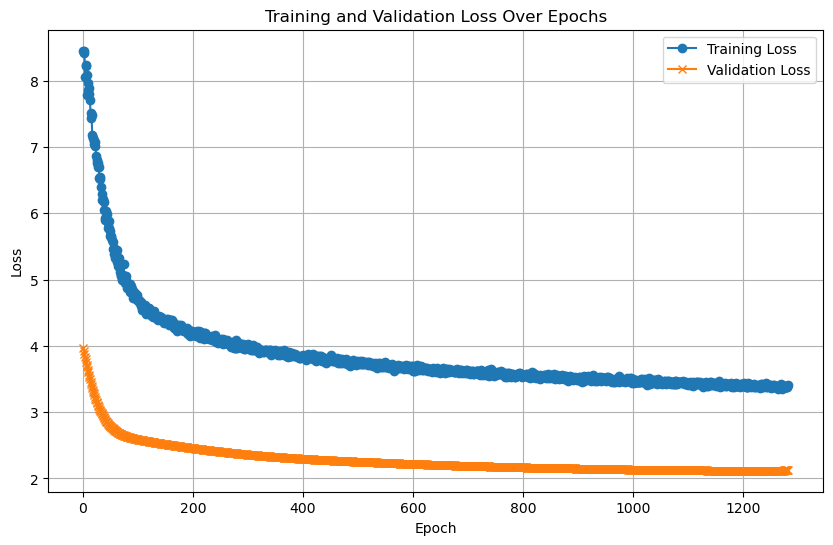

In [36]:
tscl_model = SupConNet().to(device)
tscl_criterion = SupConLoss(temperature=0.07).to(device)
tscl_optimizer = optim.Adam(tscl_model.parameters(), lr=1e-4, weight_decay=1e-5)  # Increased learning rate

tscl_patience = 100
tscl_best_val_loss = float('inf')
tscl_epochs_without_improvement = 0

tscl_num_epochs = 2000
tscl_train_losses = []
tscl_val_losses = []

# TRAINING
for tscl_epoch in range(tscl_num_epochs):
    print(f"\nLOG: Epoch [{tscl_epoch + 1}/{tscl_num_epochs}] - Training")
    tscl_model.train()
    tscl_total_loss = 0

    for batch_idx, (vectors, labels) in enumerate(tscl_train_loader):
        vectors = vectors.to(device).float()  # moving input tensors to GPU
        labels = labels.to(device)  # moving labels to GPU

        # forward pass to get projections
        projections = tscl_model(vectors)

        # calc contrastive loss
        loss = tscl_criterion(projections, labels)

        # backprop and optimization
        tscl_optimizer.zero_grad()
        loss.backward()
        tscl_optimizer.step()

        tscl_total_loss += loss.item()

        if (batch_idx + 1) % 1 == 0:
            print(f"    Batch [{batch_idx + 1}/{len(tscl_train_loader)}], "
                  f"Train Loss: {loss.item():.4f}")

    # calc avg training loss for the epoch
    tscl_avg_train_loss = tscl_total_loss / len(tscl_train_loader)
    tscl_train_losses.append(tscl_avg_train_loss)
    print(f"Epoch [{tscl_epoch + 1}/{tscl_num_epochs}], "
          f"Avg Train Loss: {tscl_avg_train_loss:.4f}")

    # VALIDATION
    tscl_model.eval()
    total_val_loss = 0.0

    with torch.no_grad():
        for batch_idx, (vectors, labels) in enumerate(tscl_val_loader):
            vectors = vectors.to(device).float()
            labels = labels.to(device)

            projections = tscl_model(vectors)

            loss = tscl_criterion(projections, labels)
            total_val_loss += loss.item()

            if (batch_idx + 1) % 10 == 0:
                print(f"    Batch [{batch_idx + 1}/{len(tscl_val_loader)}], "
                      f"Val Loss: {loss.item():.4f}")

    tscl_avg_val_loss = total_val_loss / len(tscl_val_loader)
    tscl_val_losses.append(tscl_avg_val_loss)
    print(f"Epoch [{tscl_epoch + 1}/{tscl_num_epochs}], "
          f"Avg Val Loss: {tscl_avg_val_loss:.4f}")

    # early stopping logic
    if tscl_avg_val_loss < tscl_best_val_loss:
        print(f"Validation loss improved from {tscl_best_val_loss:.4f} to {tscl_avg_val_loss:.4f}. Saving model...")
        tscl_best_val_loss = tscl_avg_val_loss
        tscl_epochs_without_improvement = 0
    else:
        tscl_epochs_without_improvement += 1
        print(f"Validation loss did not improve. Patience: {tscl_epochs_without_improvement}/{tscl_patience}")

    # stopping training if validation loss hasn't improved for patience amount of epochs
    if tscl_epochs_without_improvement >= tscl_patience:
        print(f"Early stopping triggered at epoch {tscl_epoch + 1}. No improvement for {tscl_patience} epochs.")
        break

plt.figure(figsize=(10, 6))
plt.plot(range(1, len(tscl_train_losses) + 1), tscl_train_losses, label="Training Loss", marker='o')
plt.plot(range(1, len(tscl_val_losses) + 1), tscl_val_losses, label="Validation Loss", marker='x')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.grid()
plt.show()

Test Batch [10/578], Loss: 4.9652
Test Batch [20/578], Loss: 4.9320
Test Batch [30/578], Loss: 4.9870
Test Batch [40/578], Loss: 4.9900


Test Batch [50/578], Loss: 4.9894
Test Batch [60/578], Loss: 4.9964
Test Batch [70/578], Loss: 5.0682
Test Batch [80/578], Loss: 4.8168
Test Batch [90/578], Loss: 4.8688
Test Batch [100/578], Loss: 4.7861
Test Batch [110/578], Loss: 4.8783
Test Batch [120/578], Loss: 4.8841
Test Batch [130/578], Loss: 4.8728
Test Batch [140/578], Loss: 4.8743


Test Batch [150/578], Loss: 4.8260
Test Batch [160/578], Loss: 4.8530
Test Batch [170/578], Loss: 4.7527
Test Batch [180/578], Loss: 4.6346
Test Batch [190/578], Loss: 4.9887


Test Batch [200/578], Loss: 4.9840
Test Batch [210/578], Loss: 4.8728
Test Batch [220/578], Loss: 5.0848
Test Batch [230/578], Loss: 4.9000
Test Batch [240/578], Loss: 5.0393
Test Batch [250/578], Loss: 4.8916
Test Batch [260/578], Loss: 4.9547
Test Batch [270/578], Loss: 5.0609
Test Batch [280/578], Loss: 4.6637
Test Batch [290/578], Loss: 5.1832
Test Batch [300/578], Loss: 5.3048


Test Batch [310/578], Loss: 5.3963
Test Batch [320/578], Loss: 5.1612
Test Batch [330/578], Loss: 5.3308
Test Batch [340/578], Loss: 5.5667
Test Batch [350/578], Loss: 5.3775


Test Batch [360/578], Loss: 5.4825
Test Batch [370/578], Loss: 5.7172
Test Batch [380/578], Loss: 4.8092
Test Batch [390/578], Loss: 4.8443
Test Batch [400/578], Loss: 4.9363
Test Batch [410/578], Loss: 5.1142
Test Batch [420/578], Loss: 4.8755
Test Batch [430/578], Loss: 5.1330
Test Batch [440/578], Loss: 5.0527
Test Batch [450/578], Loss: 5.1552


Test Batch [460/578], Loss: 5.6408
Test Batch [470/578], Loss: 5.2355
Test Batch [480/578], Loss: 4.7890
Test Batch [490/578], Loss: 5.2433
Test Batch [500/578], Loss: 5.3653


Test Batch [510/578], Loss: 5.6298
Test Batch [520/578], Loss: 5.1372
Test Batch [530/578], Loss: 5.0090
Test Batch [540/578], Loss: 4.7165
Test Batch [550/578], Loss: 4.7288
Test Batch [560/578], Loss: 4.7536
Test Batch [570/578], Loss: 4.7601

Test Loss: 5.0096


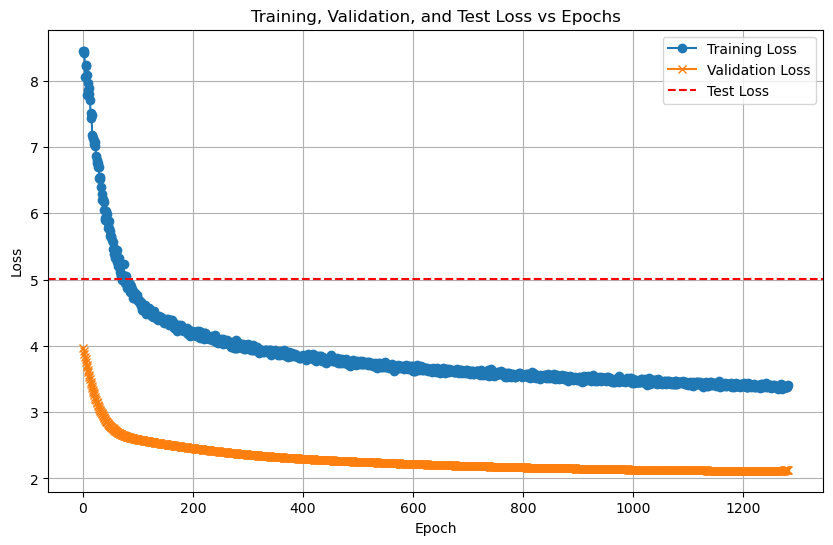

In [37]:
# Test Evaluation
tscl_model.eval()
total_test_loss = 0.0

with torch.no_grad():
    for batch_idx, (vectors, labels) in enumerate(tscl_test_loader):
        vectors = vectors.to(device).float()
        labels = labels.to(device)
        projections = tscl_model(vectors)
        loss = criterion(projections, labels)
        total_test_loss += loss.item()
        if (batch_idx + 1) % 10 == 0:
            print(f"Test Batch [{batch_idx + 1}/{len(tscl_test_loader)}], Loss: {loss.item():.4f}")

avg_test_loss = total_test_loss / len(tscl_test_loader)
print(f"\nTest Loss: {avg_test_loss:.4f}")


plt.figure(figsize=(10, 6))
epochs = range(1, len(tscl_train_losses) + 1)
plt.plot(epochs, tscl_train_losses, label="Training Loss", marker='o')
plt.plot(epochs, tscl_val_losses, label="Validation Loss", marker='x')
# test loss = horizontal dashed line
plt.axhline(y=avg_test_loss, color='r', linestyle='--', label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training, Validation, and Test Loss vs Epochs")
plt.legend()
plt.grid(True)
plt.show()

### Saving representations learnt by Typical SCL Model

In [38]:
# dir to save the SCL representations
tscl_rep_dir = "tscl_representations"
os.makedirs(tscl_rep_dir, exist_ok=True)

tscl_loaders = {
    'train': tscl_train_loader,
    'val': tscl_val_loader,
    'test': tscl_test_loader
}

tscl_model.eval()

with torch.no_grad():
    for tscl_split_name, tscl_loader in tscl_loaders.items():
        print(f"\nExtracting SCL representations for the {tscl_split_name} dataset...")
        # creating subfolder for the split
        tscl_split_dir = os.path.join(tscl_rep_dir, tscl_split_name)
        os.makedirs(tscl_split_dir, exist_ok=True)
        
        # processing the data batch-wise
        for tscl_batch_idx, (tscl_vectors, tscl_labels) in enumerate(tscl_loader):
            tscl_vectors = tscl_vectors.to(device).float()
            # computing projections using the trained SCL model
            tscl_projections = tscl_model(tscl_vectors)
            
            # converting projections and labels to np arrays
            tscl_projections_np = tscl_projections.cpu().numpy()
            tscl_labels_np = tscl_labels.cpu().numpy()
            
            # saving the batch projections and labels
            np.save(os.path.join(tscl_split_dir, f"scl_encoded_batch_{tscl_batch_idx}.npy"), tscl_projections_np)
            np.save(os.path.join(tscl_split_dir, f"scl_labels_batch_{tscl_batch_idx}.npy"), tscl_labels_np)
            
            if (tscl_batch_idx + 1) % 10 == 0:
                print(f"  Processed batch {tscl_batch_idx + 1}/{len(tscl_loader)} for {tscl_split_name} dataset.")

        print(f"Completed extraction for the {tscl_split_name} dataset. Representations saved in '{tscl_split_dir}'.")

print("SCL representations extraction complete.")


Extracting SCL representations for the train dataset...
Completed extraction for the train dataset. Representations saved in 'tscl_representations\train'.

Extracting SCL representations for the val dataset...
Completed extraction for the val dataset. Representations saved in 'tscl_representations\val'.

Extracting SCL representations for the test dataset...
  Processed batch 10/578 for test dataset.
  Processed batch 20/578 for test dataset.
  Processed batch 30/578 for test dataset.
  Processed batch 40/578 for test dataset.
  Processed batch 50/578 for test dataset.


  Processed batch 60/578 for test dataset.
  Processed batch 70/578 for test dataset.
  Processed batch 80/578 for test dataset.
  Processed batch 90/578 for test dataset.
  Processed batch 100/578 for test dataset.
  Processed batch 110/578 for test dataset.
  Processed batch 120/578 for test dataset.


  Processed batch 130/578 for test dataset.
  Processed batch 140/578 for test dataset.
  Processed batch 150/578 for test dataset.
  Processed batch 160/578 for test dataset.
  Processed batch 170/578 for test dataset.
  Processed batch 180/578 for test dataset.
  Processed batch 190/578 for test dataset.


  Processed batch 200/578 for test dataset.
  Processed batch 210/578 for test dataset.
  Processed batch 220/578 for test dataset.
  Processed batch 230/578 for test dataset.
  Processed batch 240/578 for test dataset.
  Processed batch 250/578 for test dataset.
  Processed batch 260/578 for test dataset.


  Processed batch 270/578 for test dataset.
  Processed batch 280/578 for test dataset.
  Processed batch 290/578 for test dataset.
  Processed batch 300/578 for test dataset.
  Processed batch 310/578 for test dataset.
  Processed batch 320/578 for test dataset.
  Processed batch 330/578 for test dataset.


  Processed batch 340/578 for test dataset.
  Processed batch 350/578 for test dataset.
  Processed batch 360/578 for test dataset.
  Processed batch 370/578 for test dataset.
  Processed batch 380/578 for test dataset.
  Processed batch 390/578 for test dataset.
  Processed batch 400/578 for test dataset.


  Processed batch 410/578 for test dataset.
  Processed batch 420/578 for test dataset.
  Processed batch 430/578 for test dataset.
  Processed batch 440/578 for test dataset.


  Processed batch 450/578 for test dataset.
  Processed batch 460/578 for test dataset.
  Processed batch 470/578 for test dataset.
  Processed batch 480/578 for test dataset.
  Processed batch 490/578 for test dataset.
  Processed batch 500/578 for test dataset.
  Processed batch 510/578 for test dataset.


  Processed batch 520/578 for test dataset.
  Processed batch 530/578 for test dataset.
  Processed batch 540/578 for test dataset.
  Processed batch 550/578 for test dataset.
  Processed batch 560/578 for test dataset.
  Processed batch 570/578 for test dataset.
Completed extraction for the test dataset. Representations saved in 'tscl_representations\test'.
SCL representations extraction complete.


### Classifying representations learnt by SCL Model with LRM

In [39]:
def load_tscl_reps_and_labels(split_dir):
    #gather all the scl_encoded_batch npy files in sorted order
    tscl_rep_files = sorted(glob.glob(os.path.join(split_dir, "scl_encoded_batch_*.npy")))

    tscl_all_reps = []
    tscl_all_labels = []

    for tscl_rep_file in tscl_rep_files:
        #deriving label filenames
        tscl_label_file = tscl_rep_file.replace("scl_encoded_batch_", "scl_labels_batch_")

        tscl_reps = np.load(tscl_rep_file)
        tscl_labels = np.load(tscl_label_file)

        tscl_all_reps.append(tscl_reps)
        tscl_all_labels.append(tscl_labels)

    #concat along first dim
    tscl_all_reps = np.concatenate(tscl_all_reps, axis = 0)
    tscl_all_labels = np.concatenate(tscl_all_labels, axis = 0)

    return tscl_all_reps, tscl_all_labels

In [40]:
tscl_lrm_train_dir = os.path.join("tscl_representations", "train")
tscl_lrm_val_dir   = os.path.join("tscl_representations", "val")
tscl_lrm_test_dir  = os.path.join("tscl_representations", "test")

tscl_lrm_train_reps, tscl_lrm_train_labels = load_tscl_reps_and_labels(tscl_lrm_train_dir)
tscl_lrm_val_reps, tscl_lrm_val_labels = load_tscl_reps_and_labels(tscl_lrm_val_dir)
tscl_lrm_test_reps, tscl_lrm_test_labels = load_tscl_reps_and_labels(tscl_lrm_test_dir)

print("Train reps shape:", tscl_lrm_train_reps.shape)
print("Train labels shape:", tscl_lrm_train_labels.shape)

print("Val reps shape:", tscl_lrm_val_reps.shape)
print("Val labels shape:", tscl_lrm_val_labels.shape)

print("Test reps shape:", tscl_lrm_test_reps.shape)
print("Test labels shape:", tscl_lrm_test_labels.shape)

Train reps shape: (180, 128)
Train labels shape: (180,)
Val reps shape: (45, 128)
Val labels shape: (45,)
Test reps shape: (147927, 128)
Test labels shape: (147927,)


In [41]:
# training LRM on the tscl representations
print("\nLOG: Training Logistic Regression model on SCL SDL representations...")
tscl_logistic_clf = LogisticRegression(max_iter=5000, random_state=42, class_weight='balanced')
tscl_logistic_clf.fit(tscl_lrm_train_reps, tscl_lrm_train_labels)
print("LOG: Logistic Regression training complete.")

# eval on val set
print("\nLOG: Evaluating on the validation set...")
tscl_lrm_val_predictions = tscl_logistic_clf.predict(tscl_lrm_val_reps)
tscl_lrm_val_accuracy = accuracy_score(tscl_lrm_val_labels, tscl_lrm_val_predictions)
print(f"Validation Accuracy: {tscl_lrm_val_accuracy * 100:.2f}%")
print("\nValidation Classification Report:\n", classification_report(tscl_lrm_val_labels, tscl_lrm_val_predictions))

# eval on test
print("\nLOG: Evaluating on the test set...")
tscl_lrm_test_predictions = tscl_logistic_clf.predict(tscl_lrm_test_reps)
tscl_lrm_test_accuracy = accuracy_score(tscl_lrm_test_labels, tscl_lrm_test_predictions)
print(f"Test Accuracy: {tscl_lrm_test_accuracy * 100:.2f}%")
print("\nTest Classification Report:\n", classification_report(tscl_lrm_test_labels, tscl_lrm_test_predictions))

np.save(os.path.join(predictions_dir, 'tscl_lrm_predictions.npy'), tscl_lrm_test_predictions)
np.save(os.path.join(predictions_dir, 'tscl_lrm_true_labels.npy'), tscl_lrm_test_labels)
print(f"Saved CAE+LRM predictions and true labels to {predictions_dir}")


LOG: Training Logistic Regression model on SCL SDL representations...
LOG: Logistic Regression training complete.

LOG: Evaluating on the validation set...
Validation Accuracy: 95.56%

Validation Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       1.00      0.80      0.89         5
           2       0.83      1.00      0.91         5
           3       1.00      1.00      1.00         5
           4       1.00      1.00      1.00         5
           5       1.00      0.80      0.89         5
           6       0.83      1.00      0.91         5
           7       1.00      1.00      1.00         5
           8       1.00      1.00      1.00         5

    accuracy                           0.96        45
   macro avg       0.96      0.96      0.96        45
weighted avg       0.96      0.96      0.96        45


LOG: Evaluating on the test set...
Test Accuracy: 95.42%



Test Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.99      1.00     65946
           1       0.97      0.84      0.90      7573
           2       0.71      0.93      0.80      3065
           3       0.66      0.91      0.76      2660
           4       0.88      0.88      0.88      6559
           5       0.79      0.89      0.84      9223
           6       0.86      0.86      0.86      7262
           7       1.00      0.96      0.98     42801
           8       0.97      1.00      0.98      2838

    accuracy                           0.95    147927
   macro avg       0.87      0.92      0.89    147927
weighted avg       0.96      0.95      0.96    147927

Saved CAE+LRM predictions and true labels to model_predictions


### Classifying the representations learnt by Typical SCL Model with MLP Classifier

In [42]:
class MLPClassifier(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(MLPClassifier, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, num_classes)
        
        self._init_weights()
    
    def _init_weights(self):
        for m in self.modules(): 
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                nn.init.constant_(m.bias, 0)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        return self.fc4(x)

In [43]:
tscl_mlp_train_dir = os.path.join("tscl_representations", "train")
tscl_mlp_val_dir   = os.path.join("tscl_representations", "val")
tscl_mlp_test_dir  = os.path.join("tscl_representations", "test")

tscl_mlp_train_reps, tscl_mlp_train_labels = load_tscl_reps_and_labels(tscl_mlp_train_dir)
tscl_mlp_val_reps, tscl_mlp_val_labels = load_tscl_reps_and_labels(tscl_mlp_val_dir)
tscl_mlp_test_reps, tscl_mlp_test_labels = load_tscl_reps_and_labels(tscl_mlp_test_dir)

print("Train reps shape:",tscl_mlp_train_reps.shape)
print("Train labels shape:", tscl_mlp_train_labels.shape)

print("Val reps shape:", tscl_mlp_val_reps.shape)
print("Val labels shape:", tscl_mlp_val_labels.shape)

print("Test reps shape:", tscl_mlp_test_reps.shape)
print("Test labels shape:", tscl_mlp_test_labels.shape)

Train reps shape: (180, 128)
Train labels shape: (180,)
Val reps shape: (45, 128)
Val labels shape: (45,)
Test reps shape: (147927, 128)
Test labels shape: (147927,)


In [44]:
#converting arrays to torch tensors
tscl_mlp_train_embeddings_torch = torch.tensor(tscl_mlp_train_reps, dtype=torch.float32)
tscl_mlp_train_labels_torch = torch.tensor(tscl_mlp_train_labels, dtype=torch.long)

tscl_mlp_val_embeddings_torch = torch.tensor(tscl_mlp_val_reps, dtype=torch.float32)
tscl_mlp_val_labels_torch = torch.tensor(tscl_mlp_val_labels, dtype=torch.long)

tscl_mlp_test_embeddings_torch = torch.tensor(tscl_mlp_test_reps, dtype=torch.float32)
tscl_mlp_test_labels_torch = torch.tensor(tscl_mlp_test_labels, dtype=torch.long)

#building datasets for mlp
tscl_mlp_train_dataset = TensorDataset(tscl_mlp_train_embeddings_torch, tscl_mlp_train_labels_torch)
tscl_mlp_val_dataset = TensorDataset(tscl_mlp_val_embeddings_torch, tscl_mlp_val_labels_torch)
tscl_mlp_test_dataset = TensorDataset(tscl_mlp_test_embeddings_torch, tscl_mlp_test_labels_torch)

tscl_mlp_batch_size = 64
tscl_mlp_train_loader = DataLoader(tscl_mlp_train_dataset, batch_size=tscl_mlp_batch_size, shuffle=True)
tscl_mlp_val_loader = DataLoader(tscl_mlp_val_dataset, batch_size=tscl_mlp_batch_size, shuffle=False)
tscl_mlp_test_loader = DataLoader(tscl_mlp_test_dataset, batch_size=tscl_mlp_batch_size, shuffle=False)


[Epoch 1/1000] Train Loss: 2.2176  |  Val Loss: 2.1869
Validation loss improved from inf to 2.1869.
[Epoch 2/1000] Train Loss: 2.1676  |  Val Loss: 2.1454
Validation loss improved from 2.1869 to 2.1454.
[Epoch 3/1000] Train Loss: 2.1211  |  Val Loss: 2.1060
Validation loss improved from 2.1454 to 2.1060.
[Epoch 4/1000] Train Loss: 2.0773  |  Val Loss: 2.0688
Validation loss improved from 2.1060 to 2.0688.
[Epoch 5/1000] Train Loss: 2.0364  |  Val Loss: 2.0338
Validation loss improved from 2.0688 to 2.0338.
[Epoch 6/1000] Train Loss: 1.9981  |  Val Loss: 2.0018
Validation loss improved from 2.0338 to 2.0018.
[Epoch 7/1000] Train Loss: 1.9632  |  Val Loss: 1.9717
Validation loss improved from 2.0018 to 1.9717.
[Epoch 8/1000] Train Loss: 1.9287  |  Val Loss: 1.9440
Validation loss improved from 1.9717 to 1.9440.
[Epoch 9/1000] Train Loss: 1.8971  |  Val Loss: 1.9177
Validation loss improved from 1.9440 to 1.9177.
[Epoch 10/1000] Train Loss: 1.8675  |  Val Loss: 1.8928
Validation loss impr

[Epoch 26/1000] Train Loss: 1.5067  |  Val Loss: 1.5887
Validation loss improved from 1.6060 to 1.5887.
[Epoch 27/1000] Train Loss: 1.4862  |  Val Loss: 1.5719
Validation loss improved from 1.5887 to 1.5719.
[Epoch 28/1000] Train Loss: 1.4668  |  Val Loss: 1.5548
Validation loss improved from 1.5719 to 1.5548.
[Epoch 29/1000] Train Loss: 1.4482  |  Val Loss: 1.5377
Validation loss improved from 1.5548 to 1.5377.
[Epoch 30/1000] Train Loss: 1.4290  |  Val Loss: 1.5213
Validation loss improved from 1.5377 to 1.5213.
[Epoch 31/1000] Train Loss: 1.4104  |  Val Loss: 1.5043
Validation loss improved from 1.5213 to 1.5043.
[Epoch 32/1000] Train Loss: 1.3913  |  Val Loss: 1.4879
Validation loss improved from 1.5043 to 1.4879.


[Epoch 33/1000] Train Loss: 1.3739  |  Val Loss: 1.4711
Validation loss improved from 1.4879 to 1.4711.
[Epoch 34/1000] Train Loss: 1.3564  |  Val Loss: 1.4546
Validation loss improved from 1.4711 to 1.4546.
[Epoch 35/1000] Train Loss: 1.3386  |  Val Loss: 1.4396
Validation loss improved from 1.4546 to 1.4396.
[Epoch 36/1000] Train Loss: 1.3210  |  Val Loss: 1.4239
Validation loss improved from 1.4396 to 1.4239.
[Epoch 37/1000] Train Loss: 1.3041  |  Val Loss: 1.4090
Validation loss improved from 1.4239 to 1.4090.
[Epoch 38/1000] Train Loss: 1.2870  |  Val Loss: 1.3933
Validation loss improved from 1.4090 to 1.3933.
[Epoch 39/1000] Train Loss: 1.2704  |  Val Loss: 1.3781
Validation loss improved from 1.3933 to 1.3781.
[Epoch 40/1000] Train Loss: 1.2532  |  Val Loss: 1.3633
Validation loss improved from 1.3781 to 1.3633.
[Epoch 41/1000] Train Loss: 1.2369  |  Val Loss: 1.3486
Validation loss improved from 1.3633 to 1.3486.
[Epoch 42/1000] Train Loss: 1.2204  |  Val Loss: 1.3337
Validati

[Epoch 58/1000] Train Loss: 0.9788  |  Val Loss: 1.1197
Validation loss improved from 1.1319 to 1.1197.
[Epoch 59/1000] Train Loss: 0.9652  |  Val Loss: 1.1077
Validation loss improved from 1.1197 to 1.1077.
[Epoch 60/1000] Train Loss: 0.9515  |  Val Loss: 1.0963
Validation loss improved from 1.1077 to 1.0963.
[Epoch 61/1000] Train Loss: 0.9381  |  Val Loss: 1.0846
Validation loss improved from 1.0963 to 1.0846.
[Epoch 62/1000] Train Loss: 0.9249  |  Val Loss: 1.0728
Validation loss improved from 1.0846 to 1.0728.
[Epoch 63/1000] Train Loss: 0.9121  |  Val Loss: 1.0620
Validation loss improved from 1.0728 to 1.0620.
[Epoch 64/1000] Train Loss: 0.8992  |  Val Loss: 1.0508
Validation loss improved from 1.0620 to 1.0508.
[Epoch 65/1000] Train Loss: 0.8864  |  Val Loss: 1.0393
Validation loss improved from 1.0508 to 1.0393.
[Epoch 66/1000] Train Loss: 0.8743  |  Val Loss: 1.0284
Validation loss improved from 1.0393 to 1.0284.
[Epoch 67/1000] Train Loss: 0.8620  |  Val Loss: 1.0183
Validati

[Epoch 68/1000] Train Loss: 0.8501  |  Val Loss: 1.0081
Validation loss improved from 1.0183 to 1.0081.
[Epoch 69/1000] Train Loss: 0.8378  |  Val Loss: 0.9978
Validation loss improved from 1.0081 to 0.9978.
[Epoch 70/1000] Train Loss: 0.8264  |  Val Loss: 0.9871
Validation loss improved from 0.9978 to 0.9871.
[Epoch 71/1000] Train Loss: 0.8151  |  Val Loss: 0.9765
Validation loss improved from 0.9871 to 0.9765.
[Epoch 72/1000] Train Loss: 0.8034  |  Val Loss: 0.9666
Validation loss improved from 0.9765 to 0.9666.
[Epoch 73/1000] Train Loss: 0.7919  |  Val Loss: 0.9569
Validation loss improved from 0.9666 to 0.9569.
[Epoch 74/1000] Train Loss: 0.7809  |  Val Loss: 0.9470
Validation loss improved from 0.9569 to 0.9470.
[Epoch 75/1000] Train Loss: 0.7701  |  Val Loss: 0.9371
Validation loss improved from 0.9470 to 0.9371.
[Epoch 76/1000] Train Loss: 0.7592  |  Val Loss: 0.9279
Validation loss improved from 0.9371 to 0.9279.
[Epoch 77/1000] Train Loss: 0.7484  |  Val Loss: 0.9193
Validati

[Epoch 91/1000] Train Loss: 0.6102  |  Val Loss: 0.7895
Validation loss improved from 0.7986 to 0.7895.
[Epoch 92/1000] Train Loss: 0.6012  |  Val Loss: 0.7814
Validation loss improved from 0.7895 to 0.7814.
[Epoch 93/1000] Train Loss: 0.5923  |  Val Loss: 0.7727
Validation loss improved from 0.7814 to 0.7727.
[Epoch 94/1000] Train Loss: 0.5838  |  Val Loss: 0.7641
Validation loss improved from 0.7727 to 0.7641.
[Epoch 95/1000] Train Loss: 0.5750  |  Val Loss: 0.7560
Validation loss improved from 0.7641 to 0.7560.
[Epoch 96/1000] Train Loss: 0.5668  |  Val Loss: 0.7482
Validation loss improved from 0.7560 to 0.7482.
[Epoch 97/1000] Train Loss: 0.5583  |  Val Loss: 0.7398
Validation loss improved from 0.7482 to 0.7398.
[Epoch 98/1000] Train Loss: 0.5498  |  Val Loss: 0.7312
Validation loss improved from 0.7398 to 0.7312.
[Epoch 99/1000] Train Loss: 0.5415  |  Val Loss: 0.7225
Validation loss improved from 0.7312 to 0.7225.
[Epoch 100/1000] Train Loss: 0.5334  |  Val Loss: 0.7149
Validat

[Epoch 101/1000] Train Loss: 0.5253  |  Val Loss: 0.7070
Validation loss improved from 0.7149 to 0.7070.
[Epoch 102/1000] Train Loss: 0.5172  |  Val Loss: 0.6996
Validation loss improved from 0.7070 to 0.6996.
[Epoch 103/1000] Train Loss: 0.5093  |  Val Loss: 0.6923
Validation loss improved from 0.6996 to 0.6923.
[Epoch 104/1000] Train Loss: 0.5018  |  Val Loss: 0.6854
Validation loss improved from 0.6923 to 0.6854.
[Epoch 105/1000] Train Loss: 0.4940  |  Val Loss: 0.6783
Validation loss improved from 0.6854 to 0.6783.
[Epoch 106/1000] Train Loss: 0.4863  |  Val Loss: 0.6699
Validation loss improved from 0.6783 to 0.6699.
[Epoch 107/1000] Train Loss: 0.4785  |  Val Loss: 0.6630
Validation loss improved from 0.6699 to 0.6630.
[Epoch 108/1000] Train Loss: 0.4706  |  Val Loss: 0.6556
Validation loss improved from 0.6630 to 0.6556.
[Epoch 109/1000] Train Loss: 0.4634  |  Val Loss: 0.6479
Validation loss improved from 0.6556 to 0.6479.
[Epoch 110/1000] Train Loss: 0.4557  |  Val Loss: 0.640

[Epoch 124/1000] Train Loss: 0.3570  |  Val Loss: 0.5474
Validation loss improved from 0.5537 to 0.5474.
[Epoch 125/1000] Train Loss: 0.3506  |  Val Loss: 0.5403
Validation loss improved from 0.5474 to 0.5403.
[Epoch 126/1000] Train Loss: 0.3438  |  Val Loss: 0.5342
Validation loss improved from 0.5403 to 0.5342.
[Epoch 127/1000] Train Loss: 0.3373  |  Val Loss: 0.5289
Validation loss improved from 0.5342 to 0.5289.
[Epoch 128/1000] Train Loss: 0.3310  |  Val Loss: 0.5234
Validation loss improved from 0.5289 to 0.5234.
[Epoch 129/1000] Train Loss: 0.3249  |  Val Loss: 0.5181
Validation loss improved from 0.5234 to 0.5181.
[Epoch 130/1000] Train Loss: 0.3187  |  Val Loss: 0.5130
Validation loss improved from 0.5181 to 0.5130.
[Epoch 131/1000] Train Loss: 0.3130  |  Val Loss: 0.5079
Validation loss improved from 0.5130 to 0.5079.
[Epoch 132/1000] Train Loss: 0.3070  |  Val Loss: 0.5025
Validation loss improved from 0.5079 to 0.5025.


[Epoch 133/1000] Train Loss: 0.3015  |  Val Loss: 0.4959
Validation loss improved from 0.5025 to 0.4959.
[Epoch 134/1000] Train Loss: 0.2958  |  Val Loss: 0.4905
Validation loss improved from 0.4959 to 0.4905.
[Epoch 135/1000] Train Loss: 0.2904  |  Val Loss: 0.4856
Validation loss improved from 0.4905 to 0.4856.
[Epoch 136/1000] Train Loss: 0.2851  |  Val Loss: 0.4804
Validation loss improved from 0.4856 to 0.4804.
[Epoch 137/1000] Train Loss: 0.2797  |  Val Loss: 0.4752
Validation loss improved from 0.4804 to 0.4752.
[Epoch 138/1000] Train Loss: 0.2742  |  Val Loss: 0.4707
Validation loss improved from 0.4752 to 0.4707.
[Epoch 139/1000] Train Loss: 0.2694  |  Val Loss: 0.4662
Validation loss improved from 0.4707 to 0.4662.
[Epoch 140/1000] Train Loss: 0.2646  |  Val Loss: 0.4623
Validation loss improved from 0.4662 to 0.4623.
[Epoch 141/1000] Train Loss: 0.2598  |  Val Loss: 0.4583
Validation loss improved from 0.4623 to 0.4583.
[Epoch 142/1000] Train Loss: 0.2552  |  Val Loss: 0.453

[Epoch 155/1000] Train Loss: 0.2040  |  Val Loss: 0.4049
Validation loss improved from 0.4089 to 0.4049.
[Epoch 156/1000] Train Loss: 0.2009  |  Val Loss: 0.4009
Validation loss improved from 0.4049 to 0.4009.
[Epoch 157/1000] Train Loss: 0.1976  |  Val Loss: 0.3976
Validation loss improved from 0.4009 to 0.3976.
[Epoch 158/1000] Train Loss: 0.1945  |  Val Loss: 0.3942
Validation loss improved from 0.3976 to 0.3942.
[Epoch 159/1000] Train Loss: 0.1915  |  Val Loss: 0.3906
Validation loss improved from 0.3942 to 0.3906.
[Epoch 160/1000] Train Loss: 0.1887  |  Val Loss: 0.3881
Validation loss improved from 0.3906 to 0.3881.
[Epoch 161/1000] Train Loss: 0.1859  |  Val Loss: 0.3848
Validation loss improved from 0.3881 to 0.3848.
[Epoch 162/1000] Train Loss: 0.1832  |  Val Loss: 0.3817
Validation loss improved from 0.3848 to 0.3817.
[Epoch 163/1000] Train Loss: 0.1806  |  Val Loss: 0.3785
Validation loss improved from 0.3817 to 0.3785.
[Epoch 164/1000] Train Loss: 0.1779  |  Val Loss: 0.376

[Epoch 165/1000] Train Loss: 0.1755  |  Val Loss: 0.3745
Validation loss improved from 0.3767 to 0.3745.
[Epoch 166/1000] Train Loss: 0.1734  |  Val Loss: 0.3731
Validation loss improved from 0.3745 to 0.3731.
[Epoch 167/1000] Train Loss: 0.1707  |  Val Loss: 0.3696
Validation loss improved from 0.3731 to 0.3696.
[Epoch 168/1000] Train Loss: 0.1683  |  Val Loss: 0.3672
Validation loss improved from 0.3696 to 0.3672.
[Epoch 169/1000] Train Loss: 0.1662  |  Val Loss: 0.3636
Validation loss improved from 0.3672 to 0.3636.
[Epoch 170/1000] Train Loss: 0.1638  |  Val Loss: 0.3618
Validation loss improved from 0.3636 to 0.3618.
[Epoch 171/1000] Train Loss: 0.1618  |  Val Loss: 0.3593
Validation loss improved from 0.3618 to 0.3593.
[Epoch 172/1000] Train Loss: 0.1595  |  Val Loss: 0.3569
Validation loss improved from 0.3593 to 0.3569.
[Epoch 173/1000] Train Loss: 0.1576  |  Val Loss: 0.3537
Validation loss improved from 0.3569 to 0.3537.
[Epoch 174/1000] Train Loss: 0.1558  |  Val Loss: 0.350

[Epoch 187/1000] Train Loss: 0.1322  |  Val Loss: 0.3264
Validation loss improved from 0.3278 to 0.3264.
[Epoch 188/1000] Train Loss: 0.1307  |  Val Loss: 0.3249
Validation loss improved from 0.3264 to 0.3249.
[Epoch 189/1000] Train Loss: 0.1292  |  Val Loss: 0.3231
Validation loss improved from 0.3249 to 0.3231.
[Epoch 190/1000] Train Loss: 0.1275  |  Val Loss: 0.3208
Validation loss improved from 0.3231 to 0.3208.
[Epoch 191/1000] Train Loss: 0.1266  |  Val Loss: 0.3181
Validation loss improved from 0.3208 to 0.3181.
[Epoch 192/1000] Train Loss: 0.1247  |  Val Loss: 0.3172
Validation loss improved from 0.3181 to 0.3172.
[Epoch 193/1000] Train Loss: 0.1232  |  Val Loss: 0.3170
Validation loss improved from 0.3172 to 0.3170.
[Epoch 194/1000] Train Loss: 0.1220  |  Val Loss: 0.3164
Validation loss improved from 0.3170 to 0.3164.
[Epoch 195/1000] Train Loss: 0.1204  |  Val Loss: 0.3156
Validation loss improved from 0.3164 to 0.3156.


[Epoch 196/1000] Train Loss: 0.1192  |  Val Loss: 0.3142
Validation loss improved from 0.3156 to 0.3142.
[Epoch 197/1000] Train Loss: 0.1178  |  Val Loss: 0.3123
Validation loss improved from 0.3142 to 0.3123.
[Epoch 198/1000] Train Loss: 0.1166  |  Val Loss: 0.3104
Validation loss improved from 0.3123 to 0.3104.
[Epoch 199/1000] Train Loss: 0.1156  |  Val Loss: 0.3083
Validation loss improved from 0.3104 to 0.3083.
[Epoch 200/1000] Train Loss: 0.1144  |  Val Loss: 0.3075
Validation loss improved from 0.3083 to 0.3075.
[Epoch 201/1000] Train Loss: 0.1134  |  Val Loss: 0.3074
Validation loss improved from 0.3075 to 0.3074.
[Epoch 202/1000] Train Loss: 0.1121  |  Val Loss: 0.3058
Validation loss improved from 0.3074 to 0.3058.
[Epoch 203/1000] Train Loss: 0.1110  |  Val Loss: 0.3041
Validation loss improved from 0.3058 to 0.3041.
[Epoch 204/1000] Train Loss: 0.1098  |  Val Loss: 0.3037
Validation loss improved from 0.3041 to 0.3037.
[Epoch 205/1000] Train Loss: 0.1089  |  Val Loss: 0.303

[Epoch 215/1000] Train Loss: 0.0997  |  Val Loss: 0.2940
Validation loss improved from 0.2958 to 0.2940.
[Epoch 216/1000] Train Loss: 0.0985  |  Val Loss: 0.2937
Validation loss improved from 0.2940 to 0.2937.
[Epoch 217/1000] Train Loss: 0.0980  |  Val Loss: 0.2940
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 218/1000] Train Loss: 0.0969  |  Val Loss: 0.2925
Validation loss improved from 0.2937 to 0.2925.
[Epoch 219/1000] Train Loss: 0.0962  |  Val Loss: 0.2922
Validation loss improved from 0.2925 to 0.2922.
[Epoch 220/1000] Train Loss: 0.0955  |  Val Loss: 0.2906
Validation loss improved from 0.2922 to 0.2906.
[Epoch 221/1000] Train Loss: 0.0947  |  Val Loss: 0.2898
Validation loss improved from 0.2906 to 0.2898.
[Epoch 222/1000] Train Loss: 0.0939  |  Val Loss: 0.2892
Validation loss improved from 0.2898 to 0.2892.
[Epoch 223/1000] Train Loss: 0.0931  |  Val Loss: 0.2890
Validation loss improved from 0.2892 to 0.2890.
[Epoch 224/1000] Train Loss: 0.0928  |  Val Loss:

[Epoch 228/1000] Train Loss: 0.0898  |  Val Loss: 0.2872
Validation loss improved from 0.2881 to 0.2872.
[Epoch 229/1000] Train Loss: 0.0891  |  Val Loss: 0.2863
Validation loss improved from 0.2872 to 0.2863.
[Epoch 230/1000] Train Loss: 0.0886  |  Val Loss: 0.2843
Validation loss improved from 0.2863 to 0.2843.
[Epoch 231/1000] Train Loss: 0.0885  |  Val Loss: 0.2827
Validation loss improved from 0.2843 to 0.2827.
[Epoch 232/1000] Train Loss: 0.0875  |  Val Loss: 0.2833
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 233/1000] Train Loss: 0.0868  |  Val Loss: 0.2836
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 234/1000] Train Loss: 0.0861  |  Val Loss: 0.2827
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 235/1000] Train Loss: 0.0860  |  Val Loss: 0.2837
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 236/1000] Train Loss: 0.0853  |  Val Loss: 0.2821
Validation loss improved from 0.2827 to 0.2821.
[Epoch 237/1000] Train Loss: 0.

[Epoch 245/1000] Train Loss: 0.0804  |  Val Loss: 0.2789
Validation loss improved from 0.2791 to 0.2789.
[Epoch 246/1000] Train Loss: 0.0798  |  Val Loss: 0.2789
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 247/1000] Train Loss: 0.0794  |  Val Loss: 0.2786
Validation loss improved from 0.2789 to 0.2786.
[Epoch 248/1000] Train Loss: 0.0789  |  Val Loss: 0.2782
Validation loss improved from 0.2786 to 0.2782.
[Epoch 249/1000] Train Loss: 0.0785  |  Val Loss: 0.2781
Validation loss improved from 0.2782 to 0.2781.
[Epoch 250/1000] Train Loss: 0.0781  |  Val Loss: 0.2774
Validation loss improved from 0.2781 to 0.2774.
[Epoch 251/1000] Train Loss: 0.0777  |  Val Loss: 0.2782
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 252/1000] Train Loss: 0.0774  |  Val Loss: 0.2769
Validation loss improved from 0.2774 to 0.2769.
[Epoch 253/1000] Train Loss: 0.0769  |  Val Loss: 0.2762
Validation loss improved from 0.2769 to 0.2762.
[Epoch 254/1000] Train Loss: 0.0763  |  Val

[Epoch 257/1000] Train Loss: 0.0751  |  Val Loss: 0.2777
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 258/1000] Train Loss: 0.0751  |  Val Loss: 0.2774
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 259/1000] Train Loss: 0.0744  |  Val Loss: 0.2773
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 260/1000] Train Loss: 0.0741  |  Val Loss: 0.2773
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 261/1000] Train Loss: 0.0735  |  Val Loss: 0.2755
Validation loss improved from 0.2762 to 0.2755.
[Epoch 262/1000] Train Loss: 0.0733  |  Val Loss: 0.2736
Validation loss improved from 0.2755 to 0.2736.
[Epoch 263/1000] Train Loss: 0.0731  |  Val Loss: 0.2722
Validation loss improved from 0.2736 to 0.2722.
[Epoch 264/1000] Train Loss: 0.0725  |  Val Loss: 0.2720
Validation loss improved from 0.2722 to 0.2720.
[Epoch 265/1000] Train Loss: 0.0721  |  Val Loss: 0.2726
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 266/1000] Train Lo

[Epoch 274/1000] Train Loss: 0.0691  |  Val Loss: 0.2734
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 275/1000] Train Loss: 0.0688  |  Val Loss: 0.2733
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 276/1000] Train Loss: 0.0685  |  Val Loss: 0.2725
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 277/1000] Train Loss: 0.0680  |  Val Loss: 0.2724
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 278/1000] Train Loss: 0.0677  |  Val Loss: 0.2721
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 279/1000] Train Loss: 0.0675  |  Val Loss: 0.2712
Validation loss improved from 0.2717 to 0.2712.
[Epoch 280/1000] Train Loss: 0.0673  |  Val Loss: 0.2715
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 281/1000] Train Loss: 0.0671  |  Val Loss: 0.2709
Validation loss improved from 0.2712 to 0.2709.
[Epoch 282/1000] Train Loss: 0.0666  |  Val Loss: 0.2710
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 283/10

[Epoch 288/1000] Train Loss: 0.0651  |  Val Loss: 0.2688
Validation loss improved from 0.2704 to 0.2688.
[Epoch 289/1000] Train Loss: 0.0647  |  Val Loss: 0.2680
Validation loss improved from 0.2688 to 0.2680.
[Epoch 290/1000] Train Loss: 0.0645  |  Val Loss: 0.2688
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 291/1000] Train Loss: 0.0643  |  Val Loss: 0.2695
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 292/1000] Train Loss: 0.0638  |  Val Loss: 0.2690
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 293/1000] Train Loss: 0.0637  |  Val Loss: 0.2685
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 294/1000] Train Loss: 0.0635  |  Val Loss: 0.2679
Validation loss improved from 0.2680 to 0.2679.
[Epoch 295/1000] Train Loss: 0.0632  |  Val Loss: 0.2679
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 296/1000] Train Loss: 0.0631  |  Val Loss: 0.2700
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 297/1000] Tr

[Epoch 304/1000] Train Loss: 0.0609  |  Val Loss: 0.2665
Validation loss improved from 0.2665 to 0.2665.
[Epoch 305/1000] Train Loss: 0.0607  |  Val Loss: 0.2665
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 306/1000] Train Loss: 0.0609  |  Val Loss: 0.2658
Validation loss improved from 0.2665 to 0.2658.
[Epoch 307/1000] Train Loss: 0.0602  |  Val Loss: 0.2672
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 308/1000] Train Loss: 0.0601  |  Val Loss: 0.2690
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 309/1000] Train Loss: 0.0600  |  Val Loss: 0.2685
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 310/1000] Train Loss: 0.0598  |  Val Loss: 0.2677
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 311/1000] Train Loss: 0.0592  |  Val Loss: 0.2683
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 312/1000] Train Loss: 0.0590  |  Val Loss: 0.2687
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 313/10

[Epoch 319/1000] Train Loss: 0.0576  |  Val Loss: 0.2677
!! Validation loss did NOT improve !! Patience: 13/100
[Epoch 320/1000] Train Loss: 0.0577  |  Val Loss: 0.2658
Validation loss improved from 0.2658 to 0.2658.
[Epoch 321/1000] Train Loss: 0.0572  |  Val Loss: 0.2659
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 322/1000] Train Loss: 0.0572  |  Val Loss: 0.2667
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 323/1000] Train Loss: 0.0567  |  Val Loss: 0.2663
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 324/1000] Train Loss: 0.0566  |  Val Loss: 0.2650
Validation loss improved from 0.2658 to 0.2650.
[Epoch 325/1000] Train Loss: 0.0566  |  Val Loss: 0.2641
Validation loss improved from 0.2650 to 0.2641.
[Epoch 326/1000] Train Loss: 0.0565  |  Val Loss: 0.2649
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 327/1000] Train Loss: 0.0561  |  Val Loss: 0.2655
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 328/1000] T

[Epoch 334/1000] Train Loss: 0.0549  |  Val Loss: 0.2655
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 335/1000] Train Loss: 0.0544  |  Val Loss: 0.2667
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 336/1000] Train Loss: 0.0543  |  Val Loss: 0.2678
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 337/1000] Train Loss: 0.0543  |  Val Loss: 0.2681
!! Validation loss did NOT improve !! Patience: 12/100
[Epoch 338/1000] Train Loss: 0.0542  |  Val Loss: 0.2689
!! Validation loss did NOT improve !! Patience: 13/100
[Epoch 339/1000] Train Loss: 0.0540  |  Val Loss: 0.2684
!! Validation loss did NOT improve !! Patience: 14/100
[Epoch 340/1000] Train Loss: 0.0539  |  Val Loss: 0.2661
!! Validation loss did NOT improve !! Patience: 15/100
[Epoch 341/1000] Train Loss: 0.0535  |  Val Loss: 0.2657
!! Validation loss did NOT improve !! Patience: 16/100
[Epoch 342/1000] Train Loss: 0.0534  |  Val Loss: 0.2653
!! Validation loss did NOT improve !! Patience: 

[Epoch 350/1000] Train Loss: 0.0520  |  Val Loss: 0.2657
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 351/1000] Train Loss: 0.0519  |  Val Loss: 0.2665
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 352/1000] Train Loss: 0.0517  |  Val Loss: 0.2662
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 353/1000] Train Loss: 0.0517  |  Val Loss: 0.2660
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 354/1000] Train Loss: 0.0514  |  Val Loss: 0.2657
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 355/1000] Train Loss: 0.0513  |  Val Loss: 0.2656
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 356/1000] Train Loss: 0.0511  |  Val Loss: 0.2661
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 357/1000] Train Loss: 0.0514  |  Val Loss: 0.2676
!! Validation loss did NOT improve !! Patience: 12/100
[Epoch 358/1000] Train Loss: 0.0508  |  Val Loss: 0.2665
!! Validation loss did NOT improve !! Patience: 13/1

[Epoch 366/1000] Train Loss: 0.0496  |  Val Loss: 0.2656
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 367/1000] Train Loss: 0.0494  |  Val Loss: 0.2648
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 368/1000] Train Loss: 0.0493  |  Val Loss: 0.2642
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 369/1000] Train Loss: 0.0495  |  Val Loss: 0.2636
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 370/1000] Train Loss: 0.0491  |  Val Loss: 0.2645
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 371/1000] Train Loss: 0.0490  |  Val Loss: 0.2652
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 372/1000] Train Loss: 0.0490  |  Val Loss: 0.2661
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 373/1000] Train Loss: 0.0486  |  Val Loss: 0.2655
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 374/1000] Train Loss: 0.0487  |  Val Loss: 0.2642
!! Validation loss did NOT improve !! Patience: 12/10

[Epoch 382/1000] Train Loss: 0.0474  |  Val Loss: 0.2671
!! Validation loss did NOT improve !! Patience: 20/100
[Epoch 383/1000] Train Loss: 0.0475  |  Val Loss: 0.2665
!! Validation loss did NOT improve !! Patience: 21/100
[Epoch 384/1000] Train Loss: 0.0472  |  Val Loss: 0.2674
!! Validation loss did NOT improve !! Patience: 22/100
[Epoch 385/1000] Train Loss: 0.0473  |  Val Loss: 0.2669
!! Validation loss did NOT improve !! Patience: 23/100
[Epoch 386/1000] Train Loss: 0.0470  |  Val Loss: 0.2679
!! Validation loss did NOT improve !! Patience: 24/100
[Epoch 387/1000] Train Loss: 0.0469  |  Val Loss: 0.2682
!! Validation loss did NOT improve !! Patience: 25/100
[Epoch 388/1000] Train Loss: 0.0468  |  Val Loss: 0.2667
!! Validation loss did NOT improve !! Patience: 26/100
[Epoch 389/1000] Train Loss: 0.0466  |  Val Loss: 0.2662
!! Validation loss did NOT improve !! Patience: 27/100
[Epoch 390/1000] Train Loss: 0.0464  |  Val Loss: 0.2646
!! Validation loss did NOT improve !! Patience:

[Epoch 399/1000] Train Loss: 0.0458  |  Val Loss: 0.2632
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 400/1000] Train Loss: 0.0452  |  Val Loss: 0.2632
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 401/1000] Train Loss: 0.0453  |  Val Loss: 0.2642
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 402/1000] Train Loss: 0.0450  |  Val Loss: 0.2640
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 403/1000] Train Loss: 0.0449  |  Val Loss: 0.2642
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 404/1000] Train Loss: 0.0448  |  Val Loss: 0.2640
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 405/1000] Train Loss: 0.0446  |  Val Loss: 0.2636
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 406/1000] Train Loss: 0.0447  |  Val Loss: 0.2622
!! Validation loss did NOT improve !! Patience: 12/100
[Epoch 407/1000] Train Loss: 0.0448  |  Val Loss: 0.2614
!! Validation loss did NOT improve !! Patience: 13/1

[Epoch 415/1000] Train Loss: 0.0437  |  Val Loss: 0.2669
!! Validation loss did NOT improve !! Patience: 21/100
[Epoch 416/1000] Train Loss: 0.0440  |  Val Loss: 0.2643
!! Validation loss did NOT improve !! Patience: 22/100
[Epoch 417/1000] Train Loss: 0.0434  |  Val Loss: 0.2647
!! Validation loss did NOT improve !! Patience: 23/100
[Epoch 418/1000] Train Loss: 0.0433  |  Val Loss: 0.2641
!! Validation loss did NOT improve !! Patience: 24/100
[Epoch 419/1000] Train Loss: 0.0433  |  Val Loss: 0.2646
!! Validation loss did NOT improve !! Patience: 25/100
[Epoch 420/1000] Train Loss: 0.0430  |  Val Loss: 0.2644
!! Validation loss did NOT improve !! Patience: 26/100
[Epoch 421/1000] Train Loss: 0.0429  |  Val Loss: 0.2647
!! Validation loss did NOT improve !! Patience: 27/100
[Epoch 422/1000] Train Loss: 0.0429  |  Val Loss: 0.2661
!! Validation loss did NOT improve !! Patience: 28/100
[Epoch 423/1000] Train Loss: 0.0430  |  Val Loss: 0.2673
!! Validation loss did NOT improve !! Patience:

[Epoch 431/1000] Train Loss: 0.0423  |  Val Loss: 0.2642
!! Validation loss did NOT improve !! Patience: 37/100
[Epoch 432/1000] Train Loss: 0.0422  |  Val Loss: 0.2656
!! Validation loss did NOT improve !! Patience: 38/100
[Epoch 433/1000] Train Loss: 0.0417  |  Val Loss: 0.2649
!! Validation loss did NOT improve !! Patience: 39/100
[Epoch 434/1000] Train Loss: 0.0416  |  Val Loss: 0.2654
!! Validation loss did NOT improve !! Patience: 40/100
[Epoch 435/1000] Train Loss: 0.0415  |  Val Loss: 0.2652
!! Validation loss did NOT improve !! Patience: 41/100
[Epoch 436/1000] Train Loss: 0.0415  |  Val Loss: 0.2638
!! Validation loss did NOT improve !! Patience: 42/100
[Epoch 437/1000] Train Loss: 0.0415  |  Val Loss: 0.2642
!! Validation loss did NOT improve !! Patience: 43/100
[Epoch 438/1000] Train Loss: 0.0413  |  Val Loss: 0.2637
!! Validation loss did NOT improve !! Patience: 44/100
[Epoch 439/1000] Train Loss: 0.0411  |  Val Loss: 0.2643
!! Validation loss did NOT improve !! Patience:

[Epoch 446/1000] Train Loss: 0.0406  |  Val Loss: 0.2675
!! Validation loss did NOT improve !! Patience: 52/100
[Epoch 447/1000] Train Loss: 0.0404  |  Val Loss: 0.2681
!! Validation loss did NOT improve !! Patience: 53/100
[Epoch 448/1000] Train Loss: 0.0407  |  Val Loss: 0.2700
!! Validation loss did NOT improve !! Patience: 54/100
[Epoch 449/1000] Train Loss: 0.0406  |  Val Loss: 0.2678
!! Validation loss did NOT improve !! Patience: 55/100
[Epoch 450/1000] Train Loss: 0.0406  |  Val Loss: 0.2661
!! Validation loss did NOT improve !! Patience: 56/100
[Epoch 451/1000] Train Loss: 0.0404  |  Val Loss: 0.2681
!! Validation loss did NOT improve !! Patience: 57/100
[Epoch 452/1000] Train Loss: 0.0404  |  Val Loss: 0.2690
!! Validation loss did NOT improve !! Patience: 58/100
[Epoch 453/1000] Train Loss: 0.0399  |  Val Loss: 0.2667
!! Validation loss did NOT improve !! Patience: 59/100
[Epoch 454/1000] Train Loss: 0.0399  |  Val Loss: 0.2651
!! Validation loss did NOT improve !! Patience:

[Epoch 465/1000] Train Loss: 0.0391  |  Val Loss: 0.2689
!! Validation loss did NOT improve !! Patience: 71/100
[Epoch 466/1000] Train Loss: 0.0387  |  Val Loss: 0.2676
!! Validation loss did NOT improve !! Patience: 72/100
[Epoch 467/1000] Train Loss: 0.0386  |  Val Loss: 0.2664
!! Validation loss did NOT improve !! Patience: 73/100
[Epoch 468/1000] Train Loss: 0.0387  |  Val Loss: 0.2640
!! Validation loss did NOT improve !! Patience: 74/100
[Epoch 469/1000] Train Loss: 0.0387  |  Val Loss: 0.2631
!! Validation loss did NOT improve !! Patience: 75/100
[Epoch 470/1000] Train Loss: 0.0387  |  Val Loss: 0.2649
!! Validation loss did NOT improve !! Patience: 76/100
[Epoch 471/1000] Train Loss: 0.0385  |  Val Loss: 0.2660
!! Validation loss did NOT improve !! Patience: 77/100
[Epoch 472/1000] Train Loss: 0.0384  |  Val Loss: 0.2653
!! Validation loss did NOT improve !! Patience: 78/100
[Epoch 473/1000] Train Loss: 0.0381  |  Val Loss: 0.2661
!! Validation loss did NOT improve !! Patience:

[Epoch 480/1000] Train Loss: 0.0377  |  Val Loss: 0.2675
!! Validation loss did NOT improve !! Patience: 86/100
[Epoch 481/1000] Train Loss: 0.0375  |  Val Loss: 0.2682
!! Validation loss did NOT improve !! Patience: 87/100
[Epoch 482/1000] Train Loss: 0.0375  |  Val Loss: 0.2689
!! Validation loss did NOT improve !! Patience: 88/100
[Epoch 483/1000] Train Loss: 0.0377  |  Val Loss: 0.2700
!! Validation loss did NOT improve !! Patience: 89/100
[Epoch 484/1000] Train Loss: 0.0373  |  Val Loss: 0.2686
!! Validation loss did NOT improve !! Patience: 90/100
[Epoch 485/1000] Train Loss: 0.0372  |  Val Loss: 0.2676
!! Validation loss did NOT improve !! Patience: 91/100
[Epoch 486/1000] Train Loss: 0.0371  |  Val Loss: 0.2673
!! Validation loss did NOT improve !! Patience: 92/100
[Epoch 487/1000] Train Loss: 0.0371  |  Val Loss: 0.2655
!! Validation loss did NOT improve !! Patience: 93/100
[Epoch 488/1000] Train Loss: 0.0372  |  Val Loss: 0.2643
!! Validation loss did NOT improve !! Patience:

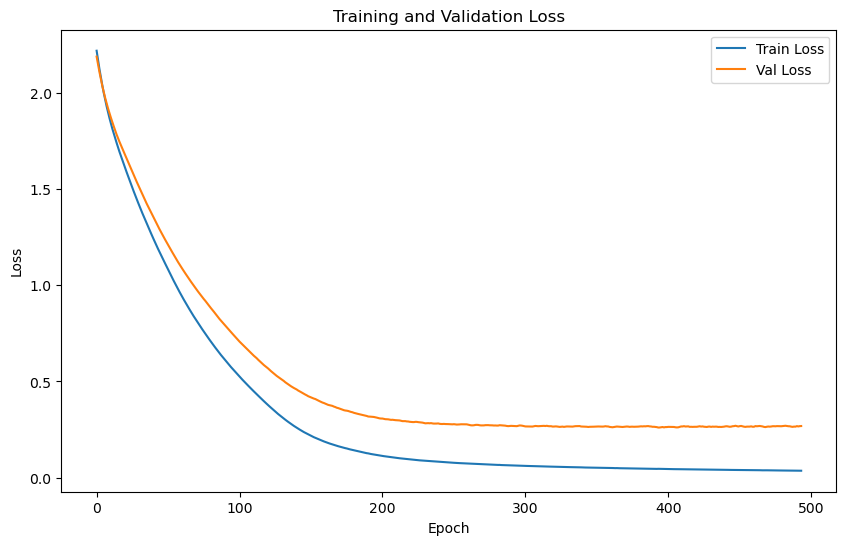

In [45]:
tscl_mlp_input_dim = tscl_mlp_train_reps.shape[1]
tscl_mlp_num_classes = len(torch.unique(tscl_mlp_train_labels_torch))
tscl_mlp_model = MLPClassifier(tscl_mlp_input_dim, tscl_mlp_num_classes).to(device)

tscl_mlp_criterion = nn.CrossEntropyLoss()
tscl_mlp_optimizer = optim.Adam(tscl_mlp_model.parameters(), lr=1e-4)

tscl_mlp_num_epochs = 1000
tscl_mlp_patience = 100

tscl_mlp_train_losses = []
tscl_mlp_val_losses = []

tscl_mlp_best_val_loss = float('inf')
tscl_mlp_epochs_without_improvement = 0

for tscl_mlp_epoch in range(tscl_mlp_num_epochs):
    # Training
    tscl_mlp_model.train()
    tscl_mlp_train_running_loss = 0.0
    
    for tscl_mlp_embeddings_batch, tscl_mlp_labels_batch in tscl_mlp_train_loader:
        tscl_mlp_embeddings_batch = tscl_mlp_embeddings_batch.to(device)
        tscl_mlp_labels_batch = tscl_mlp_labels_batch.to(device)
        
        tscl_mlp_optimizer.zero_grad()
        
        # Forward
        tscl_mlp_outputs = tscl_mlp_model(tscl_mlp_embeddings_batch)
        tscl_mlp_loss = tscl_mlp_criterion(tscl_mlp_outputs, tscl_mlp_labels_batch)
        
        # Backward & Update
        tscl_mlp_loss.backward()
        tscl_mlp_optimizer.step()
        
        tscl_mlp_train_running_loss += tscl_mlp_loss.item() * tscl_mlp_embeddings_batch.size(0)
    
    tscl_mlp_epoch_train_loss = tscl_mlp_train_running_loss / len(tscl_mlp_train_loader.dataset)
    tscl_mlp_train_losses.append(tscl_mlp_epoch_train_loss)

    # Validation
    tscl_mlp_model.eval()
    tscl_mlp_val_running_loss = 0.0
    
    with torch.no_grad():
        for tscl_mlp_val_embeddings_batch, tscl_mlp_val_labels_batch in tscl_mlp_val_loader:
            tscl_mlp_val_embeddings_batch = tscl_mlp_val_embeddings_batch.to(device)
            tscl_mlp_val_labels_batch = tscl_mlp_val_labels_batch.to(device)

            tscl_mlp_val_outputs = tscl_mlp_model(tscl_mlp_val_embeddings_batch)
            tscl_mlp_val_loss = tscl_mlp_criterion(tscl_mlp_val_outputs, tscl_mlp_val_labels_batch)

            tscl_mlp_val_running_loss += tscl_mlp_val_loss.item() * tscl_mlp_val_embeddings_batch.size(0)

    tscl_mlp_epoch_val_loss = tscl_mlp_val_running_loss / len(tscl_mlp_val_loader.dataset)
    tscl_mlp_val_losses.append(tscl_mlp_epoch_val_loss)

    print(f"[Epoch {tscl_mlp_epoch+1}/{tscl_mlp_num_epochs}] "
          f"Train Loss: {tscl_mlp_epoch_train_loss:.4f}  |  "
          f"Val Loss: {tscl_mlp_epoch_val_loss:.4f}")

    # Early stopping
    if tscl_mlp_epoch_val_loss < tscl_mlp_best_val_loss:
        print(f"Validation loss improved from {tscl_mlp_best_val_loss:.4f} to {tscl_mlp_epoch_val_loss:.4f}.")
        tscl_mlp_best_val_loss = tscl_mlp_epoch_val_loss
        tscl_mlp_epochs_without_improvement = 0

    else:
        # no improvement
        tscl_mlp_epochs_without_improvement += 1
        print(f"!! Validation loss did NOT improve !! "
              f"Patience: {tscl_mlp_epochs_without_improvement}/{tscl_mlp_patience}")
        
        if tscl_mlp_epochs_without_improvement >= tscl_mlp_patience:
            print(f"!! Early stopping triggered at epoch {tscl_mlp_epoch+1} !!\n"
                  f"No improvement for {tscl_mlp_patience} epochs.")
            break

plt.figure(figsize=(10,6))
plt.plot(tscl_mlp_train_losses, label='Train Loss')
plt.plot(tscl_mlp_val_losses,   label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


Saved TSCL+MLP predictions and true labels to model_predictions
Test Loss: 0.1997 | Test Accuracy: 94.35%


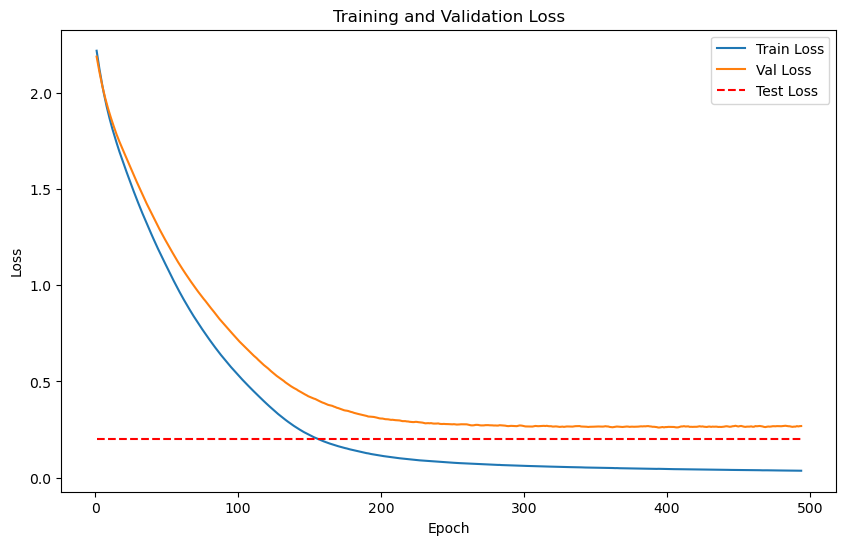

In [46]:
tscl_mlp_model.eval()

tscl_mlp_test_running_loss = 0.0
tscl_mlp_test_correct = 0
tscl_mlp_all_predictions = []
tscl_mlp_all_true_labels = []

with torch.no_grad():
    for tscl_mlp_test_embeddings_batch, tscl_mlp_test_labels_batch in tscl_mlp_test_loader:
        tscl_mlp_test_embeddings_batch = tscl_mlp_test_embeddings_batch.to(device)
        tscl_mlp_test_labels_batch = tscl_mlp_test_labels_batch.to(device)

        tscl_mlp_test_outputs = tscl_mlp_model(tscl_mlp_test_embeddings_batch)
        
        tscl_mlp_test_loss_batch = tscl_mlp_criterion(tscl_mlp_test_outputs, tscl_mlp_test_labels_batch)
        tscl_mlp_test_running_loss += tscl_mlp_test_loss_batch.item() * tscl_mlp_test_embeddings_batch.size(0)

        _, tscl_mlp_test_predicted = torch.max(tscl_mlp_test_outputs, dim=1)
        tscl_mlp_test_correct += (tscl_mlp_test_predicted == tscl_mlp_test_labels_batch).sum().item()

        tscl_mlp_all_predictions.extend(tscl_mlp_test_predicted.cpu().numpy())
        tscl_mlp_all_true_labels.extend(tscl_mlp_test_labels_batch.cpu().numpy())

np.save(os.path.join(predictions_dir, 'tscl_mlp_predictions.npy'), np.array(tscl_mlp_all_predictions))
np.save(os.path.join(predictions_dir, 'tscl_mlp_true_labels.npy'), np.array(tscl_mlp_all_true_labels))
print(f"Saved TSCL+MLP predictions and true labels to {predictions_dir}")

tscl_mlp_epoch_test_loss = tscl_mlp_test_running_loss / len(tscl_mlp_test_loader.dataset)
tscl_mlp_test_accuracy = tscl_mlp_test_correct / len(tscl_mlp_test_loader.dataset)

tscl_mlp_test_accuracy_pct = tscl_mlp_test_accuracy * 100.0

print(f"Test Loss: {tscl_mlp_epoch_test_loss:.4f} | Test Accuracy: {tscl_mlp_test_accuracy_pct:.2f}%")

tscl_mlp_num_epochs_run = len(tscl_mlp_train_losses)

plt.figure(figsize=(10,6))

plt.plot(range(1, tscl_mlp_num_epochs_run + 1),
         tscl_mlp_train_losses,
         label='Train Loss')
plt.plot(range(1, tscl_mlp_num_epochs_run + 1),
         tscl_mlp_val_losses,
         label='Val Loss')

plt.plot(range(1, tscl_mlp_num_epochs_run + 1),
         [tscl_mlp_epoch_test_loss]*tscl_mlp_num_epochs_run,
         'r--',
         label='Test Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


## Model - Supervised Contrastive Learning with Silhouette Distance Loss

In [47]:
sclsdl_encoded_train_dir = os.path.join(encoded_dir, 'train')
sclsdl_encoded_val_dir = os.path.join(encoded_dir, 'val')
sclsdl_encoded_test_dir = os.path.join(encoded_dir, 'test')

sclsdl_train_embeddings, sclsdl_train_labels = load_encoded_data(sclsdl_encoded_train_dir)
sclsdl_val_embeddings, sclsdl_val_labels = load_encoded_data(sclsdl_encoded_val_dir)
sclsdl_test_embeddings, sclsdl_test_labels = load_encoded_data(sclsdl_encoded_test_dir)

#shape verification
print(f"\n\nTrain embeddings shape: {sclsdl_train_embeddings.shape}, \nTrain labels shape: {sclsdl_train_labels.shape}")
print(f"\n\nVal embeddings shape: {sclsdl_val_embeddings.shape}, \nVal labels shape: {sclsdl_val_labels.shape}")
print(f"\n\nTest embeddings shape: {sclsdl_test_embeddings.shape}, \nTest labels shape: {sclsdl_test_labels.shape}")

LOG: Loading encoded data (representations) from encoded_representations\train...
LOG: Loaded 180 samples with 64 features each
LOG: Labels shape: (180,)
LOG: Loading encoded data (representations) from encoded_representations\val...
LOG: Loaded 45 samples with 64 features each
LOG: Labels shape: (45,)
LOG: Loading encoded data (representations) from encoded_representations\test...


LOG: Loaded 147927 samples with 64 features each
LOG: Labels shape: (147927,)


Train embeddings shape: (180, 64), 
Train labels shape: (180,)


Val embeddings shape: (45, 64), 
Val labels shape: (45,)


Test embeddings shape: (147927, 64), 
Test labels shape: (147927,)


In [48]:
#flattening embeddings to (num_samples, 64)
sclsdl_train_embeddings = sclsdl_train_embeddings.reshape(sclsdl_train_embeddings.shape[0], -1)
sclsdl_val_embeddings = sclsdl_val_embeddings.reshape(sclsdl_val_embeddings.shape[0], -1)
sclsdl_test_embeddings = sclsdl_test_embeddings.reshape(sclsdl_test_embeddings.shape[0], -1)

#compute mean and std from training set
sclsdl_train_mean = np.mean(sclsdl_train_embeddings, axis=0)
sclsdl_train_std = np.std(sclsdl_train_embeddings, axis=0)

#normalize all datasets from above training mean and std
#sclsdl_train_embeddings = (sclsdl_train_embeddings - sclsdl_train_mean) / sclsdl_train_std
#sclsdl_val_embeddings = (sclsdl_val_embeddings - sclsdl_train_mean) / sclsdl_train_std
#sclsdl_test_embeddings = (sclsdl_test_embeddings - sclsdl_train_mean) / sclsdl_train_std

sclsdl_train_dataset = TensorDataset(torch.tensor(sclsdl_train_embeddings, dtype=torch.float32), torch.tensor(sclsdl_train_labels, dtype=torch.long))
sclsdl_val_dataset = TensorDataset(torch.tensor(sclsdl_val_embeddings, dtype=torch.float32), torch.tensor(sclsdl_val_labels, dtype=torch.long))
sclsdl_test_dataset = TensorDataset(torch.tensor(sclsdl_test_embeddings, dtype=torch.float32), torch.tensor(sclsdl_test_labels, dtype=torch.long))


sclsdl_m = 20
sclsdl_num_classes = len(np.unique(sclsdl_train_labels))

# calc theoretical required batch size
sclsdl_required_batch_size = sclsdl_m * sclsdl_num_classes

if sclsdl_required_batch_size > len(sclsdl_train_dataset):
    sclsdl_max_possible_m = len(sclsdl_train_dataset) // sclsdl_num_classes
    sclsdl_m = max(1, sclsdl_max_possible_m)
    sclsdl_batch_size_train = sclsdl_m * sclsdl_num_classes
else:
    sclsdl_batch_size_train = sclsdl_required_batch_size

sclsdl_sampler = MPerClassSampler(labels = sclsdl_train_labels, m = sclsdl_m, batch_size = sclsdl_batch_size_train, length_before_new_iter=len(sclsdl_train_dataset))
sclsdl_train_loader = DataLoader(sclsdl_train_dataset, batch_size=sclsdl_batch_size_train, sampler=sclsdl_sampler)

#creating dataloaders for scl
sclsdl_dataloader_bs = 64
sclsdl_val_loader = DataLoader(sclsdl_val_dataset, batch_size=sclsdl_dataloader_bs, shuffle=False)
sclsdl_test_loader = DataLoader(sclsdl_test_dataset, batch_size=sclsdl_dataloader_bs, shuffle=False)

for sclsdl_X_batch, sclsdl_y_batch in sclsdl_train_loader:
    sclsdl_unique, sclsdl_counts = np.unique(y_batch.numpy(), return_counts=True)
    print("Class distribution in batch:", dict(zip(sclsdl_unique, sclsdl_counts)))
    print(f"Training batch size: {sclsdl_batch_size_train}")
    break


Class distribution in batch: {0: 20, 1: 20, 2: 20, 3: 20, 4: 20, 5: 20, 6: 20, 7: 20, 8: 20}
Training batch size: 180


In [49]:
class SupConNet(nn.Module):
    def __init__(self, feature_dim=128):
        super(SupConNet, self).__init__()
        self.projection_head = nn.Sequential(
            nn.Linear(64, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, feature_dim)
        )

    def forward(self, x):
        return self.projection_head(x)

In [50]:
class SilhouetteDistanceLoss(nn.Module):
    def __init__(self):
        super(SilhouetteDistanceLoss, self).__init__()

    def forward(self, features, labels):
        return self.score(features, labels, True,True)

    def score(self,X, labels,feature_norm=True, loss=False):
        unique_labels = torch.unique(labels)
        if feature_norm:
            X= F.normalize(X, p=2, dim=1)


        A, B = self._compute_distances(X, labels, unique_labels)

        # A= scale*A
        # B = (1-scale)*B
        sil_samples = (B - A) / torch.clamp(torch.maximum(A, B), min=0.0001)

        # nan values are for clusters of size 1, and should be 0
        mean_sil_score = torch.mean(torch.nan_to_num(sil_samples))
        if loss:
            return (1 - mean_sil_score) / 2
        else:
            return mean_sil_score.item()


    def _compute_distances(self,X, labels, unique_labels):
        intra_dist = torch.zeros_like(labels, dtype=torch.float32)
        inter_dist = torch.full_like(labels, torch.inf, dtype=torch.float32)

        for i, label_a in enumerate(unique_labels):
            cluster_indices_a = (labels == label_a)
            subX_a = X[cluster_indices_a]


            intra_distances_a = torch.cdist(subX_a, subX_a)
            div = (subX_a.size(0) - 1) if subX_a.shape[0]>1 else 1
            intra_dist[cluster_indices_a] = intra_distances_a.sum(dim=1) / div

            for label_b in unique_labels[i + 1:]:
                cluster_indices_b = (labels == label_b)
                subX_b = X[cluster_indices_b]
                inter_distances_ab = torch.cdist(subX_a, subX_b)
                inter_distances_ba = torch.cdist(subX_b, subX_a)

                inter_dist[cluster_indices_a] = torch.minimum(inter_distances_ab.mean(dim=1), inter_dist[cluster_indices_a])
                inter_dist[cluster_indices_b] = torch.minimum(inter_distances_ba.mean(dim=1), inter_dist[cluster_indices_b])

        return intra_dist, inter_dist

LOG: Epoch [1/2000] - Training


    Batch [1/1], Train Loss: 0.4465
LOG: Epoch [1/2000] - Validation
    Batch [1/1], Val Loss: 0.3613
Epoch [1/2000], Avg Train Loss: 0.4465, Avg Val Loss: 0.3613

Validation loss improved from inf to 0.3613. Saving model...
LOG: Epoch [2/2000] - Training
    Batch [1/1], Train Loss: 0.4443
LOG: Epoch [2/2000] - Validation
    Batch [1/1], Val Loss: 0.3594
Epoch [2/2000], Avg Train Loss: 0.4443, Avg Val Loss: 0.3594

Validation loss improved from 0.3613 to 0.3594. Saving model...
LOG: Epoch [3/2000] - Training
    Batch [1/1], Train Loss: 0.4452
LOG: Epoch [3/2000] - Validation


    Batch [1/1], Val Loss: 0.3570
Epoch [3/2000], Avg Train Loss: 0.4452, Avg Val Loss: 0.3570

Validation loss improved from 0.3594 to 0.3570. Saving model...
LOG: Epoch [4/2000] - Training
    Batch [1/1], Train Loss: 0.4459
LOG: Epoch [4/2000] - Validation
    Batch [1/1], Val Loss: 0.3547
Epoch [4/2000], Avg Train Loss: 0.4459, Avg Val Loss: 0.3547

Validation loss improved from 0.3570 to 0.3547. Saving model...
LOG: Epoch [5/2000] - Training
    Batch [1/1], Train Loss: 0.4414
LOG: Epoch [5/2000] - Validation
    Batch [1/1], Val Loss: 0.3526
Epoch [5/2000], Avg Train Loss: 0.4414, Avg Val Loss: 0.3526

Validation loss improved from 0.3547 to 0.3526. Saving model...
LOG: Epoch [6/2000] - Training


    Batch [1/1], Train Loss: 0.4369
LOG: Epoch [6/2000] - Validation
    Batch [1/1], Val Loss: 0.3513
Epoch [6/2000], Avg Train Loss: 0.4369, Avg Val Loss: 0.3513

Validation loss improved from 0.3526 to 0.3513. Saving model...
LOG: Epoch [7/2000] - Training
    Batch [1/1], Train Loss: 0.4342
LOG: Epoch [7/2000] - Validation
    Batch [1/1], Val Loss: 0.3509
Epoch [7/2000], Avg Train Loss: 0.4342, Avg Val Loss: 0.3509

Validation loss improved from 0.3513 to 0.3509. Saving model...
LOG: Epoch [8/2000] - Training


    Batch [1/1], Train Loss: 0.4326
LOG: Epoch [8/2000] - Validation
    Batch [1/1], Val Loss: 0.3506
Epoch [8/2000], Avg Train Loss: 0.4326, Avg Val Loss: 0.3506

Validation loss improved from 0.3509 to 0.3506. Saving model...
LOG: Epoch [9/2000] - Training
    Batch [1/1], Train Loss: 0.4332
LOG: Epoch [9/2000] - Validation
    Batch [1/1], Val Loss: 0.3500
Epoch [9/2000], Avg Train Loss: 0.4332, Avg Val Loss: 0.3500

Validation loss improved from 0.3506 to 0.3500. Saving model...
LOG: Epoch [10/2000] - Training
    Batch [1/1], Train Loss: 0.4318
LOG: Epoch [10/2000] - Validation


    Batch [1/1], Val Loss: 0.3498
Epoch [10/2000], Avg Train Loss: 0.4318, Avg Val Loss: 0.3498

Validation loss improved from 0.3500 to 0.3498. Saving model...
LOG: Epoch [11/2000] - Training
    Batch [1/1], Train Loss: 0.4305
LOG: Epoch [11/2000] - Validation
    Batch [1/1], Val Loss: 0.3499
Epoch [11/2000], Avg Train Loss: 0.4305, Avg Val Loss: 0.3499

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [12/2000] - Training
    Batch [1/1], Train Loss: 0.4342
LOG: Epoch [12/2000] - Validation
    Batch [1/1], Val Loss: 0.3505
Epoch [12/2000], Avg Train Loss: 0.4342, Avg Val Loss: 0.3505

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [13/2000] - Training


    Batch [1/1], Train Loss: 0.4272
LOG: Epoch [13/2000] - Validation
    Batch [1/1], Val Loss: 0.3510
Epoch [13/2000], Avg Train Loss: 0.4272, Avg Val Loss: 0.3510

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [14/2000] - Training
    Batch [1/1], Train Loss: 0.4204
LOG: Epoch [14/2000] - Validation
    Batch [1/1], Val Loss: 0.3513
Epoch [14/2000], Avg Train Loss: 0.4204, Avg Val Loss: 0.3513

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [15/2000] - Training


    Batch [1/1], Train Loss: 0.4279
LOG: Epoch [15/2000] - Validation
    Batch [1/1], Val Loss: 0.3514
Epoch [15/2000], Avg Train Loss: 0.4279, Avg Val Loss: 0.3514

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [16/2000] - Training
    Batch [1/1], Train Loss: 0.4265
LOG: Epoch [16/2000] - Validation
    Batch [1/1], Val Loss: 0.3515
Epoch [16/2000], Avg Train Loss: 0.4265, Avg Val Loss: 0.3515

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [17/2000] - Training


    Batch [1/1], Train Loss: 0.4247
LOG: Epoch [17/2000] - Validation
    Batch [1/1], Val Loss: 0.3515
Epoch [17/2000], Avg Train Loss: 0.4247, Avg Val Loss: 0.3515

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [18/2000] - Training
    Batch [1/1], Train Loss: 0.4231
LOG: Epoch [18/2000] - Validation
    Batch [1/1], Val Loss: 0.3515
Epoch [18/2000], Avg Train Loss: 0.4231, Avg Val Loss: 0.3515

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [19/2000] - Training
    Batch [1/1], Train Loss: 0.4221
LOG: Epoch [19/2000] - Validation


    Batch [1/1], Val Loss: 0.3513
Epoch [19/2000], Avg Train Loss: 0.4221, Avg Val Loss: 0.3513

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [20/2000] - Training
    Batch [1/1], Train Loss: 0.4224
LOG: Epoch [20/2000] - Validation
    Batch [1/1], Val Loss: 0.3512
Epoch [20/2000], Avg Train Loss: 0.4224, Avg Val Loss: 0.3512

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [21/2000] - Training
    Batch [1/1], Train Loss: 0.4127
LOG: Epoch [21/2000] - Validation


    Batch [1/1], Val Loss: 0.3510
Epoch [21/2000], Avg Train Loss: 0.4127, Avg Val Loss: 0.3510

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [22/2000] - Training
    Batch [1/1], Train Loss: 0.4170
LOG: Epoch [22/2000] - Validation
    Batch [1/1], Val Loss: 0.3507
Epoch [22/2000], Avg Train Loss: 0.4170, Avg Val Loss: 0.3507

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [23/2000] - Training
    Batch [1/1], Train Loss: 0.4186
LOG: Epoch [23/2000] - Validation


    Batch [1/1], Val Loss: 0.3505
Epoch [23/2000], Avg Train Loss: 0.4186, Avg Val Loss: 0.3505

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [24/2000] - Training
    Batch [1/1], Train Loss: 0.4112
LOG: Epoch [24/2000] - Validation
    Batch [1/1], Val Loss: 0.3501
Epoch [24/2000], Avg Train Loss: 0.4112, Avg Val Loss: 0.3501

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [25/2000] - Training
    Batch [1/1], Train Loss: 0.4153
LOG: Epoch [25/2000] - Validation


    Batch [1/1], Val Loss: 0.3498
Epoch [25/2000], Avg Train Loss: 0.4153, Avg Val Loss: 0.3498

!! Validation loss did NOT improve !! Patience: 15/100
LOG: Epoch [26/2000] - Training
    Batch [1/1], Train Loss: 0.4118
LOG: Epoch [26/2000] - Validation
    Batch [1/1], Val Loss: 0.3495
Epoch [26/2000], Avg Train Loss: 0.4118, Avg Val Loss: 0.3495

Validation loss improved from 0.3498 to 0.3495. Saving model...
LOG: Epoch [27/2000] - Training
    Batch [1/1], Train Loss: 0.4123
LOG: Epoch [27/2000] - Validation


    Batch [1/1], Val Loss: 0.3491
Epoch [27/2000], Avg Train Loss: 0.4123, Avg Val Loss: 0.3491

Validation loss improved from 0.3495 to 0.3491. Saving model...
LOG: Epoch [28/2000] - Training
    Batch [1/1], Train Loss: 0.4107
LOG: Epoch [28/2000] - Validation
    Batch [1/1], Val Loss: 0.3487
Epoch [28/2000], Avg Train Loss: 0.4107, Avg Val Loss: 0.3487

Validation loss improved from 0.3491 to 0.3487. Saving model...
LOG: Epoch [29/2000] - Training
    Batch [1/1], Train Loss: 0.4098
LOG: Epoch [29/2000] - Validation


    Batch [1/1], Val Loss: 0.3482
Epoch [29/2000], Avg Train Loss: 0.4098, Avg Val Loss: 0.3482

Validation loss improved from 0.3487 to 0.3482. Saving model...
LOG: Epoch [30/2000] - Training
    Batch [1/1], Train Loss: 0.4093
LOG: Epoch [30/2000] - Validation
    Batch [1/1], Val Loss: 0.3477
Epoch [30/2000], Avg Train Loss: 0.4093, Avg Val Loss: 0.3477

Validation loss improved from 0.3482 to 0.3477. Saving model...
LOG: Epoch [31/2000] - Training


    Batch [1/1], Train Loss: 0.4081
LOG: Epoch [31/2000] - Validation
    Batch [1/1], Val Loss: 0.3472
Epoch [31/2000], Avg Train Loss: 0.4081, Avg Val Loss: 0.3472

Validation loss improved from 0.3477 to 0.3472. Saving model...
LOG: Epoch [32/2000] - Training
    Batch [1/1], Train Loss: 0.4067
LOG: Epoch [32/2000] - Validation
    Batch [1/1], Val Loss: 0.3466
Epoch [32/2000], Avg Train Loss: 0.4067, Avg Val Loss: 0.3466

Validation loss improved from 0.3472 to 0.3466. Saving model...
LOG: Epoch [33/2000] - Training


    Batch [1/1], Train Loss: 0.4104
LOG: Epoch [33/2000] - Validation
    Batch [1/1], Val Loss: 0.3460
Epoch [33/2000], Avg Train Loss: 0.4104, Avg Val Loss: 0.3460

Validation loss improved from 0.3466 to 0.3460. Saving model...
LOG: Epoch [34/2000] - Training
    Batch [1/1], Train Loss: 0.3988
LOG: Epoch [34/2000] - Validation
    Batch [1/1], Val Loss: 0.3454
Epoch [34/2000], Avg Train Loss: 0.3988, Avg Val Loss: 0.3454

Validation loss improved from 0.3460 to 0.3454. Saving model...
LOG: Epoch [35/2000] - Training


    Batch [1/1], Train Loss: 0.4025
LOG: Epoch [35/2000] - Validation
    Batch [1/1], Val Loss: 0.3448
Epoch [35/2000], Avg Train Loss: 0.4025, Avg Val Loss: 0.3448

Validation loss improved from 0.3454 to 0.3448. Saving model...
LOG: Epoch [36/2000] - Training
    Batch [1/1], Train Loss: 0.4069
LOG: Epoch [36/2000] - Validation
    Batch [1/1], Val Loss: 0.3441
Epoch [36/2000], Avg Train Loss: 0.4069, Avg Val Loss: 0.3441

Validation loss improved from 0.3448 to 0.3441. Saving model...
LOG: Epoch [37/2000] - Training


    Batch [1/1], Train Loss: 0.4061
LOG: Epoch [37/2000] - Validation
    Batch [1/1], Val Loss: 0.3435
Epoch [37/2000], Avg Train Loss: 0.4061, Avg Val Loss: 0.3435

Validation loss improved from 0.3441 to 0.3435. Saving model...
LOG: Epoch [38/2000] - Training
    Batch [1/1], Train Loss: 0.4020
LOG: Epoch [38/2000] - Validation
    Batch [1/1], Val Loss: 0.3428
Epoch [38/2000], Avg Train Loss: 0.4020, Avg Val Loss: 0.3428

Validation loss improved from 0.3435 to 0.3428. Saving model...
LOG: Epoch [39/2000] - Training


    Batch [1/1], Train Loss: 0.4007
LOG: Epoch [39/2000] - Validation
    Batch [1/1], Val Loss: 0.3422
Epoch [39/2000], Avg Train Loss: 0.4007, Avg Val Loss: 0.3422

Validation loss improved from 0.3428 to 0.3422. Saving model...
LOG: Epoch [40/2000] - Training
    Batch [1/1], Train Loss: 0.3958
LOG: Epoch [40/2000] - Validation
    Batch [1/1], Val Loss: 0.3415
Epoch [40/2000], Avg Train Loss: 0.3958, Avg Val Loss: 0.3415

Validation loss improved from 0.3422 to 0.3415. Saving model...
LOG: Epoch [41/2000] - Training
    Batch [1/1], Train Loss: 0.3974
LOG: Epoch [41/2000] - Validation


    Batch [1/1], Val Loss: 0.3408
Epoch [41/2000], Avg Train Loss: 0.3974, Avg Val Loss: 0.3408

Validation loss improved from 0.3415 to 0.3408. Saving model...
LOG: Epoch [42/2000] - Training
    Batch [1/1], Train Loss: 0.3939
LOG: Epoch [42/2000] - Validation
    Batch [1/1], Val Loss: 0.3401
Epoch [42/2000], Avg Train Loss: 0.3939, Avg Val Loss: 0.3401

Validation loss improved from 0.3408 to 0.3401. Saving model...
LOG: Epoch [43/2000] - Training
    Batch [1/1], Train Loss: 0.3958
LOG: Epoch [43/2000] - Validation


    Batch [1/1], Val Loss: 0.3394
Epoch [43/2000], Avg Train Loss: 0.3958, Avg Val Loss: 0.3394

Validation loss improved from 0.3401 to 0.3394. Saving model...
LOG: Epoch [44/2000] - Training
    Batch [1/1], Train Loss: 0.3929
LOG: Epoch [44/2000] - Validation
    Batch [1/1], Val Loss: 0.3387
Epoch [44/2000], Avg Train Loss: 0.3929, Avg Val Loss: 0.3387

Validation loss improved from 0.3394 to 0.3387. Saving model...
LOG: Epoch [45/2000] - Training
    Batch [1/1], Train Loss: 0.3940
LOG: Epoch [45/2000] - Validation


    Batch [1/1], Val Loss: 0.3380
Epoch [45/2000], Avg Train Loss: 0.3940, Avg Val Loss: 0.3380

Validation loss improved from 0.3387 to 0.3380. Saving model...
LOG: Epoch [46/2000] - Training
    Batch [1/1], Train Loss: 0.3922
LOG: Epoch [46/2000] - Validation
    Batch [1/1], Val Loss: 0.3373
Epoch [46/2000], Avg Train Loss: 0.3922, Avg Val Loss: 0.3373

Validation loss improved from 0.3380 to 0.3373. Saving model...
LOG: Epoch [47/2000] - Training
    Batch [1/1], Train Loss: 0.3874
LOG: Epoch [47/2000] - Validation


    Batch [1/1], Val Loss: 0.3365
Epoch [47/2000], Avg Train Loss: 0.3874, Avg Val Loss: 0.3365

Validation loss improved from 0.3373 to 0.3365. Saving model...
LOG: Epoch [48/2000] - Training
    Batch [1/1], Train Loss: 0.3882
LOG: Epoch [48/2000] - Validation
    Batch [1/1], Val Loss: 0.3358
Epoch [48/2000], Avg Train Loss: 0.3882, Avg Val Loss: 0.3358

Validation loss improved from 0.3365 to 0.3358. Saving model...
LOG: Epoch [49/2000] - Training
    Batch [1/1], Train Loss: 0.3839
LOG: Epoch [49/2000] - Validation
    Batch [1/1], Val Loss: 0.3351
Epoch [49/2000], Avg Train Loss: 0.3839, Avg Val Loss: 0.3351

Validation loss improved from 0.3358 to 0.3351. Saving model...
LOG: Epoch [50/2000] - Training


    Batch [1/1], Train Loss: 0.3870
LOG: Epoch [50/2000] - Validation
    Batch [1/1], Val Loss: 0.3343
Epoch [50/2000], Avg Train Loss: 0.3870, Avg Val Loss: 0.3343

Validation loss improved from 0.3351 to 0.3343. Saving model...
LOG: Epoch [51/2000] - Training
    Batch [1/1], Train Loss: 0.3886
LOG: Epoch [51/2000] - Validation
    Batch [1/1], Val Loss: 0.3335
Epoch [51/2000], Avg Train Loss: 0.3886, Avg Val Loss: 0.3335

Validation loss improved from 0.3343 to 0.3335. Saving model...
LOG: Epoch [52/2000] - Training


    Batch [1/1], Train Loss: 0.3873
LOG: Epoch [52/2000] - Validation
    Batch [1/1], Val Loss: 0.3327
Epoch [52/2000], Avg Train Loss: 0.3873, Avg Val Loss: 0.3327

Validation loss improved from 0.3335 to 0.3327. Saving model...
LOG: Epoch [53/2000] - Training
    Batch [1/1], Train Loss: 0.3829
LOG: Epoch [53/2000] - Validation
    Batch [1/1], Val Loss: 0.3319
Epoch [53/2000], Avg Train Loss: 0.3829, Avg Val Loss: 0.3319

Validation loss improved from 0.3327 to 0.3319. Saving model...
LOG: Epoch [54/2000] - Training
    Batch [1/1], Train Loss: 0.3865
LOG: Epoch [54/2000] - Validation


    Batch [1/1], Val Loss: 0.3311
Epoch [54/2000], Avg Train Loss: 0.3865, Avg Val Loss: 0.3311

Validation loss improved from 0.3319 to 0.3311. Saving model...
LOG: Epoch [55/2000] - Training
    Batch [1/1], Train Loss: 0.3900
LOG: Epoch [55/2000] - Validation
    Batch [1/1], Val Loss: 0.3303
Epoch [55/2000], Avg Train Loss: 0.3900, Avg Val Loss: 0.3303

Validation loss improved from 0.3311 to 0.3303. Saving model...
LOG: Epoch [56/2000] - Training
    Batch [1/1], Train Loss: 0.3856
LOG: Epoch [56/2000] - Validation


    Batch [1/1], Val Loss: 0.3295
Epoch [56/2000], Avg Train Loss: 0.3856, Avg Val Loss: 0.3295

Validation loss improved from 0.3303 to 0.3295. Saving model...
LOG: Epoch [57/2000] - Training
    Batch [1/1], Train Loss: 0.3755
LOG: Epoch [57/2000] - Validation
    Batch [1/1], Val Loss: 0.3287
Epoch [57/2000], Avg Train Loss: 0.3755, Avg Val Loss: 0.3287

Validation loss improved from 0.3295 to 0.3287. Saving model...
LOG: Epoch [58/2000] - Training
    Batch [1/1], Train Loss: 0.3821
LOG: Epoch [58/2000] - Validation
    Batch [1/1], Val Loss: 0.3279
Epoch [58/2000], Avg Train Loss: 0.3821, Avg Val Loss: 0.3279

Validation loss improved from 0.3287 to 0.3279. Saving model...
LOG: Epoch [59/2000] - Training


    Batch [1/1], Train Loss: 0.3785
LOG: Epoch [59/2000] - Validation
    Batch [1/1], Val Loss: 0.3271
Epoch [59/2000], Avg Train Loss: 0.3785, Avg Val Loss: 0.3271

Validation loss improved from 0.3279 to 0.3271. Saving model...
LOG: Epoch [60/2000] - Training
    Batch [1/1], Train Loss: 0.3766
LOG: Epoch [60/2000] - Validation
    Batch [1/1], Val Loss: 0.3264
Epoch [60/2000], Avg Train Loss: 0.3766, Avg Val Loss: 0.3264

Validation loss improved from 0.3271 to 0.3264. Saving model...
LOG: Epoch [61/2000] - Training


    Batch [1/1], Train Loss: 0.3772
LOG: Epoch [61/2000] - Validation
    Batch [1/1], Val Loss: 0.3256
Epoch [61/2000], Avg Train Loss: 0.3772, Avg Val Loss: 0.3256

Validation loss improved from 0.3264 to 0.3256. Saving model...
LOG: Epoch [62/2000] - Training
    Batch [1/1], Train Loss: 0.3751
LOG: Epoch [62/2000] - Validation
    Batch [1/1], Val Loss: 0.3249
Epoch [62/2000], Avg Train Loss: 0.3751, Avg Val Loss: 0.3249

Validation loss improved from 0.3256 to 0.3249. Saving model...
LOG: Epoch [63/2000] - Training


    Batch [1/1], Train Loss: 0.3838
LOG: Epoch [63/2000] - Validation
    Batch [1/1], Val Loss: 0.3241
Epoch [63/2000], Avg Train Loss: 0.3838, Avg Val Loss: 0.3241

Validation loss improved from 0.3249 to 0.3241. Saving model...
LOG: Epoch [64/2000] - Training
    Batch [1/1], Train Loss: 0.3725
LOG: Epoch [64/2000] - Validation
    Batch [1/1], Val Loss: 0.3234
Epoch [64/2000], Avg Train Loss: 0.3725, Avg Val Loss: 0.3234

Validation loss improved from 0.3241 to 0.3234. Saving model...
LOG: Epoch [65/2000] - Training
    Batch [1/1], Train Loss: 0.3699
LOG: Epoch [65/2000] - Validation


    Batch [1/1], Val Loss: 0.3226
Epoch [65/2000], Avg Train Loss: 0.3699, Avg Val Loss: 0.3226

Validation loss improved from 0.3234 to 0.3226. Saving model...
LOG: Epoch [66/2000] - Training
    Batch [1/1], Train Loss: 0.3688
LOG: Epoch [66/2000] - Validation
    Batch [1/1], Val Loss: 0.3219
Epoch [66/2000], Avg Train Loss: 0.3688, Avg Val Loss: 0.3219

Validation loss improved from 0.3226 to 0.3219. Saving model...
LOG: Epoch [67/2000] - Training
    Batch [1/1], Train Loss: 0.3732
LOG: Epoch [67/2000] - Validation


    Batch [1/1], Val Loss: 0.3212
Epoch [67/2000], Avg Train Loss: 0.3732, Avg Val Loss: 0.3212

Validation loss improved from 0.3219 to 0.3212. Saving model...
LOG: Epoch [68/2000] - Training
    Batch [1/1], Train Loss: 0.3724
LOG: Epoch [68/2000] - Validation
    Batch [1/1], Val Loss: 0.3204
Epoch [68/2000], Avg Train Loss: 0.3724, Avg Val Loss: 0.3204

Validation loss improved from 0.3212 to 0.3204. Saving model...
LOG: Epoch [69/2000] - Training
    Batch [1/1], Train Loss: 0.3699
LOG: Epoch [69/2000] - Validation


    Batch [1/1], Val Loss: 0.3197
Epoch [69/2000], Avg Train Loss: 0.3699, Avg Val Loss: 0.3197

Validation loss improved from 0.3204 to 0.3197. Saving model...
LOG: Epoch [70/2000] - Training
    Batch [1/1], Train Loss: 0.3732
LOG: Epoch [70/2000] - Validation
    Batch [1/1], Val Loss: 0.3189
Epoch [70/2000], Avg Train Loss: 0.3732, Avg Val Loss: 0.3189

Validation loss improved from 0.3197 to 0.3189. Saving model...
LOG: Epoch [71/2000] - Training
    Batch [1/1], Train Loss: 0.3707
LOG: Epoch [71/2000] - Validation
    Batch [1/1], Val Loss: 0.3182
Epoch [71/2000], Avg Train Loss: 0.3707, Avg Val Loss: 0.3182

Validation loss improved from 0.3189 to 0.3182. Saving model...
LOG: Epoch [72/2000] - Training


    Batch [1/1], Train Loss: 0.3684
LOG: Epoch [72/2000] - Validation
    Batch [1/1], Val Loss: 0.3174
Epoch [72/2000], Avg Train Loss: 0.3684, Avg Val Loss: 0.3174

Validation loss improved from 0.3182 to 0.3174. Saving model...
LOG: Epoch [73/2000] - Training
    Batch [1/1], Train Loss: 0.3697
LOG: Epoch [73/2000] - Validation
    Batch [1/1], Val Loss: 0.3167
Epoch [73/2000], Avg Train Loss: 0.3697, Avg Val Loss: 0.3167

Validation loss improved from 0.3174 to 0.3167. Saving model...
LOG: Epoch [74/2000] - Training
    Batch [1/1], Train Loss: 0.3662
LOG: Epoch [74/2000] - Validation


    Batch [1/1], Val Loss: 0.3159
Epoch [74/2000], Avg Train Loss: 0.3662, Avg Val Loss: 0.3159

Validation loss improved from 0.3167 to 0.3159. Saving model...
LOG: Epoch [75/2000] - Training
    Batch [1/1], Train Loss: 0.3664
LOG: Epoch [75/2000] - Validation
    Batch [1/1], Val Loss: 0.3152
Epoch [75/2000], Avg Train Loss: 0.3664, Avg Val Loss: 0.3152

Validation loss improved from 0.3159 to 0.3152. Saving model...
LOG: Epoch [76/2000] - Training
    Batch [1/1], Train Loss: 0.3616
LOG: Epoch [76/2000] - Validation
    Batch [1/1], Val Loss: 0.3144
Epoch [76/2000], Avg Train Loss: 0.3616, Avg Val Loss: 0.3144

Validation loss improved from 0.3152 to 0.3144. Saving model...
LOG: Epoch [77/2000] - Training


    Batch [1/1], Train Loss: 0.3671
LOG: Epoch [77/2000] - Validation
    Batch [1/1], Val Loss: 0.3137
Epoch [77/2000], Avg Train Loss: 0.3671, Avg Val Loss: 0.3137

Validation loss improved from 0.3144 to 0.3137. Saving model...
LOG: Epoch [78/2000] - Training
    Batch [1/1], Train Loss: 0.3639
LOG: Epoch [78/2000] - Validation
    Batch [1/1], Val Loss: 0.3130
Epoch [78/2000], Avg Train Loss: 0.3639, Avg Val Loss: 0.3130

Validation loss improved from 0.3137 to 0.3130. Saving model...
LOG: Epoch [79/2000] - Training


    Batch [1/1], Train Loss: 0.3631
LOG: Epoch [79/2000] - Validation
    Batch [1/1], Val Loss: 0.3123
Epoch [79/2000], Avg Train Loss: 0.3631, Avg Val Loss: 0.3123

Validation loss improved from 0.3130 to 0.3123. Saving model...
LOG: Epoch [80/2000] - Training
    Batch [1/1], Train Loss: 0.3571
LOG: Epoch [80/2000] - Validation
    Batch [1/1], Val Loss: 0.3115
Epoch [80/2000], Avg Train Loss: 0.3571, Avg Val Loss: 0.3115

Validation loss improved from 0.3123 to 0.3115. Saving model...
LOG: Epoch [81/2000] - Training
    Batch [1/1], Train Loss: 0.3636
LOG: Epoch [81/2000] - Validation


    Batch [1/1], Val Loss: 0.3108
Epoch [81/2000], Avg Train Loss: 0.3636, Avg Val Loss: 0.3108

Validation loss improved from 0.3115 to 0.3108. Saving model...
LOG: Epoch [82/2000] - Training
    Batch [1/1], Train Loss: 0.3646
LOG: Epoch [82/2000] - Validation
    Batch [1/1], Val Loss: 0.3101
Epoch [82/2000], Avg Train Loss: 0.3646, Avg Val Loss: 0.3101

Validation loss improved from 0.3108 to 0.3101. Saving model...
LOG: Epoch [83/2000] - Training
    Batch [1/1], Train Loss: 0.3630
LOG: Epoch [83/2000] - Validation


    Batch [1/1], Val Loss: 0.3094
Epoch [83/2000], Avg Train Loss: 0.3630, Avg Val Loss: 0.3094

Validation loss improved from 0.3101 to 0.3094. Saving model...
LOG: Epoch [84/2000] - Training
    Batch [1/1], Train Loss: 0.3607
LOG: Epoch [84/2000] - Validation
    Batch [1/1], Val Loss: 0.3087
Epoch [84/2000], Avg Train Loss: 0.3607, Avg Val Loss: 0.3087

Validation loss improved from 0.3094 to 0.3087. Saving model...
LOG: Epoch [85/2000] - Training
    Batch [1/1], Train Loss: 0.3622
LOG: Epoch [85/2000] - Validation
    Batch [1/1], Val Loss: 0.3080
Epoch [85/2000], Avg Train Loss: 0.3622, Avg Val Loss: 0.3080

Validation loss improved from 0.3087 to 0.3080. Saving model...
LOG: Epoch [86/2000] - Training


    Batch [1/1], Train Loss: 0.3583
LOG: Epoch [86/2000] - Validation
    Batch [1/1], Val Loss: 0.3073
Epoch [86/2000], Avg Train Loss: 0.3583, Avg Val Loss: 0.3073

Validation loss improved from 0.3080 to 0.3073. Saving model...
LOG: Epoch [87/2000] - Training
    Batch [1/1], Train Loss: 0.3576
LOG: Epoch [87/2000] - Validation
    Batch [1/1], Val Loss: 0.3066
Epoch [87/2000], Avg Train Loss: 0.3576, Avg Val Loss: 0.3066

Validation loss improved from 0.3073 to 0.3066. Saving model...
LOG: Epoch [88/2000] - Training


    Batch [1/1], Train Loss: 0.3558
LOG: Epoch [88/2000] - Validation
    Batch [1/1], Val Loss: 0.3059
Epoch [88/2000], Avg Train Loss: 0.3558, Avg Val Loss: 0.3059

Validation loss improved from 0.3066 to 0.3059. Saving model...
LOG: Epoch [89/2000] - Training
    Batch [1/1], Train Loss: 0.3538
LOG: Epoch [89/2000] - Validation
    Batch [1/1], Val Loss: 0.3052
Epoch [89/2000], Avg Train Loss: 0.3538, Avg Val Loss: 0.3052

Validation loss improved from 0.3059 to 0.3052. Saving model...
LOG: Epoch [90/2000] - Training


    Batch [1/1], Train Loss: 0.3518
LOG: Epoch [90/2000] - Validation
    Batch [1/1], Val Loss: 0.3045
Epoch [90/2000], Avg Train Loss: 0.3518, Avg Val Loss: 0.3045

Validation loss improved from 0.3052 to 0.3045. Saving model...
LOG: Epoch [91/2000] - Training
    Batch [1/1], Train Loss: 0.3515
LOG: Epoch [91/2000] - Validation
    Batch [1/1], Val Loss: 0.3038
Epoch [91/2000], Avg Train Loss: 0.3515, Avg Val Loss: 0.3038

Validation loss improved from 0.3045 to 0.3038. Saving model...
LOG: Epoch [92/2000] - Training


    Batch [1/1], Train Loss: 0.3532
LOG: Epoch [92/2000] - Validation
    Batch [1/1], Val Loss: 0.3031
Epoch [92/2000], Avg Train Loss: 0.3532, Avg Val Loss: 0.3031

Validation loss improved from 0.3038 to 0.3031. Saving model...
LOG: Epoch [93/2000] - Training
    Batch [1/1], Train Loss: 0.3492
LOG: Epoch [93/2000] - Validation
    Batch [1/1], Val Loss: 0.3025
Epoch [93/2000], Avg Train Loss: 0.3492, Avg Val Loss: 0.3025

Validation loss improved from 0.3031 to 0.3025. Saving model...
LOG: Epoch [94/2000] - Training


    Batch [1/1], Train Loss: 0.3484
LOG: Epoch [94/2000] - Validation
    Batch [1/1], Val Loss: 0.3018
Epoch [94/2000], Avg Train Loss: 0.3484, Avg Val Loss: 0.3018

Validation loss improved from 0.3025 to 0.3018. Saving model...
LOG: Epoch [95/2000] - Training
    Batch [1/1], Train Loss: 0.3448
LOG: Epoch [95/2000] - Validation
    Batch [1/1], Val Loss: 0.3011
Epoch [95/2000], Avg Train Loss: 0.3448, Avg Val Loss: 0.3011

Validation loss improved from 0.3018 to 0.3011. Saving model...
LOG: Epoch [96/2000] - Training
    Batch [1/1], Train Loss: 0.3456
LOG: Epoch [96/2000] - Validation


    Batch [1/1], Val Loss: 0.3004
Epoch [96/2000], Avg Train Loss: 0.3456, Avg Val Loss: 0.3004

Validation loss improved from 0.3011 to 0.3004. Saving model...
LOG: Epoch [97/2000] - Training
    Batch [1/1], Train Loss: 0.3510
LOG: Epoch [97/2000] - Validation
    Batch [1/1], Val Loss: 0.2998
Epoch [97/2000], Avg Train Loss: 0.3510, Avg Val Loss: 0.2998

Validation loss improved from 0.3004 to 0.2998. Saving model...
LOG: Epoch [98/2000] - Training
    Batch [1/1], Train Loss: 0.3455
LOG: Epoch [98/2000] - Validation


    Batch [1/1], Val Loss: 0.2991
Epoch [98/2000], Avg Train Loss: 0.3455, Avg Val Loss: 0.2991

Validation loss improved from 0.2998 to 0.2991. Saving model...
LOG: Epoch [99/2000] - Training
    Batch [1/1], Train Loss: 0.3472
LOG: Epoch [99/2000] - Validation
    Batch [1/1], Val Loss: 0.2984
Epoch [99/2000], Avg Train Loss: 0.3472, Avg Val Loss: 0.2984

Validation loss improved from 0.2991 to 0.2984. Saving model...
LOG: Epoch [100/2000] - Training
    Batch [1/1], Train Loss: 0.3456
LOG: Epoch [100/2000] - Validation
    Batch [1/1], Val Loss: 0.2977


Epoch [100/2000], Avg Train Loss: 0.3456, Avg Val Loss: 0.2977

Validation loss improved from 0.2984 to 0.2977. Saving model...
LOG: Epoch [101/2000] - Training
    Batch [1/1], Train Loss: 0.3491
LOG: Epoch [101/2000] - Validation
    Batch [1/1], Val Loss: 0.2971
Epoch [101/2000], Avg Train Loss: 0.3491, Avg Val Loss: 0.2971

Validation loss improved from 0.2977 to 0.2971. Saving model...
LOG: Epoch [102/2000] - Training
    Batch [1/1], Train Loss: 0.3455
LOG: Epoch [102/2000] - Validation
    Batch [1/1], Val Loss: 0.2964
Epoch [102/2000], Avg Train Loss: 0.3455, Avg Val Loss: 0.2964

Validation loss improved from 0.2971 to 0.2964. Saving model...
LOG: Epoch [103/2000] - Training


    Batch [1/1], Train Loss: 0.3407
LOG: Epoch [103/2000] - Validation
    Batch [1/1], Val Loss: 0.2957
Epoch [103/2000], Avg Train Loss: 0.3407, Avg Val Loss: 0.2957

Validation loss improved from 0.2964 to 0.2957. Saving model...
LOG: Epoch [104/2000] - Training
    Batch [1/1], Train Loss: 0.3394
LOG: Epoch [104/2000] - Validation
    Batch [1/1], Val Loss: 0.2950
Epoch [104/2000], Avg Train Loss: 0.3394, Avg Val Loss: 0.2950

Validation loss improved from 0.2957 to 0.2950. Saving model...
LOG: Epoch [105/2000] - Training
    Batch [1/1], Train Loss: 0.3412
LOG: Epoch [105/2000] - Validation


    Batch [1/1], Val Loss: 0.2944
Epoch [105/2000], Avg Train Loss: 0.3412, Avg Val Loss: 0.2944

Validation loss improved from 0.2950 to 0.2944. Saving model...
LOG: Epoch [106/2000] - Training
    Batch [1/1], Train Loss: 0.3370
LOG: Epoch [106/2000] - Validation
    Batch [1/1], Val Loss: 0.2937
Epoch [106/2000], Avg Train Loss: 0.3370, Avg Val Loss: 0.2937

Validation loss improved from 0.2944 to 0.2937. Saving model...
LOG: Epoch [107/2000] - Training
    Batch [1/1], Train Loss: 0.3388
LOG: Epoch [107/2000] - Validation


    Batch [1/1], Val Loss: 0.2931
Epoch [107/2000], Avg Train Loss: 0.3388, Avg Val Loss: 0.2931

Validation loss improved from 0.2937 to 0.2931. Saving model...
LOG: Epoch [108/2000] - Training
    Batch [1/1], Train Loss: 0.3476
LOG: Epoch [108/2000] - Validation
    Batch [1/1], Val Loss: 0.2925
Epoch [108/2000], Avg Train Loss: 0.3476, Avg Val Loss: 0.2925

Validation loss improved from 0.2931 to 0.2925. Saving model...
LOG: Epoch [109/2000] - Training
    Batch [1/1], Train Loss: 0.3388
LOG: Epoch [109/2000] - Validation


    Batch [1/1], Val Loss: 0.2919
Epoch [109/2000], Avg Train Loss: 0.3388, Avg Val Loss: 0.2919

Validation loss improved from 0.2925 to 0.2919. Saving model...
LOG: Epoch [110/2000] - Training
    Batch [1/1], Train Loss: 0.3348
LOG: Epoch [110/2000] - Validation
    Batch [1/1], Val Loss: 0.2912
Epoch [110/2000], Avg Train Loss: 0.3348, Avg Val Loss: 0.2912

Validation loss improved from 0.2919 to 0.2912. Saving model...
LOG: Epoch [111/2000] - Training
    Batch [1/1], Train Loss: 0.3395
LOG: Epoch [111/2000] - Validation
    Batch [1/1], Val Loss: 0.2906
Epoch [111/2000], Avg Train Loss: 0.3395, Avg Val Loss: 0.2906

Validation loss improved from 0.2912 to 0.2906. Saving model...
LOG: Epoch [112/2000] - Training


    Batch [1/1], Train Loss: 0.3392
LOG: Epoch [112/2000] - Validation
    Batch [1/1], Val Loss: 0.2900
Epoch [112/2000], Avg Train Loss: 0.3392, Avg Val Loss: 0.2900

Validation loss improved from 0.2906 to 0.2900. Saving model...
LOG: Epoch [113/2000] - Training
    Batch [1/1], Train Loss: 0.3363
LOG: Epoch [113/2000] - Validation
    Batch [1/1], Val Loss: 0.2893
Epoch [113/2000], Avg Train Loss: 0.3363, Avg Val Loss: 0.2893

Validation loss improved from 0.2900 to 0.2893. Saving model...
LOG: Epoch [114/2000] - Training
    Batch [1/1], Train Loss: 0.3335
LOG: Epoch [114/2000] - Validation


    Batch [1/1], Val Loss: 0.2887
Epoch [114/2000], Avg Train Loss: 0.3335, Avg Val Loss: 0.2887

Validation loss improved from 0.2893 to 0.2887. Saving model...
LOG: Epoch [115/2000] - Training
    Batch [1/1], Train Loss: 0.3278
LOG: Epoch [115/2000] - Validation
    Batch [1/1], Val Loss: 0.2880
Epoch [115/2000], Avg Train Loss: 0.3278, Avg Val Loss: 0.2880

Validation loss improved from 0.2887 to 0.2880. Saving model...
LOG: Epoch [116/2000] - Training
    Batch [1/1], Train Loss: 0.3305
LOG: Epoch [116/2000] - Validation


    Batch [1/1], Val Loss: 0.2873
Epoch [116/2000], Avg Train Loss: 0.3305, Avg Val Loss: 0.2873

Validation loss improved from 0.2880 to 0.2873. Saving model...
LOG: Epoch [117/2000] - Training
    Batch [1/1], Train Loss: 0.3338
LOG: Epoch [117/2000] - Validation
    Batch [1/1], Val Loss: 0.2867
Epoch [117/2000], Avg Train Loss: 0.3338, Avg Val Loss: 0.2867

Validation loss improved from 0.2873 to 0.2867. Saving model...
LOG: Epoch [118/2000] - Training
    Batch [1/1], Train Loss: 0.3367
LOG: Epoch [118/2000] - Validation


    Batch [1/1], Val Loss: 0.2861
Epoch [118/2000], Avg Train Loss: 0.3367, Avg Val Loss: 0.2861

Validation loss improved from 0.2867 to 0.2861. Saving model...
LOG: Epoch [119/2000] - Training
    Batch [1/1], Train Loss: 0.3332
LOG: Epoch [119/2000] - Validation
    Batch [1/1], Val Loss: 0.2855
Epoch [119/2000], Avg Train Loss: 0.3332, Avg Val Loss: 0.2855

Validation loss improved from 0.2861 to 0.2855. Saving model...
LOG: Epoch [120/2000] - Training
    Batch [1/1], Train Loss: 0.3347
LOG: Epoch [120/2000] - Validation


    Batch [1/1], Val Loss: 0.2848
Epoch [120/2000], Avg Train Loss: 0.3347, Avg Val Loss: 0.2848

Validation loss improved from 0.2855 to 0.2848. Saving model...
LOG: Epoch [121/2000] - Training
    Batch [1/1], Train Loss: 0.3301
LOG: Epoch [121/2000] - Validation
    Batch [1/1], Val Loss: 0.2842
Epoch [121/2000], Avg Train Loss: 0.3301, Avg Val Loss: 0.2842

Validation loss improved from 0.2848 to 0.2842. Saving model...
LOG: Epoch [122/2000] - Training
    Batch [1/1], Train Loss: 0.3311
LOG: Epoch [122/2000] - Validation


    Batch [1/1], Val Loss: 0.2836
Epoch [122/2000], Avg Train Loss: 0.3311, Avg Val Loss: 0.2836

Validation loss improved from 0.2842 to 0.2836. Saving model...
LOG: Epoch [123/2000] - Training
    Batch [1/1], Train Loss: 0.3261
LOG: Epoch [123/2000] - Validation
    Batch [1/1], Val Loss: 0.2830
Epoch [123/2000], Avg Train Loss: 0.3261, Avg Val Loss: 0.2830

Validation loss improved from 0.2836 to 0.2830. Saving model...
LOG: Epoch [124/2000] - Training
    Batch [1/1], Train Loss: 0.3296
LOG: Epoch [124/2000] - Validation


    Batch [1/1], Val Loss: 0.2825
Epoch [124/2000], Avg Train Loss: 0.3296, Avg Val Loss: 0.2825

Validation loss improved from 0.2830 to 0.2825. Saving model...
LOG: Epoch [125/2000] - Training
    Batch [1/1], Train Loss: 0.3315
LOG: Epoch [125/2000] - Validation
    Batch [1/1], Val Loss: 0.2819
Epoch [125/2000], Avg Train Loss: 0.3315, Avg Val Loss: 0.2819

Validation loss improved from 0.2825 to 0.2819. Saving model...
LOG: Epoch [126/2000] - Training
    Batch [1/1], Train Loss: 0.3234
LOG: Epoch [126/2000] - Validation
    Batch [1/1], Val Loss: 0.2813
Epoch [126/2000], Avg Train Loss: 0.3234, Avg Val Loss: 0.2813

Validation loss improved from 0.2819 to 0.2813. Saving model...
LOG: Epoch [127/2000] - Training


    Batch [1/1], Train Loss: 0.3262
LOG: Epoch [127/2000] - Validation
    Batch [1/1], Val Loss: 0.2808
Epoch [127/2000], Avg Train Loss: 0.3262, Avg Val Loss: 0.2808

Validation loss improved from 0.2813 to 0.2808. Saving model...
LOG: Epoch [128/2000] - Training
    Batch [1/1], Train Loss: 0.3284
LOG: Epoch [128/2000] - Validation
    Batch [1/1], Val Loss: 0.2803
Epoch [128/2000], Avg Train Loss: 0.3284, Avg Val Loss: 0.2803

Validation loss improved from 0.2808 to 0.2803. Saving model...
LOG: Epoch [129/2000] - Training


    Batch [1/1], Train Loss: 0.3281
LOG: Epoch [129/2000] - Validation
    Batch [1/1], Val Loss: 0.2797
Epoch [129/2000], Avg Train Loss: 0.3281, Avg Val Loss: 0.2797

Validation loss improved from 0.2803 to 0.2797. Saving model...
LOG: Epoch [130/2000] - Training
    Batch [1/1], Train Loss: 0.3221
LOG: Epoch [130/2000] - Validation
    Batch [1/1], Val Loss: 0.2792
Epoch [130/2000], Avg Train Loss: 0.3221, Avg Val Loss: 0.2792

Validation loss improved from 0.2797 to 0.2792. Saving model...
LOG: Epoch [131/2000] - Training
    Batch [1/1], Train Loss: 0.3193
LOG: Epoch [131/2000] - Validation
    Batch [1/1], Val Loss: 0.2787
Epoch [131/2000], Avg Train Loss: 0.3193, Avg Val Loss: 0.2787

Validation loss improved from 0.2792 to 0.2787. Saving model...
LOG: Epoch [132/2000] - Training


    Batch [1/1], Train Loss: 0.3241
LOG: Epoch [132/2000] - Validation
    Batch [1/1], Val Loss: 0.2782
Epoch [132/2000], Avg Train Loss: 0.3241, Avg Val Loss: 0.2782

Validation loss improved from 0.2787 to 0.2782. Saving model...
LOG: Epoch [133/2000] - Training
    Batch [1/1], Train Loss: 0.3240
LOG: Epoch [133/2000] - Validation
    Batch [1/1], Val Loss: 0.2777
Epoch [133/2000], Avg Train Loss: 0.3240, Avg Val Loss: 0.2777

Validation loss improved from 0.2782 to 0.2777. Saving model...
LOG: Epoch [134/2000] - Training
    Batch [1/1], Train Loss: 0.3254
LOG: Epoch [134/2000] - Validation


    Batch [1/1], Val Loss: 0.2772
Epoch [134/2000], Avg Train Loss: 0.3254, Avg Val Loss: 0.2772

Validation loss improved from 0.2777 to 0.2772. Saving model...
LOG: Epoch [135/2000] - Training
    Batch [1/1], Train Loss: 0.3200
LOG: Epoch [135/2000] - Validation
    Batch [1/1], Val Loss: 0.2767
Epoch [135/2000], Avg Train Loss: 0.3200, Avg Val Loss: 0.2767

Validation loss improved from 0.2772 to 0.2767. Saving model...
LOG: Epoch [136/2000] - Training
    Batch [1/1], Train Loss: 0.3194
LOG: Epoch [136/2000] - Validation


    Batch [1/1], Val Loss: 0.2762
Epoch [136/2000], Avg Train Loss: 0.3194, Avg Val Loss: 0.2762

Validation loss improved from 0.2767 to 0.2762. Saving model...
LOG: Epoch [137/2000] - Training
    Batch [1/1], Train Loss: 0.3182
LOG: Epoch [137/2000] - Validation
    Batch [1/1], Val Loss: 0.2757
Epoch [137/2000], Avg Train Loss: 0.3182, Avg Val Loss: 0.2757

Validation loss improved from 0.2762 to 0.2757. Saving model...
LOG: Epoch [138/2000] - Training
    Batch [1/1], Train Loss: 0.3233
LOG: Epoch [138/2000] - Validation


    Batch [1/1], Val Loss: 0.2752
Epoch [138/2000], Avg Train Loss: 0.3233, Avg Val Loss: 0.2752

Validation loss improved from 0.2757 to 0.2752. Saving model...
LOG: Epoch [139/2000] - Training
    Batch [1/1], Train Loss: 0.3187
LOG: Epoch [139/2000] - Validation
    Batch [1/1], Val Loss: 0.2748
Epoch [139/2000], Avg Train Loss: 0.3187, Avg Val Loss: 0.2748

Validation loss improved from 0.2752 to 0.2748. Saving model...
LOG: Epoch [140/2000] - Training


    Batch [1/1], Train Loss: 0.3132
LOG: Epoch [140/2000] - Validation
    Batch [1/1], Val Loss: 0.2743
Epoch [140/2000], Avg Train Loss: 0.3132, Avg Val Loss: 0.2743

Validation loss improved from 0.2748 to 0.2743. Saving model...
LOG: Epoch [141/2000] - Training
    Batch [1/1], Train Loss: 0.3159
LOG: Epoch [141/2000] - Validation
    Batch [1/1], Val Loss: 0.2739
Epoch [141/2000], Avg Train Loss: 0.3159, Avg Val Loss: 0.2739

Validation loss improved from 0.2743 to 0.2739. Saving model...
LOG: Epoch [142/2000] - Training


    Batch [1/1], Train Loss: 0.3167
LOG: Epoch [142/2000] - Validation
    Batch [1/1], Val Loss: 0.2734
Epoch [142/2000], Avg Train Loss: 0.3167, Avg Val Loss: 0.2734

Validation loss improved from 0.2739 to 0.2734. Saving model...
LOG: Epoch [143/2000] - Training
    Batch [1/1], Train Loss: 0.3154
LOG: Epoch [143/2000] - Validation
    Batch [1/1], Val Loss: 0.2730
Epoch [143/2000], Avg Train Loss: 0.3154, Avg Val Loss: 0.2730

Validation loss improved from 0.2734 to 0.2730. Saving model...
LOG: Epoch [144/2000] - Training
    Batch [1/1], Train Loss: 0.3110
LOG: Epoch [144/2000] - Validation


    Batch [1/1], Val Loss: 0.2726
Epoch [144/2000], Avg Train Loss: 0.3110, Avg Val Loss: 0.2726

Validation loss improved from 0.2730 to 0.2726. Saving model...
LOG: Epoch [145/2000] - Training
    Batch [1/1], Train Loss: 0.3134
LOG: Epoch [145/2000] - Validation
    Batch [1/1], Val Loss: 0.2721
Epoch [145/2000], Avg Train Loss: 0.3134, Avg Val Loss: 0.2721

Validation loss improved from 0.2726 to 0.2721. Saving model...
LOG: Epoch [146/2000] - Training


    Batch [1/1], Train Loss: 0.3105
LOG: Epoch [146/2000] - Validation
    Batch [1/1], Val Loss: 0.2717
Epoch [146/2000], Avg Train Loss: 0.3105, Avg Val Loss: 0.2717

Validation loss improved from 0.2721 to 0.2717. Saving model...
LOG: Epoch [147/2000] - Training
    Batch [1/1], Train Loss: 0.3123
LOG: Epoch [147/2000] - Validation
    Batch [1/1], Val Loss: 0.2712
Epoch [147/2000], Avg Train Loss: 0.3123, Avg Val Loss: 0.2712

Validation loss improved from 0.2717 to 0.2712. Saving model...
LOG: Epoch [148/2000] - Training


    Batch [1/1], Train Loss: 0.3134
LOG: Epoch [148/2000] - Validation
    Batch [1/1], Val Loss: 0.2708
Epoch [148/2000], Avg Train Loss: 0.3134, Avg Val Loss: 0.2708

Validation loss improved from 0.2712 to 0.2708. Saving model...
LOG: Epoch [149/2000] - Training
    Batch [1/1], Train Loss: 0.3116
LOG: Epoch [149/2000] - Validation
    Batch [1/1], Val Loss: 0.2703
Epoch [149/2000], Avg Train Loss: 0.3116, Avg Val Loss: 0.2703

Validation loss improved from 0.2708 to 0.2703. Saving model...
LOG: Epoch [150/2000] - Training


    Batch [1/1], Train Loss: 0.3106
LOG: Epoch [150/2000] - Validation
    Batch [1/1], Val Loss: 0.2699
Epoch [150/2000], Avg Train Loss: 0.3106, Avg Val Loss: 0.2699

Validation loss improved from 0.2703 to 0.2699. Saving model...
LOG: Epoch [151/2000] - Training
    Batch [1/1], Train Loss: 0.3086
LOG: Epoch [151/2000] - Validation
    Batch [1/1], Val Loss: 0.2694
Epoch [151/2000], Avg Train Loss: 0.3086, Avg Val Loss: 0.2694

Validation loss improved from 0.2699 to 0.2694. Saving model...
LOG: Epoch [152/2000] - Training
    Batch [1/1], Train Loss: 0.3076
LOG: Epoch [152/2000] - Validation


    Batch [1/1], Val Loss: 0.2690
Epoch [152/2000], Avg Train Loss: 0.3076, Avg Val Loss: 0.2690

Validation loss improved from 0.2694 to 0.2690. Saving model...
LOG: Epoch [153/2000] - Training
    Batch [1/1], Train Loss: 0.3103
LOG: Epoch [153/2000] - Validation
    Batch [1/1], Val Loss: 0.2685
Epoch [153/2000], Avg Train Loss: 0.3103, Avg Val Loss: 0.2685

Validation loss improved from 0.2690 to 0.2685. Saving model...
LOG: Epoch [154/2000] - Training
    Batch [1/1], Train Loss: 0.3134
LOG: Epoch [154/2000] - Validation
    Batch [1/1], Val Loss: 0.2680
Epoch [154/2000], Avg Train Loss: 0.3134, Avg Val Loss: 0.2680

Validation loss improved from 0.2685 to 0.2680. Saving model...
LOG: Epoch [155/2000] - Training


    Batch [1/1], Train Loss: 0.3048
LOG: Epoch [155/2000] - Validation
    Batch [1/1], Val Loss: 0.2676
Epoch [155/2000], Avg Train Loss: 0.3048, Avg Val Loss: 0.2676

Validation loss improved from 0.2680 to 0.2676. Saving model...
LOG: Epoch [156/2000] - Training
    Batch [1/1], Train Loss: 0.3095
LOG: Epoch [156/2000] - Validation
    Batch [1/1], Val Loss: 0.2671
Epoch [156/2000], Avg Train Loss: 0.3095, Avg Val Loss: 0.2671

Validation loss improved from 0.2676 to 0.2671. Saving model...
LOG: Epoch [157/2000] - Training


    Batch [1/1], Train Loss: 0.3005
LOG: Epoch [157/2000] - Validation
    Batch [1/1], Val Loss: 0.2666
Epoch [157/2000], Avg Train Loss: 0.3005, Avg Val Loss: 0.2666

Validation loss improved from 0.2671 to 0.2666. Saving model...
LOG: Epoch [158/2000] - Training
    Batch [1/1], Train Loss: 0.3044
LOG: Epoch [158/2000] - Validation
    Batch [1/1], Val Loss: 0.2661
Epoch [158/2000], Avg Train Loss: 0.3044, Avg Val Loss: 0.2661

Validation loss improved from 0.2666 to 0.2661. Saving model...
LOG: Epoch [159/2000] - Training


    Batch [1/1], Train Loss: 0.3099
LOG: Epoch [159/2000] - Validation
    Batch [1/1], Val Loss: 0.2656
Epoch [159/2000], Avg Train Loss: 0.3099, Avg Val Loss: 0.2656

Validation loss improved from 0.2661 to 0.2656. Saving model...
LOG: Epoch [160/2000] - Training
    Batch [1/1], Train Loss: 0.3065
LOG: Epoch [160/2000] - Validation
    Batch [1/1], Val Loss: 0.2652
Epoch [160/2000], Avg Train Loss: 0.3065, Avg Val Loss: 0.2652

Validation loss improved from 0.2656 to 0.2652. Saving model...
LOG: Epoch [161/2000] - Training


    Batch [1/1], Train Loss: 0.3072
LOG: Epoch [161/2000] - Validation
    Batch [1/1], Val Loss: 0.2647
Epoch [161/2000], Avg Train Loss: 0.3072, Avg Val Loss: 0.2647

Validation loss improved from 0.2652 to 0.2647. Saving model...
LOG: Epoch [162/2000] - Training
    Batch [1/1], Train Loss: 0.3049
LOG: Epoch [162/2000] - Validation
    Batch [1/1], Val Loss: 0.2642
Epoch [162/2000], Avg Train Loss: 0.3049, Avg Val Loss: 0.2642

Validation loss improved from 0.2647 to 0.2642. Saving model...
LOG: Epoch [163/2000] - Training
    Batch [1/1], Train Loss: 0.2985
LOG: Epoch [163/2000] - Validation
    Batch [1/1], Val Loss: 0.2637
Epoch [163/2000], Avg Train Loss: 0.2985, Avg Val Loss: 0.2637

Validation loss improved from 0.2642 to 0.2637. Saving model...
LOG: Epoch [164/2000] - Training


    Batch [1/1], Train Loss: 0.3017
LOG: Epoch [164/2000] - Validation
    Batch [1/1], Val Loss: 0.2632
Epoch [164/2000], Avg Train Loss: 0.3017, Avg Val Loss: 0.2632

Validation loss improved from 0.2637 to 0.2632. Saving model...
LOG: Epoch [165/2000] - Training
    Batch [1/1], Train Loss: 0.3005
LOG: Epoch [165/2000] - Validation
    Batch [1/1], Val Loss: 0.2627
Epoch [165/2000], Avg Train Loss: 0.3005, Avg Val Loss: 0.2627

Validation loss improved from 0.2632 to 0.2627. Saving model...
LOG: Epoch [166/2000] - Training


    Batch [1/1], Train Loss: 0.2975
LOG: Epoch [166/2000] - Validation
    Batch [1/1], Val Loss: 0.2623
Epoch [166/2000], Avg Train Loss: 0.2975, Avg Val Loss: 0.2623

Validation loss improved from 0.2627 to 0.2623. Saving model...
LOG: Epoch [167/2000] - Training
    Batch [1/1], Train Loss: 0.3004
LOG: Epoch [167/2000] - Validation
    Batch [1/1], Val Loss: 0.2618
Epoch [167/2000], Avg Train Loss: 0.3004, Avg Val Loss: 0.2618

Validation loss improved from 0.2623 to 0.2618. Saving model...
LOG: Epoch [168/2000] - Training
    Batch [1/1], Train Loss: 0.3003
LOG: Epoch [168/2000] - Validation


    Batch [1/1], Val Loss: 0.2613
Epoch [168/2000], Avg Train Loss: 0.3003, Avg Val Loss: 0.2613

Validation loss improved from 0.2618 to 0.2613. Saving model...
LOG: Epoch [169/2000] - Training
    Batch [1/1], Train Loss: 0.2959
LOG: Epoch [169/2000] - Validation
    Batch [1/1], Val Loss: 0.2609
Epoch [169/2000], Avg Train Loss: 0.2959, Avg Val Loss: 0.2609

Validation loss improved from 0.2613 to 0.2609. Saving model...
LOG: Epoch [170/2000] - Training


    Batch [1/1], Train Loss: 0.2974
LOG: Epoch [170/2000] - Validation
    Batch [1/1], Val Loss: 0.2605
Epoch [170/2000], Avg Train Loss: 0.2974, Avg Val Loss: 0.2605

Validation loss improved from 0.2609 to 0.2605. Saving model...
LOG: Epoch [171/2000] - Training
    Batch [1/1], Train Loss: 0.2954
LOG: Epoch [171/2000] - Validation
    Batch [1/1], Val Loss: 0.2601
Epoch [171/2000], Avg Train Loss: 0.2954, Avg Val Loss: 0.2601

Validation loss improved from 0.2605 to 0.2601. Saving model...
LOG: Epoch [172/2000] - Training
    Batch [1/1], Train Loss: 0.2978
LOG: Epoch [172/2000] - Validation


    Batch [1/1], Val Loss: 0.2596
Epoch [172/2000], Avg Train Loss: 0.2978, Avg Val Loss: 0.2596

Validation loss improved from 0.2601 to 0.2596. Saving model...
LOG: Epoch [173/2000] - Training
    Batch [1/1], Train Loss: 0.3007
LOG: Epoch [173/2000] - Validation
    Batch [1/1], Val Loss: 0.2592
Epoch [173/2000], Avg Train Loss: 0.3007, Avg Val Loss: 0.2592

Validation loss improved from 0.2596 to 0.2592. Saving model...
LOG: Epoch [174/2000] - Training
    Batch [1/1], Train Loss: 0.2967
LOG: Epoch [174/2000] - Validation


    Batch [1/1], Val Loss: 0.2588
Epoch [174/2000], Avg Train Loss: 0.2967, Avg Val Loss: 0.2588

Validation loss improved from 0.2592 to 0.2588. Saving model...
LOG: Epoch [175/2000] - Training
    Batch [1/1], Train Loss: 0.2893
LOG: Epoch [175/2000] - Validation
    Batch [1/1], Val Loss: 0.2584
Epoch [175/2000], Avg Train Loss: 0.2893, Avg Val Loss: 0.2584

Validation loss improved from 0.2588 to 0.2584. Saving model...
LOG: Epoch [176/2000] - Training
    Batch [1/1], Train Loss: 0.2922
LOG: Epoch [176/2000] - Validation


    Batch [1/1], Val Loss: 0.2580
Epoch [176/2000], Avg Train Loss: 0.2922, Avg Val Loss: 0.2580

Validation loss improved from 0.2584 to 0.2580. Saving model...
LOG: Epoch [177/2000] - Training
    Batch [1/1], Train Loss: 0.2944
LOG: Epoch [177/2000] - Validation
    Batch [1/1], Val Loss: 0.2576
Epoch [177/2000], Avg Train Loss: 0.2944, Avg Val Loss: 0.2576

Validation loss improved from 0.2580 to 0.2576. Saving model...
LOG: Epoch [178/2000] - Training
    Batch [1/1], Train Loss: 0.2899
LOG: Epoch [178/2000] - Validation


    Batch [1/1], Val Loss: 0.2572
Epoch [178/2000], Avg Train Loss: 0.2899, Avg Val Loss: 0.2572

Validation loss improved from 0.2576 to 0.2572. Saving model...
LOG: Epoch [179/2000] - Training
    Batch [1/1], Train Loss: 0.2865
LOG: Epoch [179/2000] - Validation
    Batch [1/1], Val Loss: 0.2568
Epoch [179/2000], Avg Train Loss: 0.2865, Avg Val Loss: 0.2568

Validation loss improved from 0.2572 to 0.2568. Saving model...
LOG: Epoch [180/2000] - Training
    Batch [1/1], Train Loss: 0.2943
LOG: Epoch [180/2000] - Validation
    Batch [1/1], Val Loss: 0.2564
Epoch [180/2000], Avg Train Loss: 0.2943, Avg Val Loss: 0.2564

Validation loss improved from 0.2568 to 0.2564. Saving model...
LOG: Epoch [181/2000] - Training


    Batch [1/1], Train Loss: 0.2938
LOG: Epoch [181/2000] - Validation
    Batch [1/1], Val Loss: 0.2561
Epoch [181/2000], Avg Train Loss: 0.2938, Avg Val Loss: 0.2561

Validation loss improved from 0.2564 to 0.2561. Saving model...
LOG: Epoch [182/2000] - Training
    Batch [1/1], Train Loss: 0.2805
LOG: Epoch [182/2000] - Validation
    Batch [1/1], Val Loss: 0.2557
Epoch [182/2000], Avg Train Loss: 0.2805, Avg Val Loss: 0.2557

Validation loss improved from 0.2561 to 0.2557. Saving model...
LOG: Epoch [183/2000] - Training


    Batch [1/1], Train Loss: 0.2882
LOG: Epoch [183/2000] - Validation
    Batch [1/1], Val Loss: 0.2553
Epoch [183/2000], Avg Train Loss: 0.2882, Avg Val Loss: 0.2553

Validation loss improved from 0.2557 to 0.2553. Saving model...
LOG: Epoch [184/2000] - Training
    Batch [1/1], Train Loss: 0.2868
LOG: Epoch [184/2000] - Validation
    Batch [1/1], Val Loss: 0.2549
Epoch [184/2000], Avg Train Loss: 0.2868, Avg Val Loss: 0.2549

Validation loss improved from 0.2553 to 0.2549. Saving model...
LOG: Epoch [185/2000] - Training


    Batch [1/1], Train Loss: 0.2920
LOG: Epoch [185/2000] - Validation
    Batch [1/1], Val Loss: 0.2545
Epoch [185/2000], Avg Train Loss: 0.2920, Avg Val Loss: 0.2545

Validation loss improved from 0.2549 to 0.2545. Saving model...
LOG: Epoch [186/2000] - Training
    Batch [1/1], Train Loss: 0.2891
LOG: Epoch [186/2000] - Validation
    Batch [1/1], Val Loss: 0.2541
Epoch [186/2000], Avg Train Loss: 0.2891, Avg Val Loss: 0.2541

Validation loss improved from 0.2545 to 0.2541. Saving model...
LOG: Epoch [187/2000] - Training


    Batch [1/1], Train Loss: 0.2858
LOG: Epoch [187/2000] - Validation
    Batch [1/1], Val Loss: 0.2538
Epoch [187/2000], Avg Train Loss: 0.2858, Avg Val Loss: 0.2538

Validation loss improved from 0.2541 to 0.2538. Saving model...
LOG: Epoch [188/2000] - Training
    Batch [1/1], Train Loss: 0.2863
LOG: Epoch [188/2000] - Validation
    Batch [1/1], Val Loss: 0.2534
Epoch [188/2000], Avg Train Loss: 0.2863, Avg Val Loss: 0.2534

Validation loss improved from 0.2538 to 0.2534. Saving model...
LOG: Epoch [189/2000] - Training


    Batch [1/1], Train Loss: 0.2864
LOG: Epoch [189/2000] - Validation
    Batch [1/1], Val Loss: 0.2530
Epoch [189/2000], Avg Train Loss: 0.2864, Avg Val Loss: 0.2530

Validation loss improved from 0.2534 to 0.2530. Saving model...
LOG: Epoch [190/2000] - Training
    Batch [1/1], Train Loss: 0.2853
LOG: Epoch [190/2000] - Validation
    Batch [1/1], Val Loss: 0.2526
Epoch [190/2000], Avg Train Loss: 0.2853, Avg Val Loss: 0.2526

Validation loss improved from 0.2530 to 0.2526. Saving model...
LOG: Epoch [191/2000] - Training


    Batch [1/1], Train Loss: 0.2873
LOG: Epoch [191/2000] - Validation
    Batch [1/1], Val Loss: 0.2523
Epoch [191/2000], Avg Train Loss: 0.2873, Avg Val Loss: 0.2523

Validation loss improved from 0.2526 to 0.2523. Saving model...
LOG: Epoch [192/2000] - Training
    Batch [1/1], Train Loss: 0.2792
LOG: Epoch [192/2000] - Validation
    Batch [1/1], Val Loss: 0.2519
Epoch [192/2000], Avg Train Loss: 0.2792, Avg Val Loss: 0.2519

Validation loss improved from 0.2523 to 0.2519. Saving model...
LOG: Epoch [193/2000] - Training
    Batch [1/1], Train Loss: 0.2830
LOG: Epoch [193/2000] - Validation
    Batch [1/1], Val Loss: 0.2515
Epoch [193/2000], Avg Train Loss: 0.2830, Avg Val Loss: 0.2515

Validation loss improved from 0.2519 to 0.2515. Saving model...
LOG: Epoch [194/2000] - Training


    Batch [1/1], Train Loss: 0.2852
LOG: Epoch [194/2000] - Validation
    Batch [1/1], Val Loss: 0.2511
Epoch [194/2000], Avg Train Loss: 0.2852, Avg Val Loss: 0.2511

Validation loss improved from 0.2515 to 0.2511. Saving model...
LOG: Epoch [195/2000] - Training
    Batch [1/1], Train Loss: 0.2853
LOG: Epoch [195/2000] - Validation
    Batch [1/1], Val Loss: 0.2508
Epoch [195/2000], Avg Train Loss: 0.2853, Avg Val Loss: 0.2508

Validation loss improved from 0.2511 to 0.2508. Saving model...
LOG: Epoch [196/2000] - Training


    Batch [1/1], Train Loss: 0.2806
LOG: Epoch [196/2000] - Validation
    Batch [1/1], Val Loss: 0.2504
Epoch [196/2000], Avg Train Loss: 0.2806, Avg Val Loss: 0.2504

Validation loss improved from 0.2508 to 0.2504. Saving model...
LOG: Epoch [197/2000] - Training
    Batch [1/1], Train Loss: 0.2816
LOG: Epoch [197/2000] - Validation
    Batch [1/1], Val Loss: 0.2501
Epoch [197/2000], Avg Train Loss: 0.2816, Avg Val Loss: 0.2501

Validation loss improved from 0.2504 to 0.2501. Saving model...
LOG: Epoch [198/2000] - Training


    Batch [1/1], Train Loss: 0.2818
LOG: Epoch [198/2000] - Validation
    Batch [1/1], Val Loss: 0.2497
Epoch [198/2000], Avg Train Loss: 0.2818, Avg Val Loss: 0.2497

Validation loss improved from 0.2501 to 0.2497. Saving model...
LOG: Epoch [199/2000] - Training
    Batch [1/1], Train Loss: 0.2806
LOG: Epoch [199/2000] - Validation
    Batch [1/1], Val Loss: 0.2494
Epoch [199/2000], Avg Train Loss: 0.2806, Avg Val Loss: 0.2494

Validation loss improved from 0.2497 to 0.2494. Saving model...
LOG: Epoch [200/2000] - Training
    Batch [1/1], Train Loss: 0.2784
LOG: Epoch [200/2000] - Validation


    Batch [1/1], Val Loss: 0.2490
Epoch [200/2000], Avg Train Loss: 0.2784, Avg Val Loss: 0.2490

Validation loss improved from 0.2494 to 0.2490. Saving model...
LOG: Epoch [201/2000] - Training
    Batch [1/1], Train Loss: 0.2839
LOG: Epoch [201/2000] - Validation
    Batch [1/1], Val Loss: 0.2487
Epoch [201/2000], Avg Train Loss: 0.2839, Avg Val Loss: 0.2487

Validation loss improved from 0.2490 to 0.2487. Saving model...
LOG: Epoch [202/2000] - Training
    Batch [1/1], Train Loss: 0.2786
LOG: Epoch [202/2000] - Validation


    Batch [1/1], Val Loss: 0.2483
Epoch [202/2000], Avg Train Loss: 0.2786, Avg Val Loss: 0.2483

Validation loss improved from 0.2487 to 0.2483. Saving model...
LOG: Epoch [203/2000] - Training
    Batch [1/1], Train Loss: 0.2739
LOG: Epoch [203/2000] - Validation
    Batch [1/1], Val Loss: 0.2480
Epoch [203/2000], Avg Train Loss: 0.2739, Avg Val Loss: 0.2480

Validation loss improved from 0.2483 to 0.2480. Saving model...
LOG: Epoch [204/2000] - Training
    Batch [1/1], Train Loss: 0.2794
LOG: Epoch [204/2000] - Validation
    Batch [1/1], Val Loss: 0.2477
Epoch [204/2000], Avg Train Loss: 0.2794, Avg Val Loss: 0.2477

Validation loss improved from 0.2480 to 0.2477. Saving model...
LOG: Epoch [205/2000] - Training


    Batch [1/1], Train Loss: 0.2752
LOG: Epoch [205/2000] - Validation
    Batch [1/1], Val Loss: 0.2473
Epoch [205/2000], Avg Train Loss: 0.2752, Avg Val Loss: 0.2473

Validation loss improved from 0.2477 to 0.2473. Saving model...
LOG: Epoch [206/2000] - Training
    Batch [1/1], Train Loss: 0.2739
LOG: Epoch [206/2000] - Validation
    Batch [1/1], Val Loss: 0.2470
Epoch [206/2000], Avg Train Loss: 0.2739, Avg Val Loss: 0.2470

Validation loss improved from 0.2473 to 0.2470. Saving model...
LOG: Epoch [207/2000] - Training
    Batch [1/1], Train Loss: 0.2793
LOG: Epoch [207/2000] - Validation


    Batch [1/1], Val Loss: 0.2467
Epoch [207/2000], Avg Train Loss: 0.2793, Avg Val Loss: 0.2467

Validation loss improved from 0.2470 to 0.2467. Saving model...
LOG: Epoch [208/2000] - Training
    Batch [1/1], Train Loss: 0.2744
LOG: Epoch [208/2000] - Validation
    Batch [1/1], Val Loss: 0.2464
Epoch [208/2000], Avg Train Loss: 0.2744, Avg Val Loss: 0.2464

Validation loss improved from 0.2467 to 0.2464. Saving model...
LOG: Epoch [209/2000] - Training
    Batch [1/1], Train Loss: 0.2756
LOG: Epoch [209/2000] - Validation
    Batch [1/1], Val Loss: 0.2461
Epoch [209/2000], Avg Train Loss: 0.2756, Avg Val Loss: 0.2461

Validation loss improved from 0.2464 to 0.2461. Saving model...
LOG: Epoch [210/2000] - Training


    Batch [1/1], Train Loss: 0.2796
LOG: Epoch [210/2000] - Validation
    Batch [1/1], Val Loss: 0.2458
Epoch [210/2000], Avg Train Loss: 0.2796, Avg Val Loss: 0.2458

Validation loss improved from 0.2461 to 0.2458. Saving model...
LOG: Epoch [211/2000] - Training
    Batch [1/1], Train Loss: 0.2718
LOG: Epoch [211/2000] - Validation
    Batch [1/1], Val Loss: 0.2455
Epoch [211/2000], Avg Train Loss: 0.2718, Avg Val Loss: 0.2455

Validation loss improved from 0.2458 to 0.2455. Saving model...
LOG: Epoch [212/2000] - Training


    Batch [1/1], Train Loss: 0.2719
LOG: Epoch [212/2000] - Validation
    Batch [1/1], Val Loss: 0.2451
Epoch [212/2000], Avg Train Loss: 0.2719, Avg Val Loss: 0.2451

Validation loss improved from 0.2455 to 0.2451. Saving model...
LOG: Epoch [213/2000] - Training
    Batch [1/1], Train Loss: 0.2736
LOG: Epoch [213/2000] - Validation
    Batch [1/1], Val Loss: 0.2448
Epoch [213/2000], Avg Train Loss: 0.2736, Avg Val Loss: 0.2448

Validation loss improved from 0.2451 to 0.2448. Saving model...
LOG: Epoch [214/2000] - Training
    Batch [1/1], Train Loss: 0.2709
LOG: Epoch [214/2000] - Validation


    Batch [1/1], Val Loss: 0.2444
Epoch [214/2000], Avg Train Loss: 0.2709, Avg Val Loss: 0.2444

Validation loss improved from 0.2448 to 0.2444. Saving model...
LOG: Epoch [215/2000] - Training
    Batch [1/1], Train Loss: 0.2722
LOG: Epoch [215/2000] - Validation
    Batch [1/1], Val Loss: 0.2441
Epoch [215/2000], Avg Train Loss: 0.2722, Avg Val Loss: 0.2441

Validation loss improved from 0.2444 to 0.2441. Saving model...
LOG: Epoch [216/2000] - Training
    Batch [1/1], Train Loss: 0.2707
LOG: Epoch [216/2000] - Validation


    Batch [1/1], Val Loss: 0.2438
Epoch [216/2000], Avg Train Loss: 0.2707, Avg Val Loss: 0.2438

Validation loss improved from 0.2441 to 0.2438. Saving model...
LOG: Epoch [217/2000] - Training
    Batch [1/1], Train Loss: 0.2761
LOG: Epoch [217/2000] - Validation
    Batch [1/1], Val Loss: 0.2434
Epoch [217/2000], Avg Train Loss: 0.2761, Avg Val Loss: 0.2434

Validation loss improved from 0.2438 to 0.2434. Saving model...
LOG: Epoch [218/2000] - Training
    Batch [1/1], Train Loss: 0.2699
LOG: Epoch [218/2000] - Validation


    Batch [1/1], Val Loss: 0.2431
Epoch [218/2000], Avg Train Loss: 0.2699, Avg Val Loss: 0.2431

Validation loss improved from 0.2434 to 0.2431. Saving model...
LOG: Epoch [219/2000] - Training
    Batch [1/1], Train Loss: 0.2677
LOG: Epoch [219/2000] - Validation
    Batch [1/1], Val Loss: 0.2428
Epoch [219/2000], Avg Train Loss: 0.2677, Avg Val Loss: 0.2428

Validation loss improved from 0.2431 to 0.2428. Saving model...
LOG: Epoch [220/2000] - Training
    Batch [1/1], Train Loss: 0.2720
LOG: Epoch [220/2000] - Validation
    Batch [1/1], Val Loss: 0.2425
Epoch [220/2000], Avg Train Loss: 0.2720, Avg Val Loss: 0.2425

Validation loss improved from 0.2428 to 0.2425. Saving model...
LOG: Epoch [221/2000] - Training


    Batch [1/1], Train Loss: 0.2636
LOG: Epoch [221/2000] - Validation
    Batch [1/1], Val Loss: 0.2422
Epoch [221/2000], Avg Train Loss: 0.2636, Avg Val Loss: 0.2422

Validation loss improved from 0.2425 to 0.2422. Saving model...
LOG: Epoch [222/2000] - Training
    Batch [1/1], Train Loss: 0.2690
LOG: Epoch [222/2000] - Validation
    Batch [1/1], Val Loss: 0.2420
Epoch [222/2000], Avg Train Loss: 0.2690, Avg Val Loss: 0.2420

Validation loss improved from 0.2422 to 0.2420. Saving model...
LOG: Epoch [223/2000] - Training
    Batch [1/1], Train Loss: 0.2699
LOG: Epoch [223/2000] - Validation


    Batch [1/1], Val Loss: 0.2417
Epoch [223/2000], Avg Train Loss: 0.2699, Avg Val Loss: 0.2417

Validation loss improved from 0.2420 to 0.2417. Saving model...
LOG: Epoch [224/2000] - Training
    Batch [1/1], Train Loss: 0.2672
LOG: Epoch [224/2000] - Validation
    Batch [1/1], Val Loss: 0.2414
Epoch [224/2000], Avg Train Loss: 0.2672, Avg Val Loss: 0.2414

Validation loss improved from 0.2417 to 0.2414. Saving model...
LOG: Epoch [225/2000] - Training


    Batch [1/1], Train Loss: 0.2661
LOG: Epoch [225/2000] - Validation
    Batch [1/1], Val Loss: 0.2410
Epoch [225/2000], Avg Train Loss: 0.2661, Avg Val Loss: 0.2410

Validation loss improved from 0.2414 to 0.2410. Saving model...
LOG: Epoch [226/2000] - Training
    Batch [1/1], Train Loss: 0.2594
LOG: Epoch [226/2000] - Validation
    Batch [1/1], Val Loss: 0.2407
Epoch [226/2000], Avg Train Loss: 0.2594, Avg Val Loss: 0.2407

Validation loss improved from 0.2410 to 0.2407. Saving model...
LOG: Epoch [227/2000] - Training


    Batch [1/1], Train Loss: 0.2678
LOG: Epoch [227/2000] - Validation
    Batch [1/1], Val Loss: 0.2403
Epoch [227/2000], Avg Train Loss: 0.2678, Avg Val Loss: 0.2403

Validation loss improved from 0.2407 to 0.2403. Saving model...
LOG: Epoch [228/2000] - Training
    Batch [1/1], Train Loss: 0.2629
LOG: Epoch [228/2000] - Validation
    Batch [1/1], Val Loss: 0.2400
Epoch [228/2000], Avg Train Loss: 0.2629, Avg Val Loss: 0.2400

Validation loss improved from 0.2403 to 0.2400. Saving model...
LOG: Epoch [229/2000] - Training


    Batch [1/1], Train Loss: 0.2571
LOG: Epoch [229/2000] - Validation
    Batch [1/1], Val Loss: 0.2396
Epoch [229/2000], Avg Train Loss: 0.2571, Avg Val Loss: 0.2396

Validation loss improved from 0.2400 to 0.2396. Saving model...
LOG: Epoch [230/2000] - Training
    Batch [1/1], Train Loss: 0.2588
LOG: Epoch [230/2000] - Validation
    Batch [1/1], Val Loss: 0.2393
Epoch [230/2000], Avg Train Loss: 0.2588, Avg Val Loss: 0.2393

Validation loss improved from 0.2396 to 0.2393. Saving model...
LOG: Epoch [231/2000] - Training


    Batch [1/1], Train Loss: 0.2663
LOG: Epoch [231/2000] - Validation
    Batch [1/1], Val Loss: 0.2389
Epoch [231/2000], Avg Train Loss: 0.2663, Avg Val Loss: 0.2389

Validation loss improved from 0.2393 to 0.2389. Saving model...
LOG: Epoch [232/2000] - Training
    Batch [1/1], Train Loss: 0.2610
LOG: Epoch [232/2000] - Validation
    Batch [1/1], Val Loss: 0.2386
Epoch [232/2000], Avg Train Loss: 0.2610, Avg Val Loss: 0.2386

Validation loss improved from 0.2389 to 0.2386. Saving model...
LOG: Epoch [233/2000] - Training
    Batch [1/1], Train Loss: 0.2553
LOG: Epoch [233/2000] - Validation


    Batch [1/1], Val Loss: 0.2382
Epoch [233/2000], Avg Train Loss: 0.2553, Avg Val Loss: 0.2382

Validation loss improved from 0.2386 to 0.2382. Saving model...
LOG: Epoch [234/2000] - Training
    Batch [1/1], Train Loss: 0.2617
LOG: Epoch [234/2000] - Validation
    Batch [1/1], Val Loss: 0.2378
Epoch [234/2000], Avg Train Loss: 0.2617, Avg Val Loss: 0.2378

Validation loss improved from 0.2382 to 0.2378. Saving model...
LOG: Epoch [235/2000] - Training


    Batch [1/1], Train Loss: 0.2552
LOG: Epoch [235/2000] - Validation
    Batch [1/1], Val Loss: 0.2375
Epoch [235/2000], Avg Train Loss: 0.2552, Avg Val Loss: 0.2375

Validation loss improved from 0.2378 to 0.2375. Saving model...
LOG: Epoch [236/2000] - Training
    Batch [1/1], Train Loss: 0.2642
LOG: Epoch [236/2000] - Validation
    Batch [1/1], Val Loss: 0.2371
Epoch [236/2000], Avg Train Loss: 0.2642, Avg Val Loss: 0.2371

Validation loss improved from 0.2375 to 0.2371. Saving model...
LOG: Epoch [237/2000] - Training
    Batch [1/1], Train Loss: 0.2621
LOG: Epoch [237/2000] - Validation


    Batch [1/1], Val Loss: 0.2368
Epoch [237/2000], Avg Train Loss: 0.2621, Avg Val Loss: 0.2368

Validation loss improved from 0.2371 to 0.2368. Saving model...
LOG: Epoch [238/2000] - Training
    Batch [1/1], Train Loss: 0.2536
LOG: Epoch [238/2000] - Validation
    Batch [1/1], Val Loss: 0.2365
Epoch [238/2000], Avg Train Loss: 0.2536, Avg Val Loss: 0.2365

Validation loss improved from 0.2368 to 0.2365. Saving model...
LOG: Epoch [239/2000] - Training


    Batch [1/1], Train Loss: 0.2571
LOG: Epoch [239/2000] - Validation
    Batch [1/1], Val Loss: 0.2362
Epoch [239/2000], Avg Train Loss: 0.2571, Avg Val Loss: 0.2362

Validation loss improved from 0.2365 to 0.2362. Saving model...
LOG: Epoch [240/2000] - Training
    Batch [1/1], Train Loss: 0.2609
LOG: Epoch [240/2000] - Validation
    Batch [1/1], Val Loss: 0.2359
Epoch [240/2000], Avg Train Loss: 0.2609, Avg Val Loss: 0.2359

Validation loss improved from 0.2362 to 0.2359. Saving model...
LOG: Epoch [241/2000] - Training
    Batch [1/1], Train Loss: 0.2635
LOG: Epoch [241/2000] - Validation


    Batch [1/1], Val Loss: 0.2357
Epoch [241/2000], Avg Train Loss: 0.2635, Avg Val Loss: 0.2357

Validation loss improved from 0.2359 to 0.2357. Saving model...
LOG: Epoch [242/2000] - Training
    Batch [1/1], Train Loss: 0.2637
LOG: Epoch [242/2000] - Validation
    Batch [1/1], Val Loss: 0.2354
Epoch [242/2000], Avg Train Loss: 0.2637, Avg Val Loss: 0.2354

Validation loss improved from 0.2357 to 0.2354. Saving model...
LOG: Epoch [243/2000] - Training
    Batch [1/1], Train Loss: 0.2552
LOG: Epoch [243/2000] - Validation


    Batch [1/1], Val Loss: 0.2352
Epoch [243/2000], Avg Train Loss: 0.2552, Avg Val Loss: 0.2352

Validation loss improved from 0.2354 to 0.2352. Saving model...
LOG: Epoch [244/2000] - Training
    Batch [1/1], Train Loss: 0.2624
LOG: Epoch [244/2000] - Validation
    Batch [1/1], Val Loss: 0.2350
Epoch [244/2000], Avg Train Loss: 0.2624, Avg Val Loss: 0.2350

Validation loss improved from 0.2352 to 0.2350. Saving model...
LOG: Epoch [245/2000] - Training
    Batch [1/1], Train Loss: 0.2640
LOG: Epoch [245/2000] - Validation
    Batch [1/1], Val Loss: 0.2347
Epoch [245/2000], Avg Train Loss: 0.2640, Avg Val Loss: 0.2347

Validation loss improved from 0.2350 to 0.2347. Saving model...
LOG: Epoch [246/2000] - Training


    Batch [1/1], Train Loss: 0.2590
LOG: Epoch [246/2000] - Validation
    Batch [1/1], Val Loss: 0.2345
Epoch [246/2000], Avg Train Loss: 0.2590, Avg Val Loss: 0.2345

Validation loss improved from 0.2347 to 0.2345. Saving model...
LOG: Epoch [247/2000] - Training
    Batch [1/1], Train Loss: 0.2612
LOG: Epoch [247/2000] - Validation
    Batch [1/1], Val Loss: 0.2343
Epoch [247/2000], Avg Train Loss: 0.2612, Avg Val Loss: 0.2343

Validation loss improved from 0.2345 to 0.2343. Saving model...
LOG: Epoch [248/2000] - Training


    Batch [1/1], Train Loss: 0.2488
LOG: Epoch [248/2000] - Validation
    Batch [1/1], Val Loss: 0.2341
Epoch [248/2000], Avg Train Loss: 0.2488, Avg Val Loss: 0.2341

Validation loss improved from 0.2343 to 0.2341. Saving model...
LOG: Epoch [249/2000] - Training
    Batch [1/1], Train Loss: 0.2587
LOG: Epoch [249/2000] - Validation
    Batch [1/1], Val Loss: 0.2338
Epoch [249/2000], Avg Train Loss: 0.2587, Avg Val Loss: 0.2338

Validation loss improved from 0.2341 to 0.2338. Saving model...
LOG: Epoch [250/2000] - Training


    Batch [1/1], Train Loss: 0.2562
LOG: Epoch [250/2000] - Validation
    Batch [1/1], Val Loss: 0.2336
Epoch [250/2000], Avg Train Loss: 0.2562, Avg Val Loss: 0.2336

Validation loss improved from 0.2338 to 0.2336. Saving model...
LOG: Epoch [251/2000] - Training
    Batch [1/1], Train Loss: 0.2534
LOG: Epoch [251/2000] - Validation
    Batch [1/1], Val Loss: 0.2333
Epoch [251/2000], Avg Train Loss: 0.2534, Avg Val Loss: 0.2333

Validation loss improved from 0.2336 to 0.2333. Saving model...
LOG: Epoch [252/2000] - Training


    Batch [1/1], Train Loss: 0.2487
LOG: Epoch [252/2000] - Validation
    Batch [1/1], Val Loss: 0.2331
Epoch [252/2000], Avg Train Loss: 0.2487, Avg Val Loss: 0.2331

Validation loss improved from 0.2333 to 0.2331. Saving model...
LOG: Epoch [253/2000] - Training
    Batch [1/1], Train Loss: 0.2591
LOG: Epoch [253/2000] - Validation
    Batch [1/1], Val Loss: 0.2328
Epoch [253/2000], Avg Train Loss: 0.2591, Avg Val Loss: 0.2328

Validation loss improved from 0.2331 to 0.2328. Saving model...
LOG: Epoch [254/2000] - Training
    Batch [1/1], Train Loss: 0.2521
LOG: Epoch [254/2000] - Validation


    Batch [1/1], Val Loss: 0.2325
Epoch [254/2000], Avg Train Loss: 0.2521, Avg Val Loss: 0.2325

Validation loss improved from 0.2328 to 0.2325. Saving model...
LOG: Epoch [255/2000] - Training
    Batch [1/1], Train Loss: 0.2503
LOG: Epoch [255/2000] - Validation
    Batch [1/1], Val Loss: 0.2322
Epoch [255/2000], Avg Train Loss: 0.2503, Avg Val Loss: 0.2322

Validation loss improved from 0.2325 to 0.2322. Saving model...
LOG: Epoch [256/2000] - Training
    Batch [1/1], Train Loss: 0.2539
LOG: Epoch [256/2000] - Validation


    Batch [1/1], Val Loss: 0.2320
Epoch [256/2000], Avg Train Loss: 0.2539, Avg Val Loss: 0.2320

Validation loss improved from 0.2322 to 0.2320. Saving model...
LOG: Epoch [257/2000] - Training
    Batch [1/1], Train Loss: 0.2537
LOG: Epoch [257/2000] - Validation
    Batch [1/1], Val Loss: 0.2316
Epoch [257/2000], Avg Train Loss: 0.2537, Avg Val Loss: 0.2316

Validation loss improved from 0.2320 to 0.2316. Saving model...
LOG: Epoch [258/2000] - Training
    Batch [1/1], Train Loss: 0.2482
LOG: Epoch [258/2000] - Validation
    Batch [1/1], Val Loss: 0.2313
Epoch [258/2000], Avg Train Loss: 0.2482, Avg Val Loss: 0.2313

Validation loss improved from 0.2316 to 0.2313. Saving model...
LOG: Epoch [259/2000] - Training


    Batch [1/1], Train Loss: 0.2486
LOG: Epoch [259/2000] - Validation
    Batch [1/1], Val Loss: 0.2310
Epoch [259/2000], Avg Train Loss: 0.2486, Avg Val Loss: 0.2310

Validation loss improved from 0.2313 to 0.2310. Saving model...
LOG: Epoch [260/2000] - Training
    Batch [1/1], Train Loss: 0.2520
LOG: Epoch [260/2000] - Validation
    Batch [1/1], Val Loss: 0.2307
Epoch [260/2000], Avg Train Loss: 0.2520, Avg Val Loss: 0.2307

Validation loss improved from 0.2310 to 0.2307. Saving model...
LOG: Epoch [261/2000] - Training
    Batch [1/1], Train Loss: 0.2522
LOG: Epoch [261/2000] - Validation


    Batch [1/1], Val Loss: 0.2304
Epoch [261/2000], Avg Train Loss: 0.2522, Avg Val Loss: 0.2304

Validation loss improved from 0.2307 to 0.2304. Saving model...
LOG: Epoch [262/2000] - Training
    Batch [1/1], Train Loss: 0.2487
LOG: Epoch [262/2000] - Validation
    Batch [1/1], Val Loss: 0.2301
Epoch [262/2000], Avg Train Loss: 0.2487, Avg Val Loss: 0.2301

Validation loss improved from 0.2304 to 0.2301. Saving model...
LOG: Epoch [263/2000] - Training
    Batch [1/1], Train Loss: 0.2492
LOG: Epoch [263/2000] - Validation


    Batch [1/1], Val Loss: 0.2298
Epoch [263/2000], Avg Train Loss: 0.2492, Avg Val Loss: 0.2298

Validation loss improved from 0.2301 to 0.2298. Saving model...
LOG: Epoch [264/2000] - Training
    Batch [1/1], Train Loss: 0.2567
LOG: Epoch [264/2000] - Validation
    Batch [1/1], Val Loss: 0.2296
Epoch [264/2000], Avg Train Loss: 0.2567, Avg Val Loss: 0.2296

Validation loss improved from 0.2298 to 0.2296. Saving model...
LOG: Epoch [265/2000] - Training
    Batch [1/1], Train Loss: 0.2432
LOG: Epoch [265/2000] - Validation


    Batch [1/1], Val Loss: 0.2293
Epoch [265/2000], Avg Train Loss: 0.2432, Avg Val Loss: 0.2293

Validation loss improved from 0.2296 to 0.2293. Saving model...
LOG: Epoch [266/2000] - Training
    Batch [1/1], Train Loss: 0.2437
LOG: Epoch [266/2000] - Validation
    Batch [1/1], Val Loss: 0.2290
Epoch [266/2000], Avg Train Loss: 0.2437, Avg Val Loss: 0.2290

Validation loss improved from 0.2293 to 0.2290. Saving model...
LOG: Epoch [267/2000] - Training
    Batch [1/1], Train Loss: 0.2419
LOG: Epoch [267/2000] - Validation


    Batch [1/1], Val Loss: 0.2287
Epoch [267/2000], Avg Train Loss: 0.2419, Avg Val Loss: 0.2287

Validation loss improved from 0.2290 to 0.2287. Saving model...
LOG: Epoch [268/2000] - Training
    Batch [1/1], Train Loss: 0.2384
LOG: Epoch [268/2000] - Validation
    Batch [1/1], Val Loss: 0.2284
Epoch [268/2000], Avg Train Loss: 0.2384, Avg Val Loss: 0.2284

Validation loss improved from 0.2287 to 0.2284. Saving model...
LOG: Epoch [269/2000] - Training
    Batch [1/1], Train Loss: 0.2449
LOG: Epoch [269/2000] - Validation


    Batch [1/1], Val Loss: 0.2281
Epoch [269/2000], Avg Train Loss: 0.2449, Avg Val Loss: 0.2281

Validation loss improved from 0.2284 to 0.2281. Saving model...
LOG: Epoch [270/2000] - Training
    Batch [1/1], Train Loss: 0.2495
LOG: Epoch [270/2000] - Validation
    Batch [1/1], Val Loss: 0.2279
Epoch [270/2000], Avg Train Loss: 0.2495, Avg Val Loss: 0.2279

Validation loss improved from 0.2281 to 0.2279. Saving model...
LOG: Epoch [271/2000] - Training
    Batch [1/1], Train Loss: 0.2412
LOG: Epoch [271/2000] - Validation
    Batch [1/1], Val Loss: 0.2276
Epoch [271/2000], Avg Train Loss: 0.2412, Avg Val Loss: 0.2276

Validation loss improved from 0.2279 to 0.2276. Saving model...
LOG: Epoch [272/2000] - Training


    Batch [1/1], Train Loss: 0.2413
LOG: Epoch [272/2000] - Validation
    Batch [1/1], Val Loss: 0.2273
Epoch [272/2000], Avg Train Loss: 0.2413, Avg Val Loss: 0.2273

Validation loss improved from 0.2276 to 0.2273. Saving model...
LOG: Epoch [273/2000] - Training
    Batch [1/1], Train Loss: 0.2429
LOG: Epoch [273/2000] - Validation
    Batch [1/1], Val Loss: 0.2270
Epoch [273/2000], Avg Train Loss: 0.2429, Avg Val Loss: 0.2270

Validation loss improved from 0.2273 to 0.2270. Saving model...
LOG: Epoch [274/2000] - Training


    Batch [1/1], Train Loss: 0.2396
LOG: Epoch [274/2000] - Validation
    Batch [1/1], Val Loss: 0.2268
Epoch [274/2000], Avg Train Loss: 0.2396, Avg Val Loss: 0.2268

Validation loss improved from 0.2270 to 0.2268. Saving model...
LOG: Epoch [275/2000] - Training
    Batch [1/1], Train Loss: 0.2401
LOG: Epoch [275/2000] - Validation
    Batch [1/1], Val Loss: 0.2266
Epoch [275/2000], Avg Train Loss: 0.2401, Avg Val Loss: 0.2266

Validation loss improved from 0.2268 to 0.2266. Saving model...
LOG: Epoch [276/2000] - Training


    Batch [1/1], Train Loss: 0.2397
LOG: Epoch [276/2000] - Validation
    Batch [1/1], Val Loss: 0.2263
Epoch [276/2000], Avg Train Loss: 0.2397, Avg Val Loss: 0.2263

Validation loss improved from 0.2266 to 0.2263. Saving model...
LOG: Epoch [277/2000] - Training
    Batch [1/1], Train Loss: 0.2417
LOG: Epoch [277/2000] - Validation
    Batch [1/1], Val Loss: 0.2261
Epoch [277/2000], Avg Train Loss: 0.2417, Avg Val Loss: 0.2261

Validation loss improved from 0.2263 to 0.2261. Saving model...
LOG: Epoch [278/2000] - Training


    Batch [1/1], Train Loss: 0.2403
LOG: Epoch [278/2000] - Validation
    Batch [1/1], Val Loss: 0.2259
Epoch [278/2000], Avg Train Loss: 0.2403, Avg Val Loss: 0.2259

Validation loss improved from 0.2261 to 0.2259. Saving model...
LOG: Epoch [279/2000] - Training
    Batch [1/1], Train Loss: 0.2399
LOG: Epoch [279/2000] - Validation
    Batch [1/1], Val Loss: 0.2257
Epoch [279/2000], Avg Train Loss: 0.2399, Avg Val Loss: 0.2257

Validation loss improved from 0.2259 to 0.2257. Saving model...
LOG: Epoch [280/2000] - Training
    Batch [1/1], Train Loss: 0.2422
LOG: Epoch [280/2000] - Validation


    Batch [1/1], Val Loss: 0.2254
Epoch [280/2000], Avg Train Loss: 0.2422, Avg Val Loss: 0.2254

Validation loss improved from 0.2257 to 0.2254. Saving model...
LOG: Epoch [281/2000] - Training
    Batch [1/1], Train Loss: 0.2433
LOG: Epoch [281/2000] - Validation
    Batch [1/1], Val Loss: 0.2252
Epoch [281/2000], Avg Train Loss: 0.2433, Avg Val Loss: 0.2252

Validation loss improved from 0.2254 to 0.2252. Saving model...
LOG: Epoch [282/2000] - Training
    Batch [1/1], Train Loss: 0.2433
LOG: Epoch [282/2000] - Validation
    Batch [1/1], Val Loss: 0.2250
Epoch [282/2000], Avg Train Loss: 0.2433, Avg Val Loss: 0.2250

Validation loss improved from 0.2252 to 0.2250. Saving model...
LOG: Epoch [283/2000] - Training


    Batch [1/1], Train Loss: 0.2416
LOG: Epoch [283/2000] - Validation
    Batch [1/1], Val Loss: 0.2248
Epoch [283/2000], Avg Train Loss: 0.2416, Avg Val Loss: 0.2248

Validation loss improved from 0.2250 to 0.2248. Saving model...
LOG: Epoch [284/2000] - Training
    Batch [1/1], Train Loss: 0.2354
LOG: Epoch [284/2000] - Validation
    Batch [1/1], Val Loss: 0.2246
Epoch [284/2000], Avg Train Loss: 0.2354, Avg Val Loss: 0.2246

Validation loss improved from 0.2248 to 0.2246. Saving model...
LOG: Epoch [285/2000] - Training
    Batch [1/1], Train Loss: 0.2415
LOG: Epoch [285/2000] - Validation


    Batch [1/1], Val Loss: 0.2243
Epoch [285/2000], Avg Train Loss: 0.2415, Avg Val Loss: 0.2243

Validation loss improved from 0.2246 to 0.2243. Saving model...
LOG: Epoch [286/2000] - Training
    Batch [1/1], Train Loss: 0.2357
LOG: Epoch [286/2000] - Validation
    Batch [1/1], Val Loss: 0.2241
Epoch [286/2000], Avg Train Loss: 0.2357, Avg Val Loss: 0.2241

Validation loss improved from 0.2243 to 0.2241. Saving model...
LOG: Epoch [287/2000] - Training
    Batch [1/1], Train Loss: 0.2429
LOG: Epoch [287/2000] - Validation


    Batch [1/1], Val Loss: 0.2239
Epoch [287/2000], Avg Train Loss: 0.2429, Avg Val Loss: 0.2239

Validation loss improved from 0.2241 to 0.2239. Saving model...
LOG: Epoch [288/2000] - Training
    Batch [1/1], Train Loss: 0.2338
LOG: Epoch [288/2000] - Validation
    Batch [1/1], Val Loss: 0.2237
Epoch [288/2000], Avg Train Loss: 0.2338, Avg Val Loss: 0.2237

Validation loss improved from 0.2239 to 0.2237. Saving model...
LOG: Epoch [289/2000] - Training
    Batch [1/1], Train Loss: 0.2405
LOG: Epoch [289/2000] - Validation


    Batch [1/1], Val Loss: 0.2235
Epoch [289/2000], Avg Train Loss: 0.2405, Avg Val Loss: 0.2235

Validation loss improved from 0.2237 to 0.2235. Saving model...
LOG: Epoch [290/2000] - Training
    Batch [1/1], Train Loss: 0.2452
LOG: Epoch [290/2000] - Validation
    Batch [1/1], Val Loss: 0.2233
Epoch [290/2000], Avg Train Loss: 0.2452, Avg Val Loss: 0.2233

Validation loss improved from 0.2235 to 0.2233. Saving model...
LOG: Epoch [291/2000] - Training
    Batch [1/1], Train Loss: 0.2423
LOG: Epoch [291/2000] - Validation


    Batch [1/1], Val Loss: 0.2232
Epoch [291/2000], Avg Train Loss: 0.2423, Avg Val Loss: 0.2232

Validation loss improved from 0.2233 to 0.2232. Saving model...
LOG: Epoch [292/2000] - Training
    Batch [1/1], Train Loss: 0.2416
LOG: Epoch [292/2000] - Validation
    Batch [1/1], Val Loss: 0.2230
Epoch [292/2000], Avg Train Loss: 0.2416, Avg Val Loss: 0.2230

Validation loss improved from 0.2232 to 0.2230. Saving model...
LOG: Epoch [293/2000] - Training
    Batch [1/1], Train Loss: 0.2372
LOG: Epoch [293/2000] - Validation


    Batch [1/1], Val Loss: 0.2229
Epoch [293/2000], Avg Train Loss: 0.2372, Avg Val Loss: 0.2229

Validation loss improved from 0.2230 to 0.2229. Saving model...
LOG: Epoch [294/2000] - Training
    Batch [1/1], Train Loss: 0.2368
LOG: Epoch [294/2000] - Validation
    Batch [1/1], Val Loss: 0.2228
Epoch [294/2000], Avg Train Loss: 0.2368, Avg Val Loss: 0.2228

Validation loss improved from 0.2229 to 0.2228. Saving model...
LOG: Epoch [295/2000] - Training
    Batch [1/1], Train Loss: 0.2316
LOG: Epoch [295/2000] - Validation


    Batch [1/1], Val Loss: 0.2227
Epoch [295/2000], Avg Train Loss: 0.2316, Avg Val Loss: 0.2227

Validation loss improved from 0.2228 to 0.2227. Saving model...
LOG: Epoch [296/2000] - Training
    Batch [1/1], Train Loss: 0.2284
LOG: Epoch [296/2000] - Validation
    Batch [1/1], Val Loss: 0.2226
Epoch [296/2000], Avg Train Loss: 0.2284, Avg Val Loss: 0.2226

Validation loss improved from 0.2227 to 0.2226. Saving model...
LOG: Epoch [297/2000] - Training
    Batch [1/1], Train Loss: 0.2423
LOG: Epoch [297/2000] - Validation
    Batch [1/1], Val Loss: 0.2225
Epoch [297/2000], Avg Train Loss: 0.2423, Avg Val Loss: 0.2225

Validation loss improved from 0.2226 to 0.2225. Saving model...
LOG: Epoch [298/2000] - Training


    Batch [1/1], Train Loss: 0.2372
LOG: Epoch [298/2000] - Validation
    Batch [1/1], Val Loss: 0.2224
Epoch [298/2000], Avg Train Loss: 0.2372, Avg Val Loss: 0.2224

Validation loss improved from 0.2225 to 0.2224. Saving model...
LOG: Epoch [299/2000] - Training
    Batch [1/1], Train Loss: 0.2323
LOG: Epoch [299/2000] - Validation
    Batch [1/1], Val Loss: 0.2222
Epoch [299/2000], Avg Train Loss: 0.2323, Avg Val Loss: 0.2222

Validation loss improved from 0.2224 to 0.2222. Saving model...
LOG: Epoch [300/2000] - Training


    Batch [1/1], Train Loss: 0.2363
LOG: Epoch [300/2000] - Validation
    Batch [1/1], Val Loss: 0.2221
Epoch [300/2000], Avg Train Loss: 0.2363, Avg Val Loss: 0.2221

Validation loss improved from 0.2222 to 0.2221. Saving model...
LOG: Epoch [301/2000] - Training
    Batch [1/1], Train Loss: 0.2360
LOG: Epoch [301/2000] - Validation
    Batch [1/1], Val Loss: 0.2220
Epoch [301/2000], Avg Train Loss: 0.2360, Avg Val Loss: 0.2220

Validation loss improved from 0.2221 to 0.2220. Saving model...
LOG: Epoch [302/2000] - Training


    Batch [1/1], Train Loss: 0.2344
LOG: Epoch [302/2000] - Validation
    Batch [1/1], Val Loss: 0.2218
Epoch [302/2000], Avg Train Loss: 0.2344, Avg Val Loss: 0.2218

Validation loss improved from 0.2220 to 0.2218. Saving model...
LOG: Epoch [303/2000] - Training
    Batch [1/1], Train Loss: 0.2324
LOG: Epoch [303/2000] - Validation
    Batch [1/1], Val Loss: 0.2218
Epoch [303/2000], Avg Train Loss: 0.2324, Avg Val Loss: 0.2218

Validation loss improved from 0.2218 to 0.2218. Saving model...
LOG: Epoch [304/2000] - Training


    Batch [1/1], Train Loss: 0.2293
LOG: Epoch [304/2000] - Validation
    Batch [1/1], Val Loss: 0.2217
Epoch [304/2000], Avg Train Loss: 0.2293, Avg Val Loss: 0.2217

Validation loss improved from 0.2218 to 0.2217. Saving model...
LOG: Epoch [305/2000] - Training
    Batch [1/1], Train Loss: 0.2349
LOG: Epoch [305/2000] - Validation
    Batch [1/1], Val Loss: 0.2216
Epoch [305/2000], Avg Train Loss: 0.2349, Avg Val Loss: 0.2216

Validation loss improved from 0.2217 to 0.2216. Saving model...
LOG: Epoch [306/2000] - Training
    Batch [1/1], Train Loss: 0.2314
LOG: Epoch [306/2000] - Validation


    Batch [1/1], Val Loss: 0.2214
Epoch [306/2000], Avg Train Loss: 0.2314, Avg Val Loss: 0.2214

Validation loss improved from 0.2216 to 0.2214. Saving model...
LOG: Epoch [307/2000] - Training
    Batch [1/1], Train Loss: 0.2301
LOG: Epoch [307/2000] - Validation
    Batch [1/1], Val Loss: 0.2213
Epoch [307/2000], Avg Train Loss: 0.2301, Avg Val Loss: 0.2213

Validation loss improved from 0.2214 to 0.2213. Saving model...
LOG: Epoch [308/2000] - Training
    Batch [1/1], Train Loss: 0.2308
LOG: Epoch [308/2000] - Validation


    Batch [1/1], Val Loss: 0.2212
Epoch [308/2000], Avg Train Loss: 0.2308, Avg Val Loss: 0.2212

Validation loss improved from 0.2213 to 0.2212. Saving model...
LOG: Epoch [309/2000] - Training
    Batch [1/1], Train Loss: 0.2367
LOG: Epoch [309/2000] - Validation
    Batch [1/1], Val Loss: 0.2211
Epoch [309/2000], Avg Train Loss: 0.2367, Avg Val Loss: 0.2211

Validation loss improved from 0.2212 to 0.2211. Saving model...
LOG: Epoch [310/2000] - Training
    Batch [1/1], Train Loss: 0.2288
LOG: Epoch [310/2000] - Validation
    Batch [1/1], Val Loss: 0.2209
Epoch [310/2000], Avg Train Loss: 0.2288, Avg Val Loss: 0.2209

Validation loss improved from 0.2211 to 0.2209. Saving model...
LOG: Epoch [311/2000] - Training


    Batch [1/1], Train Loss: 0.2251
LOG: Epoch [311/2000] - Validation
    Batch [1/1], Val Loss: 0.2207
Epoch [311/2000], Avg Train Loss: 0.2251, Avg Val Loss: 0.2207

Validation loss improved from 0.2209 to 0.2207. Saving model...
LOG: Epoch [312/2000] - Training
    Batch [1/1], Train Loss: 0.2266
LOG: Epoch [312/2000] - Validation
    Batch [1/1], Val Loss: 0.2205
Epoch [312/2000], Avg Train Loss: 0.2266, Avg Val Loss: 0.2205

Validation loss improved from 0.2207 to 0.2205. Saving model...
LOG: Epoch [313/2000] - Training


    Batch [1/1], Train Loss: 0.2338
LOG: Epoch [313/2000] - Validation
    Batch [1/1], Val Loss: 0.2203
Epoch [313/2000], Avg Train Loss: 0.2338, Avg Val Loss: 0.2203

Validation loss improved from 0.2205 to 0.2203. Saving model...
LOG: Epoch [314/2000] - Training
    Batch [1/1], Train Loss: 0.2260
LOG: Epoch [314/2000] - Validation
    Batch [1/1], Val Loss: 0.2200
Epoch [314/2000], Avg Train Loss: 0.2260, Avg Val Loss: 0.2200

Validation loss improved from 0.2203 to 0.2200. Saving model...
LOG: Epoch [315/2000] - Training


    Batch [1/1], Train Loss: 0.2268
LOG: Epoch [315/2000] - Validation
    Batch [1/1], Val Loss: 0.2198
Epoch [315/2000], Avg Train Loss: 0.2268, Avg Val Loss: 0.2198

Validation loss improved from 0.2200 to 0.2198. Saving model...
LOG: Epoch [316/2000] - Training
    Batch [1/1], Train Loss: 0.2213
LOG: Epoch [316/2000] - Validation
    Batch [1/1], Val Loss: 0.2195
Epoch [316/2000], Avg Train Loss: 0.2213, Avg Val Loss: 0.2195

Validation loss improved from 0.2198 to 0.2195. Saving model...
LOG: Epoch [317/2000] - Training
    Batch [1/1], Train Loss: 0.2220
LOG: Epoch [317/2000] - Validation


    Batch [1/1], Val Loss: 0.2192
Epoch [317/2000], Avg Train Loss: 0.2220, Avg Val Loss: 0.2192

Validation loss improved from 0.2195 to 0.2192. Saving model...
LOG: Epoch [318/2000] - Training
    Batch [1/1], Train Loss: 0.2303
LOG: Epoch [318/2000] - Validation
    Batch [1/1], Val Loss: 0.2190
Epoch [318/2000], Avg Train Loss: 0.2303, Avg Val Loss: 0.2190

Validation loss improved from 0.2192 to 0.2190. Saving model...
LOG: Epoch [319/2000] - Training
    Batch [1/1], Train Loss: 0.2264
LOG: Epoch [319/2000] - Validation
    Batch [1/1], Val Loss: 0.2187
Epoch [319/2000], Avg Train Loss: 0.2264, Avg Val Loss: 0.2187

Validation loss improved from 0.2190 to 0.2187. Saving model...
LOG: Epoch [320/2000] - Training


    Batch [1/1], Train Loss: 0.2292
LOG: Epoch [320/2000] - Validation
    Batch [1/1], Val Loss: 0.2185
Epoch [320/2000], Avg Train Loss: 0.2292, Avg Val Loss: 0.2185

Validation loss improved from 0.2187 to 0.2185. Saving model...
LOG: Epoch [321/2000] - Training
    Batch [1/1], Train Loss: 0.2264
LOG: Epoch [321/2000] - Validation
    Batch [1/1], Val Loss: 0.2183
Epoch [321/2000], Avg Train Loss: 0.2264, Avg Val Loss: 0.2183

Validation loss improved from 0.2185 to 0.2183. Saving model...
LOG: Epoch [322/2000] - Training


    Batch [1/1], Train Loss: 0.2225
LOG: Epoch [322/2000] - Validation
    Batch [1/1], Val Loss: 0.2181
Epoch [322/2000], Avg Train Loss: 0.2225, Avg Val Loss: 0.2181

Validation loss improved from 0.2183 to 0.2181. Saving model...
LOG: Epoch [323/2000] - Training
    Batch [1/1], Train Loss: 0.2221
LOG: Epoch [323/2000] - Validation
    Batch [1/1], Val Loss: 0.2179
Epoch [323/2000], Avg Train Loss: 0.2221, Avg Val Loss: 0.2179

Validation loss improved from 0.2181 to 0.2179. Saving model...
LOG: Epoch [324/2000] - Training


    Batch [1/1], Train Loss: 0.2186
LOG: Epoch [324/2000] - Validation
    Batch [1/1], Val Loss: 0.2177
Epoch [324/2000], Avg Train Loss: 0.2186, Avg Val Loss: 0.2177

Validation loss improved from 0.2179 to 0.2177. Saving model...
LOG: Epoch [325/2000] - Training
    Batch [1/1], Train Loss: 0.2255
LOG: Epoch [325/2000] - Validation
    Batch [1/1], Val Loss: 0.2175
Epoch [325/2000], Avg Train Loss: 0.2255, Avg Val Loss: 0.2175

Validation loss improved from 0.2177 to 0.2175. Saving model...
LOG: Epoch [326/2000] - Training
    Batch [1/1], Train Loss: 0.2236
LOG: Epoch [326/2000] - Validation


    Batch [1/1], Val Loss: 0.2173
Epoch [326/2000], Avg Train Loss: 0.2236, Avg Val Loss: 0.2173

Validation loss improved from 0.2175 to 0.2173. Saving model...
LOG: Epoch [327/2000] - Training
    Batch [1/1], Train Loss: 0.2261
LOG: Epoch [327/2000] - Validation
    Batch [1/1], Val Loss: 0.2171
Epoch [327/2000], Avg Train Loss: 0.2261, Avg Val Loss: 0.2171

Validation loss improved from 0.2173 to 0.2171. Saving model...
LOG: Epoch [328/2000] - Training
    Batch [1/1], Train Loss: 0.2278
LOG: Epoch [328/2000] - Validation
    Batch [1/1], Val Loss: 0.2170
Epoch [328/2000], Avg Train Loss: 0.2278, Avg Val Loss: 0.2170

Validation loss improved from 0.2171 to 0.2170. Saving model...
LOG: Epoch [329/2000] - Training


    Batch [1/1], Train Loss: 0.2236
LOG: Epoch [329/2000] - Validation
    Batch [1/1], Val Loss: 0.2168
Epoch [329/2000], Avg Train Loss: 0.2236, Avg Val Loss: 0.2168

Validation loss improved from 0.2170 to 0.2168. Saving model...
LOG: Epoch [330/2000] - Training
    Batch [1/1], Train Loss: 0.2155
LOG: Epoch [330/2000] - Validation
    Batch [1/1], Val Loss: 0.2166
Epoch [330/2000], Avg Train Loss: 0.2155, Avg Val Loss: 0.2166

Validation loss improved from 0.2168 to 0.2166. Saving model...
LOG: Epoch [331/2000] - Training


    Batch [1/1], Train Loss: 0.2214
LOG: Epoch [331/2000] - Validation
    Batch [1/1], Val Loss: 0.2163
Epoch [331/2000], Avg Train Loss: 0.2214, Avg Val Loss: 0.2163

Validation loss improved from 0.2166 to 0.2163. Saving model...
LOG: Epoch [332/2000] - Training
    Batch [1/1], Train Loss: 0.2166
LOG: Epoch [332/2000] - Validation
    Batch [1/1], Val Loss: 0.2161
Epoch [332/2000], Avg Train Loss: 0.2166, Avg Val Loss: 0.2161

Validation loss improved from 0.2163 to 0.2161. Saving model...
LOG: Epoch [333/2000] - Training


    Batch [1/1], Train Loss: 0.2272
LOG: Epoch [333/2000] - Validation
    Batch [1/1], Val Loss: 0.2158
Epoch [333/2000], Avg Train Loss: 0.2272, Avg Val Loss: 0.2158

Validation loss improved from 0.2161 to 0.2158. Saving model...
LOG: Epoch [334/2000] - Training
    Batch [1/1], Train Loss: 0.2239
LOG: Epoch [334/2000] - Validation
    Batch [1/1], Val Loss: 0.2156
Epoch [334/2000], Avg Train Loss: 0.2239, Avg Val Loss: 0.2156

Validation loss improved from 0.2158 to 0.2156. Saving model...
LOG: Epoch [335/2000] - Training
    Batch [1/1], Train Loss: 0.2201
LOG: Epoch [335/2000] - Validation


    Batch [1/1], Val Loss: 0.2154
Epoch [335/2000], Avg Train Loss: 0.2201, Avg Val Loss: 0.2154

Validation loss improved from 0.2156 to 0.2154. Saving model...
LOG: Epoch [336/2000] - Training
    Batch [1/1], Train Loss: 0.2250
LOG: Epoch [336/2000] - Validation
    Batch [1/1], Val Loss: 0.2153
Epoch [336/2000], Avg Train Loss: 0.2250, Avg Val Loss: 0.2153

Validation loss improved from 0.2154 to 0.2153. Saving model...
LOG: Epoch [337/2000] - Training
    Batch [1/1], Train Loss: 0.2165
LOG: Epoch [337/2000] - Validation


    Batch [1/1], Val Loss: 0.2151
Epoch [337/2000], Avg Train Loss: 0.2165, Avg Val Loss: 0.2151

Validation loss improved from 0.2153 to 0.2151. Saving model...
LOG: Epoch [338/2000] - Training
    Batch [1/1], Train Loss: 0.2206
LOG: Epoch [338/2000] - Validation
    Batch [1/1], Val Loss: 0.2150
Epoch [338/2000], Avg Train Loss: 0.2206, Avg Val Loss: 0.2150

Validation loss improved from 0.2151 to 0.2150. Saving model...
LOG: Epoch [339/2000] - Training
    Batch [1/1], Train Loss: 0.2223
LOG: Epoch [339/2000] - Validation


    Batch [1/1], Val Loss: 0.2148
Epoch [339/2000], Avg Train Loss: 0.2223, Avg Val Loss: 0.2148

Validation loss improved from 0.2150 to 0.2148. Saving model...
LOG: Epoch [340/2000] - Training
    Batch [1/1], Train Loss: 0.2195
LOG: Epoch [340/2000] - Validation
    Batch [1/1], Val Loss: 0.2147
Epoch [340/2000], Avg Train Loss: 0.2195, Avg Val Loss: 0.2147

Validation loss improved from 0.2148 to 0.2147. Saving model...
LOG: Epoch [341/2000] - Training
    Batch [1/1], Train Loss: 0.2190
LOG: Epoch [341/2000] - Validation


    Batch [1/1], Val Loss: 0.2145
Epoch [341/2000], Avg Train Loss: 0.2190, Avg Val Loss: 0.2145

Validation loss improved from 0.2147 to 0.2145. Saving model...
LOG: Epoch [342/2000] - Training
    Batch [1/1], Train Loss: 0.2191
LOG: Epoch [342/2000] - Validation
    Batch [1/1], Val Loss: 0.2144
Epoch [342/2000], Avg Train Loss: 0.2191, Avg Val Loss: 0.2144

Validation loss improved from 0.2145 to 0.2144. Saving model...
LOG: Epoch [343/2000] - Training
    Batch [1/1], Train Loss: 0.2096
LOG: Epoch [343/2000] - Validation


    Batch [1/1], Val Loss: 0.2143
Epoch [343/2000], Avg Train Loss: 0.2096, Avg Val Loss: 0.2143

Validation loss improved from 0.2144 to 0.2143. Saving model...
LOG: Epoch [344/2000] - Training
    Batch [1/1], Train Loss: 0.2162
LOG: Epoch [344/2000] - Validation
    Batch [1/1], Val Loss: 0.2141
Epoch [344/2000], Avg Train Loss: 0.2162, Avg Val Loss: 0.2141

Validation loss improved from 0.2143 to 0.2141. Saving model...
LOG: Epoch [345/2000] - Training
    Batch [1/1], Train Loss: 0.2160
LOG: Epoch [345/2000] - Validation
    Batch [1/1], Val Loss: 0.2140
Epoch [345/2000], Avg Train Loss: 0.2160, Avg Val Loss: 0.2140

Validation loss improved from 0.2141 to 0.2140. Saving model...
LOG: Epoch [346/2000] - Training


    Batch [1/1], Train Loss: 0.2096
LOG: Epoch [346/2000] - Validation
    Batch [1/1], Val Loss: 0.2138
Epoch [346/2000], Avg Train Loss: 0.2096, Avg Val Loss: 0.2138

Validation loss improved from 0.2140 to 0.2138. Saving model...
LOG: Epoch [347/2000] - Training
    Batch [1/1], Train Loss: 0.2146
LOG: Epoch [347/2000] - Validation
    Batch [1/1], Val Loss: 0.2137
Epoch [347/2000], Avg Train Loss: 0.2146, Avg Val Loss: 0.2137

Validation loss improved from 0.2138 to 0.2137. Saving model...
LOG: Epoch [348/2000] - Training


    Batch [1/1], Train Loss: 0.2203
LOG: Epoch [348/2000] - Validation
    Batch [1/1], Val Loss: 0.2136
Epoch [348/2000], Avg Train Loss: 0.2203, Avg Val Loss: 0.2136

Validation loss improved from 0.2137 to 0.2136. Saving model...
LOG: Epoch [349/2000] - Training
    Batch [1/1], Train Loss: 0.2149
LOG: Epoch [349/2000] - Validation
    Batch [1/1], Val Loss: 0.2135
Epoch [349/2000], Avg Train Loss: 0.2149, Avg Val Loss: 0.2135

Validation loss improved from 0.2136 to 0.2135. Saving model...
LOG: Epoch [350/2000] - Training
    Batch [1/1], Train Loss: 0.2154
LOG: Epoch [350/2000] - Validation


    Batch [1/1], Val Loss: 0.2133
Epoch [350/2000], Avg Train Loss: 0.2154, Avg Val Loss: 0.2133

Validation loss improved from 0.2135 to 0.2133. Saving model...
LOG: Epoch [351/2000] - Training
    Batch [1/1], Train Loss: 0.2134
LOG: Epoch [351/2000] - Validation
    Batch [1/1], Val Loss: 0.2132
Epoch [351/2000], Avg Train Loss: 0.2134, Avg Val Loss: 0.2132

Validation loss improved from 0.2133 to 0.2132. Saving model...
LOG: Epoch [352/2000] - Training
    Batch [1/1], Train Loss: 0.2139
LOG: Epoch [352/2000] - Validation
    Batch [1/1], Val Loss: 0.2131
Epoch [352/2000], Avg Train Loss: 0.2139, Avg Val Loss: 0.2131

Validation loss improved from 0.2132 to 0.2131. Saving model...
LOG: Epoch [353/2000] - Training


    Batch [1/1], Train Loss: 0.2125
LOG: Epoch [353/2000] - Validation
    Batch [1/1], Val Loss: 0.2130
Epoch [353/2000], Avg Train Loss: 0.2125, Avg Val Loss: 0.2130

Validation loss improved from 0.2131 to 0.2130. Saving model...
LOG: Epoch [354/2000] - Training
    Batch [1/1], Train Loss: 0.2175
LOG: Epoch [354/2000] - Validation
    Batch [1/1], Val Loss: 0.2129
Epoch [354/2000], Avg Train Loss: 0.2175, Avg Val Loss: 0.2129

Validation loss improved from 0.2130 to 0.2129. Saving model...
LOG: Epoch [355/2000] - Training


    Batch [1/1], Train Loss: 0.2122
LOG: Epoch [355/2000] - Validation
    Batch [1/1], Val Loss: 0.2127
Epoch [355/2000], Avg Train Loss: 0.2122, Avg Val Loss: 0.2127

Validation loss improved from 0.2129 to 0.2127. Saving model...
LOG: Epoch [356/2000] - Training
    Batch [1/1], Train Loss: 0.2133
LOG: Epoch [356/2000] - Validation
    Batch [1/1], Val Loss: 0.2125
Epoch [356/2000], Avg Train Loss: 0.2133, Avg Val Loss: 0.2125

Validation loss improved from 0.2127 to 0.2125. Saving model...
LOG: Epoch [357/2000] - Training
    Batch [1/1], Train Loss: 0.2166
LOG: Epoch [357/2000] - Validation


    Batch [1/1], Val Loss: 0.2123
Epoch [357/2000], Avg Train Loss: 0.2166, Avg Val Loss: 0.2123

Validation loss improved from 0.2125 to 0.2123. Saving model...
LOG: Epoch [358/2000] - Training
    Batch [1/1], Train Loss: 0.2121
LOG: Epoch [358/2000] - Validation
    Batch [1/1], Val Loss: 0.2121
Epoch [358/2000], Avg Train Loss: 0.2121, Avg Val Loss: 0.2121

Validation loss improved from 0.2123 to 0.2121. Saving model...
LOG: Epoch [359/2000] - Training
    Batch [1/1], Train Loss: 0.2132
LOG: Epoch [359/2000] - Validation
    Batch [1/1], Val Loss: 0.2119
Epoch [359/2000], Avg Train Loss: 0.2132, Avg Val Loss: 0.2119

Validation loss improved from 0.2121 to 0.2119. Saving model...
LOG: Epoch [360/2000] - Training


    Batch [1/1], Train Loss: 0.2084
LOG: Epoch [360/2000] - Validation
    Batch [1/1], Val Loss: 0.2117
Epoch [360/2000], Avg Train Loss: 0.2084, Avg Val Loss: 0.2117

Validation loss improved from 0.2119 to 0.2117. Saving model...
LOG: Epoch [361/2000] - Training
    Batch [1/1], Train Loss: 0.2173
LOG: Epoch [361/2000] - Validation
    Batch [1/1], Val Loss: 0.2116
Epoch [361/2000], Avg Train Loss: 0.2173, Avg Val Loss: 0.2116

Validation loss improved from 0.2117 to 0.2116. Saving model...
LOG: Epoch [362/2000] - Training


    Batch [1/1], Train Loss: 0.2090
LOG: Epoch [362/2000] - Validation
    Batch [1/1], Val Loss: 0.2114
Epoch [362/2000], Avg Train Loss: 0.2090, Avg Val Loss: 0.2114

Validation loss improved from 0.2116 to 0.2114. Saving model...
LOG: Epoch [363/2000] - Training
    Batch [1/1], Train Loss: 0.2173
LOG: Epoch [363/2000] - Validation
    Batch [1/1], Val Loss: 0.2113
Epoch [363/2000], Avg Train Loss: 0.2173, Avg Val Loss: 0.2113

Validation loss improved from 0.2114 to 0.2113. Saving model...
LOG: Epoch [364/2000] - Training
    Batch [1/1], Train Loss: 0.2108
LOG: Epoch [364/2000] - Validation


    Batch [1/1], Val Loss: 0.2111
Epoch [364/2000], Avg Train Loss: 0.2108, Avg Val Loss: 0.2111

Validation loss improved from 0.2113 to 0.2111. Saving model...
LOG: Epoch [365/2000] - Training
    Batch [1/1], Train Loss: 0.2162
LOG: Epoch [365/2000] - Validation
    Batch [1/1], Val Loss: 0.2109
Epoch [365/2000], Avg Train Loss: 0.2162, Avg Val Loss: 0.2109

Validation loss improved from 0.2111 to 0.2109. Saving model...
LOG: Epoch [366/2000] - Training
    Batch [1/1], Train Loss: 0.2092
LOG: Epoch [366/2000] - Validation


    Batch [1/1], Val Loss: 0.2107
Epoch [366/2000], Avg Train Loss: 0.2092, Avg Val Loss: 0.2107

Validation loss improved from 0.2109 to 0.2107. Saving model...
LOG: Epoch [367/2000] - Training
    Batch [1/1], Train Loss: 0.2064
LOG: Epoch [367/2000] - Validation
    Batch [1/1], Val Loss: 0.2105
Epoch [367/2000], Avg Train Loss: 0.2064, Avg Val Loss: 0.2105

Validation loss improved from 0.2107 to 0.2105. Saving model...
LOG: Epoch [368/2000] - Training
    Batch [1/1], Train Loss: 0.2099
LOG: Epoch [368/2000] - Validation
    Batch [1/1], Val Loss: 0.2102
Epoch [368/2000], Avg Train Loss: 0.2099, Avg Val Loss: 0.2102

Validation loss improved from 0.2105 to 0.2102. Saving model...
LOG: Epoch [369/2000] - Training


    Batch [1/1], Train Loss: 0.2090
LOG: Epoch [369/2000] - Validation
    Batch [1/1], Val Loss: 0.2100
Epoch [369/2000], Avg Train Loss: 0.2090, Avg Val Loss: 0.2100

Validation loss improved from 0.2102 to 0.2100. Saving model...
LOG: Epoch [370/2000] - Training
    Batch [1/1], Train Loss: 0.2076
LOG: Epoch [370/2000] - Validation
    Batch [1/1], Val Loss: 0.2099
Epoch [370/2000], Avg Train Loss: 0.2076, Avg Val Loss: 0.2099

Validation loss improved from 0.2100 to 0.2099. Saving model...
LOG: Epoch [371/2000] - Training


    Batch [1/1], Train Loss: 0.2052
LOG: Epoch [371/2000] - Validation
    Batch [1/1], Val Loss: 0.2098
Epoch [371/2000], Avg Train Loss: 0.2052, Avg Val Loss: 0.2098

Validation loss improved from 0.2099 to 0.2098. Saving model...
LOG: Epoch [372/2000] - Training
    Batch [1/1], Train Loss: 0.2060
LOG: Epoch [372/2000] - Validation
    Batch [1/1], Val Loss: 0.2097
Epoch [372/2000], Avg Train Loss: 0.2060, Avg Val Loss: 0.2097

Validation loss improved from 0.2098 to 0.2097. Saving model...
LOG: Epoch [373/2000] - Training


    Batch [1/1], Train Loss: 0.2011
LOG: Epoch [373/2000] - Validation
    Batch [1/1], Val Loss: 0.2096
Epoch [373/2000], Avg Train Loss: 0.2011, Avg Val Loss: 0.2096

Validation loss improved from 0.2097 to 0.2096. Saving model...
LOG: Epoch [374/2000] - Training
    Batch [1/1], Train Loss: 0.2077
LOG: Epoch [374/2000] - Validation
    Batch [1/1], Val Loss: 0.2095
Epoch [374/2000], Avg Train Loss: 0.2077, Avg Val Loss: 0.2095

Validation loss improved from 0.2096 to 0.2095. Saving model...
LOG: Epoch [375/2000] - Training


    Batch [1/1], Train Loss: 0.2060
LOG: Epoch [375/2000] - Validation
    Batch [1/1], Val Loss: 0.2094
Epoch [375/2000], Avg Train Loss: 0.2060, Avg Val Loss: 0.2094

Validation loss improved from 0.2095 to 0.2094. Saving model...
LOG: Epoch [376/2000] - Training
    Batch [1/1], Train Loss: 0.2035
LOG: Epoch [376/2000] - Validation
    Batch [1/1], Val Loss: 0.2092
Epoch [376/2000], Avg Train Loss: 0.2035, Avg Val Loss: 0.2092

Validation loss improved from 0.2094 to 0.2092. Saving model...
LOG: Epoch [377/2000] - Training
    Batch [1/1], Train Loss: 0.2110
LOG: Epoch [377/2000] - Validation
    Batch [1/1], Val Loss: 0.2091
Epoch [377/2000], Avg Train Loss: 0.2110, Avg Val Loss: 0.2091

Validation loss improved from 0.2092 to 0.2091. Saving model...
LOG: Epoch [378/2000] - Training


    Batch [1/1], Train Loss: 0.2114
LOG: Epoch [378/2000] - Validation
    Batch [1/1], Val Loss: 0.2090
Epoch [378/2000], Avg Train Loss: 0.2114, Avg Val Loss: 0.2090

Validation loss improved from 0.2091 to 0.2090. Saving model...
LOG: Epoch [379/2000] - Training
    Batch [1/1], Train Loss: 0.2044
LOG: Epoch [379/2000] - Validation
    Batch [1/1], Val Loss: 0.2089
Epoch [379/2000], Avg Train Loss: 0.2044, Avg Val Loss: 0.2089

Validation loss improved from 0.2090 to 0.2089. Saving model...
LOG: Epoch [380/2000] - Training


    Batch [1/1], Train Loss: 0.2093
LOG: Epoch [380/2000] - Validation
    Batch [1/1], Val Loss: 0.2088
Epoch [380/2000], Avg Train Loss: 0.2093, Avg Val Loss: 0.2088

Validation loss improved from 0.2089 to 0.2088. Saving model...
LOG: Epoch [381/2000] - Training
    Batch [1/1], Train Loss: 0.1990
LOG: Epoch [381/2000] - Validation
    Batch [1/1], Val Loss: 0.2087
Epoch [381/2000], Avg Train Loss: 0.1990, Avg Val Loss: 0.2087

Validation loss improved from 0.2088 to 0.2087. Saving model...
LOG: Epoch [382/2000] - Training
    Batch [1/1], Train Loss: 0.2036
LOG: Epoch [382/2000] - Validation


    Batch [1/1], Val Loss: 0.2086
Epoch [382/2000], Avg Train Loss: 0.2036, Avg Val Loss: 0.2086

Validation loss improved from 0.2087 to 0.2086. Saving model...
LOG: Epoch [383/2000] - Training
    Batch [1/1], Train Loss: 0.2049
LOG: Epoch [383/2000] - Validation
    Batch [1/1], Val Loss: 0.2084
Epoch [383/2000], Avg Train Loss: 0.2049, Avg Val Loss: 0.2084

Validation loss improved from 0.2086 to 0.2084. Saving model...
LOG: Epoch [384/2000] - Training
    Batch [1/1], Train Loss: 0.2033
LOG: Epoch [384/2000] - Validation
    Batch [1/1], Val Loss: 0.2083
Epoch [384/2000], Avg Train Loss: 0.2033, Avg Val Loss: 0.2083

Validation loss improved from 0.2084 to 0.2083. Saving model...
LOG: Epoch [385/2000] - Training


    Batch [1/1], Train Loss: 0.2046
LOG: Epoch [385/2000] - Validation
    Batch [1/1], Val Loss: 0.2082
Epoch [385/2000], Avg Train Loss: 0.2046, Avg Val Loss: 0.2082

Validation loss improved from 0.2083 to 0.2082. Saving model...
LOG: Epoch [386/2000] - Training
    Batch [1/1], Train Loss: 0.1997
LOG: Epoch [386/2000] - Validation
    Batch [1/1], Val Loss: 0.2082
Epoch [386/2000], Avg Train Loss: 0.1997, Avg Val Loss: 0.2082

Validation loss improved from 0.2082 to 0.2082. Saving model...
LOG: Epoch [387/2000] - Training


    Batch [1/1], Train Loss: 0.2077
LOG: Epoch [387/2000] - Validation
    Batch [1/1], Val Loss: 0.2081
Epoch [387/2000], Avg Train Loss: 0.2077, Avg Val Loss: 0.2081

Validation loss improved from 0.2082 to 0.2081. Saving model...
LOG: Epoch [388/2000] - Training
    Batch [1/1], Train Loss: 0.1986
LOG: Epoch [388/2000] - Validation
    Batch [1/1], Val Loss: 0.2080
Epoch [388/2000], Avg Train Loss: 0.1986, Avg Val Loss: 0.2080

Validation loss improved from 0.2081 to 0.2080. Saving model...
LOG: Epoch [389/2000] - Training
    Batch [1/1], Train Loss: 0.1963
LOG: Epoch [389/2000] - Validation


    Batch [1/1], Val Loss: 0.2079
Epoch [389/2000], Avg Train Loss: 0.1963, Avg Val Loss: 0.2079

Validation loss improved from 0.2080 to 0.2079. Saving model...
LOG: Epoch [390/2000] - Training
    Batch [1/1], Train Loss: 0.2055
LOG: Epoch [390/2000] - Validation
    Batch [1/1], Val Loss: 0.2078
Epoch [390/2000], Avg Train Loss: 0.2055, Avg Val Loss: 0.2078

Validation loss improved from 0.2079 to 0.2078. Saving model...
LOG: Epoch [391/2000] - Training
    Batch [1/1], Train Loss: 0.1950
LOG: Epoch [391/2000] - Validation
    Batch [1/1], Val Loss: 0.2077
Epoch [391/2000], Avg Train Loss: 0.1950, Avg Val Loss: 0.2077

Validation loss improved from 0.2078 to 0.2077. Saving model...
LOG: Epoch [392/2000] - Training


    Batch [1/1], Train Loss: 0.2026
LOG: Epoch [392/2000] - Validation
    Batch [1/1], Val Loss: 0.2077
Epoch [392/2000], Avg Train Loss: 0.2026, Avg Val Loss: 0.2077

Validation loss improved from 0.2077 to 0.2077. Saving model...
LOG: Epoch [393/2000] - Training
    Batch [1/1], Train Loss: 0.2027
LOG: Epoch [393/2000] - Validation
    Batch [1/1], Val Loss: 0.2075
Epoch [393/2000], Avg Train Loss: 0.2027, Avg Val Loss: 0.2075

Validation loss improved from 0.2077 to 0.2075. Saving model...
LOG: Epoch [394/2000] - Training
    Batch [1/1], Train Loss: 0.2042
LOG: Epoch [394/2000] - Validation


    Batch [1/1], Val Loss: 0.2074
Epoch [394/2000], Avg Train Loss: 0.2042, Avg Val Loss: 0.2074

Validation loss improved from 0.2075 to 0.2074. Saving model...
LOG: Epoch [395/2000] - Training
    Batch [1/1], Train Loss: 0.2058
LOG: Epoch [395/2000] - Validation
    Batch [1/1], Val Loss: 0.2072
Epoch [395/2000], Avg Train Loss: 0.2058, Avg Val Loss: 0.2072

Validation loss improved from 0.2074 to 0.2072. Saving model...
LOG: Epoch [396/2000] - Training
    Batch [1/1], Train Loss: 0.2024
LOG: Epoch [396/2000] - Validation


    Batch [1/1], Val Loss: 0.2070
Epoch [396/2000], Avg Train Loss: 0.2024, Avg Val Loss: 0.2070

Validation loss improved from 0.2072 to 0.2070. Saving model...
LOG: Epoch [397/2000] - Training
    Batch [1/1], Train Loss: 0.2036
LOG: Epoch [397/2000] - Validation
    Batch [1/1], Val Loss: 0.2067
Epoch [397/2000], Avg Train Loss: 0.2036, Avg Val Loss: 0.2067

Validation loss improved from 0.2070 to 0.2067. Saving model...
LOG: Epoch [398/2000] - Training
    Batch [1/1], Train Loss: 0.2055
LOG: Epoch [398/2000] - Validation
    Batch [1/1], Val Loss: 0.2064
Epoch [398/2000], Avg Train Loss: 0.2055, Avg Val Loss: 0.2064

Validation loss improved from 0.2067 to 0.2064. Saving model...
LOG: Epoch [399/2000] - Training


    Batch [1/1], Train Loss: 0.2102
LOG: Epoch [399/2000] - Validation
    Batch [1/1], Val Loss: 0.2062
Epoch [399/2000], Avg Train Loss: 0.2102, Avg Val Loss: 0.2062

Validation loss improved from 0.2064 to 0.2062. Saving model...
LOG: Epoch [400/2000] - Training
    Batch [1/1], Train Loss: 0.1993
LOG: Epoch [400/2000] - Validation
    Batch [1/1], Val Loss: 0.2060
Epoch [400/2000], Avg Train Loss: 0.1993, Avg Val Loss: 0.2060

Validation loss improved from 0.2062 to 0.2060. Saving model...
LOG: Epoch [401/2000] - Training
    Batch [1/1], Train Loss: 0.2011
LOG: Epoch [401/2000] - Validation


    Batch [1/1], Val Loss: 0.2058
Epoch [401/2000], Avg Train Loss: 0.2011, Avg Val Loss: 0.2058

Validation loss improved from 0.2060 to 0.2058. Saving model...
LOG: Epoch [402/2000] - Training
    Batch [1/1], Train Loss: 0.2025
LOG: Epoch [402/2000] - Validation
    Batch [1/1], Val Loss: 0.2057
Epoch [402/2000], Avg Train Loss: 0.2025, Avg Val Loss: 0.2057

Validation loss improved from 0.2058 to 0.2057. Saving model...
LOG: Epoch [403/2000] - Training
    Batch [1/1], Train Loss: 0.1969
LOG: Epoch [403/2000] - Validation


    Batch [1/1], Val Loss: 0.2056
Epoch [403/2000], Avg Train Loss: 0.1969, Avg Val Loss: 0.2056

Validation loss improved from 0.2057 to 0.2056. Saving model...
LOG: Epoch [404/2000] - Training
    Batch [1/1], Train Loss: 0.1970
LOG: Epoch [404/2000] - Validation
    Batch [1/1], Val Loss: 0.2055
Epoch [404/2000], Avg Train Loss: 0.1970, Avg Val Loss: 0.2055

Validation loss improved from 0.2056 to 0.2055. Saving model...
LOG: Epoch [405/2000] - Training
    Batch [1/1], Train Loss: 0.1947
LOG: Epoch [405/2000] - Validation
    Batch [1/1], Val Loss: 0.2054
Epoch [405/2000], Avg Train Loss: 0.1947, Avg Val Loss: 0.2054

Validation loss improved from 0.2055 to 0.2054. Saving model...
LOG: Epoch [406/2000] - Training


    Batch [1/1], Train Loss: 0.2047
LOG: Epoch [406/2000] - Validation
    Batch [1/1], Val Loss: 0.2053
Epoch [406/2000], Avg Train Loss: 0.2047, Avg Val Loss: 0.2053

Validation loss improved from 0.2054 to 0.2053. Saving model...
LOG: Epoch [407/2000] - Training
    Batch [1/1], Train Loss: 0.2003
LOG: Epoch [407/2000] - Validation
    Batch [1/1], Val Loss: 0.2052
Epoch [407/2000], Avg Train Loss: 0.2003, Avg Val Loss: 0.2052

Validation loss improved from 0.2053 to 0.2052. Saving model...
LOG: Epoch [408/2000] - Training


    Batch [1/1], Train Loss: 0.1992
LOG: Epoch [408/2000] - Validation
    Batch [1/1], Val Loss: 0.2052
Epoch [408/2000], Avg Train Loss: 0.1992, Avg Val Loss: 0.2052

Validation loss improved from 0.2052 to 0.2052. Saving model...
LOG: Epoch [409/2000] - Training
    Batch [1/1], Train Loss: 0.2044
LOG: Epoch [409/2000] - Validation
    Batch [1/1], Val Loss: 0.2051
Epoch [409/2000], Avg Train Loss: 0.2044, Avg Val Loss: 0.2051

Validation loss improved from 0.2052 to 0.2051. Saving model...
LOG: Epoch [410/2000] - Training


    Batch [1/1], Train Loss: 0.1968
LOG: Epoch [410/2000] - Validation
    Batch [1/1], Val Loss: 0.2051
Epoch [410/2000], Avg Train Loss: 0.1968, Avg Val Loss: 0.2051

Validation loss improved from 0.2051 to 0.2051. Saving model...
LOG: Epoch [411/2000] - Training
    Batch [1/1], Train Loss: 0.1931
LOG: Epoch [411/2000] - Validation
    Batch [1/1], Val Loss: 0.2050
Epoch [411/2000], Avg Train Loss: 0.1931, Avg Val Loss: 0.2050

Validation loss improved from 0.2051 to 0.2050. Saving model...
LOG: Epoch [412/2000] - Training
    Batch [1/1], Train Loss: 0.1998
LOG: Epoch [412/2000] - Validation


    Batch [1/1], Val Loss: 0.2049
Epoch [412/2000], Avg Train Loss: 0.1998, Avg Val Loss: 0.2049

Validation loss improved from 0.2050 to 0.2049. Saving model...
LOG: Epoch [413/2000] - Training
    Batch [1/1], Train Loss: 0.2011
LOG: Epoch [413/2000] - Validation
    Batch [1/1], Val Loss: 0.2049
Epoch [413/2000], Avg Train Loss: 0.2011, Avg Val Loss: 0.2049

Validation loss improved from 0.2049 to 0.2049. Saving model...
LOG: Epoch [414/2000] - Training
    Batch [1/1], Train Loss: 0.1913
LOG: Epoch [414/2000] - Validation


    Batch [1/1], Val Loss: 0.2049
Epoch [414/2000], Avg Train Loss: 0.1913, Avg Val Loss: 0.2049

Validation loss improved from 0.2049 to 0.2049. Saving model...
LOG: Epoch [415/2000] - Training
    Batch [1/1], Train Loss: 0.1949
LOG: Epoch [415/2000] - Validation
    Batch [1/1], Val Loss: 0.2049
Epoch [415/2000], Avg Train Loss: 0.1949, Avg Val Loss: 0.2049

Validation loss improved from 0.2049 to 0.2049. Saving model...
LOG: Epoch [416/2000] - Training
    Batch [1/1], Train Loss: 0.1973
LOG: Epoch [416/2000] - Validation
    Batch [1/1], Val Loss: 0.2049
Epoch [416/2000], Avg Train Loss: 0.1973, Avg Val Loss: 0.2049

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [417/2000] - Training


    Batch [1/1], Train Loss: 0.2011
LOG: Epoch [417/2000] - Validation
    Batch [1/1], Val Loss: 0.2048
Epoch [417/2000], Avg Train Loss: 0.2011, Avg Val Loss: 0.2048

Validation loss improved from 0.2049 to 0.2048. Saving model...
LOG: Epoch [418/2000] - Training
    Batch [1/1], Train Loss: 0.1881
LOG: Epoch [418/2000] - Validation
    Batch [1/1], Val Loss: 0.2046
Epoch [418/2000], Avg Train Loss: 0.1881, Avg Val Loss: 0.2046

Validation loss improved from 0.2048 to 0.2046. Saving model...
LOG: Epoch [419/2000] - Training


    Batch [1/1], Train Loss: 0.1974
LOG: Epoch [419/2000] - Validation
    Batch [1/1], Val Loss: 0.2046
Epoch [419/2000], Avg Train Loss: 0.1974, Avg Val Loss: 0.2046

Validation loss improved from 0.2046 to 0.2046. Saving model...
LOG: Epoch [420/2000] - Training
    Batch [1/1], Train Loss: 0.1961
LOG: Epoch [420/2000] - Validation
    Batch [1/1], Val Loss: 0.2045
Epoch [420/2000], Avg Train Loss: 0.1961, Avg Val Loss: 0.2045

Validation loss improved from 0.2046 to 0.2045. Saving model...
LOG: Epoch [421/2000] - Training


    Batch [1/1], Train Loss: 0.1942
LOG: Epoch [421/2000] - Validation
    Batch [1/1], Val Loss: 0.2043
Epoch [421/2000], Avg Train Loss: 0.1942, Avg Val Loss: 0.2043

Validation loss improved from 0.2045 to 0.2043. Saving model...
LOG: Epoch [422/2000] - Training
    Batch [1/1], Train Loss: 0.1968
LOG: Epoch [422/2000] - Validation
    Batch [1/1], Val Loss: 0.2041
Epoch [422/2000], Avg Train Loss: 0.1968, Avg Val Loss: 0.2041

Validation loss improved from 0.2043 to 0.2041. Saving model...
LOG: Epoch [423/2000] - Training
    Batch [1/1], Train Loss: 0.2002
LOG: Epoch [423/2000] - Validation


    Batch [1/1], Val Loss: 0.2039
Epoch [423/2000], Avg Train Loss: 0.2002, Avg Val Loss: 0.2039

Validation loss improved from 0.2041 to 0.2039. Saving model...
LOG: Epoch [424/2000] - Training
    Batch [1/1], Train Loss: 0.1894
LOG: Epoch [424/2000] - Validation
    Batch [1/1], Val Loss: 0.2038
Epoch [424/2000], Avg Train Loss: 0.1894, Avg Val Loss: 0.2038

Validation loss improved from 0.2039 to 0.2038. Saving model...
LOG: Epoch [425/2000] - Training
    Batch [1/1], Train Loss: 0.1989
LOG: Epoch [425/2000] - Validation


    Batch [1/1], Val Loss: 0.2036
Epoch [425/2000], Avg Train Loss: 0.1989, Avg Val Loss: 0.2036

Validation loss improved from 0.2038 to 0.2036. Saving model...
LOG: Epoch [426/2000] - Training
    Batch [1/1], Train Loss: 0.1902
LOG: Epoch [426/2000] - Validation
    Batch [1/1], Val Loss: 0.2034
Epoch [426/2000], Avg Train Loss: 0.1902, Avg Val Loss: 0.2034

Validation loss improved from 0.2036 to 0.2034. Saving model...
LOG: Epoch [427/2000] - Training
    Batch [1/1], Train Loss: 0.1987
LOG: Epoch [427/2000] - Validation


    Batch [1/1], Val Loss: 0.2032
Epoch [427/2000], Avg Train Loss: 0.1987, Avg Val Loss: 0.2032

Validation loss improved from 0.2034 to 0.2032. Saving model...
LOG: Epoch [428/2000] - Training
    Batch [1/1], Train Loss: 0.1843
LOG: Epoch [428/2000] - Validation
    Batch [1/1], Val Loss: 0.2031
Epoch [428/2000], Avg Train Loss: 0.1843, Avg Val Loss: 0.2031

Validation loss improved from 0.2032 to 0.2031. Saving model...
LOG: Epoch [429/2000] - Training


    Batch [1/1], Train Loss: 0.1877
LOG: Epoch [429/2000] - Validation
    Batch [1/1], Val Loss: 0.2029
Epoch [429/2000], Avg Train Loss: 0.1877, Avg Val Loss: 0.2029

Validation loss improved from 0.2031 to 0.2029. Saving model...
LOG: Epoch [430/2000] - Training
    Batch [1/1], Train Loss: 0.1905
LOG: Epoch [430/2000] - Validation
    Batch [1/1], Val Loss: 0.2028
Epoch [430/2000], Avg Train Loss: 0.1905, Avg Val Loss: 0.2028

Validation loss improved from 0.2029 to 0.2028. Saving model...
LOG: Epoch [431/2000] - Training
    Batch [1/1], Train Loss: 0.1897
LOG: Epoch [431/2000] - Validation


    Batch [1/1], Val Loss: 0.2028
Epoch [431/2000], Avg Train Loss: 0.1897, Avg Val Loss: 0.2028

Validation loss improved from 0.2028 to 0.2028. Saving model...
LOG: Epoch [432/2000] - Training
    Batch [1/1], Train Loss: 0.1869
LOG: Epoch [432/2000] - Validation
    Batch [1/1], Val Loss: 0.2027
Epoch [432/2000], Avg Train Loss: 0.1869, Avg Val Loss: 0.2027

Validation loss improved from 0.2028 to 0.2027. Saving model...
LOG: Epoch [433/2000] - Training
    Batch [1/1], Train Loss: 0.1952
LOG: Epoch [433/2000] - Validation
    Batch [1/1], Val Loss: 0.2026
Epoch [433/2000], Avg Train Loss: 0.1952, Avg Val Loss: 0.2026

Validation loss improved from 0.2027 to 0.2026. Saving model...
LOG: Epoch [434/2000] - Training


    Batch [1/1], Train Loss: 0.1874
LOG: Epoch [434/2000] - Validation
    Batch [1/1], Val Loss: 0.2025
Epoch [434/2000], Avg Train Loss: 0.1874, Avg Val Loss: 0.2025

Validation loss improved from 0.2026 to 0.2025. Saving model...
LOG: Epoch [435/2000] - Training
    Batch [1/1], Train Loss: 0.1872
LOG: Epoch [435/2000] - Validation
    Batch [1/1], Val Loss: 0.2024
Epoch [435/2000], Avg Train Loss: 0.1872, Avg Val Loss: 0.2024

Validation loss improved from 0.2025 to 0.2024. Saving model...
LOG: Epoch [436/2000] - Training
    Batch [1/1], Train Loss: 0.1901
LOG: Epoch [436/2000] - Validation


    Batch [1/1], Val Loss: 0.2023
Epoch [436/2000], Avg Train Loss: 0.1901, Avg Val Loss: 0.2023

Validation loss improved from 0.2024 to 0.2023. Saving model...
LOG: Epoch [437/2000] - Training
    Batch [1/1], Train Loss: 0.1910
LOG: Epoch [437/2000] - Validation
    Batch [1/1], Val Loss: 0.2021
Epoch [437/2000], Avg Train Loss: 0.1910, Avg Val Loss: 0.2021

Validation loss improved from 0.2023 to 0.2021. Saving model...
LOG: Epoch [438/2000] - Training
    Batch [1/1], Train Loss: 0.1897
LOG: Epoch [438/2000] - Validation


    Batch [1/1], Val Loss: 0.2020
Epoch [438/2000], Avg Train Loss: 0.1897, Avg Val Loss: 0.2020

Validation loss improved from 0.2021 to 0.2020. Saving model...
LOG: Epoch [439/2000] - Training
    Batch [1/1], Train Loss: 0.1868
LOG: Epoch [439/2000] - Validation
    Batch [1/1], Val Loss: 0.2019
Epoch [439/2000], Avg Train Loss: 0.1868, Avg Val Loss: 0.2019

Validation loss improved from 0.2020 to 0.2019. Saving model...
LOG: Epoch [440/2000] - Training
    Batch [1/1], Train Loss: 0.1887
LOG: Epoch [440/2000] - Validation
    Batch [1/1], Val Loss: 0.2018
Epoch [440/2000], Avg Train Loss: 0.1887, Avg Val Loss: 0.2018

Validation loss improved from 0.2019 to 0.2018. Saving model...
LOG: Epoch [441/2000] - Training


    Batch [1/1], Train Loss: 0.1873
LOG: Epoch [441/2000] - Validation
    Batch [1/1], Val Loss: 0.2018
Epoch [441/2000], Avg Train Loss: 0.1873, Avg Val Loss: 0.2018

Validation loss improved from 0.2018 to 0.2018. Saving model...
LOG: Epoch [442/2000] - Training
    Batch [1/1], Train Loss: 0.1928
LOG: Epoch [442/2000] - Validation
    Batch [1/1], Val Loss: 0.2017
Epoch [442/2000], Avg Train Loss: 0.1928, Avg Val Loss: 0.2017

Validation loss improved from 0.2018 to 0.2017. Saving model...
LOG: Epoch [443/2000] - Training


    Batch [1/1], Train Loss: 0.1857
LOG: Epoch [443/2000] - Validation
    Batch [1/1], Val Loss: 0.2017
Epoch [443/2000], Avg Train Loss: 0.1857, Avg Val Loss: 0.2017

Validation loss improved from 0.2017 to 0.2017. Saving model...
LOG: Epoch [444/2000] - Training
    Batch [1/1], Train Loss: 0.1897
LOG: Epoch [444/2000] - Validation
    Batch [1/1], Val Loss: 0.2016
Epoch [444/2000], Avg Train Loss: 0.1897, Avg Val Loss: 0.2016

Validation loss improved from 0.2017 to 0.2016. Saving model...
LOG: Epoch [445/2000] - Training


    Batch [1/1], Train Loss: 0.1808
LOG: Epoch [445/2000] - Validation
    Batch [1/1], Val Loss: 0.2016
Epoch [445/2000], Avg Train Loss: 0.1808, Avg Val Loss: 0.2016

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [446/2000] - Training
    Batch [1/1], Train Loss: 0.1868
LOG: Epoch [446/2000] - Validation
    Batch [1/1], Val Loss: 0.2017
Epoch [446/2000], Avg Train Loss: 0.1868, Avg Val Loss: 0.2017

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [447/2000] - Training


    Batch [1/1], Train Loss: 0.1934
LOG: Epoch [447/2000] - Validation
    Batch [1/1], Val Loss: 0.2017
Epoch [447/2000], Avg Train Loss: 0.1934, Avg Val Loss: 0.2017

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [448/2000] - Training
    Batch [1/1], Train Loss: 0.1877
LOG: Epoch [448/2000] - Validation
    Batch [1/1], Val Loss: 0.2017
Epoch [448/2000], Avg Train Loss: 0.1877, Avg Val Loss: 0.2017

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [449/2000] - Training


    Batch [1/1], Train Loss: 0.1878
LOG: Epoch [449/2000] - Validation
    Batch [1/1], Val Loss: 0.2017
Epoch [449/2000], Avg Train Loss: 0.1878, Avg Val Loss: 0.2017

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [450/2000] - Training
    Batch [1/1], Train Loss: 0.1900
LOG: Epoch [450/2000] - Validation
    Batch [1/1], Val Loss: 0.2017
Epoch [450/2000], Avg Train Loss: 0.1900, Avg Val Loss: 0.2017

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [451/2000] - Training


    Batch [1/1], Train Loss: 0.1901
LOG: Epoch [451/2000] - Validation
    Batch [1/1], Val Loss: 0.2017
Epoch [451/2000], Avg Train Loss: 0.1901, Avg Val Loss: 0.2017

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [452/2000] - Training
    Batch [1/1], Train Loss: 0.1895
LOG: Epoch [452/2000] - Validation
    Batch [1/1], Val Loss: 0.2017
Epoch [452/2000], Avg Train Loss: 0.1895, Avg Val Loss: 0.2017

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [453/2000] - Training
    Batch [1/1], Train Loss: 0.1872
LOG: Epoch [453/2000] - Validation


    Batch [1/1], Val Loss: 0.2016
Epoch [453/2000], Avg Train Loss: 0.1872, Avg Val Loss: 0.2016

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [454/2000] - Training
    Batch [1/1], Train Loss: 0.1901
LOG: Epoch [454/2000] - Validation
    Batch [1/1], Val Loss: 0.2016
Epoch [454/2000], Avg Train Loss: 0.1901, Avg Val Loss: 0.2016

Validation loss improved from 0.2016 to 0.2016. Saving model...
LOG: Epoch [455/2000] - Training
    Batch [1/1], Train Loss: 0.1788
LOG: Epoch [455/2000] - Validation
    Batch [1/1], Val Loss: 0.2016
Epoch [455/2000], Avg Train Loss: 0.1788, Avg Val Loss: 0.2016

Validation loss improved from 0.2016 to 0.2016. Saving model...
LOG: Epoch [456/2000] - Training


    Batch [1/1], Train Loss: 0.1857
LOG: Epoch [456/2000] - Validation
    Batch [1/1], Val Loss: 0.2016
Epoch [456/2000], Avg Train Loss: 0.1857, Avg Val Loss: 0.2016

Validation loss improved from 0.2016 to 0.2016. Saving model...
LOG: Epoch [457/2000] - Training
    Batch [1/1], Train Loss: 0.1827
LOG: Epoch [457/2000] - Validation
    Batch [1/1], Val Loss: 0.2016
Epoch [457/2000], Avg Train Loss: 0.1827, Avg Val Loss: 0.2016

Validation loss improved from 0.2016 to 0.2016. Saving model...
LOG: Epoch [458/2000] - Training


    Batch [1/1], Train Loss: 0.1849
LOG: Epoch [458/2000] - Validation
    Batch [1/1], Val Loss: 0.2015
Epoch [458/2000], Avg Train Loss: 0.1849, Avg Val Loss: 0.2015

Validation loss improved from 0.2016 to 0.2015. Saving model...
LOG: Epoch [459/2000] - Training
    Batch [1/1], Train Loss: 0.1878
LOG: Epoch [459/2000] - Validation
    Batch [1/1], Val Loss: 0.2015
Epoch [459/2000], Avg Train Loss: 0.1878, Avg Val Loss: 0.2015

Validation loss improved from 0.2015 to 0.2015. Saving model...
LOG: Epoch [460/2000] - Training


    Batch [1/1], Train Loss: 0.1867
LOG: Epoch [460/2000] - Validation
    Batch [1/1], Val Loss: 0.2014
Epoch [460/2000], Avg Train Loss: 0.1867, Avg Val Loss: 0.2014

Validation loss improved from 0.2015 to 0.2014. Saving model...
LOG: Epoch [461/2000] - Training
    Batch [1/1], Train Loss: 0.1862
LOG: Epoch [461/2000] - Validation
    Batch [1/1], Val Loss: 0.2013
Epoch [461/2000], Avg Train Loss: 0.1862, Avg Val Loss: 0.2013

Validation loss improved from 0.2014 to 0.2013. Saving model...
LOG: Epoch [462/2000] - Training


    Batch [1/1], Train Loss: 0.1864
LOG: Epoch [462/2000] - Validation
    Batch [1/1], Val Loss: 0.2012
Epoch [462/2000], Avg Train Loss: 0.1864, Avg Val Loss: 0.2012

Validation loss improved from 0.2013 to 0.2012. Saving model...
LOG: Epoch [463/2000] - Training
    Batch [1/1], Train Loss: 0.1810
LOG: Epoch [463/2000] - Validation
    Batch [1/1], Val Loss: 0.2011
Epoch [463/2000], Avg Train Loss: 0.1810, Avg Val Loss: 0.2011

Validation loss improved from 0.2012 to 0.2011. Saving model...
LOG: Epoch [464/2000] - Training
    Batch [1/1], Train Loss: 0.1899
LOG: Epoch [464/2000] - Validation


    Batch [1/1], Val Loss: 0.2010
Epoch [464/2000], Avg Train Loss: 0.1899, Avg Val Loss: 0.2010

Validation loss improved from 0.2011 to 0.2010. Saving model...
LOG: Epoch [465/2000] - Training
    Batch [1/1], Train Loss: 0.1832
LOG: Epoch [465/2000] - Validation
    Batch [1/1], Val Loss: 0.2009
Epoch [465/2000], Avg Train Loss: 0.1832, Avg Val Loss: 0.2009

Validation loss improved from 0.2010 to 0.2009. Saving model...
LOG: Epoch [466/2000] - Training
    Batch [1/1], Train Loss: 0.1827
LOG: Epoch [466/2000] - Validation


    Batch [1/1], Val Loss: 0.2007
Epoch [466/2000], Avg Train Loss: 0.1827, Avg Val Loss: 0.2007

Validation loss improved from 0.2009 to 0.2007. Saving model...
LOG: Epoch [467/2000] - Training
    Batch [1/1], Train Loss: 0.1817
LOG: Epoch [467/2000] - Validation
    Batch [1/1], Val Loss: 0.2006
Epoch [467/2000], Avg Train Loss: 0.1817, Avg Val Loss: 0.2006

Validation loss improved from 0.2007 to 0.2006. Saving model...
LOG: Epoch [468/2000] - Training
    Batch [1/1], Train Loss: 0.1793
LOG: Epoch [468/2000] - Validation
    Batch [1/1], Val Loss: 0.2005
Epoch [468/2000], Avg Train Loss: 0.1793, Avg Val Loss: 0.2005

Validation loss improved from 0.2006 to 0.2005. Saving model...
LOG: Epoch [469/2000] - Training


    Batch [1/1], Train Loss: 0.1866
LOG: Epoch [469/2000] - Validation
    Batch [1/1], Val Loss: 0.2005
Epoch [469/2000], Avg Train Loss: 0.1866, Avg Val Loss: 0.2005

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [470/2000] - Training
    Batch [1/1], Train Loss: 0.1824
LOG: Epoch [470/2000] - Validation
    Batch [1/1], Val Loss: 0.2006
Epoch [470/2000], Avg Train Loss: 0.1824, Avg Val Loss: 0.2006

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [471/2000] - Training


    Batch [1/1], Train Loss: 0.1832
LOG: Epoch [471/2000] - Validation
    Batch [1/1], Val Loss: 0.2007
Epoch [471/2000], Avg Train Loss: 0.1832, Avg Val Loss: 0.2007

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [472/2000] - Training
    Batch [1/1], Train Loss: 0.1793
LOG: Epoch [472/2000] - Validation
    Batch [1/1], Val Loss: 0.2007
Epoch [472/2000], Avg Train Loss: 0.1793, Avg Val Loss: 0.2007

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [473/2000] - Training


    Batch [1/1], Train Loss: 0.1807
LOG: Epoch [473/2000] - Validation
    Batch [1/1], Val Loss: 0.2008
Epoch [473/2000], Avg Train Loss: 0.1807, Avg Val Loss: 0.2008

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [474/2000] - Training
    Batch [1/1], Train Loss: 0.1811
LOG: Epoch [474/2000] - Validation
    Batch [1/1], Val Loss: 0.2009
Epoch [474/2000], Avg Train Loss: 0.1811, Avg Val Loss: 0.2009

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [475/2000] - Training


    Batch [1/1], Train Loss: 0.1889
LOG: Epoch [475/2000] - Validation
    Batch [1/1], Val Loss: 0.2010
Epoch [475/2000], Avg Train Loss: 0.1889, Avg Val Loss: 0.2010

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [476/2000] - Training
    Batch [1/1], Train Loss: 0.1828
LOG: Epoch [476/2000] - Validation
    Batch [1/1], Val Loss: 0.2009
Epoch [476/2000], Avg Train Loss: 0.1828, Avg Val Loss: 0.2009

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [477/2000] - Training


    Batch [1/1], Train Loss: 0.1811
LOG: Epoch [477/2000] - Validation
    Batch [1/1], Val Loss: 0.2009
Epoch [477/2000], Avg Train Loss: 0.1811, Avg Val Loss: 0.2009

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [478/2000] - Training
    Batch [1/1], Train Loss: 0.1873
LOG: Epoch [478/2000] - Validation
    Batch [1/1], Val Loss: 0.2009
Epoch [478/2000], Avg Train Loss: 0.1873, Avg Val Loss: 0.2009

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [479/2000] - Training
    Batch [1/1], Train Loss: 0.1821
LOG: Epoch [479/2000] - Validation


    Batch [1/1], Val Loss: 0.2010
Epoch [479/2000], Avg Train Loss: 0.1821, Avg Val Loss: 0.2010

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [480/2000] - Training
    Batch [1/1], Train Loss: 0.1785
LOG: Epoch [480/2000] - Validation
    Batch [1/1], Val Loss: 0.2009
Epoch [480/2000], Avg Train Loss: 0.1785, Avg Val Loss: 0.2009

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [481/2000] - Training
    Batch [1/1], Train Loss: 0.1793
LOG: Epoch [481/2000] - Validation
    Batch [1/1], Val Loss: 0.2010
Epoch [481/2000], Avg Train Loss: 0.1793, Avg Val Loss: 0.2010

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [482/2000] - Training


    Batch [1/1], Train Loss: 0.1803
LOG: Epoch [482/2000] - Validation
    Batch [1/1], Val Loss: 0.2009
Epoch [482/2000], Avg Train Loss: 0.1803, Avg Val Loss: 0.2009

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [483/2000] - Training
    Batch [1/1], Train Loss: 0.1900
LOG: Epoch [483/2000] - Validation
    Batch [1/1], Val Loss: 0.2009
Epoch [483/2000], Avg Train Loss: 0.1900, Avg Val Loss: 0.2009

!! Validation loss did NOT improve !! Patience: 15/100
LOG: Epoch [484/2000] - Training


    Batch [1/1], Train Loss: 0.1805
LOG: Epoch [484/2000] - Validation
    Batch [1/1], Val Loss: 0.2008
Epoch [484/2000], Avg Train Loss: 0.1805, Avg Val Loss: 0.2008

!! Validation loss did NOT improve !! Patience: 16/100
LOG: Epoch [485/2000] - Training
    Batch [1/1], Train Loss: 0.1786
LOG: Epoch [485/2000] - Validation
    Batch [1/1], Val Loss: 0.2007
Epoch [485/2000], Avg Train Loss: 0.1786, Avg Val Loss: 0.2007

!! Validation loss did NOT improve !! Patience: 17/100
LOG: Epoch [486/2000] - Training


    Batch [1/1], Train Loss: 0.1770
LOG: Epoch [486/2000] - Validation
    Batch [1/1], Val Loss: 0.2005
Epoch [486/2000], Avg Train Loss: 0.1770, Avg Val Loss: 0.2005

Validation loss improved from 0.2005 to 0.2005. Saving model...
LOG: Epoch [487/2000] - Training
    Batch [1/1], Train Loss: 0.1797
LOG: Epoch [487/2000] - Validation
    Batch [1/1], Val Loss: 0.2004
Epoch [487/2000], Avg Train Loss: 0.1797, Avg Val Loss: 0.2004

Validation loss improved from 0.2005 to 0.2004. Saving model...
LOG: Epoch [488/2000] - Training
    Batch [1/1], Train Loss: 0.1777
LOG: Epoch [488/2000] - Validation


    Batch [1/1], Val Loss: 0.2003
Epoch [488/2000], Avg Train Loss: 0.1777, Avg Val Loss: 0.2003

Validation loss improved from 0.2004 to 0.2003. Saving model...
LOG: Epoch [489/2000] - Training
    Batch [1/1], Train Loss: 0.1803
LOG: Epoch [489/2000] - Validation
    Batch [1/1], Val Loss: 0.2002
Epoch [489/2000], Avg Train Loss: 0.1803, Avg Val Loss: 0.2002

Validation loss improved from 0.2003 to 0.2002. Saving model...
LOG: Epoch [490/2000] - Training
    Batch [1/1], Train Loss: 0.1775
LOG: Epoch [490/2000] - Validation
    Batch [1/1], Val Loss: 0.2000
Epoch [490/2000], Avg Train Loss: 0.1775, Avg Val Loss: 0.2000

Validation loss improved from 0.2002 to 0.2000. Saving model...
LOG: Epoch [491/2000] - Training


    Batch [1/1], Train Loss: 0.1766
LOG: Epoch [491/2000] - Validation
    Batch [1/1], Val Loss: 0.1998
Epoch [491/2000], Avg Train Loss: 0.1766, Avg Val Loss: 0.1998

Validation loss improved from 0.2000 to 0.1998. Saving model...
LOG: Epoch [492/2000] - Training
    Batch [1/1], Train Loss: 0.1765
LOG: Epoch [492/2000] - Validation
    Batch [1/1], Val Loss: 0.1996
Epoch [492/2000], Avg Train Loss: 0.1765, Avg Val Loss: 0.1996

Validation loss improved from 0.1998 to 0.1996. Saving model...
LOG: Epoch [493/2000] - Training


    Batch [1/1], Train Loss: 0.1854
LOG: Epoch [493/2000] - Validation
    Batch [1/1], Val Loss: 0.1994
Epoch [493/2000], Avg Train Loss: 0.1854, Avg Val Loss: 0.1994

Validation loss improved from 0.1996 to 0.1994. Saving model...
LOG: Epoch [494/2000] - Training
    Batch [1/1], Train Loss: 0.1762
LOG: Epoch [494/2000] - Validation
    Batch [1/1], Val Loss: 0.1992
Epoch [494/2000], Avg Train Loss: 0.1762, Avg Val Loss: 0.1992

Validation loss improved from 0.1994 to 0.1992. Saving model...
LOG: Epoch [495/2000] - Training
    Batch [1/1], Train Loss: 0.1733
LOG: Epoch [495/2000] - Validation


    Batch [1/1], Val Loss: 0.1990
Epoch [495/2000], Avg Train Loss: 0.1733, Avg Val Loss: 0.1990

Validation loss improved from 0.1992 to 0.1990. Saving model...
LOG: Epoch [496/2000] - Training
    Batch [1/1], Train Loss: 0.1770
LOG: Epoch [496/2000] - Validation
    Batch [1/1], Val Loss: 0.1989
Epoch [496/2000], Avg Train Loss: 0.1770, Avg Val Loss: 0.1989

Validation loss improved from 0.1990 to 0.1989. Saving model...
LOG: Epoch [497/2000] - Training
    Batch [1/1], Train Loss: 0.1757
LOG: Epoch [497/2000] - Validation


    Batch [1/1], Val Loss: 0.1988
Epoch [497/2000], Avg Train Loss: 0.1757, Avg Val Loss: 0.1988

Validation loss improved from 0.1989 to 0.1988. Saving model...
LOG: Epoch [498/2000] - Training
    Batch [1/1], Train Loss: 0.1768
LOG: Epoch [498/2000] - Validation
    Batch [1/1], Val Loss: 0.1986
Epoch [498/2000], Avg Train Loss: 0.1768, Avg Val Loss: 0.1986

Validation loss improved from 0.1988 to 0.1986. Saving model...
LOG: Epoch [499/2000] - Training
    Batch [1/1], Train Loss: 0.1703
LOG: Epoch [499/2000] - Validation
    Batch [1/1], Val Loss: 0.1985
Epoch [499/2000], Avg Train Loss: 0.1703, Avg Val Loss: 0.1985

Validation loss improved from 0.1986 to 0.1985. Saving model...
LOG: Epoch [500/2000] - Training


    Batch [1/1], Train Loss: 0.1779
LOG: Epoch [500/2000] - Validation
    Batch [1/1], Val Loss: 0.1985
Epoch [500/2000], Avg Train Loss: 0.1779, Avg Val Loss: 0.1985

Validation loss improved from 0.1985 to 0.1985. Saving model...
LOG: Epoch [501/2000] - Training
    Batch [1/1], Train Loss: 0.1772
LOG: Epoch [501/2000] - Validation
    Batch [1/1], Val Loss: 0.1985
Epoch [501/2000], Avg Train Loss: 0.1772, Avg Val Loss: 0.1985

Validation loss improved from 0.1985 to 0.1985. Saving model...
LOG: Epoch [502/2000] - Training
    Batch [1/1], Train Loss: 0.1790
LOG: Epoch [502/2000] - Validation


    Batch [1/1], Val Loss: 0.1984
Epoch [502/2000], Avg Train Loss: 0.1790, Avg Val Loss: 0.1984

Validation loss improved from 0.1985 to 0.1984. Saving model...
LOG: Epoch [503/2000] - Training
    Batch [1/1], Train Loss: 0.1832
LOG: Epoch [503/2000] - Validation
    Batch [1/1], Val Loss: 0.1984
Epoch [503/2000], Avg Train Loss: 0.1832, Avg Val Loss: 0.1984

Validation loss improved from 0.1984 to 0.1984. Saving model...
LOG: Epoch [504/2000] - Training
    Batch [1/1], Train Loss: 0.1717
LOG: Epoch [504/2000] - Validation
    Batch [1/1], Val Loss: 0.1983
Epoch [504/2000], Avg Train Loss: 0.1717, Avg Val Loss: 0.1983

Validation loss improved from 0.1984 to 0.1983. Saving model...
LOG: Epoch [505/2000] - Training


    Batch [1/1], Train Loss: 0.1739
LOG: Epoch [505/2000] - Validation
    Batch [1/1], Val Loss: 0.1983
Epoch [505/2000], Avg Train Loss: 0.1739, Avg Val Loss: 0.1983

Validation loss improved from 0.1983 to 0.1983. Saving model...
LOG: Epoch [506/2000] - Training
    Batch [1/1], Train Loss: 0.1732
LOG: Epoch [506/2000] - Validation
    Batch [1/1], Val Loss: 0.1983
Epoch [506/2000], Avg Train Loss: 0.1732, Avg Val Loss: 0.1983

Validation loss improved from 0.1983 to 0.1983. Saving model...
LOG: Epoch [507/2000] - Training


    Batch [1/1], Train Loss: 0.1815
LOG: Epoch [507/2000] - Validation
    Batch [1/1], Val Loss: 0.1984
Epoch [507/2000], Avg Train Loss: 0.1815, Avg Val Loss: 0.1984

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [508/2000] - Training
    Batch [1/1], Train Loss: 0.1738
LOG: Epoch [508/2000] - Validation
    Batch [1/1], Val Loss: 0.1984
Epoch [508/2000], Avg Train Loss: 0.1738, Avg Val Loss: 0.1984

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [509/2000] - Training
    Batch [1/1], Train Loss: 0.1695
LOG: Epoch [509/2000] - Validation


    Batch [1/1], Val Loss: 0.1985
Epoch [509/2000], Avg Train Loss: 0.1695, Avg Val Loss: 0.1985

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [510/2000] - Training
    Batch [1/1], Train Loss: 0.1816
LOG: Epoch [510/2000] - Validation
    Batch [1/1], Val Loss: 0.1985
Epoch [510/2000], Avg Train Loss: 0.1816, Avg Val Loss: 0.1985

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [511/2000] - Training
    Batch [1/1], Train Loss: 0.1752
LOG: Epoch [511/2000] - Validation
    Batch [1/1], Val Loss: 0.1985
Epoch [511/2000], Avg Train Loss: 0.1752, Avg Val Loss: 0.1985

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [512/2000] - Training


    Batch [1/1], Train Loss: 0.1731
LOG: Epoch [512/2000] - Validation
    Batch [1/1], Val Loss: 0.1985
Epoch [512/2000], Avg Train Loss: 0.1731, Avg Val Loss: 0.1985

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [513/2000] - Training
    Batch [1/1], Train Loss: 0.1767
LOG: Epoch [513/2000] - Validation
    Batch [1/1], Val Loss: 0.1985
Epoch [513/2000], Avg Train Loss: 0.1767, Avg Val Loss: 0.1985

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [514/2000] - Training


    Batch [1/1], Train Loss: 0.1739
LOG: Epoch [514/2000] - Validation
    Batch [1/1], Val Loss: 0.1985
Epoch [514/2000], Avg Train Loss: 0.1739, Avg Val Loss: 0.1985

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [515/2000] - Training
    Batch [1/1], Train Loss: 0.1657
LOG: Epoch [515/2000] - Validation
    Batch [1/1], Val Loss: 0.1984
Epoch [515/2000], Avg Train Loss: 0.1657, Avg Val Loss: 0.1984

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [516/2000] - Training


    Batch [1/1], Train Loss: 0.1767
LOG: Epoch [516/2000] - Validation
    Batch [1/1], Val Loss: 0.1983
Epoch [516/2000], Avg Train Loss: 0.1767, Avg Val Loss: 0.1983

Validation loss improved from 0.1983 to 0.1983. Saving model...
LOG: Epoch [517/2000] - Training
    Batch [1/1], Train Loss: 0.1677
LOG: Epoch [517/2000] - Validation
    Batch [1/1], Val Loss: 0.1982
Epoch [517/2000], Avg Train Loss: 0.1677, Avg Val Loss: 0.1982

Validation loss improved from 0.1983 to 0.1982. Saving model...
LOG: Epoch [518/2000] - Training


    Batch [1/1], Train Loss: 0.1707
LOG: Epoch [518/2000] - Validation
    Batch [1/1], Val Loss: 0.1981
Epoch [518/2000], Avg Train Loss: 0.1707, Avg Val Loss: 0.1981

Validation loss improved from 0.1982 to 0.1981. Saving model...
LOG: Epoch [519/2000] - Training
    Batch [1/1], Train Loss: 0.1708
LOG: Epoch [519/2000] - Validation
    Batch [1/1], Val Loss: 0.1980
Epoch [519/2000], Avg Train Loss: 0.1708, Avg Val Loss: 0.1980

Validation loss improved from 0.1981 to 0.1980. Saving model...
LOG: Epoch [520/2000] - Training
    Batch [1/1], Train Loss: 0.1758
LOG: Epoch [520/2000] - Validation


    Batch [1/1], Val Loss: 0.1980
Epoch [520/2000], Avg Train Loss: 0.1758, Avg Val Loss: 0.1980

Validation loss improved from 0.1980 to 0.1980. Saving model...
LOG: Epoch [521/2000] - Training
    Batch [1/1], Train Loss: 0.1723
LOG: Epoch [521/2000] - Validation
    Batch [1/1], Val Loss: 0.1980
Epoch [521/2000], Avg Train Loss: 0.1723, Avg Val Loss: 0.1980

Validation loss improved from 0.1980 to 0.1980. Saving model...
LOG: Epoch [522/2000] - Training
    Batch [1/1], Train Loss: 0.1775
LOG: Epoch [522/2000] - Validation
    Batch [1/1], Val Loss: 0.1979
Epoch [522/2000], Avg Train Loss: 0.1775, Avg Val Loss: 0.1979

Validation loss improved from 0.1980 to 0.1979. Saving model...
LOG: Epoch [523/2000] - Training


    Batch [1/1], Train Loss: 0.1756
LOG: Epoch [523/2000] - Validation
    Batch [1/1], Val Loss: 0.1978
Epoch [523/2000], Avg Train Loss: 0.1756, Avg Val Loss: 0.1978

Validation loss improved from 0.1979 to 0.1978. Saving model...
LOG: Epoch [524/2000] - Training
    Batch [1/1], Train Loss: 0.1714
LOG: Epoch [524/2000] - Validation
    Batch [1/1], Val Loss: 0.1978
Epoch [524/2000], Avg Train Loss: 0.1714, Avg Val Loss: 0.1978

Validation loss improved from 0.1978 to 0.1978. Saving model...
LOG: Epoch [525/2000] - Training


    Batch [1/1], Train Loss: 0.1680
LOG: Epoch [525/2000] - Validation
    Batch [1/1], Val Loss: 0.1978
Epoch [525/2000], Avg Train Loss: 0.1680, Avg Val Loss: 0.1978

Validation loss improved from 0.1978 to 0.1978. Saving model...
LOG: Epoch [526/2000] - Training
    Batch [1/1], Train Loss: 0.1716
LOG: Epoch [526/2000] - Validation
    Batch [1/1], Val Loss: 0.1977
Epoch [526/2000], Avg Train Loss: 0.1716, Avg Val Loss: 0.1977

Validation loss improved from 0.1978 to 0.1977. Saving model...
LOG: Epoch [527/2000] - Training


    Batch [1/1], Train Loss: 0.1699
LOG: Epoch [527/2000] - Validation
    Batch [1/1], Val Loss: 0.1976
Epoch [527/2000], Avg Train Loss: 0.1699, Avg Val Loss: 0.1976

Validation loss improved from 0.1977 to 0.1976. Saving model...
LOG: Epoch [528/2000] - Training
    Batch [1/1], Train Loss: 0.1750
LOG: Epoch [528/2000] - Validation
    Batch [1/1], Val Loss: 0.1976
Epoch [528/2000], Avg Train Loss: 0.1750, Avg Val Loss: 0.1976

Validation loss improved from 0.1976 to 0.1976. Saving model...
LOG: Epoch [529/2000] - Training
    Batch [1/1], Train Loss: 0.1684
LOG: Epoch [529/2000] - Validation


    Batch [1/1], Val Loss: 0.1977
Epoch [529/2000], Avg Train Loss: 0.1684, Avg Val Loss: 0.1977

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [530/2000] - Training
    Batch [1/1], Train Loss: 0.1656
LOG: Epoch [530/2000] - Validation
    Batch [1/1], Val Loss: 0.1977
Epoch [530/2000], Avg Train Loss: 0.1656, Avg Val Loss: 0.1977

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [531/2000] - Training
    Batch [1/1], Train Loss: 0.1746
LOG: Epoch [531/2000] - Validation


    Batch [1/1], Val Loss: 0.1977
Epoch [531/2000], Avg Train Loss: 0.1746, Avg Val Loss: 0.1977

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [532/2000] - Training
    Batch [1/1], Train Loss: 0.1804
LOG: Epoch [532/2000] - Validation
    Batch [1/1], Val Loss: 0.1977
Epoch [532/2000], Avg Train Loss: 0.1804, Avg Val Loss: 0.1977

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [533/2000] - Training
    Batch [1/1], Train Loss: 0.1696
LOG: Epoch [533/2000] - Validation


    Batch [1/1], Val Loss: 0.1977
Epoch [533/2000], Avg Train Loss: 0.1696, Avg Val Loss: 0.1977

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [534/2000] - Training
    Batch [1/1], Train Loss: 0.1697
LOG: Epoch [534/2000] - Validation
    Batch [1/1], Val Loss: 0.1977
Epoch [534/2000], Avg Train Loss: 0.1697, Avg Val Loss: 0.1977

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [535/2000] - Training
    Batch [1/1], Train Loss: 0.1670
LOG: Epoch [535/2000] - Validation


    Batch [1/1], Val Loss: 0.1977
Epoch [535/2000], Avg Train Loss: 0.1670, Avg Val Loss: 0.1977

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [536/2000] - Training
    Batch [1/1], Train Loss: 0.1693
LOG: Epoch [536/2000] - Validation
    Batch [1/1], Val Loss: 0.1977
Epoch [536/2000], Avg Train Loss: 0.1693, Avg Val Loss: 0.1977

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [537/2000] - Training
    Batch [1/1], Train Loss: 0.1762
LOG: Epoch [537/2000] - Validation
    Batch [1/1], Val Loss: 0.1977
Epoch [537/2000], Avg Train Loss: 0.1762, Avg Val Loss: 0.1977

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [538/2000] - Training


    Batch [1/1], Train Loss: 0.1635
LOG: Epoch [538/2000] - Validation
    Batch [1/1], Val Loss: 0.1978
Epoch [538/2000], Avg Train Loss: 0.1635, Avg Val Loss: 0.1978

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [539/2000] - Training
    Batch [1/1], Train Loss: 0.1651
LOG: Epoch [539/2000] - Validation
    Batch [1/1], Val Loss: 0.1979
Epoch [539/2000], Avg Train Loss: 0.1651, Avg Val Loss: 0.1979

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [540/2000] - Training
    Batch [1/1], Train Loss: 0.1643
LOG: Epoch [540/2000] - Validation


    Batch [1/1], Val Loss: 0.1980
Epoch [540/2000], Avg Train Loss: 0.1643, Avg Val Loss: 0.1980

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [541/2000] - Training
    Batch [1/1], Train Loss: 0.1698
LOG: Epoch [541/2000] - Validation
    Batch [1/1], Val Loss: 0.1982
Epoch [541/2000], Avg Train Loss: 0.1698, Avg Val Loss: 0.1982

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [542/2000] - Training
    Batch [1/1], Train Loss: 0.1718
LOG: Epoch [542/2000] - Validation


    Batch [1/1], Val Loss: 0.1983
Epoch [542/2000], Avg Train Loss: 0.1718, Avg Val Loss: 0.1983

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [543/2000] - Training
    Batch [1/1], Train Loss: 0.1742
LOG: Epoch [543/2000] - Validation
    Batch [1/1], Val Loss: 0.1985
Epoch [543/2000], Avg Train Loss: 0.1742, Avg Val Loss: 0.1985

!! Validation loss did NOT improve !! Patience: 15/100
LOG: Epoch [544/2000] - Training
    Batch [1/1], Train Loss: 0.1651
LOG: Epoch [544/2000] - Validation


    Batch [1/1], Val Loss: 0.1985
Epoch [544/2000], Avg Train Loss: 0.1651, Avg Val Loss: 0.1985

!! Validation loss did NOT improve !! Patience: 16/100
LOG: Epoch [545/2000] - Training
    Batch [1/1], Train Loss: 0.1714
LOG: Epoch [545/2000] - Validation
    Batch [1/1], Val Loss: 0.1985
Epoch [545/2000], Avg Train Loss: 0.1714, Avg Val Loss: 0.1985

!! Validation loss did NOT improve !! Patience: 17/100
LOG: Epoch [546/2000] - Training
    Batch [1/1], Train Loss: 0.1696
LOG: Epoch [546/2000] - Validation


    Batch [1/1], Val Loss: 0.1984
Epoch [546/2000], Avg Train Loss: 0.1696, Avg Val Loss: 0.1984

!! Validation loss did NOT improve !! Patience: 18/100
LOG: Epoch [547/2000] - Training
    Batch [1/1], Train Loss: 0.1649
LOG: Epoch [547/2000] - Validation
    Batch [1/1], Val Loss: 0.1983
Epoch [547/2000], Avg Train Loss: 0.1649, Avg Val Loss: 0.1983

!! Validation loss did NOT improve !! Patience: 19/100
LOG: Epoch [548/2000] - Training
    Batch [1/1], Train Loss: 0.1630
LOG: Epoch [548/2000] - Validation
    Batch [1/1], Val Loss: 0.1983
Epoch [548/2000], Avg Train Loss: 0.1630, Avg Val Loss: 0.1983

!! Validation loss did NOT improve !! Patience: 20/100
LOG: Epoch [549/2000] - Training


    Batch [1/1], Train Loss: 0.1689
LOG: Epoch [549/2000] - Validation
    Batch [1/1], Val Loss: 0.1982
Epoch [549/2000], Avg Train Loss: 0.1689, Avg Val Loss: 0.1982

!! Validation loss did NOT improve !! Patience: 21/100
LOG: Epoch [550/2000] - Training
    Batch [1/1], Train Loss: 0.1595
LOG: Epoch [550/2000] - Validation
    Batch [1/1], Val Loss: 0.1982
Epoch [550/2000], Avg Train Loss: 0.1595, Avg Val Loss: 0.1982

!! Validation loss did NOT improve !! Patience: 22/100
LOG: Epoch [551/2000] - Training


    Batch [1/1], Train Loss: 0.1629
LOG: Epoch [551/2000] - Validation
    Batch [1/1], Val Loss: 0.1982
Epoch [551/2000], Avg Train Loss: 0.1629, Avg Val Loss: 0.1982

!! Validation loss did NOT improve !! Patience: 23/100
LOG: Epoch [552/2000] - Training
    Batch [1/1], Train Loss: 0.1681
LOG: Epoch [552/2000] - Validation
    Batch [1/1], Val Loss: 0.1981
Epoch [552/2000], Avg Train Loss: 0.1681, Avg Val Loss: 0.1981

!! Validation loss did NOT improve !! Patience: 24/100
LOG: Epoch [553/2000] - Training


    Batch [1/1], Train Loss: 0.1668
LOG: Epoch [553/2000] - Validation
    Batch [1/1], Val Loss: 0.1980
Epoch [553/2000], Avg Train Loss: 0.1668, Avg Val Loss: 0.1980

!! Validation loss did NOT improve !! Patience: 25/100
LOG: Epoch [554/2000] - Training
    Batch [1/1], Train Loss: 0.1638
LOG: Epoch [554/2000] - Validation
    Batch [1/1], Val Loss: 0.1980
Epoch [554/2000], Avg Train Loss: 0.1638, Avg Val Loss: 0.1980

!! Validation loss did NOT improve !! Patience: 26/100
LOG: Epoch [555/2000] - Training
    Batch [1/1], Train Loss: 0.1665
LOG: Epoch [555/2000] - Validation


    Batch [1/1], Val Loss: 0.1980
Epoch [555/2000], Avg Train Loss: 0.1665, Avg Val Loss: 0.1980

!! Validation loss did NOT improve !! Patience: 27/100
LOG: Epoch [556/2000] - Training
    Batch [1/1], Train Loss: 0.1658
LOG: Epoch [556/2000] - Validation
    Batch [1/1], Val Loss: 0.1980
Epoch [556/2000], Avg Train Loss: 0.1658, Avg Val Loss: 0.1980

!! Validation loss did NOT improve !! Patience: 28/100
LOG: Epoch [557/2000] - Training
    Batch [1/1], Train Loss: 0.1647
LOG: Epoch [557/2000] - Validation


    Batch [1/1], Val Loss: 0.1980
Epoch [557/2000], Avg Train Loss: 0.1647, Avg Val Loss: 0.1980

!! Validation loss did NOT improve !! Patience: 29/100
LOG: Epoch [558/2000] - Training
    Batch [1/1], Train Loss: 0.1696
LOG: Epoch [558/2000] - Validation
    Batch [1/1], Val Loss: 0.1980
Epoch [558/2000], Avg Train Loss: 0.1696, Avg Val Loss: 0.1980

!! Validation loss did NOT improve !! Patience: 30/100
LOG: Epoch [559/2000] - Training
    Batch [1/1], Train Loss: 0.1689
LOG: Epoch [559/2000] - Validation


    Batch [1/1], Val Loss: 0.1980
Epoch [559/2000], Avg Train Loss: 0.1689, Avg Val Loss: 0.1980

!! Validation loss did NOT improve !! Patience: 31/100
LOG: Epoch [560/2000] - Training
    Batch [1/1], Train Loss: 0.1652
LOG: Epoch [560/2000] - Validation
    Batch [1/1], Val Loss: 0.1980
Epoch [560/2000], Avg Train Loss: 0.1652, Avg Val Loss: 0.1980

!! Validation loss did NOT improve !! Patience: 32/100
LOG: Epoch [561/2000] - Training
    Batch [1/1], Train Loss: 0.1689
LOG: Epoch [561/2000] - Validation
    Batch [1/1], Val Loss: 0.1980
Epoch [561/2000], Avg Train Loss: 0.1689, Avg Val Loss: 0.1980

!! Validation loss did NOT improve !! Patience: 33/100
LOG: Epoch [562/2000] - Training


    Batch [1/1], Train Loss: 0.1649
LOG: Epoch [562/2000] - Validation
    Batch [1/1], Val Loss: 0.1980
Epoch [562/2000], Avg Train Loss: 0.1649, Avg Val Loss: 0.1980

!! Validation loss did NOT improve !! Patience: 34/100
LOG: Epoch [563/2000] - Training
    Batch [1/1], Train Loss: 0.1643
LOG: Epoch [563/2000] - Validation
    Batch [1/1], Val Loss: 0.1980
Epoch [563/2000], Avg Train Loss: 0.1643, Avg Val Loss: 0.1980

!! Validation loss did NOT improve !! Patience: 35/100
LOG: Epoch [564/2000] - Training


    Batch [1/1], Train Loss: 0.1632
LOG: Epoch [564/2000] - Validation
    Batch [1/1], Val Loss: 0.1980
Epoch [564/2000], Avg Train Loss: 0.1632, Avg Val Loss: 0.1980

!! Validation loss did NOT improve !! Patience: 36/100
LOG: Epoch [565/2000] - Training
    Batch [1/1], Train Loss: 0.1688
LOG: Epoch [565/2000] - Validation
    Batch [1/1], Val Loss: 0.1980
Epoch [565/2000], Avg Train Loss: 0.1688, Avg Val Loss: 0.1980

!! Validation loss did NOT improve !! Patience: 37/100
LOG: Epoch [566/2000] - Training


    Batch [1/1], Train Loss: 0.1711
LOG: Epoch [566/2000] - Validation
    Batch [1/1], Val Loss: 0.1980
Epoch [566/2000], Avg Train Loss: 0.1711, Avg Val Loss: 0.1980

!! Validation loss did NOT improve !! Patience: 38/100
LOG: Epoch [567/2000] - Training
    Batch [1/1], Train Loss: 0.1672
LOG: Epoch [567/2000] - Validation
    Batch [1/1], Val Loss: 0.1980
Epoch [567/2000], Avg Train Loss: 0.1672, Avg Val Loss: 0.1980

!! Validation loss did NOT improve !! Patience: 39/100
LOG: Epoch [568/2000] - Training
    Batch [1/1], Train Loss: 0.1643
LOG: Epoch [568/2000] - Validation


    Batch [1/1], Val Loss: 0.1980
Epoch [568/2000], Avg Train Loss: 0.1643, Avg Val Loss: 0.1980

!! Validation loss did NOT improve !! Patience: 40/100
LOG: Epoch [569/2000] - Training
    Batch [1/1], Train Loss: 0.1628
LOG: Epoch [569/2000] - Validation
    Batch [1/1], Val Loss: 0.1980
Epoch [569/2000], Avg Train Loss: 0.1628, Avg Val Loss: 0.1980

!! Validation loss did NOT improve !! Patience: 41/100
LOG: Epoch [570/2000] - Training
    Batch [1/1], Train Loss: 0.1656
LOG: Epoch [570/2000] - Validation
    Batch [1/1], Val Loss: 0.1980
Epoch [570/2000], Avg Train Loss: 0.1656, Avg Val Loss: 0.1980

!! Validation loss did NOT improve !! Patience: 42/100
LOG: Epoch [571/2000] - Training


    Batch [1/1], Train Loss: 0.1636
LOG: Epoch [571/2000] - Validation
    Batch [1/1], Val Loss: 0.1980
Epoch [571/2000], Avg Train Loss: 0.1636, Avg Val Loss: 0.1980

!! Validation loss did NOT improve !! Patience: 43/100
LOG: Epoch [572/2000] - Training
    Batch [1/1], Train Loss: 0.1616
LOG: Epoch [572/2000] - Validation
    Batch [1/1], Val Loss: 0.1980
Epoch [572/2000], Avg Train Loss: 0.1616, Avg Val Loss: 0.1980

!! Validation loss did NOT improve !! Patience: 44/100
LOG: Epoch [573/2000] - Training


    Batch [1/1], Train Loss: 0.1611
LOG: Epoch [573/2000] - Validation
    Batch [1/1], Val Loss: 0.1980
Epoch [573/2000], Avg Train Loss: 0.1611, Avg Val Loss: 0.1980

!! Validation loss did NOT improve !! Patience: 45/100
LOG: Epoch [574/2000] - Training
    Batch [1/1], Train Loss: 0.1672
LOG: Epoch [574/2000] - Validation
    Batch [1/1], Val Loss: 0.1980
Epoch [574/2000], Avg Train Loss: 0.1672, Avg Val Loss: 0.1980

!! Validation loss did NOT improve !! Patience: 46/100
LOG: Epoch [575/2000] - Training


    Batch [1/1], Train Loss: 0.1692
LOG: Epoch [575/2000] - Validation
    Batch [1/1], Val Loss: 0.1980
Epoch [575/2000], Avg Train Loss: 0.1692, Avg Val Loss: 0.1980

!! Validation loss did NOT improve !! Patience: 47/100
LOG: Epoch [576/2000] - Training
    Batch [1/1], Train Loss: 0.1595
LOG: Epoch [576/2000] - Validation
    Batch [1/1], Val Loss: 0.1980
Epoch [576/2000], Avg Train Loss: 0.1595, Avg Val Loss: 0.1980

!! Validation loss did NOT improve !! Patience: 48/100
LOG: Epoch [577/2000] - Training


    Batch [1/1], Train Loss: 0.1654
LOG: Epoch [577/2000] - Validation
    Batch [1/1], Val Loss: 0.1980
Epoch [577/2000], Avg Train Loss: 0.1654, Avg Val Loss: 0.1980

!! Validation loss did NOT improve !! Patience: 49/100
LOG: Epoch [578/2000] - Training
    Batch [1/1], Train Loss: 0.1664
LOG: Epoch [578/2000] - Validation
    Batch [1/1], Val Loss: 0.1980
Epoch [578/2000], Avg Train Loss: 0.1664, Avg Val Loss: 0.1980

!! Validation loss did NOT improve !! Patience: 50/100
LOG: Epoch [579/2000] - Training
    Batch [1/1], Train Loss: 0.1632
LOG: Epoch [579/2000] - Validation


    Batch [1/1], Val Loss: 0.1980
Epoch [579/2000], Avg Train Loss: 0.1632, Avg Val Loss: 0.1980

!! Validation loss did NOT improve !! Patience: 51/100
LOG: Epoch [580/2000] - Training
    Batch [1/1], Train Loss: 0.1617
LOG: Epoch [580/2000] - Validation
    Batch [1/1], Val Loss: 0.1980
Epoch [580/2000], Avg Train Loss: 0.1617, Avg Val Loss: 0.1980

!! Validation loss did NOT improve !! Patience: 52/100
LOG: Epoch [581/2000] - Training
    Batch [1/1], Train Loss: 0.1662
LOG: Epoch [581/2000] - Validation


    Batch [1/1], Val Loss: 0.1980
Epoch [581/2000], Avg Train Loss: 0.1662, Avg Val Loss: 0.1980

!! Validation loss did NOT improve !! Patience: 53/100
LOG: Epoch [582/2000] - Training
    Batch [1/1], Train Loss: 0.1676
LOG: Epoch [582/2000] - Validation
    Batch [1/1], Val Loss: 0.1980
Epoch [582/2000], Avg Train Loss: 0.1676, Avg Val Loss: 0.1980

!! Validation loss did NOT improve !! Patience: 54/100
LOG: Epoch [583/2000] - Training
    Batch [1/1], Train Loss: 0.1647
LOG: Epoch [583/2000] - Validation
    Batch [1/1], Val Loss: 0.1981
Epoch [583/2000], Avg Train Loss: 0.1647, Avg Val Loss: 0.1981

!! Validation loss did NOT improve !! Patience: 55/100
LOG: Epoch [584/2000] - Training


    Batch [1/1], Train Loss: 0.1670
LOG: Epoch [584/2000] - Validation
    Batch [1/1], Val Loss: 0.1981
Epoch [584/2000], Avg Train Loss: 0.1670, Avg Val Loss: 0.1981

!! Validation loss did NOT improve !! Patience: 56/100
LOG: Epoch [585/2000] - Training
    Batch [1/1], Train Loss: 0.1618
LOG: Epoch [585/2000] - Validation
    Batch [1/1], Val Loss: 0.1981
Epoch [585/2000], Avg Train Loss: 0.1618, Avg Val Loss: 0.1981

!! Validation loss did NOT improve !! Patience: 57/100
LOG: Epoch [586/2000] - Training
    Batch [1/1], Train Loss: 0.1649
LOG: Epoch [586/2000] - Validation


    Batch [1/1], Val Loss: 0.1981
Epoch [586/2000], Avg Train Loss: 0.1649, Avg Val Loss: 0.1981

!! Validation loss did NOT improve !! Patience: 58/100
LOG: Epoch [587/2000] - Training
    Batch [1/1], Train Loss: 0.1739
LOG: Epoch [587/2000] - Validation
    Batch [1/1], Val Loss: 0.1981
Epoch [587/2000], Avg Train Loss: 0.1739, Avg Val Loss: 0.1981

!! Validation loss did NOT improve !! Patience: 59/100
LOG: Epoch [588/2000] - Training
    Batch [1/1], Train Loss: 0.1621
LOG: Epoch [588/2000] - Validation


    Batch [1/1], Val Loss: 0.1981
Epoch [588/2000], Avg Train Loss: 0.1621, Avg Val Loss: 0.1981

!! Validation loss did NOT improve !! Patience: 60/100
LOG: Epoch [589/2000] - Training
    Batch [1/1], Train Loss: 0.1621
LOG: Epoch [589/2000] - Validation
    Batch [1/1], Val Loss: 0.1981
Epoch [589/2000], Avg Train Loss: 0.1621, Avg Val Loss: 0.1981

!! Validation loss did NOT improve !! Patience: 61/100
LOG: Epoch [590/2000] - Training


    Batch [1/1], Train Loss: 0.1699
LOG: Epoch [590/2000] - Validation
    Batch [1/1], Val Loss: 0.1981
Epoch [590/2000], Avg Train Loss: 0.1699, Avg Val Loss: 0.1981

!! Validation loss did NOT improve !! Patience: 62/100
LOG: Epoch [591/2000] - Training
    Batch [1/1], Train Loss: 0.1582
LOG: Epoch [591/2000] - Validation
    Batch [1/1], Val Loss: 0.1981
Epoch [591/2000], Avg Train Loss: 0.1582, Avg Val Loss: 0.1981

!! Validation loss did NOT improve !! Patience: 63/100
LOG: Epoch [592/2000] - Training


    Batch [1/1], Train Loss: 0.1621
LOG: Epoch [592/2000] - Validation
    Batch [1/1], Val Loss: 0.1981
Epoch [592/2000], Avg Train Loss: 0.1621, Avg Val Loss: 0.1981

!! Validation loss did NOT improve !! Patience: 64/100
LOG: Epoch [593/2000] - Training
    Batch [1/1], Train Loss: 0.1696
LOG: Epoch [593/2000] - Validation
    Batch [1/1], Val Loss: 0.1981
Epoch [593/2000], Avg Train Loss: 0.1696, Avg Val Loss: 0.1981

!! Validation loss did NOT improve !! Patience: 65/100
LOG: Epoch [594/2000] - Training
    Batch [1/1], Train Loss: 0.1629
LOG: Epoch [594/2000] - Validation


    Batch [1/1], Val Loss: 0.1981
Epoch [594/2000], Avg Train Loss: 0.1629, Avg Val Loss: 0.1981

!! Validation loss did NOT improve !! Patience: 66/100
LOG: Epoch [595/2000] - Training
    Batch [1/1], Train Loss: 0.1730
LOG: Epoch [595/2000] - Validation
    Batch [1/1], Val Loss: 0.1981
Epoch [595/2000], Avg Train Loss: 0.1730, Avg Val Loss: 0.1981

!! Validation loss did NOT improve !! Patience: 67/100
LOG: Epoch [596/2000] - Training
    Batch [1/1], Train Loss: 0.1636
LOG: Epoch [596/2000] - Validation
    Batch [1/1], Val Loss: 0.1981
Epoch [596/2000], Avg Train Loss: 0.1636, Avg Val Loss: 0.1981

!! Validation loss did NOT improve !! Patience: 68/100
LOG: Epoch [597/2000] - Training


    Batch [1/1], Train Loss: 0.1672
LOG: Epoch [597/2000] - Validation
    Batch [1/1], Val Loss: 0.1981
Epoch [597/2000], Avg Train Loss: 0.1672, Avg Val Loss: 0.1981

!! Validation loss did NOT improve !! Patience: 69/100
LOG: Epoch [598/2000] - Training
    Batch [1/1], Train Loss: 0.1619
LOG: Epoch [598/2000] - Validation
    Batch [1/1], Val Loss: 0.1981
Epoch [598/2000], Avg Train Loss: 0.1619, Avg Val Loss: 0.1981

!! Validation loss did NOT improve !! Patience: 70/100
LOG: Epoch [599/2000] - Training
    Batch [1/1], Train Loss: 0.1654
LOG: Epoch [599/2000] - Validation


    Batch [1/1], Val Loss: 0.1981
Epoch [599/2000], Avg Train Loss: 0.1654, Avg Val Loss: 0.1981

!! Validation loss did NOT improve !! Patience: 71/100
LOG: Epoch [600/2000] - Training
    Batch [1/1], Train Loss: 0.1651
LOG: Epoch [600/2000] - Validation
    Batch [1/1], Val Loss: 0.1981
Epoch [600/2000], Avg Train Loss: 0.1651, Avg Val Loss: 0.1981

!! Validation loss did NOT improve !! Patience: 72/100
LOG: Epoch [601/2000] - Training
    Batch [1/1], Train Loss: 0.1569
LOG: Epoch [601/2000] - Validation


    Batch [1/1], Val Loss: 0.1981
Epoch [601/2000], Avg Train Loss: 0.1569, Avg Val Loss: 0.1981

!! Validation loss did NOT improve !! Patience: 73/100
LOG: Epoch [602/2000] - Training
    Batch [1/1], Train Loss: 0.1668
LOG: Epoch [602/2000] - Validation
    Batch [1/1], Val Loss: 0.1981
Epoch [602/2000], Avg Train Loss: 0.1668, Avg Val Loss: 0.1981

!! Validation loss did NOT improve !! Patience: 74/100
LOG: Epoch [603/2000] - Training
    Batch [1/1], Train Loss: 0.1628
LOG: Epoch [603/2000] - Validation


    Batch [1/1], Val Loss: 0.1981
Epoch [603/2000], Avg Train Loss: 0.1628, Avg Val Loss: 0.1981

!! Validation loss did NOT improve !! Patience: 75/100
LOG: Epoch [604/2000] - Training
    Batch [1/1], Train Loss: 0.1719
LOG: Epoch [604/2000] - Validation
    Batch [1/1], Val Loss: 0.1981
Epoch [604/2000], Avg Train Loss: 0.1719, Avg Val Loss: 0.1981

!! Validation loss did NOT improve !! Patience: 76/100
LOG: Epoch [605/2000] - Training
    Batch [1/1], Train Loss: 0.1661
LOG: Epoch [605/2000] - Validation


    Batch [1/1], Val Loss: 0.1981
Epoch [605/2000], Avg Train Loss: 0.1661, Avg Val Loss: 0.1981

!! Validation loss did NOT improve !! Patience: 77/100
LOG: Epoch [606/2000] - Training
    Batch [1/1], Train Loss: 0.1643
LOG: Epoch [606/2000] - Validation
    Batch [1/1], Val Loss: 0.1981
Epoch [606/2000], Avg Train Loss: 0.1643, Avg Val Loss: 0.1981

!! Validation loss did NOT improve !! Patience: 78/100
LOG: Epoch [607/2000] - Training
    Batch [1/1], Train Loss: 0.1634
LOG: Epoch [607/2000] - Validation


    Batch [1/1], Val Loss: 0.1981
Epoch [607/2000], Avg Train Loss: 0.1634, Avg Val Loss: 0.1981

!! Validation loss did NOT improve !! Patience: 79/100
LOG: Epoch [608/2000] - Training
    Batch [1/1], Train Loss: 0.1640
LOG: Epoch [608/2000] - Validation
    Batch [1/1], Val Loss: 0.1981
Epoch [608/2000], Avg Train Loss: 0.1640, Avg Val Loss: 0.1981

!! Validation loss did NOT improve !! Patience: 80/100
LOG: Epoch [609/2000] - Training
    Batch [1/1], Train Loss: 0.1620
LOG: Epoch [609/2000] - Validation


    Batch [1/1], Val Loss: 0.1981
Epoch [609/2000], Avg Train Loss: 0.1620, Avg Val Loss: 0.1981

!! Validation loss did NOT improve !! Patience: 81/100
LOG: Epoch [610/2000] - Training
    Batch [1/1], Train Loss: 0.1692
LOG: Epoch [610/2000] - Validation
    Batch [1/1], Val Loss: 0.1981
Epoch [610/2000], Avg Train Loss: 0.1692, Avg Val Loss: 0.1981

!! Validation loss did NOT improve !! Patience: 82/100
LOG: Epoch [611/2000] - Training
    Batch [1/1], Train Loss: 0.1719
LOG: Epoch [611/2000] - Validation


    Batch [1/1], Val Loss: 0.1981
Epoch [611/2000], Avg Train Loss: 0.1719, Avg Val Loss: 0.1981

!! Validation loss did NOT improve !! Patience: 83/100
LOG: Epoch [612/2000] - Training
    Batch [1/1], Train Loss: 0.1648
LOG: Epoch [612/2000] - Validation
    Batch [1/1], Val Loss: 0.1981
Epoch [612/2000], Avg Train Loss: 0.1648, Avg Val Loss: 0.1981

!! Validation loss did NOT improve !! Patience: 84/100
LOG: Epoch [613/2000] - Training
    Batch [1/1], Train Loss: 0.1658
LOG: Epoch [613/2000] - Validation


    Batch [1/1], Val Loss: 0.1981
Epoch [613/2000], Avg Train Loss: 0.1658, Avg Val Loss: 0.1981

!! Validation loss did NOT improve !! Patience: 85/100
LOG: Epoch [614/2000] - Training
    Batch [1/1], Train Loss: 0.1639
LOG: Epoch [614/2000] - Validation
    Batch [1/1], Val Loss: 0.1982
Epoch [614/2000], Avg Train Loss: 0.1639, Avg Val Loss: 0.1982

!! Validation loss did NOT improve !! Patience: 86/100
LOG: Epoch [615/2000] - Training
    Batch [1/1], Train Loss: 0.1646
LOG: Epoch [615/2000] - Validation
    Batch [1/1], Val Loss: 0.1982
Epoch [615/2000], Avg Train Loss: 0.1646, Avg Val Loss: 0.1982

!! Validation loss did NOT improve !! Patience: 87/100
LOG: Epoch [616/2000] - Training


    Batch [1/1], Train Loss: 0.1651
LOG: Epoch [616/2000] - Validation
    Batch [1/1], Val Loss: 0.1982
Epoch [616/2000], Avg Train Loss: 0.1651, Avg Val Loss: 0.1982

!! Validation loss did NOT improve !! Patience: 88/100
LOG: Epoch [617/2000] - Training
    Batch [1/1], Train Loss: 0.1629
LOG: Epoch [617/2000] - Validation
    Batch [1/1], Val Loss: 0.1982
Epoch [617/2000], Avg Train Loss: 0.1629, Avg Val Loss: 0.1982

!! Validation loss did NOT improve !! Patience: 89/100
LOG: Epoch [618/2000] - Training
    Batch [1/1], Train Loss: 0.1708
LOG: Epoch [618/2000] - Validation


    Batch [1/1], Val Loss: 0.1982
Epoch [618/2000], Avg Train Loss: 0.1708, Avg Val Loss: 0.1982

!! Validation loss did NOT improve !! Patience: 90/100
LOG: Epoch [619/2000] - Training
    Batch [1/1], Train Loss: 0.1561
LOG: Epoch [619/2000] - Validation
    Batch [1/1], Val Loss: 0.1982
Epoch [619/2000], Avg Train Loss: 0.1561, Avg Val Loss: 0.1982

!! Validation loss did NOT improve !! Patience: 91/100
LOG: Epoch [620/2000] - Training
    Batch [1/1], Train Loss: 0.1645
LOG: Epoch [620/2000] - Validation


    Batch [1/1], Val Loss: 0.1982
Epoch [620/2000], Avg Train Loss: 0.1645, Avg Val Loss: 0.1982

!! Validation loss did NOT improve !! Patience: 92/100
LOG: Epoch [621/2000] - Training
    Batch [1/1], Train Loss: 0.1683
LOG: Epoch [621/2000] - Validation
    Batch [1/1], Val Loss: 0.1982
Epoch [621/2000], Avg Train Loss: 0.1683, Avg Val Loss: 0.1982

!! Validation loss did NOT improve !! Patience: 93/100
LOG: Epoch [622/2000] - Training
    Batch [1/1], Train Loss: 0.1681
LOG: Epoch [622/2000] - Validation
    Batch [1/1], Val Loss: 0.1982
Epoch [622/2000], Avg Train Loss: 0.1681, Avg Val Loss: 0.1982

!! Validation loss did NOT improve !! Patience: 94/100
LOG: Epoch [623/2000] - Training


    Batch [1/1], Train Loss: 0.1714
LOG: Epoch [623/2000] - Validation
    Batch [1/1], Val Loss: 0.1982
Epoch [623/2000], Avg Train Loss: 0.1714, Avg Val Loss: 0.1982

!! Validation loss did NOT improve !! Patience: 95/100
LOG: Epoch [624/2000] - Training
    Batch [1/1], Train Loss: 0.1650
LOG: Epoch [624/2000] - Validation
    Batch [1/1], Val Loss: 0.1982
Epoch [624/2000], Avg Train Loss: 0.1650, Avg Val Loss: 0.1982

!! Validation loss did NOT improve !! Patience: 96/100
LOG: Epoch [625/2000] - Training
    Batch [1/1], Train Loss: 0.1618
LOG: Epoch [625/2000] - Validation


    Batch [1/1], Val Loss: 0.1982
Epoch [625/2000], Avg Train Loss: 0.1618, Avg Val Loss: 0.1982

!! Validation loss did NOT improve !! Patience: 97/100
LOG: Epoch [626/2000] - Training
    Batch [1/1], Train Loss: 0.1669
LOG: Epoch [626/2000] - Validation
    Batch [1/1], Val Loss: 0.1982
Epoch [626/2000], Avg Train Loss: 0.1669, Avg Val Loss: 0.1982

!! Validation loss did NOT improve !! Patience: 98/100
LOG: Epoch [627/2000] - Training
    Batch [1/1], Train Loss: 0.1625
LOG: Epoch [627/2000] - Validation


    Batch [1/1], Val Loss: 0.1982
Epoch [627/2000], Avg Train Loss: 0.1625, Avg Val Loss: 0.1982

!! Validation loss did NOT improve !! Patience: 99/100
LOG: Epoch [628/2000] - Training
    Batch [1/1], Train Loss: 0.1703
LOG: Epoch [628/2000] - Validation
    Batch [1/1], Val Loss: 0.1982
Epoch [628/2000], Avg Train Loss: 0.1703, Avg Val Loss: 0.1982

!! Validation loss did NOT improve !! Patience: 100/100
!! Early stopping triggered at epoch 628!!
No improvement for 100 epochs


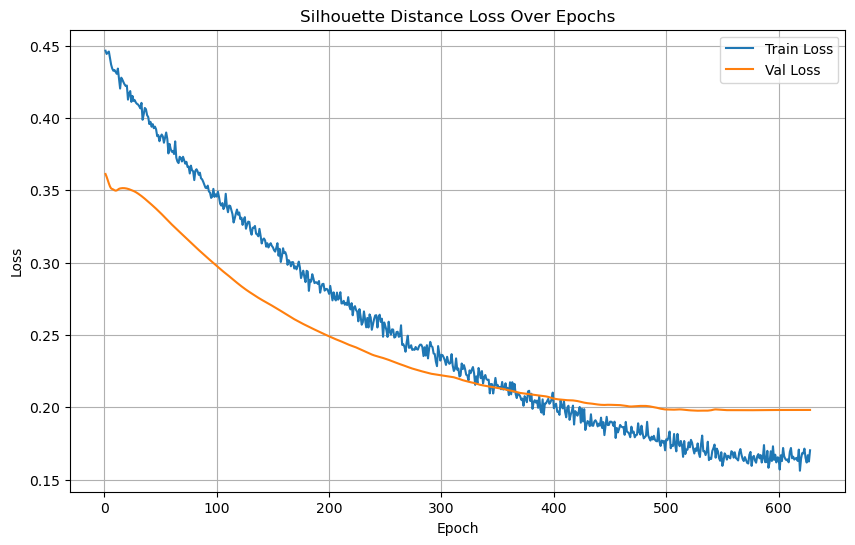

In [51]:
sclsdl_model = SupConNet().to(device)
sclsdl_criterion = SilhouetteDistanceLoss()
sclsdl_optimizer = optim.AdamW(sclsdl_model.parameters(), lr=0.0001, weight_decay=1e-5)
sclsdl_scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    sclsdl_optimizer, 
    mode='min',
    patience=25,
    factor=0.1
)

sclsdl_num_epochs = 2000

sclsdl_patience = 100
sclsdl_best_val_loss = float('inf')
sclsdl_epochs_without_improvement = 0

sclsdl_train_loss_history = []
sclsdl_val_loss_history = []

for sclsdl_epoch in range(sclsdl_num_epochs):
    # Training
    sclsdl_model.train()
    sclsdl_running_train_loss = 0.0
    
    print(f"LOG: Epoch [{sclsdl_epoch+1}/{sclsdl_num_epochs}] - Training")
    for batch_idx, (vectors, labels) in enumerate(sclsdl_train_loader):

        vectors = vectors.to(device).float()
        labels = labels.to(device)

        # Forward pass
        sclsdl_train_projections = sclsdl_model(vectors)

        sclsdl_loss = sclsdl_criterion(sclsdl_train_projections, labels)

        # Backprop and optimize
        sclsdl_optimizer.zero_grad()
        sclsdl_loss.backward()
        sclsdl_optimizer.step()

        sclsdl_running_train_loss += sclsdl_loss.item()
        print(f"    Batch [{batch_idx+1}/{len(sclsdl_train_loader)}], Train Loss: {sclsdl_loss.item():.4f}")

    sclsdl_train_epoch_loss = sclsdl_running_train_loss / len(sclsdl_train_loader)
    sclsdl_train_loss_history.append(sclsdl_train_epoch_loss)

    # Validation
    sclsdl_model.eval()
    sclsdl_running_val_loss = 0.0
    print(f"LOG: Epoch [{sclsdl_epoch+1}/{sclsdl_num_epochs}] - Validation")
    with torch.no_grad():
        for val_batch_idx, (vectors, labels) in enumerate(sclsdl_val_loader):

            vectors = vectors.to(device).float()
            labels = labels.to(device)

            sclsdl_val_projections = sclsdl_model(vectors)
            sclsdl_val_batch_loss = sclsdl_criterion(sclsdl_val_projections, labels).item()
            sclsdl_running_val_loss += sclsdl_val_batch_loss
            print(f"    Batch [{val_batch_idx+1}/{len(sclsdl_val_loader)}], Val Loss: {sclsdl_val_batch_loss:.4f}")

    sclsdl_val_epoch_loss = sclsdl_running_val_loss / len(sclsdl_val_loader)
    sclsdl_val_loss_history.append(sclsdl_val_epoch_loss)
    
    sclsdl_scheduler.step(sclsdl_val_epoch_loss)

    print(f"Epoch [{sclsdl_epoch+1}/{sclsdl_num_epochs}], "
          f"Avg Train Loss: {sclsdl_train_epoch_loss:.4f}, "
          f"Avg Val Loss: {sclsdl_val_epoch_loss:.4f}\n")
    
    #early stopping logic
    if sclsdl_val_epoch_loss < sclsdl_best_val_loss:
        print(f"Validation loss improved from {sclsdl_best_val_loss:.4f} to {sclsdl_val_epoch_loss:.4f}. Saving model...")
        sclsdl_best_val_loss = sclsdl_val_epoch_loss
        sclsdl_epochs_without_improvement = 0
    else:
        sclsdl_epochs_without_improvement += 1
        print(f"!! Validation loss did NOT improve !! Patience: {sclsdl_epochs_without_improvement}/{sclsdl_patience}")

    #stop training if val loss not improving
    if sclsdl_epochs_without_improvement >= sclsdl_patience:
        print(f"!! Early stopping triggered at epoch {sclsdl_epoch + 1}!!\nNo improvement for {sclsdl_patience} epochs")
        break

plt.figure(figsize=(10,6))
sclsdl_num_epochs_run = len(sclsdl_train_loss_history)
plt.plot(range(1, sclsdl_num_epochs_run + 1), sclsdl_train_loss_history, label='Train Loss')
plt.plot(range(1, sclsdl_num_epochs_run + 1), sclsdl_val_loss_history, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Silhouette Distance Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

Test Batch [10/2312], Loss: 0.0730
Test Batch [20/2312], Loss: 0.1313
Test Batch [30/2312], Loss: 0.5000
Test Batch [40/2312], Loss: 0.0516
Test Batch [50/2312], Loss: 0.5000
Test Batch [60/2312], Loss: 0.5000
Test Batch [70/2312], Loss: 0.5000


Test Batch [80/2312], Loss: 0.1207
Test Batch [90/2312], Loss: 0.5000
Test Batch [100/2312], Loss: 0.0440
Test Batch [110/2312], Loss: 0.5000
Test Batch [120/2312], Loss: 0.0710
Test Batch [130/2312], Loss: 0.5000
Test Batch [140/2312], Loss: 0.5000


Test Batch [150/2312], Loss: 0.5000
Test Batch [160/2312], Loss: 0.0849
Test Batch [170/2312], Loss: 0.5000
Test Batch [180/2312], Loss: 0.5000
Test Batch [190/2312], Loss: 0.5000
Test Batch [200/2312], Loss: 0.1350
Test Batch [210/2312], Loss: 0.5000


Test Batch [220/2312], Loss: 0.5000
Test Batch [230/2312], Loss: 0.0893
Test Batch [240/2312], Loss: 0.5000
Test Batch [250/2312], Loss: 0.1459
Test Batch [260/2312], Loss: 0.5000
Test Batch [270/2312], Loss: 0.5000


Test Batch [280/2312], Loss: 0.5000
Test Batch [290/2312], Loss: 0.0386
Test Batch [300/2312], Loss: 0.1442
Test Batch [310/2312], Loss: 0.5000
Test Batch [320/2312], Loss: 0.0845
Test Batch [330/2312], Loss: 0.5000
Test Batch [340/2312], Loss: 0.5000
Test Batch [350/2312], Loss: 0.0506


Test Batch [360/2312], Loss: 0.1424
Test Batch [370/2312], Loss: 0.1346
Test Batch [380/2312], Loss: 0.1245
Test Batch [390/2312], Loss: 0.0530
Test Batch [400/2312], Loss: 0.5000
Test Batch [410/2312], Loss: 0.0713
Test Batch [420/2312], Loss: 0.0894


Test Batch [430/2312], Loss: 0.1247
Test Batch [440/2312], Loss: 0.5000
Test Batch [450/2312], Loss: 0.0612
Test Batch [460/2312], Loss: 0.5000
Test Batch [470/2312], Loss: 0.0709
Test Batch [480/2312], Loss: 0.0337


Test Batch [490/2312], Loss: 0.5000
Test Batch [500/2312], Loss: 0.0546
Test Batch [510/2312], Loss: 0.5000
Test Batch [520/2312], Loss: 0.1462
Test Batch [530/2312], Loss: 0.5000
Test Batch [540/2312], Loss: 0.5000
Test Batch [550/2312], Loss: 0.0987


Test Batch [560/2312], Loss: 0.5000
Test Batch [570/2312], Loss: 0.5000
Test Batch [580/2312], Loss: 0.0206
Test Batch [590/2312], Loss: 0.0920
Test Batch [600/2312], Loss: 0.5000


Test Batch [610/2312], Loss: 0.5000
Test Batch [620/2312], Loss: 0.0509
Test Batch [630/2312], Loss: 0.0178
Test Batch [640/2312], Loss: 0.1014
Test Batch [650/2312], Loss: 0.5000


Test Batch [660/2312], Loss: 0.1085
Test Batch [670/2312], Loss: 0.0251
Test Batch [680/2312], Loss: 0.5000
Test Batch [690/2312], Loss: 0.5000
Test Batch [700/2312], Loss: 0.0471
Test Batch [710/2312], Loss: 0.0295


Test Batch [720/2312], Loss: 0.5000
Test Batch [730/2312], Loss: 0.0614
Test Batch [740/2312], Loss: 0.5000
Test Batch [750/2312], Loss: 0.0620
Test Batch [760/2312], Loss: 0.1209


Test Batch [770/2312], Loss: 0.5000
Test Batch [780/2312], Loss: 0.5000
Test Batch [790/2312], Loss: 0.0114
Test Batch [800/2312], Loss: 0.1071
Test Batch [810/2312], Loss: 0.5000
Test Batch [820/2312], Loss: 0.1276


Test Batch [830/2312], Loss: 0.5000
Test Batch [840/2312], Loss: 0.0715
Test Batch [850/2312], Loss: 0.1918
Test Batch [860/2312], Loss: 0.0388
Test Batch [870/2312], Loss: 0.1442
Test Batch [880/2312], Loss: 0.5000
Test Batch [890/2312], Loss: 0.5000


Test Batch [900/2312], Loss: 0.5000
Test Batch [910/2312], Loss: 0.5000
Test Batch [920/2312], Loss: 0.0484
Test Batch [930/2312], Loss: 0.1309
Test Batch [940/2312], Loss: 0.0743
Test Batch [950/2312], Loss: 0.5000
Test Batch [960/2312], Loss: 0.5000


Test Batch [970/2312], Loss: 0.5000
Test Batch [980/2312], Loss: 0.0852
Test Batch [990/2312], Loss: 0.0422
Test Batch [1000/2312], Loss: 0.0685
Test Batch [1010/2312], Loss: 0.0121
Test Batch [1020/2312], Loss: 0.1541


Test Batch [1030/2312], Loss: 0.5000
Test Batch [1040/2312], Loss: 0.0373
Test Batch [1050/2312], Loss: 0.1169
Test Batch [1060/2312], Loss: 0.0789
Test Batch [1070/2312], Loss: 0.0988
Test Batch [1080/2312], Loss: 0.0559


Test Batch [1090/2312], Loss: 0.1465
Test Batch [1100/2312], Loss: 0.0931
Test Batch [1110/2312], Loss: 0.1028
Test Batch [1120/2312], Loss: 0.0374
Test Batch [1130/2312], Loss: 0.0255
Test Batch [1140/2312], Loss: 0.5000


Test Batch [1150/2312], Loss: 0.0430
Test Batch [1160/2312], Loss: 0.1200
Test Batch [1170/2312], Loss: 0.1226
Test Batch [1180/2312], Loss: 0.1759
Test Batch [1190/2312], Loss: 0.5000


Test Batch [1200/2312], Loss: 0.1727
Test Batch [1210/2312], Loss: 0.1032
Test Batch [1220/2312], Loss: 0.1986
Test Batch [1230/2312], Loss: 0.1863
Test Batch [1240/2312], Loss: 0.1201


Test Batch [1250/2312], Loss: 0.5000
Test Batch [1260/2312], Loss: 0.0674
Test Batch [1270/2312], Loss: 0.1370
Test Batch [1280/2312], Loss: 0.1841
Test Batch [1290/2312], Loss: 0.1301


Test Batch [1300/2312], Loss: 0.0885
Test Batch [1310/2312], Loss: 0.1425
Test Batch [1320/2312], Loss: 0.1376
Test Batch [1330/2312], Loss: 0.1113


Test Batch [1340/2312], Loss: 0.0319
Test Batch [1350/2312], Loss: 0.1175
Test Batch [1360/2312], Loss: 0.2147
Test Batch [1370/2312], Loss: 0.1292


Test Batch [1380/2312], Loss: 0.1474
Test Batch [1390/2312], Loss: 0.1352
Test Batch [1400/2312], Loss: 0.1498


Test Batch [1410/2312], Loss: 0.1102
Test Batch [1420/2312], Loss: 0.1227
Test Batch [1430/2312], Loss: 0.5000
Test Batch [1440/2312], Loss: 0.1382


Test Batch [1450/2312], Loss: 0.1753
Test Batch [1460/2312], Loss: 0.1377
Test Batch [1470/2312], Loss: 0.0956
Test Batch [1480/2312], Loss: 0.1165


Test Batch [1490/2312], Loss: 0.1436
Test Batch [1500/2312], Loss: 0.0938
Test Batch [1510/2312], Loss: 0.5000
Test Batch [1520/2312], Loss: 0.5000


Test Batch [1530/2312], Loss: 0.0911
Test Batch [1540/2312], Loss: 0.1215
Test Batch [1550/2312], Loss: 0.1064
Test Batch [1560/2312], Loss: 0.1289


Test Batch [1570/2312], Loss: 0.1653
Test Batch [1580/2312], Loss: 0.1000
Test Batch [1590/2312], Loss: 0.1281
Test Batch [1600/2312], Loss: 0.0958


Test Batch [1610/2312], Loss: 0.1427
Test Batch [1620/2312], Loss: 0.1755
Test Batch [1630/2312], Loss: 0.1040
Test Batch [1640/2312], Loss: 0.0820


Test Batch [1650/2312], Loss: 0.0473
Test Batch [1660/2312], Loss: 0.1303
Test Batch [1670/2312], Loss: 0.1710
Test Batch [1680/2312], Loss: 0.1401


Test Batch [1690/2312], Loss: 0.1882
Test Batch [1700/2312], Loss: 0.1323
Test Batch [1710/2312], Loss: 0.1333
Test Batch [1720/2312], Loss: 0.0553
Test Batch [1730/2312], Loss: 0.1479
Test Batch [1740/2312], Loss: 0.5000


Test Batch [1750/2312], Loss: 0.0760
Test Batch [1760/2312], Loss: 0.0974
Test Batch [1770/2312], Loss: 0.0703
Test Batch [1780/2312], Loss: 0.0746
Test Batch [1790/2312], Loss: 0.1049
Test Batch [1800/2312], Loss: 0.1005
Test Batch [1810/2312], Loss: 0.0919


Test Batch [1820/2312], Loss: 0.1419
Test Batch [1830/2312], Loss: 0.0372
Test Batch [1840/2312], Loss: 0.1890
Test Batch [1850/2312], Loss: 0.1271
Test Batch [1860/2312], Loss: 0.1111


Test Batch [1870/2312], Loss: 0.1050
Test Batch [1880/2312], Loss: 0.1402
Test Batch [1890/2312], Loss: 0.1214
Test Batch [1900/2312], Loss: 0.1241


Test Batch [1910/2312], Loss: 0.1892
Test Batch [1920/2312], Loss: 0.2054
Test Batch [1930/2312], Loss: 0.1492
Test Batch [1940/2312], Loss: 0.1571
Test Batch [1950/2312], Loss: 0.1217


Test Batch [1960/2312], Loss: 0.1337
Test Batch [1970/2312], Loss: 0.1411
Test Batch [1980/2312], Loss: 0.0817
Test Batch [1990/2312], Loss: 0.0890
Test Batch [2000/2312], Loss: 0.0965
Test Batch [2010/2312], Loss: 0.0923
Test Batch [2020/2312], Loss: 0.1081


Test Batch [2030/2312], Loss: 0.0874
Test Batch [2040/2312], Loss: 0.1122
Test Batch [2050/2312], Loss: 0.1277
Test Batch [2060/2312], Loss: 0.1601


Test Batch [2070/2312], Loss: 0.1456
Test Batch [2080/2312], Loss: 0.5000
Test Batch [2090/2312], Loss: 0.1213
Test Batch [2100/2312], Loss: 0.1640
Test Batch [2110/2312], Loss: 0.1362
Test Batch [2120/2312], Loss: 0.1925
Test Batch [2130/2312], Loss: 0.0397


Test Batch [2140/2312], Loss: 0.1147
Test Batch [2150/2312], Loss: 0.1752
Test Batch [2160/2312], Loss: 0.0200
Test Batch [2170/2312], Loss: 0.5000
Test Batch [2180/2312], Loss: 0.5000
Test Batch [2190/2312], Loss: 0.5000
Test Batch [2200/2312], Loss: 0.5000


Test Batch [2210/2312], Loss: 0.5000
Test Batch [2220/2312], Loss: 0.0966
Test Batch [2230/2312], Loss: 0.0223
Test Batch [2240/2312], Loss: 0.0877
Test Batch [2250/2312], Loss: 0.0320
Test Batch [2260/2312], Loss: 0.5000
Test Batch [2270/2312], Loss: 0.0892


Test Batch [2280/2312], Loss: 0.5000
Test Batch [2290/2312], Loss: 0.0333
Test Batch [2300/2312], Loss: 0.5000
Test Batch [2310/2312], Loss: 0.5000

Test Loss: 0.2211


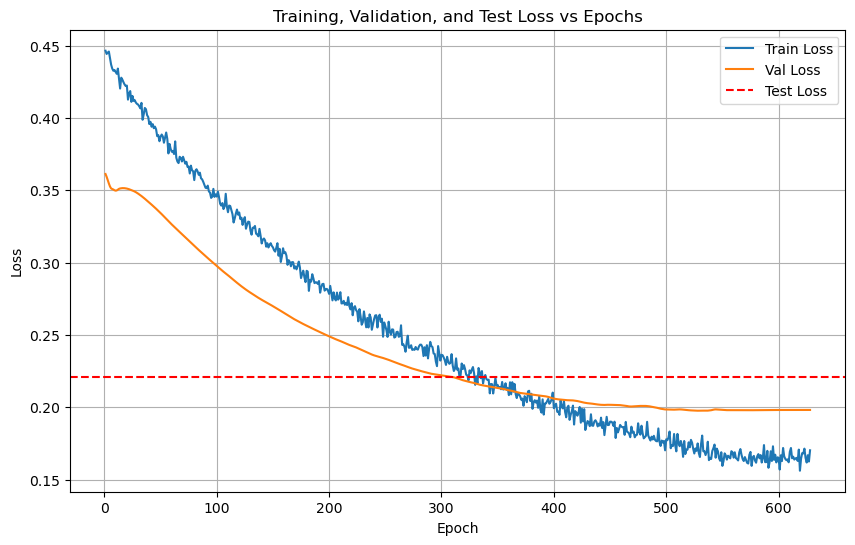

In [52]:
# Test Evaluation
sclsdl_model.eval()
sclsdl_total_test_loss = 0.0

with torch.no_grad():
    for batch_idx, (vectors, labels) in enumerate(sclsdl_test_loader):
        vectors = vectors.to(device).float()
        labels = labels.to(device)
        projections = sclsdl_model(vectors)
        loss = sclsdl_criterion(projections, labels)
        sclsdl_total_test_loss += loss.item()
        if (batch_idx + 1) % 10 == 0:
            print(f"Test Batch [{batch_idx + 1}/{len(sclsdl_test_loader)}], Loss: {loss.item():.4f}")

sclsdl_avg_test_loss = sclsdl_total_test_loss / len(sclsdl_test_loader)
print(f"\nTest Loss: {sclsdl_avg_test_loss:.4f}")


plt.figure(figsize=(10, 6))
sclsdl_num_epochs_run = len(sclsdl_train_loss_history)
plt.plot(range(1, sclsdl_num_epochs_run + 1), sclsdl_train_loss_history, label='Train Loss')
plt.plot(range(1, sclsdl_num_epochs_run + 1), sclsdl_val_loss_history, label='Val Loss')
# test loss = horizontal dashed line
plt.axhline(y=sclsdl_avg_test_loss, color='r', linestyle='--', label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training, Validation, and Test Loss vs Epochs")
plt.legend()
plt.grid(True)
plt.show()

### Saving the representations learnt by SCL w/ SDL Model

In [53]:
# dir to save the SCL representations
sclsdl_rep_dir = "sclsdl_representations"
os.makedirs(sclsdl_rep_dir, exist_ok=True)

sclsdl_loaders = {
    'train': sclsdl_train_loader,
    'val': sclsdl_val_loader,
    'test': sclsdl_test_loader
}

sclsdl_model.eval()

with torch.no_grad():
    for sclsdl_split_name, sclsdl_loader in sclsdl_loaders.items():
        print(f"\nExtracting SCL_SDL representations for the {sclsdl_split_name} dataset...")
        # creating subfolder for the split
        sclsdl_split_dir = os.path.join(sclsdl_rep_dir, sclsdl_split_name)
        os.makedirs(sclsdl_split_dir, exist_ok=True)
        
        # processing the data batch-wise
        for sclsdl_batch_idx, (sclsdl_vectors, sclsdl_labels) in enumerate(sclsdl_loader):
            sclsdl_vectors = sclsdl_vectors.to(device).float()
            # computing projections using the trained SCL model
            sclsdl_projections = sclsdl_model(sclsdl_vectors)
            
            # converting projections and labels to np arrays
            sclsdl_projections_np = sclsdl_projections.cpu().numpy()
            sclsdl_labels_np = sclsdl_labels.cpu().numpy()
            
            # saving the batch projections and labels
            np.save(os.path.join(sclsdl_split_dir, f"scl_encoded_batch_{sclsdl_batch_idx}.npy"), sclsdl_projections_np)
            np.save(os.path.join(sclsdl_split_dir, f"scl_labels_batch_{sclsdl_batch_idx}.npy"), sclsdl_labels_np)
            
            if (sclsdl_batch_idx + 1) % 10 == 0:
                print(f"  Processed batch {sclsdl_batch_idx + 1}/{len(sclsdl_loader)} for {sclsdl_split_name} dataset.")

        print(f"Completed extraction for the {sclsdl_split_name} dataset. Representations saved in '{sclsdl_split_dir}'.")

print("SCL representations extraction complete.")


Extracting SCL_SDL representations for the train dataset...
Completed extraction for the train dataset. Representations saved in 'sclsdl_representations\train'.

Extracting SCL_SDL representations for the val dataset...
Completed extraction for the val dataset. Representations saved in 'sclsdl_representations\val'.

Extracting SCL_SDL representations for the test dataset...
  Processed batch 10/2312 for test dataset.
  Processed batch 20/2312 for test dataset.
  Processed batch 30/2312 for test dataset.


  Processed batch 40/2312 for test dataset.
  Processed batch 50/2312 for test dataset.
  Processed batch 60/2312 for test dataset.
  Processed batch 70/2312 for test dataset.


  Processed batch 80/2312 for test dataset.
  Processed batch 90/2312 for test dataset.
  Processed batch 100/2312 for test dataset.
  Processed batch 110/2312 for test dataset.


  Processed batch 120/2312 for test dataset.
  Processed batch 130/2312 for test dataset.
  Processed batch 140/2312 for test dataset.
  Processed batch 150/2312 for test dataset.


  Processed batch 160/2312 for test dataset.
  Processed batch 170/2312 for test dataset.
  Processed batch 180/2312 for test dataset.
  Processed batch 190/2312 for test dataset.


  Processed batch 200/2312 for test dataset.
  Processed batch 210/2312 for test dataset.
  Processed batch 220/2312 for test dataset.
  Processed batch 230/2312 for test dataset.


  Processed batch 240/2312 for test dataset.
  Processed batch 250/2312 for test dataset.
  Processed batch 260/2312 for test dataset.
  Processed batch 270/2312 for test dataset.


  Processed batch 280/2312 for test dataset.
  Processed batch 290/2312 for test dataset.
  Processed batch 300/2312 for test dataset.
  Processed batch 310/2312 for test dataset.


  Processed batch 320/2312 for test dataset.
  Processed batch 330/2312 for test dataset.
  Processed batch 340/2312 for test dataset.
  Processed batch 350/2312 for test dataset.


  Processed batch 360/2312 for test dataset.
  Processed batch 370/2312 for test dataset.
  Processed batch 380/2312 for test dataset.
  Processed batch 390/2312 for test dataset.


  Processed batch 400/2312 for test dataset.
  Processed batch 410/2312 for test dataset.
  Processed batch 420/2312 for test dataset.
  Processed batch 430/2312 for test dataset.


  Processed batch 440/2312 for test dataset.
  Processed batch 450/2312 for test dataset.
  Processed batch 460/2312 for test dataset.
  Processed batch 470/2312 for test dataset.


  Processed batch 480/2312 for test dataset.
  Processed batch 490/2312 for test dataset.
  Processed batch 500/2312 for test dataset.
  Processed batch 510/2312 for test dataset.


  Processed batch 520/2312 for test dataset.
  Processed batch 530/2312 for test dataset.
  Processed batch 540/2312 for test dataset.
  Processed batch 550/2312 for test dataset.


  Processed batch 560/2312 for test dataset.
  Processed batch 570/2312 for test dataset.
  Processed batch 580/2312 for test dataset.
  Processed batch 590/2312 for test dataset.


  Processed batch 600/2312 for test dataset.
  Processed batch 610/2312 for test dataset.
  Processed batch 620/2312 for test dataset.
  Processed batch 630/2312 for test dataset.


  Processed batch 640/2312 for test dataset.
  Processed batch 650/2312 for test dataset.
  Processed batch 660/2312 for test dataset.


  Processed batch 670/2312 for test dataset.
  Processed batch 680/2312 for test dataset.
  Processed batch 690/2312 for test dataset.
  Processed batch 700/2312 for test dataset.


  Processed batch 710/2312 for test dataset.
  Processed batch 720/2312 for test dataset.
  Processed batch 730/2312 for test dataset.
  Processed batch 740/2312 for test dataset.


  Processed batch 750/2312 for test dataset.
  Processed batch 760/2312 for test dataset.
  Processed batch 770/2312 for test dataset.
  Processed batch 780/2312 for test dataset.


  Processed batch 790/2312 for test dataset.
  Processed batch 800/2312 for test dataset.
  Processed batch 810/2312 for test dataset.
  Processed batch 820/2312 for test dataset.


  Processed batch 830/2312 for test dataset.
  Processed batch 840/2312 for test dataset.
  Processed batch 850/2312 for test dataset.
  Processed batch 860/2312 for test dataset.


  Processed batch 870/2312 for test dataset.
  Processed batch 880/2312 for test dataset.
  Processed batch 890/2312 for test dataset.
  Processed batch 900/2312 for test dataset.


  Processed batch 910/2312 for test dataset.
  Processed batch 920/2312 for test dataset.
  Processed batch 930/2312 for test dataset.
  Processed batch 940/2312 for test dataset.


  Processed batch 950/2312 for test dataset.
  Processed batch 960/2312 for test dataset.
  Processed batch 970/2312 for test dataset.
  Processed batch 980/2312 for test dataset.


  Processed batch 990/2312 for test dataset.
  Processed batch 1000/2312 for test dataset.
  Processed batch 1010/2312 for test dataset.
  Processed batch 1020/2312 for test dataset.


  Processed batch 1030/2312 for test dataset.
  Processed batch 1040/2312 for test dataset.
  Processed batch 1050/2312 for test dataset.
  Processed batch 1060/2312 for test dataset.


  Processed batch 1070/2312 for test dataset.
  Processed batch 1080/2312 for test dataset.
  Processed batch 1090/2312 for test dataset.
  Processed batch 1100/2312 for test dataset.


  Processed batch 1110/2312 for test dataset.
  Processed batch 1120/2312 for test dataset.
  Processed batch 1130/2312 for test dataset.


  Processed batch 1140/2312 for test dataset.
  Processed batch 1150/2312 for test dataset.
  Processed batch 1160/2312 for test dataset.


  Processed batch 1170/2312 for test dataset.
  Processed batch 1180/2312 for test dataset.
  Processed batch 1190/2312 for test dataset.


  Processed batch 1200/2312 for test dataset.
  Processed batch 1210/2312 for test dataset.
  Processed batch 1220/2312 for test dataset.
  Processed batch 1230/2312 for test dataset.


  Processed batch 1240/2312 for test dataset.
  Processed batch 1250/2312 for test dataset.
  Processed batch 1260/2312 for test dataset.
  Processed batch 1270/2312 for test dataset.


  Processed batch 1280/2312 for test dataset.
  Processed batch 1290/2312 for test dataset.
  Processed batch 1300/2312 for test dataset.
  Processed batch 1310/2312 for test dataset.


  Processed batch 1320/2312 for test dataset.
  Processed batch 1330/2312 for test dataset.
  Processed batch 1340/2312 for test dataset.
  Processed batch 1350/2312 for test dataset.


  Processed batch 1360/2312 for test dataset.
  Processed batch 1370/2312 for test dataset.
  Processed batch 1380/2312 for test dataset.
  Processed batch 1390/2312 for test dataset.


  Processed batch 1400/2312 for test dataset.
  Processed batch 1410/2312 for test dataset.
  Processed batch 1420/2312 for test dataset.
  Processed batch 1430/2312 for test dataset.


  Processed batch 1440/2312 for test dataset.
  Processed batch 1450/2312 for test dataset.
  Processed batch 1460/2312 for test dataset.


  Processed batch 1470/2312 for test dataset.
  Processed batch 1480/2312 for test dataset.
  Processed batch 1490/2312 for test dataset.
  Processed batch 1500/2312 for test dataset.


  Processed batch 1510/2312 for test dataset.
  Processed batch 1520/2312 for test dataset.
  Processed batch 1530/2312 for test dataset.
  Processed batch 1540/2312 for test dataset.


  Processed batch 1550/2312 for test dataset.
  Processed batch 1560/2312 for test dataset.
  Processed batch 1570/2312 for test dataset.
  Processed batch 1580/2312 for test dataset.


  Processed batch 1590/2312 for test dataset.
  Processed batch 1600/2312 for test dataset.
  Processed batch 1610/2312 for test dataset.
  Processed batch 1620/2312 for test dataset.


  Processed batch 1630/2312 for test dataset.
  Processed batch 1640/2312 for test dataset.
  Processed batch 1650/2312 for test dataset.
  Processed batch 1660/2312 for test dataset.


  Processed batch 1670/2312 for test dataset.
  Processed batch 1680/2312 for test dataset.
  Processed batch 1690/2312 for test dataset.


  Processed batch 1700/2312 for test dataset.
  Processed batch 1710/2312 for test dataset.
  Processed batch 1720/2312 for test dataset.
  Processed batch 1730/2312 for test dataset.


  Processed batch 1740/2312 for test dataset.
  Processed batch 1750/2312 for test dataset.
  Processed batch 1760/2312 for test dataset.
  Processed batch 1770/2312 for test dataset.


  Processed batch 1780/2312 for test dataset.
  Processed batch 1790/2312 for test dataset.
  Processed batch 1800/2312 for test dataset.
  Processed batch 1810/2312 for test dataset.


  Processed batch 1820/2312 for test dataset.
  Processed batch 1830/2312 for test dataset.
  Processed batch 1840/2312 for test dataset.
  Processed batch 1850/2312 for test dataset.


  Processed batch 1860/2312 for test dataset.
  Processed batch 1870/2312 for test dataset.
  Processed batch 1880/2312 for test dataset.
  Processed batch 1890/2312 for test dataset.


  Processed batch 1900/2312 for test dataset.
  Processed batch 1910/2312 for test dataset.
  Processed batch 1920/2312 for test dataset.
  Processed batch 1930/2312 for test dataset.


  Processed batch 1940/2312 for test dataset.
  Processed batch 1950/2312 for test dataset.
  Processed batch 1960/2312 for test dataset.
  Processed batch 1970/2312 for test dataset.


  Processed batch 1980/2312 for test dataset.
  Processed batch 1990/2312 for test dataset.
  Processed batch 2000/2312 for test dataset.
  Processed batch 2010/2312 for test dataset.


  Processed batch 2020/2312 for test dataset.
  Processed batch 2030/2312 for test dataset.
  Processed batch 2040/2312 for test dataset.


  Processed batch 2050/2312 for test dataset.
  Processed batch 2060/2312 for test dataset.
  Processed batch 2070/2312 for test dataset.
  Processed batch 2080/2312 for test dataset.


  Processed batch 2090/2312 for test dataset.
  Processed batch 2100/2312 for test dataset.
  Processed batch 2110/2312 for test dataset.
  Processed batch 2120/2312 for test dataset.


  Processed batch 2130/2312 for test dataset.
  Processed batch 2140/2312 for test dataset.
  Processed batch 2150/2312 for test dataset.
  Processed batch 2160/2312 for test dataset.


  Processed batch 2170/2312 for test dataset.
  Processed batch 2180/2312 for test dataset.
  Processed batch 2190/2312 for test dataset.
  Processed batch 2200/2312 for test dataset.


  Processed batch 2210/2312 for test dataset.
  Processed batch 2220/2312 for test dataset.
  Processed batch 2230/2312 for test dataset.


  Processed batch 2240/2312 for test dataset.
  Processed batch 2250/2312 for test dataset.
  Processed batch 2260/2312 for test dataset.
  Processed batch 2270/2312 for test dataset.


  Processed batch 2280/2312 for test dataset.
  Processed batch 2290/2312 for test dataset.
  Processed batch 2300/2312 for test dataset.
  Processed batch 2310/2312 for test dataset.


Completed extraction for the test dataset. Representations saved in 'sclsdl_representations\test'.
SCL representations extraction complete.


### Classifying the representations learnt by SCL w/ SDL Model with LRM

In [54]:
def load_sclsdl_reps_and_labels(split_dir):
    #gather all the scl_encoded_batch npy files in sorted order
    sclsdl_rep_files = sorted(glob.glob(os.path.join(split_dir, "scl_encoded_batch_*.npy")))

    sclsdl_all_reps = []
    sclsdl_all_labels = []

    for sclsdl_rep_file in sclsdl_rep_files:
        #deriving label filenames
        sclsdl_label_file = sclsdl_rep_file.replace("scl_encoded_batch_", "scl_labels_batch_")

        sclsdl_reps = np.load(sclsdl_rep_file)
        sclsdl_labels = np.load(sclsdl_label_file)

        sclsdl_all_reps.append(sclsdl_reps)
        sclsdl_all_labels.append(sclsdl_labels)

    #concat along first dim
    sclsdl_all_reps = np.concatenate(sclsdl_all_reps, axis = 0)
    sclsdl_all_labels = np.concatenate(sclsdl_all_labels, axis = 0)

    return sclsdl_all_reps, sclsdl_all_labels

In [55]:
sclsdl_lrm_train_dir = os.path.join("sclsdl_representations", "train")
sclsdl_lrm_val_dir   = os.path.join("sclsdl_representations", "val")
sclsdl_lrm_test_dir  = os.path.join("sclsdl_representations", "test")

sclsdl_lrm_train_reps, sclsdl_lrm_train_labels = load_sclsdl_reps_and_labels(sclsdl_lrm_train_dir)
sclsdl_lrm_val_reps, sclsdl_lrm_val_labels = load_sclsdl_reps_and_labels(sclsdl_lrm_val_dir)
sclsdl_lrm_test_reps, sclsdl_lrm_test_labels = load_sclsdl_reps_and_labels(sclsdl_lrm_test_dir)

print("Train reps shape:", sclsdl_lrm_train_reps.shape)
print("Train labels shape:", sclsdl_lrm_train_labels.shape)

print("Val reps shape:", sclsdl_lrm_val_reps.shape)
print("Val labels shape:", sclsdl_lrm_val_labels.shape)

print("Test reps shape:", sclsdl_lrm_test_reps.shape)
print("Test labels shape:", sclsdl_lrm_test_labels.shape)

Train reps shape: (180, 128)
Train labels shape: (180,)
Val reps shape: (45, 128)
Val labels shape: (45,)
Test reps shape: (147927, 128)
Test labels shape: (147927,)


In [56]:
# Train Logistic Regression Model on the SCLSDL representations
print("\nLOG: Training Logistic Regression model on SCL SDL representations...")
sclsdl_logistic_clf = LogisticRegression(max_iter=5000, random_state=42, class_weight='balanced')
sclsdl_logistic_clf.fit(sclsdl_lrm_train_reps, sclsdl_lrm_train_labels)
print("LOG: Logistic Regression training complete.")

# Evaluate on Validation Set
print("\nLOG: Evaluating on the validation set...")
sclsdl_lrm_val_predictions = sclsdl_logistic_clf.predict(sclsdl_lrm_val_reps)
sclsdl_lrm_val_accuracy = accuracy_score(sclsdl_lrm_val_labels, sclsdl_lrm_val_predictions)
print(f"Validation Accuracy: {sclsdl_lrm_val_accuracy * 100:.2f}%")
print("\nValidation Classification Report:\n", classification_report(sclsdl_lrm_val_labels, sclsdl_lrm_val_predictions))

# Evaluate on Test Set
print("\nLOG: Evaluating on the test set...")
sclsdl_lrm_test_predictions = sclsdl_logistic_clf.predict(sclsdl_lrm_test_reps)
sclsdl_lrm_test_accuracy = accuracy_score(sclsdl_lrm_test_labels, sclsdl_lrm_test_predictions)
print(f"Test Accuracy: {sclsdl_lrm_test_accuracy * 100:.2f}%")
print("\nTest Classification Report:\n", classification_report(sclsdl_lrm_test_labels, sclsdl_lrm_test_predictions))

np.save(os.path.join(predictions_dir, 'sclsdl_lrm_predictions.npy'), sclsdl_lrm_test_predictions)
np.save(os.path.join(predictions_dir, 'sclsdl_lrm_true_labels.npy'), sclsdl_lrm_test_labels)
print(f"Saved SCL_SDL+LRM predictions and true labels to {predictions_dir}")


LOG: Training Logistic Regression model on SCL SDL representations...
LOG: Logistic Regression training complete.

LOG: Evaluating on the validation set...
Validation Accuracy: 88.89%

Validation Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       0.67      0.80      0.73         5
           2       0.75      0.60      0.67         5
           3       1.00      0.80      0.89         5
           4       0.83      1.00      0.91         5
           5       1.00      0.80      0.89         5
           6       0.83      1.00      0.91         5
           7       1.00      1.00      1.00         5
           8       1.00      1.00      1.00         5

    accuracy                           0.89        45
   macro avg       0.90      0.89      0.89        45
weighted avg       0.90      0.89      0.89        45


LOG: Evaluating on the test set...
Test Accuracy: 96.16%



Test Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.99      1.00     65946
           1       0.96      0.90      0.93      7573
           2       0.75      0.88      0.81      3065
           3       0.69      0.80      0.74      2660
           4       0.85      0.92      0.88      6559
           5       0.85      0.89      0.87      9223
           6       0.88      0.88      0.88      7262
           7       1.00      0.97      0.99     42801
           8       1.00      0.99      0.99      2838

    accuracy                           0.96    147927
   macro avg       0.89      0.91      0.90    147927
weighted avg       0.96      0.96      0.96    147927

Saved SCL_SDL+LRM predictions and true labels to model_predictions


## Classifying the representations learnt by SCL w/ SDL Model with MLP Classifier

In [57]:
sclsdl_mlp_train_dir = os.path.join("sclsdl_representations", "train")
sclsdl_mlp_val_dir   = os.path.join("sclsdl_representations", "val")
sclsdl_mlp_test_dir  = os.path.join("sclsdl_representations", "test")

sclsdl_mlp_train_reps, sclsdl_mlp_train_labels = load_sclsdl_reps_and_labels(sclsdl_mlp_train_dir)
sclsdl_mlp_val_reps, sclsdl_mlp_val_labels = load_sclsdl_reps_and_labels(sclsdl_mlp_val_dir)
sclsdl_mlp_test_reps, sclsdl_mlp_test_labels = load_sclsdl_reps_and_labels(sclsdl_mlp_test_dir)

print("Train reps shape:", sclsdl_mlp_train_reps.shape)
print("Train labels shape:", sclsdl_mlp_train_labels.shape)

print("Val reps shape:", sclsdl_mlp_val_reps.shape)
print("Val labels shape:", sclsdl_mlp_val_labels.shape)

print("Test reps shape:", sclsdl_mlp_test_reps.shape)
print("Test labels shape:", sclsdl_mlp_test_labels.shape)

Train reps shape: (180, 128)
Train labels shape: (180,)
Val reps shape: (45, 128)
Val labels shape: (45,)
Test reps shape: (147927, 128)
Test labels shape: (147927,)


In [58]:
#converting arrays to torch tensors
sclsdl_mlp_train_embeddings_torch = torch.tensor(sclsdl_mlp_train_reps, dtype=torch.float32)
sclsdl_mlp_train_labels_torch = torch.tensor(sclsdl_mlp_train_labels, dtype=torch.long)

sclsdl_mlp_val_embeddings_torch = torch.tensor(sclsdl_mlp_val_reps, dtype=torch.float32)
sclsdl_mlp_val_labels_torch = torch.tensor(sclsdl_mlp_val_labels, dtype=torch.long)

sclsdl_mlp_test_embeddings_torch = torch.tensor(sclsdl_mlp_test_reps, dtype=torch.float32)
sclsdl_mlp_test_labels_torch = torch.tensor(sclsdl_mlp_test_labels, dtype=torch.long)

#building datasets for mlp
sclsdl_mlp_train_dataset = TensorDataset(sclsdl_mlp_train_embeddings_torch, sclsdl_mlp_train_labels_torch)
sclsdl_mlp_val_dataset = TensorDataset(sclsdl_mlp_val_embeddings_torch, sclsdl_mlp_val_labels_torch)
sclsdl_mlp_test_dataset = TensorDataset(sclsdl_mlp_test_embeddings_torch, sclsdl_mlp_test_labels_torch)

sclsdl_mlp_batch_size = 64
sclsdl_mlp_train_loader = DataLoader(sclsdl_mlp_train_dataset, batch_size=sclsdl_mlp_batch_size, shuffle=True)
sclsdl_mlp_val_loader = DataLoader(sclsdl_mlp_val_dataset, batch_size=sclsdl_mlp_batch_size, shuffle=False)
sclsdl_mlp_test_loader = DataLoader(sclsdl_mlp_test_dataset, batch_size=sclsdl_mlp_batch_size, shuffle=False)


[Epoch 1/1000] Train Loss: 2.3018  |  Val Loss: 2.3013
Validation loss improved from inf to 2.3013.
[Epoch 2/1000] Train Loss: 2.2341  |  Val Loss: 2.2420
Validation loss improved from 2.3013 to 2.2420.
[Epoch 3/1000] Train Loss: 2.1740  |  Val Loss: 2.1869
Validation loss improved from 2.2420 to 2.1869.
[Epoch 4/1000] Train Loss: 2.1170  |  Val Loss: 2.1339
Validation loss improved from 2.1869 to 2.1339.
[Epoch 5/1000] Train Loss: 2.0649  |  Val Loss: 2.0821
Validation loss improved from 2.1339 to 2.0821.
[Epoch 6/1000] Train Loss: 2.0131  |  Val Loss: 2.0323
Validation loss improved from 2.0821 to 2.0323.
[Epoch 7/1000] Train Loss: 1.9631  |  Val Loss: 1.9864
Validation loss improved from 2.0323 to 1.9864.
[Epoch 8/1000] Train Loss: 1.9185  |  Val Loss: 1.9429
Validation loss improved from 1.9864 to 1.9429.
[Epoch 9/1000] Train Loss: 1.8743  |  Val Loss: 1.9009
Validation loss improved from 1.9429 to 1.9009.
[Epoch 10/1000] Train Loss: 1.8326  |  Val Loss: 1.8602
Validation loss impr

[Epoch 24/1000] Train Loss: 1.3589  |  Val Loss: 1.3917
Validation loss improved from 1.4189 to 1.3917.
[Epoch 25/1000] Train Loss: 1.3306  |  Val Loss: 1.3658
Validation loss improved from 1.3917 to 1.3658.
[Epoch 26/1000] Train Loss: 1.3034  |  Val Loss: 1.3407
Validation loss improved from 1.3658 to 1.3407.
[Epoch 27/1000] Train Loss: 1.2769  |  Val Loss: 1.3164
Validation loss improved from 1.3407 to 1.3164.
[Epoch 28/1000] Train Loss: 1.2513  |  Val Loss: 1.2929
Validation loss improved from 1.3164 to 1.2929.
[Epoch 29/1000] Train Loss: 1.2266  |  Val Loss: 1.2698
Validation loss improved from 1.2929 to 1.2698.
[Epoch 30/1000] Train Loss: 1.2023  |  Val Loss: 1.2473
Validation loss improved from 1.2698 to 1.2473.
[Epoch 31/1000] Train Loss: 1.1784  |  Val Loss: 1.2254
Validation loss improved from 1.2473 to 1.2254.
[Epoch 32/1000] Train Loss: 1.1559  |  Val Loss: 1.2038
Validation loss improved from 1.2254 to 1.2038.


[Epoch 33/1000] Train Loss: 1.1333  |  Val Loss: 1.1827
Validation loss improved from 1.2038 to 1.1827.
[Epoch 34/1000] Train Loss: 1.1112  |  Val Loss: 1.1622
Validation loss improved from 1.1827 to 1.1622.
[Epoch 35/1000] Train Loss: 1.0897  |  Val Loss: 1.1421
Validation loss improved from 1.1622 to 1.1421.
[Epoch 36/1000] Train Loss: 1.0690  |  Val Loss: 1.1221
Validation loss improved from 1.1421 to 1.1221.
[Epoch 37/1000] Train Loss: 1.0475  |  Val Loss: 1.1026
Validation loss improved from 1.1221 to 1.1026.
[Epoch 38/1000] Train Loss: 1.0270  |  Val Loss: 1.0834
Validation loss improved from 1.1026 to 1.0834.
[Epoch 39/1000] Train Loss: 1.0066  |  Val Loss: 1.0645
Validation loss improved from 1.0834 to 1.0645.
[Epoch 40/1000] Train Loss: 0.9862  |  Val Loss: 1.0459
Validation loss improved from 1.0645 to 1.0459.
[Epoch 41/1000] Train Loss: 0.9669  |  Val Loss: 1.0275
Validation loss improved from 1.0459 to 1.0275.
[Epoch 42/1000] Train Loss: 0.9470  |  Val Loss: 1.0096
Validati

[Epoch 56/1000] Train Loss: 0.7007  |  Val Loss: 0.7868
Validation loss improved from 0.8014 to 0.7868.
[Epoch 57/1000] Train Loss: 0.6851  |  Val Loss: 0.7727
Validation loss improved from 0.7868 to 0.7727.
[Epoch 58/1000] Train Loss: 0.6697  |  Val Loss: 0.7591
Validation loss improved from 0.7727 to 0.7591.
[Epoch 59/1000] Train Loss: 0.6545  |  Val Loss: 0.7455
Validation loss improved from 0.7591 to 0.7455.
[Epoch 60/1000] Train Loss: 0.6402  |  Val Loss: 0.7321
Validation loss improved from 0.7455 to 0.7321.
[Epoch 61/1000] Train Loss: 0.6255  |  Val Loss: 0.7190
Validation loss improved from 0.7321 to 0.7190.
[Epoch 62/1000] Train Loss: 0.6115  |  Val Loss: 0.7060
Validation loss improved from 0.7190 to 0.7060.
[Epoch 63/1000] Train Loss: 0.5977  |  Val Loss: 0.6933
Validation loss improved from 0.7060 to 0.6933.
[Epoch 64/1000] Train Loss: 0.5844  |  Val Loss: 0.6807
Validation loss improved from 0.6933 to 0.6807.
[Epoch 65/1000] Train Loss: 0.5700  |  Val Loss: 0.6684
Validati

[Epoch 66/1000] Train Loss: 0.5569  |  Val Loss: 0.6563
Validation loss improved from 0.6684 to 0.6563.
[Epoch 67/1000] Train Loss: 0.5440  |  Val Loss: 0.6443
Validation loss improved from 0.6563 to 0.6443.
[Epoch 68/1000] Train Loss: 0.5308  |  Val Loss: 0.6321
Validation loss improved from 0.6443 to 0.6321.
[Epoch 69/1000] Train Loss: 0.5178  |  Val Loss: 0.6204
Validation loss improved from 0.6321 to 0.6204.
[Epoch 70/1000] Train Loss: 0.5052  |  Val Loss: 0.6090
Validation loss improved from 0.6204 to 0.6090.
[Epoch 71/1000] Train Loss: 0.4928  |  Val Loss: 0.5980
Validation loss improved from 0.6090 to 0.5980.
[Epoch 72/1000] Train Loss: 0.4806  |  Val Loss: 0.5869
Validation loss improved from 0.5980 to 0.5869.
[Epoch 73/1000] Train Loss: 0.4682  |  Val Loss: 0.5761
Validation loss improved from 0.5869 to 0.5761.
[Epoch 74/1000] Train Loss: 0.4566  |  Val Loss: 0.5653
Validation loss improved from 0.5761 to 0.5653.
[Epoch 75/1000] Train Loss: 0.4455  |  Val Loss: 0.5545
Validati

[Epoch 85/1000] Train Loss: 0.3444  |  Val Loss: 0.4601
Validation loss improved from 0.4688 to 0.4601.
[Epoch 86/1000] Train Loss: 0.3355  |  Val Loss: 0.4517
Validation loss improved from 0.4601 to 0.4517.
[Epoch 87/1000] Train Loss: 0.3275  |  Val Loss: 0.4435
Validation loss improved from 0.4517 to 0.4435.
[Epoch 88/1000] Train Loss: 0.3197  |  Val Loss: 0.4356
Validation loss improved from 0.4435 to 0.4356.
[Epoch 89/1000] Train Loss: 0.3116  |  Val Loss: 0.4277
Validation loss improved from 0.4356 to 0.4277.
[Epoch 90/1000] Train Loss: 0.3038  |  Val Loss: 0.4199
Validation loss improved from 0.4277 to 0.4199.
[Epoch 91/1000] Train Loss: 0.2965  |  Val Loss: 0.4125
Validation loss improved from 0.4199 to 0.4125.
[Epoch 92/1000] Train Loss: 0.2896  |  Val Loss: 0.4054
Validation loss improved from 0.4125 to 0.4054.
[Epoch 93/1000] Train Loss: 0.2830  |  Val Loss: 0.3983
Validation loss improved from 0.4054 to 0.3983.
[Epoch 94/1000] Train Loss: 0.2762  |  Val Loss: 0.3913
Validati

[Epoch 95/1000] Train Loss: 0.2696  |  Val Loss: 0.3846
Validation loss improved from 0.3913 to 0.3846.
[Epoch 96/1000] Train Loss: 0.2636  |  Val Loss: 0.3782
Validation loss improved from 0.3846 to 0.3782.
[Epoch 97/1000] Train Loss: 0.2577  |  Val Loss: 0.3720
Validation loss improved from 0.3782 to 0.3720.
[Epoch 98/1000] Train Loss: 0.2518  |  Val Loss: 0.3660
Validation loss improved from 0.3720 to 0.3660.
[Epoch 99/1000] Train Loss: 0.2465  |  Val Loss: 0.3601
Validation loss improved from 0.3660 to 0.3601.
[Epoch 100/1000] Train Loss: 0.2408  |  Val Loss: 0.3546
Validation loss improved from 0.3601 to 0.3546.
[Epoch 101/1000] Train Loss: 0.2359  |  Val Loss: 0.3490
Validation loss improved from 0.3546 to 0.3490.
[Epoch 102/1000] Train Loss: 0.2306  |  Val Loss: 0.3437
Validation loss improved from 0.3490 to 0.3437.
[Epoch 103/1000] Train Loss: 0.2261  |  Val Loss: 0.3386
Validation loss improved from 0.3437 to 0.3386.
[Epoch 104/1000] Train Loss: 0.2212  |  Val Loss: 0.3337
Val

[Epoch 116/1000] Train Loss: 0.1760  |  Val Loss: 0.2834
Validation loss improved from 0.2869 to 0.2834.
[Epoch 117/1000] Train Loss: 0.1731  |  Val Loss: 0.2801
Validation loss improved from 0.2834 to 0.2801.
[Epoch 118/1000] Train Loss: 0.1702  |  Val Loss: 0.2771
Validation loss improved from 0.2801 to 0.2771.
[Epoch 119/1000] Train Loss: 0.1674  |  Val Loss: 0.2740
Validation loss improved from 0.2771 to 0.2740.
[Epoch 120/1000] Train Loss: 0.1647  |  Val Loss: 0.2709
Validation loss improved from 0.2740 to 0.2709.
[Epoch 121/1000] Train Loss: 0.1621  |  Val Loss: 0.2679
Validation loss improved from 0.2709 to 0.2679.
[Epoch 122/1000] Train Loss: 0.1596  |  Val Loss: 0.2650
Validation loss improved from 0.2679 to 0.2650.
[Epoch 123/1000] Train Loss: 0.1572  |  Val Loss: 0.2622
Validation loss improved from 0.2650 to 0.2622.


[Epoch 124/1000] Train Loss: 0.1548  |  Val Loss: 0.2599
Validation loss improved from 0.2622 to 0.2599.
[Epoch 125/1000] Train Loss: 0.1525  |  Val Loss: 0.2573
Validation loss improved from 0.2599 to 0.2573.
[Epoch 126/1000] Train Loss: 0.1504  |  Val Loss: 0.2544
Validation loss improved from 0.2573 to 0.2544.
[Epoch 127/1000] Train Loss: 0.1483  |  Val Loss: 0.2520
Validation loss improved from 0.2544 to 0.2520.
[Epoch 128/1000] Train Loss: 0.1460  |  Val Loss: 0.2495
Validation loss improved from 0.2520 to 0.2495.
[Epoch 129/1000] Train Loss: 0.1440  |  Val Loss: 0.2472
Validation loss improved from 0.2495 to 0.2472.
[Epoch 130/1000] Train Loss: 0.1422  |  Val Loss: 0.2451
Validation loss improved from 0.2472 to 0.2451.
[Epoch 131/1000] Train Loss: 0.1403  |  Val Loss: 0.2431
Validation loss improved from 0.2451 to 0.2431.
[Epoch 132/1000] Train Loss: 0.1384  |  Val Loss: 0.2412
Validation loss improved from 0.2431 to 0.2412.
[Epoch 133/1000] Train Loss: 0.1367  |  Val Loss: 0.238

[Epoch 148/1000] Train Loss: 0.1152  |  Val Loss: 0.2132
Validation loss improved from 0.2149 to 0.2132.
[Epoch 149/1000] Train Loss: 0.1140  |  Val Loss: 0.2120
Validation loss improved from 0.2132 to 0.2120.
[Epoch 150/1000] Train Loss: 0.1129  |  Val Loss: 0.2102
Validation loss improved from 0.2120 to 0.2102.
[Epoch 151/1000] Train Loss: 0.1118  |  Val Loss: 0.2092
Validation loss improved from 0.2102 to 0.2092.
[Epoch 152/1000] Train Loss: 0.1107  |  Val Loss: 0.2079
Validation loss improved from 0.2092 to 0.2079.
[Epoch 153/1000] Train Loss: 0.1096  |  Val Loss: 0.2066
Validation loss improved from 0.2079 to 0.2066.
[Epoch 154/1000] Train Loss: 0.1086  |  Val Loss: 0.2051
Validation loss improved from 0.2066 to 0.2051.


[Epoch 155/1000] Train Loss: 0.1076  |  Val Loss: 0.2037
Validation loss improved from 0.2051 to 0.2037.
[Epoch 156/1000] Train Loss: 0.1067  |  Val Loss: 0.2026
Validation loss improved from 0.2037 to 0.2026.
[Epoch 157/1000] Train Loss: 0.1058  |  Val Loss: 0.2017
Validation loss improved from 0.2026 to 0.2017.
[Epoch 158/1000] Train Loss: 0.1048  |  Val Loss: 0.2009
Validation loss improved from 0.2017 to 0.2009.
[Epoch 159/1000] Train Loss: 0.1039  |  Val Loss: 0.1998
Validation loss improved from 0.2009 to 0.1998.
[Epoch 160/1000] Train Loss: 0.1030  |  Val Loss: 0.1983
Validation loss improved from 0.1998 to 0.1983.
[Epoch 161/1000] Train Loss: 0.1022  |  Val Loss: 0.1970
Validation loss improved from 0.1983 to 0.1970.
[Epoch 162/1000] Train Loss: 0.1013  |  Val Loss: 0.1962
Validation loss improved from 0.1970 to 0.1962.
[Epoch 163/1000] Train Loss: 0.1004  |  Val Loss: 0.1954
Validation loss improved from 0.1962 to 0.1954.
[Epoch 164/1000] Train Loss: 0.0996  |  Val Loss: 0.194

[Epoch 182/1000] Train Loss: 0.0874  |  Val Loss: 0.1828
Validation loss improved from 0.1831 to 0.1828.
[Epoch 183/1000] Train Loss: 0.0869  |  Val Loss: 0.1822
Validation loss improved from 0.1828 to 0.1822.
[Epoch 184/1000] Train Loss: 0.0863  |  Val Loss: 0.1816
Validation loss improved from 0.1822 to 0.1816.
[Epoch 185/1000] Train Loss: 0.0858  |  Val Loss: 0.1812
Validation loss improved from 0.1816 to 0.1812.
[Epoch 186/1000] Train Loss: 0.0853  |  Val Loss: 0.1809
Validation loss improved from 0.1812 to 0.1809.
[Epoch 187/1000] Train Loss: 0.0848  |  Val Loss: 0.1805
Validation loss improved from 0.1809 to 0.1805.


[Epoch 188/1000] Train Loss: 0.0843  |  Val Loss: 0.1801
Validation loss improved from 0.1805 to 0.1801.
[Epoch 189/1000] Train Loss: 0.0837  |  Val Loss: 0.1798
Validation loss improved from 0.1801 to 0.1798.
[Epoch 190/1000] Train Loss: 0.0833  |  Val Loss: 0.1793
Validation loss improved from 0.1798 to 0.1793.
[Epoch 191/1000] Train Loss: 0.0828  |  Val Loss: 0.1787
Validation loss improved from 0.1793 to 0.1787.
[Epoch 192/1000] Train Loss: 0.0823  |  Val Loss: 0.1783
Validation loss improved from 0.1787 to 0.1783.
[Epoch 193/1000] Train Loss: 0.0818  |  Val Loss: 0.1773
Validation loss improved from 0.1783 to 0.1773.
[Epoch 194/1000] Train Loss: 0.0814  |  Val Loss: 0.1770
Validation loss improved from 0.1773 to 0.1770.
[Epoch 195/1000] Train Loss: 0.0809  |  Val Loss: 0.1762
Validation loss improved from 0.1770 to 0.1762.
[Epoch 196/1000] Train Loss: 0.0805  |  Val Loss: 0.1755
Validation loss improved from 0.1762 to 0.1755.
[Epoch 197/1000] Train Loss: 0.0800  |  Val Loss: 0.174

[Epoch 214/1000] Train Loss: 0.0736  |  Val Loss: 0.1681
Validation loss improved from 0.1683 to 0.1681.
[Epoch 215/1000] Train Loss: 0.0733  |  Val Loss: 0.1681
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 216/1000] Train Loss: 0.0729  |  Val Loss: 0.1680
Validation loss improved from 0.1681 to 0.1680.
[Epoch 217/1000] Train Loss: 0.0726  |  Val Loss: 0.1680
Validation loss improved from 0.1680 to 0.1680.
[Epoch 218/1000] Train Loss: 0.0723  |  Val Loss: 0.1677
Validation loss improved from 0.1680 to 0.1677.
[Epoch 219/1000] Train Loss: 0.0719  |  Val Loss: 0.1675
Validation loss improved from 0.1677 to 0.1675.
[Epoch 220/1000] Train Loss: 0.0717  |  Val Loss: 0.1674
Validation loss improved from 0.1675 to 0.1674.


[Epoch 221/1000] Train Loss: 0.0713  |  Val Loss: 0.1673
Validation loss improved from 0.1674 to 0.1673.
[Epoch 222/1000] Train Loss: 0.0710  |  Val Loss: 0.1673
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 223/1000] Train Loss: 0.0707  |  Val Loss: 0.1670
Validation loss improved from 0.1673 to 0.1670.
[Epoch 224/1000] Train Loss: 0.0704  |  Val Loss: 0.1664
Validation loss improved from 0.1670 to 0.1664.
[Epoch 225/1000] Train Loss: 0.0701  |  Val Loss: 0.1663
Validation loss improved from 0.1664 to 0.1663.
[Epoch 226/1000] Train Loss: 0.0698  |  Val Loss: 0.1661
Validation loss improved from 0.1663 to 0.1661.
[Epoch 227/1000] Train Loss: 0.0696  |  Val Loss: 0.1660
Validation loss improved from 0.1661 to 0.1660.
[Epoch 228/1000] Train Loss: 0.0693  |  Val Loss: 0.1653
Validation loss improved from 0.1660 to 0.1653.
[Epoch 229/1000] Train Loss: 0.0690  |  Val Loss: 0.1650
Validation loss improved from 0.1653 to 0.1650.
[Epoch 230/1000] Train Loss: 0.0688  |  Val Loss:

[Epoch 244/1000] Train Loss: 0.0653  |  Val Loss: 0.1606
Validation loss improved from 0.1608 to 0.1606.
[Epoch 245/1000] Train Loss: 0.0650  |  Val Loss: 0.1607
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 246/1000] Train Loss: 0.0647  |  Val Loss: 0.1607
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 247/1000] Train Loss: 0.0645  |  Val Loss: 0.1608
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 248/1000] Train Loss: 0.0643  |  Val Loss: 0.1603
Validation loss improved from 0.1606 to 0.1603.
[Epoch 249/1000] Train Loss: 0.0641  |  Val Loss: 0.1598
Validation loss improved from 0.1603 to 0.1598.
[Epoch 250/1000] Train Loss: 0.0639  |  Val Loss: 0.1598
Validation loss improved from 0.1598 to 0.1598.
[Epoch 251/1000] Train Loss: 0.0636  |  Val Loss: 0.1597
Validation loss improved from 0.1598 to 0.1597.


[Epoch 252/1000] Train Loss: 0.0634  |  Val Loss: 0.1595
Validation loss improved from 0.1597 to 0.1595.
[Epoch 253/1000] Train Loss: 0.0633  |  Val Loss: 0.1601
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 254/1000] Train Loss: 0.0630  |  Val Loss: 0.1600
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 255/1000] Train Loss: 0.0628  |  Val Loss: 0.1597
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 256/1000] Train Loss: 0.0626  |  Val Loss: 0.1593
Validation loss improved from 0.1595 to 0.1593.
[Epoch 257/1000] Train Loss: 0.0624  |  Val Loss: 0.1595
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 258/1000] Train Loss: 0.0622  |  Val Loss: 0.1595
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 259/1000] Train Loss: 0.0620  |  Val Loss: 0.1588
Validation loss improved from 0.1593 to 0.1588.
[Epoch 260/1000] Train Loss: 0.0618  |  Val Loss: 0.1584
Validation loss improved from 0.1588 to 0.1584.
[Epoch 261/1000] Train Lo

[Epoch 273/1000] Train Loss: 0.0593  |  Val Loss: 0.1571
Validation loss improved from 0.1578 to 0.1571.
[Epoch 274/1000] Train Loss: 0.0591  |  Val Loss: 0.1565
Validation loss improved from 0.1571 to 0.1565.
[Epoch 275/1000] Train Loss: 0.0589  |  Val Loss: 0.1563
Validation loss improved from 0.1565 to 0.1563.
[Epoch 276/1000] Train Loss: 0.0588  |  Val Loss: 0.1561
Validation loss improved from 0.1563 to 0.1561.
[Epoch 277/1000] Train Loss: 0.0586  |  Val Loss: 0.1563
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 278/1000] Train Loss: 0.0584  |  Val Loss: 0.1563
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 279/1000] Train Loss: 0.0583  |  Val Loss: 0.1560
Validation loss improved from 0.1561 to 0.1560.
[Epoch 280/1000] Train Loss: 0.0582  |  Val Loss: 0.1557
Validation loss improved from 0.1560 to 0.1557.


[Epoch 281/1000] Train Loss: 0.0580  |  Val Loss: 0.1554
Validation loss improved from 0.1557 to 0.1554.
[Epoch 282/1000] Train Loss: 0.0578  |  Val Loss: 0.1552
Validation loss improved from 0.1554 to 0.1552.
[Epoch 283/1000] Train Loss: 0.0577  |  Val Loss: 0.1556
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 284/1000] Train Loss: 0.0575  |  Val Loss: 0.1550
Validation loss improved from 0.1552 to 0.1550.
[Epoch 285/1000] Train Loss: 0.0574  |  Val Loss: 0.1548
Validation loss improved from 0.1550 to 0.1548.
[Epoch 286/1000] Train Loss: 0.0572  |  Val Loss: 0.1549
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 287/1000] Train Loss: 0.0571  |  Val Loss: 0.1549
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 288/1000] Train Loss: 0.0569  |  Val Loss: 0.1556
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 289/1000] Train Loss: 0.0567  |  Val Loss: 0.1556
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 290/1000] Train Lo

[Epoch 303/1000] Train Loss: 0.0547  |  Val Loss: 0.1534
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 304/1000] Train Loss: 0.0546  |  Val Loss: 0.1535
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 305/1000] Train Loss: 0.0545  |  Val Loss: 0.1529
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 306/1000] Train Loss: 0.0544  |  Val Loss: 0.1524
Validation loss improved from 0.1526 to 0.1524.
[Epoch 307/1000] Train Loss: 0.0542  |  Val Loss: 0.1529
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 308/1000] Train Loss: 0.0540  |  Val Loss: 0.1529
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 309/1000] Train Loss: 0.0540  |  Val Loss: 0.1534
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 310/1000] Train Loss: 0.0538  |  Val Loss: 0.1533
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 311/1000] Train Loss: 0.0537  |  Val Loss: 0.1534
!! Validation loss did NOT improve !! Patience: 5/100


[Epoch 312/1000] Train Loss: 0.0536  |  Val Loss: 0.1528
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 313/1000] Train Loss: 0.0534  |  Val Loss: 0.1524
Validation loss improved from 0.1524 to 0.1524.
[Epoch 314/1000] Train Loss: 0.0534  |  Val Loss: 0.1520
Validation loss improved from 0.1524 to 0.1520.
[Epoch 315/1000] Train Loss: 0.0532  |  Val Loss: 0.1522
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 316/1000] Train Loss: 0.0531  |  Val Loss: 0.1524
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 317/1000] Train Loss: 0.0530  |  Val Loss: 0.1521
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 318/1000] Train Loss: 0.0529  |  Val Loss: 0.1516
Validation loss improved from 0.1520 to 0.1516.
[Epoch 319/1000] Train Loss: 0.0528  |  Val Loss: 0.1510
Validation loss improved from 0.1516 to 0.1510.
[Epoch 320/1000] Train Loss: 0.0526  |  Val Loss: 0.1513
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 321/1000] Train Lo

[Epoch 334/1000] Train Loss: 0.0510  |  Val Loss: 0.1515
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 335/1000] Train Loss: 0.0509  |  Val Loss: 0.1516
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 336/1000] Train Loss: 0.0508  |  Val Loss: 0.1510
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 337/1000] Train Loss: 0.0507  |  Val Loss: 0.1507
Validation loss improved from 0.1510 to 0.1507.
[Epoch 338/1000] Train Loss: 0.0505  |  Val Loss: 0.1509
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 339/1000] Train Loss: 0.0504  |  Val Loss: 0.1509
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 340/1000] Train Loss: 0.0503  |  Val Loss: 0.1513
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 341/1000] Train Loss: 0.0503  |  Val Loss: 0.1520
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 342/1000] Train Loss: 0.0502  |  Val Loss: 0.1517
!! Validation loss did NOT improve !! Patience: 5/100


[Epoch 343/1000] Train Loss: 0.0501  |  Val Loss: 0.1512
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 344/1000] Train Loss: 0.0500  |  Val Loss: 0.1515
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 345/1000] Train Loss: 0.0499  |  Val Loss: 0.1510
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 346/1000] Train Loss: 0.0498  |  Val Loss: 0.1510
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 347/1000] Train Loss: 0.0496  |  Val Loss: 0.1511
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 348/1000] Train Loss: 0.0495  |  Val Loss: 0.1516
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 349/1000] Train Loss: 0.0495  |  Val Loss: 0.1518
!! Validation loss did NOT improve !! Patience: 12/100
[Epoch 350/1000] Train Loss: 0.0494  |  Val Loss: 0.1516
!! Validation loss did NOT improve !! Patience: 13/100
[Epoch 351/1000] Train Loss: 0.0493  |  Val Loss: 0.1505
Validation loss improved from 0.1507 to 0.1505.
[Ep

[Epoch 363/1000] Train Loss: 0.0481  |  Val Loss: 0.1499
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 364/1000] Train Loss: 0.0481  |  Val Loss: 0.1509
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 365/1000] Train Loss: 0.0479  |  Val Loss: 0.1505
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 366/1000] Train Loss: 0.0478  |  Val Loss: 0.1507
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 367/1000] Train Loss: 0.0477  |  Val Loss: 0.1508
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 368/1000] Train Loss: 0.0476  |  Val Loss: 0.1511
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 369/1000] Train Loss: 0.0475  |  Val Loss: 0.1510
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 370/1000] Train Loss: 0.0475  |  Val Loss: 0.1500
!! Validation loss did NOT improve !! Patience: 12/100
[Epoch 371/1000] Train Loss: 0.0473  |  Val Loss: 0.1497
!! Validation loss did NOT improve !! Patience: 13/1

[Epoch 373/1000] Train Loss: 0.0472  |  Val Loss: 0.1500
!! Validation loss did NOT improve !! Patience: 15/100
[Epoch 374/1000] Train Loss: 0.0471  |  Val Loss: 0.1502
!! Validation loss did NOT improve !! Patience: 16/100
[Epoch 375/1000] Train Loss: 0.0470  |  Val Loss: 0.1504
!! Validation loss did NOT improve !! Patience: 17/100
[Epoch 376/1000] Train Loss: 0.0470  |  Val Loss: 0.1512
!! Validation loss did NOT improve !! Patience: 18/100
[Epoch 377/1000] Train Loss: 0.0468  |  Val Loss: 0.1513
!! Validation loss did NOT improve !! Patience: 19/100
[Epoch 378/1000] Train Loss: 0.0468  |  Val Loss: 0.1504
!! Validation loss did NOT improve !! Patience: 20/100
[Epoch 379/1000] Train Loss: 0.0466  |  Val Loss: 0.1505
!! Validation loss did NOT improve !! Patience: 21/100
[Epoch 380/1000] Train Loss: 0.0466  |  Val Loss: 0.1497
!! Validation loss did NOT improve !! Patience: 22/100
[Epoch 381/1000] Train Loss: 0.0465  |  Val Loss: 0.1502
!! Validation loss did NOT improve !! Patience:

[Epoch 389/1000] Train Loss: 0.0458  |  Val Loss: 0.1490
!! Validation loss did NOT improve !! Patience: 31/100
[Epoch 390/1000] Train Loss: 0.0457  |  Val Loss: 0.1488
Validation loss improved from 0.1488 to 0.1488.
[Epoch 391/1000] Train Loss: 0.0458  |  Val Loss: 0.1493
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 392/1000] Train Loss: 0.0456  |  Val Loss: 0.1489
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 393/1000] Train Loss: 0.0454  |  Val Loss: 0.1493
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 394/1000] Train Loss: 0.0454  |  Val Loss: 0.1495
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 395/1000] Train Loss: 0.0454  |  Val Loss: 0.1498
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 396/1000] Train Loss: 0.0452  |  Val Loss: 0.1497
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 397/1000] Train Loss: 0.0451  |  Val Loss: 0.1500
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch

[Epoch 401/1000] Train Loss: 0.0448  |  Val Loss: 0.1504
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 402/1000] Train Loss: 0.0447  |  Val Loss: 0.1503
!! Validation loss did NOT improve !! Patience: 12/100
[Epoch 403/1000] Train Loss: 0.0446  |  Val Loss: 0.1509
!! Validation loss did NOT improve !! Patience: 13/100
[Epoch 404/1000] Train Loss: 0.0446  |  Val Loss: 0.1515
!! Validation loss did NOT improve !! Patience: 14/100
[Epoch 405/1000] Train Loss: 0.0445  |  Val Loss: 0.1511
!! Validation loss did NOT improve !! Patience: 15/100
[Epoch 406/1000] Train Loss: 0.0444  |  Val Loss: 0.1508
!! Validation loss did NOT improve !! Patience: 16/100
[Epoch 407/1000] Train Loss: 0.0443  |  Val Loss: 0.1500
!! Validation loss did NOT improve !! Patience: 17/100
[Epoch 408/1000] Train Loss: 0.0442  |  Val Loss: 0.1497
!! Validation loss did NOT improve !! Patience: 18/100
[Epoch 409/1000] Train Loss: 0.0442  |  Val Loss: 0.1501
!! Validation loss did NOT improve !! Patience:

[Epoch 419/1000] Train Loss: 0.0434  |  Val Loss: 0.1493
!! Validation loss did NOT improve !! Patience: 29/100
[Epoch 420/1000] Train Loss: 0.0434  |  Val Loss: 0.1489
!! Validation loss did NOT improve !! Patience: 30/100
[Epoch 421/1000] Train Loss: 0.0432  |  Val Loss: 0.1491
!! Validation loss did NOT improve !! Patience: 31/100
[Epoch 422/1000] Train Loss: 0.0432  |  Val Loss: 0.1493
!! Validation loss did NOT improve !! Patience: 32/100
[Epoch 423/1000] Train Loss: 0.0431  |  Val Loss: 0.1494
!! Validation loss did NOT improve !! Patience: 33/100
[Epoch 424/1000] Train Loss: 0.0430  |  Val Loss: 0.1495
!! Validation loss did NOT improve !! Patience: 34/100
[Epoch 425/1000] Train Loss: 0.0430  |  Val Loss: 0.1492
!! Validation loss did NOT improve !! Patience: 35/100
[Epoch 426/1000] Train Loss: 0.0429  |  Val Loss: 0.1492
!! Validation loss did NOT improve !! Patience: 36/100
[Epoch 427/1000] Train Loss: 0.0429  |  Val Loss: 0.1502
!! Validation loss did NOT improve !! Patience:

[Epoch 431/1000] Train Loss: 0.0426  |  Val Loss: 0.1498
!! Validation loss did NOT improve !! Patience: 41/100
[Epoch 432/1000] Train Loss: 0.0425  |  Val Loss: 0.1500
!! Validation loss did NOT improve !! Patience: 42/100
[Epoch 433/1000] Train Loss: 0.0424  |  Val Loss: 0.1500
!! Validation loss did NOT improve !! Patience: 43/100
[Epoch 434/1000] Train Loss: 0.0424  |  Val Loss: 0.1500
!! Validation loss did NOT improve !! Patience: 44/100
[Epoch 435/1000] Train Loss: 0.0424  |  Val Loss: 0.1501
!! Validation loss did NOT improve !! Patience: 45/100
[Epoch 436/1000] Train Loss: 0.0423  |  Val Loss: 0.1506
!! Validation loss did NOT improve !! Patience: 46/100
[Epoch 437/1000] Train Loss: 0.0422  |  Val Loss: 0.1496
!! Validation loss did NOT improve !! Patience: 47/100
[Epoch 438/1000] Train Loss: 0.0421  |  Val Loss: 0.1497
!! Validation loss did NOT improve !! Patience: 48/100
[Epoch 439/1000] Train Loss: 0.0420  |  Val Loss: 0.1494
!! Validation loss did NOT improve !! Patience:

[Epoch 450/1000] Train Loss: 0.0412  |  Val Loss: 0.1499
!! Validation loss did NOT improve !! Patience: 60/100
[Epoch 451/1000] Train Loss: 0.0413  |  Val Loss: 0.1512
!! Validation loss did NOT improve !! Patience: 61/100
[Epoch 452/1000] Train Loss: 0.0412  |  Val Loss: 0.1512
!! Validation loss did NOT improve !! Patience: 62/100
[Epoch 453/1000] Train Loss: 0.0411  |  Val Loss: 0.1517
!! Validation loss did NOT improve !! Patience: 63/100
[Epoch 454/1000] Train Loss: 0.0411  |  Val Loss: 0.1507
!! Validation loss did NOT improve !! Patience: 64/100
[Epoch 455/1000] Train Loss: 0.0409  |  Val Loss: 0.1505
!! Validation loss did NOT improve !! Patience: 65/100
[Epoch 456/1000] Train Loss: 0.0409  |  Val Loss: 0.1507
!! Validation loss did NOT improve !! Patience: 66/100
[Epoch 457/1000] Train Loss: 0.0409  |  Val Loss: 0.1516
!! Validation loss did NOT improve !! Patience: 67/100
[Epoch 458/1000] Train Loss: 0.0408  |  Val Loss: 0.1508
!! Validation loss did NOT improve !! Patience:

[Epoch 463/1000] Train Loss: 0.0404  |  Val Loss: 0.1516
!! Validation loss did NOT improve !! Patience: 73/100
[Epoch 464/1000] Train Loss: 0.0405  |  Val Loss: 0.1531
!! Validation loss did NOT improve !! Patience: 74/100
[Epoch 465/1000] Train Loss: 0.0403  |  Val Loss: 0.1535
!! Validation loss did NOT improve !! Patience: 75/100
[Epoch 466/1000] Train Loss: 0.0403  |  Val Loss: 0.1529
!! Validation loss did NOT improve !! Patience: 76/100
[Epoch 467/1000] Train Loss: 0.0402  |  Val Loss: 0.1521
!! Validation loss did NOT improve !! Patience: 77/100
[Epoch 468/1000] Train Loss: 0.0401  |  Val Loss: 0.1521
!! Validation loss did NOT improve !! Patience: 78/100
[Epoch 469/1000] Train Loss: 0.0401  |  Val Loss: 0.1520
!! Validation loss did NOT improve !! Patience: 79/100
[Epoch 470/1000] Train Loss: 0.0400  |  Val Loss: 0.1529
!! Validation loss did NOT improve !! Patience: 80/100
[Epoch 471/1000] Train Loss: 0.0399  |  Val Loss: 0.1528
!! Validation loss did NOT improve !! Patience:

[Epoch 482/1000] Train Loss: 0.0392  |  Val Loss: 0.1520
!! Validation loss did NOT improve !! Patience: 92/100
[Epoch 483/1000] Train Loss: 0.0392  |  Val Loss: 0.1527
!! Validation loss did NOT improve !! Patience: 93/100
[Epoch 484/1000] Train Loss: 0.0392  |  Val Loss: 0.1530
!! Validation loss did NOT improve !! Patience: 94/100
[Epoch 485/1000] Train Loss: 0.0391  |  Val Loss: 0.1526
!! Validation loss did NOT improve !! Patience: 95/100
[Epoch 486/1000] Train Loss: 0.0391  |  Val Loss: 0.1527
!! Validation loss did NOT improve !! Patience: 96/100
[Epoch 487/1000] Train Loss: 0.0389  |  Val Loss: 0.1527
!! Validation loss did NOT improve !! Patience: 97/100
[Epoch 488/1000] Train Loss: 0.0388  |  Val Loss: 0.1530
!! Validation loss did NOT improve !! Patience: 98/100
[Epoch 489/1000] Train Loss: 0.0389  |  Val Loss: 0.1526
!! Validation loss did NOT improve !! Patience: 99/100
[Epoch 490/1000] Train Loss: 0.0388  |  Val Loss: 0.1535
!! Validation loss did NOT improve !! Patience:

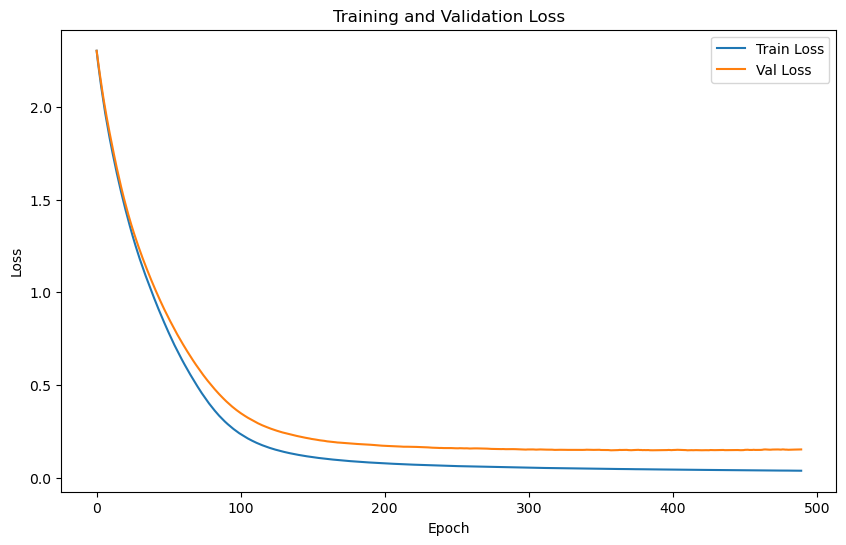

In [59]:
sclsdl_mlp_input_dim = sclsdl_mlp_train_reps.shape[1]
sclsdl_mlp_num_classes = len(torch.unique(sclsdl_mlp_train_labels_torch))
sclsdl_mlp_model = MLPClassifier(sclsdl_mlp_input_dim, sclsdl_mlp_num_classes).to(device)

sclsdl_mlp_criterion = nn.CrossEntropyLoss()
sclsdl_mlp_optimizer = optim.Adam(sclsdl_mlp_model.parameters(), lr=1e-4)

sclsdl_mlp_num_epochs = 1000
sclsdl_mlp_patience = 100

sclsdl_mlp_train_losses = []
sclsdl_mlp_val_losses = []

sclsdl_mlp_best_val_loss = float('inf')
sclsdl_mlp_epochs_without_improvement = 0

for sclsdl_mlp_epoch in range(sclsdl_mlp_num_epochs):
    # Training
    sclsdl_mlp_model.train()
    sclsdl_mlp_train_running_loss = 0.0
    
    for sclsdl_mlp_embeddings_batch, sclsdl_mlp_labels_batch in sclsdl_mlp_train_loader:
        sclsdl_mlp_embeddings_batch = sclsdl_mlp_embeddings_batch.to(device)
        sclsdl_mlp_labels_batch = sclsdl_mlp_labels_batch.to(device)
        
        sclsdl_mlp_optimizer.zero_grad()
        
        # Forward
        sclsdl_mlp_outputs = sclsdl_mlp_model(sclsdl_mlp_embeddings_batch)
        sclsdl_mlp_loss = sclsdl_mlp_criterion(sclsdl_mlp_outputs, sclsdl_mlp_labels_batch)
        
        # Backward & Update
        sclsdl_mlp_loss.backward()
        sclsdl_mlp_optimizer.step()
        
        sclsdl_mlp_train_running_loss += sclsdl_mlp_loss.item() * sclsdl_mlp_embeddings_batch.size(0)
    
    sclsdl_mlp_epoch_train_loss = sclsdl_mlp_train_running_loss / len(sclsdl_mlp_train_loader.dataset)
    sclsdl_mlp_train_losses.append(sclsdl_mlp_epoch_train_loss)

    # Validation
    sclsdl_mlp_model.eval()
    sclsdl_mlp_val_running_loss = 0.0
    
    with torch.no_grad():
        for sclsdl_mlp_val_embeddings_batch, sclsdl_mlp_val_labels_batch in sclsdl_mlp_val_loader:
            sclsdl_mlp_val_embeddings_batch = sclsdl_mlp_val_embeddings_batch.to(device)
            sclsdl_mlp_val_labels_batch = sclsdl_mlp_val_labels_batch.to(device)

            sclsdl_mlp_val_outputs = sclsdl_mlp_model(sclsdl_mlp_val_embeddings_batch)
            sclsdl_mlp_val_loss = sclsdl_mlp_criterion(sclsdl_mlp_val_outputs, sclsdl_mlp_val_labels_batch)

            sclsdl_mlp_val_running_loss += sclsdl_mlp_val_loss.item() * sclsdl_mlp_val_embeddings_batch.size(0)

    sclsdl_mlp_epoch_val_loss = sclsdl_mlp_val_running_loss / len(sclsdl_mlp_val_loader.dataset)
    sclsdl_mlp_val_losses.append(sclsdl_mlp_epoch_val_loss)

    print(f"[Epoch {sclsdl_mlp_epoch+1}/{sclsdl_mlp_num_epochs}] "
          f"Train Loss: {sclsdl_mlp_epoch_train_loss:.4f}  |  "
          f"Val Loss: {sclsdl_mlp_epoch_val_loss:.4f}")

    # Early stopping
    if sclsdl_mlp_epoch_val_loss < sclsdl_mlp_best_val_loss:
        print(f"Validation loss improved from {sclsdl_mlp_best_val_loss:.4f} to {sclsdl_mlp_epoch_val_loss:.4f}.")
        sclsdl_mlp_best_val_loss = sclsdl_mlp_epoch_val_loss
        sclsdl_mlp_epochs_without_improvement = 0


    else:
        sclsdl_mlp_epochs_without_improvement += 1
        print(f"!! Validation loss did NOT improve !! "
              f"Patience: {sclsdl_mlp_epochs_without_improvement}/{sclsdl_mlp_patience}")
        
        if sclsdl_mlp_epochs_without_improvement >= sclsdl_mlp_patience:
            print(f"!! Early stopping triggered at epoch {sclsdl_mlp_epoch+1} !!\n"
                  f"No improvement for {sclsdl_mlp_patience} epochs.")
            break

plt.figure(figsize=(10,6))
plt.plot(sclsdl_mlp_train_losses, label='Train Loss')
plt.plot(sclsdl_mlp_val_losses,   label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


Saved SCL_SDL+MLP predictions and true labels to model_predictions
Test Loss: 0.1442 | Test Accuracy: 96.04%


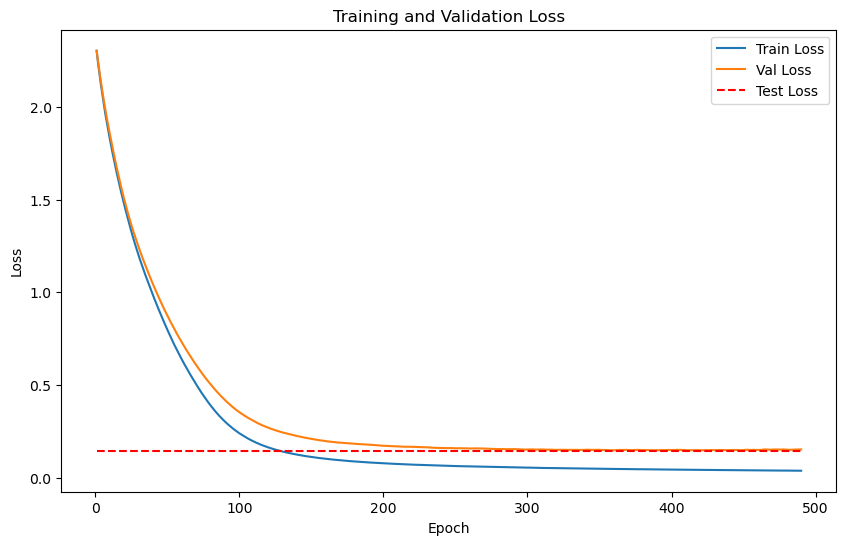

In [60]:
sclsdl_mlp_model.eval()

sclsdl_mlp_test_running_loss = 0.0
sclsdl_mlp_test_correct = 0
sclsdl_mlp_all_predictions = []
sclsdl_mlp_all_true_labels = []

with torch.no_grad():
    for sclsdl_mlp_test_embeddings_batch, sclsdl_mlp_test_labels_batch in sclsdl_mlp_test_loader:
        sclsdl_mlp_test_embeddings_batch = sclsdl_mlp_test_embeddings_batch.to(device)
        sclsdl_mlp_test_labels_batch = sclsdl_mlp_test_labels_batch.to(device)

        # Forward pass
        sclsdl_mlp_test_outputs = sclsdl_mlp_model(sclsdl_mlp_test_embeddings_batch)
        
        # Compute loss
        sclsdl_mlp_test_loss_batch = sclsdl_mlp_criterion(sclsdl_mlp_test_outputs, sclsdl_mlp_test_labels_batch)
        sclsdl_mlp_test_running_loss += sclsdl_mlp_test_loss_batch.item() * sclsdl_mlp_test_embeddings_batch.size(0)

        _, sclsdl_mlp_test_predicted = torch.max(sclsdl_mlp_test_outputs, dim=1)
        sclsdl_mlp_test_correct += (sclsdl_mlp_test_predicted == sclsdl_mlp_test_labels_batch).sum().item()

        sclsdl_mlp_all_predictions.extend(sclsdl_mlp_test_predicted.cpu().numpy())
        sclsdl_mlp_all_true_labels.extend(sclsdl_mlp_test_labels_batch.cpu().numpy())

np.save(os.path.join(predictions_dir, 'sclsdl_mlp_predictions.npy'), np.array(sclsdl_mlp_all_predictions))
np.save(os.path.join(predictions_dir, 'sclsdl_mlp_true_labels.npy'), np.array(sclsdl_mlp_all_true_labels))
print(f"Saved SCL_SDL+MLP predictions and true labels to {predictions_dir}")

sclsdl_mlp_epoch_test_loss = sclsdl_mlp_test_running_loss / len(sclsdl_mlp_test_loader.dataset)
sclsdl_mlp_test_accuracy = sclsdl_mlp_test_correct / len(sclsdl_mlp_test_loader.dataset)

sclsdl_mlp_test_accuracy_pct = sclsdl_mlp_test_accuracy * 100.0

print(f"Test Loss: {sclsdl_mlp_epoch_test_loss:.4f} | Test Accuracy: {sclsdl_mlp_test_accuracy_pct:.2f}%")

sclsdl_mlp_num_epochs_run = len(sclsdl_mlp_train_losses)

plt.figure(figsize=(10,6))

plt.plot(range(1, sclsdl_mlp_num_epochs_run + 1),
         sclsdl_mlp_train_losses,
         label='Train Loss')
plt.plot(range(1, sclsdl_mlp_num_epochs_run + 1),
         sclsdl_mlp_val_losses,
         label='Val Loss')

plt.plot(range(1, sclsdl_mlp_num_epochs_run + 1),
         [sclsdl_mlp_epoch_test_loss]*sclsdl_mlp_num_epochs_run,
         'r--',
         label='Test Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


## Experimental Results and Confusion Matrices

In [61]:
def plot_conf_matrix(model_name, class_names = None, cm_save_dir='confusion_matrices'):
    os.makedirs(cm_save_dir, exist_ok = True)

    #loading predictions and true labels
    predictions_path = os.path.join(predictions_dir, f'{model_name}_predictions.npy')
    true_labels_path = os.path.join(predictions_dir, f'{model_name}_true_labels.npy')

    if not os.path.exists(predictions_path) or not os.path.exists(true_labels_path):
        print(f"Error: Files not found for model {model_name}")
        return
    
    cm_predictions = np.load(predictions_path)
    cm_true_labels = np.load(true_labels_path)

    conf_matrix = confusion_matrix(cm_true_labels, cm_predictions)
    plt.figure(figsize=(8,8))

    conf_matrix_normalised = conf_matrix.astype('float') / conf_matrix.sum(axis = 1)[:, np.newaxis]
    sns.heatmap(conf_matrix_normalised, annot=conf_matrix, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)

    plt.title(f"{model_name.upper()} Confusion Matrix", fontsize=16)
    plt.ylabel('True Label', fontsize=12)
    plt.xlabel('Predicted Label', fontsize=12)
    plt.tight_layout()

    cm_save_path = os.path.join(cm_save_dir, f'{model_name}_confusion_matrix.png')
    plt.savefig(cm_save_path, dpi=300, bbox_inches='tight')
    print(f"Saved confusion matrix to: {cm_save_path}")

    plt.show()

    accuracy = np.trace(conf_matrix) / np.sum(conf_matrix)
    print(f"Classification Accuracy: {accuracy*100:.2f}%")

Saving confusion matrices to: confusion_matrices


Saved confusion matrix to: confusion_matrices\e2e_cnn_confusion_matrix.png


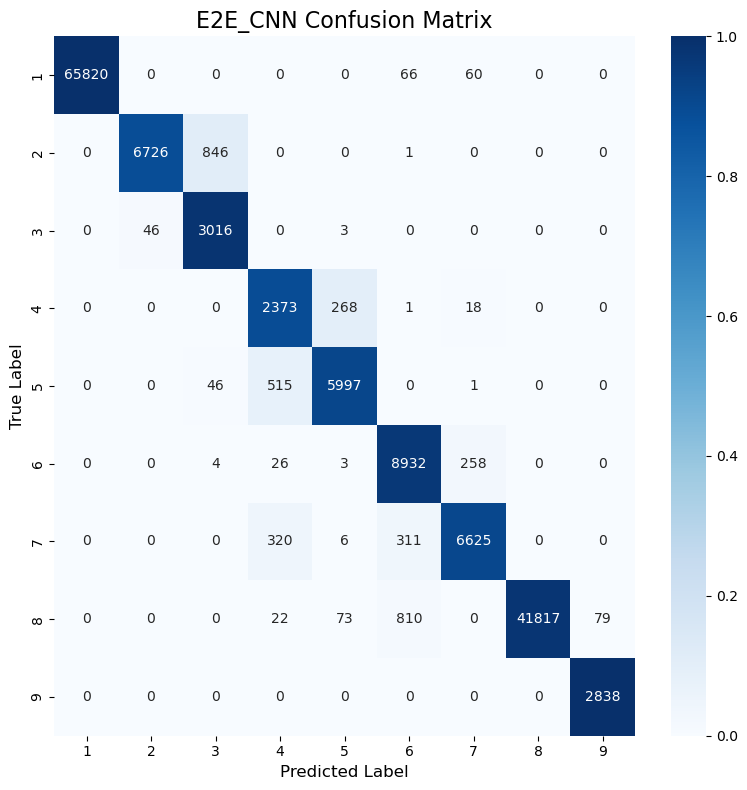

Classification Accuracy: 97.44%


Saved confusion matrix to: confusion_matrices\cae_lrm_confusion_matrix.png


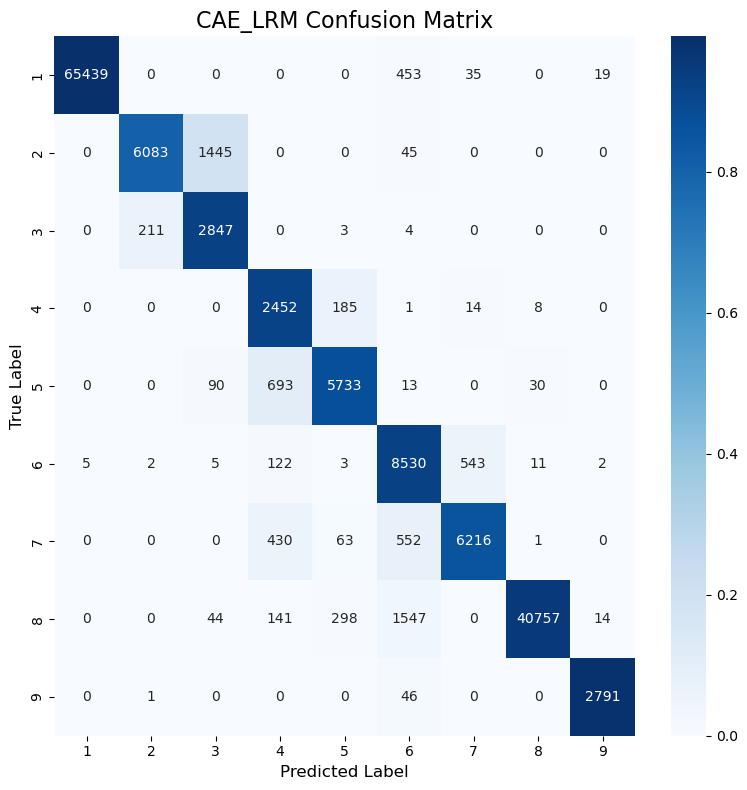

Classification Accuracy: 95.21%


Saved confusion matrix to: confusion_matrices\cae_mlp_confusion_matrix.png


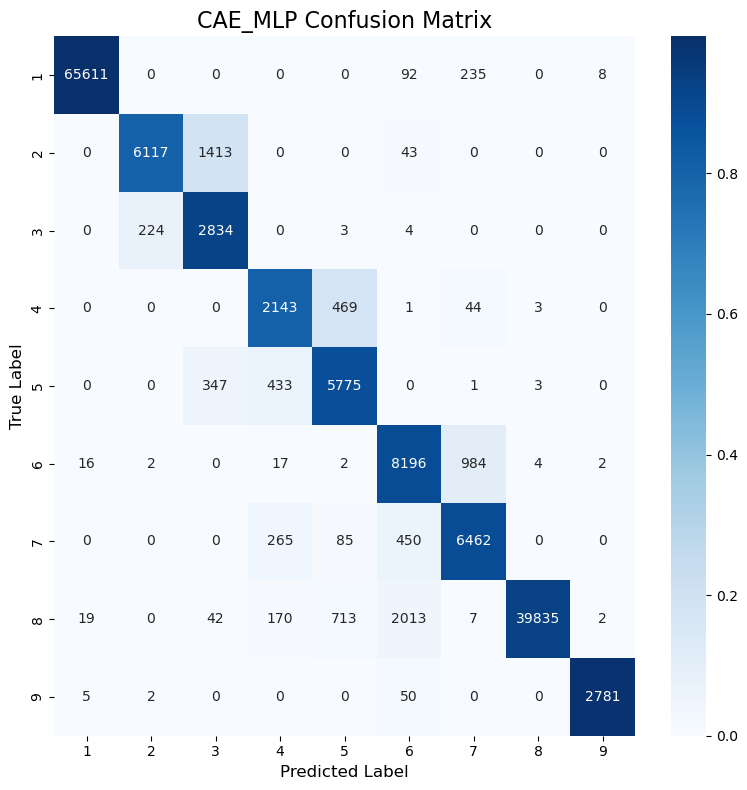

Classification Accuracy: 94.47%


Saved confusion matrix to: confusion_matrices\tscl_lrm_confusion_matrix.png


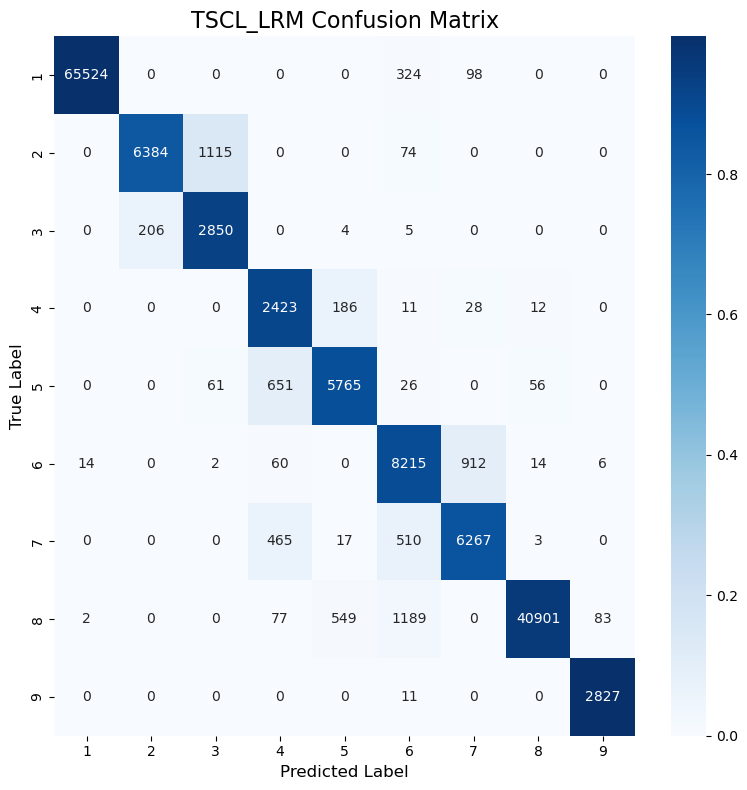

Classification Accuracy: 95.42%


Saved confusion matrix to: confusion_matrices\tscl_mlp_confusion_matrix.png


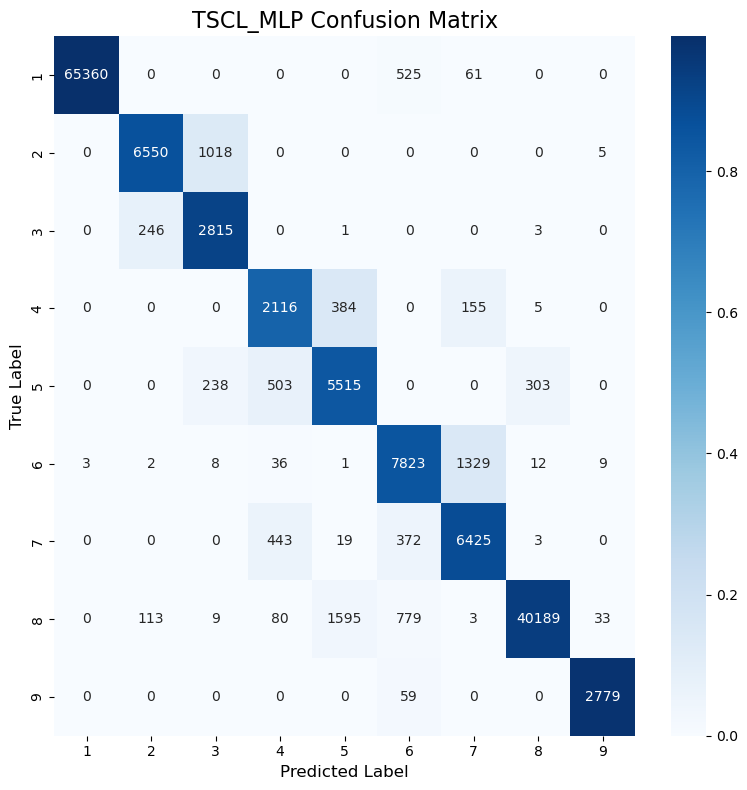

Classification Accuracy: 94.35%


Saved confusion matrix to: confusion_matrices\sclsdl_lrm_confusion_matrix.png


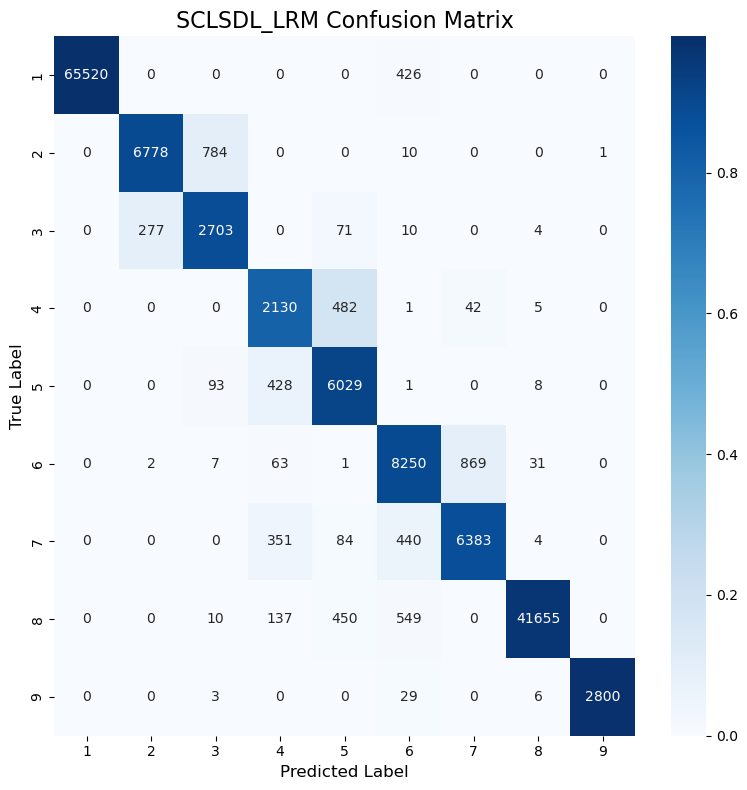

Classification Accuracy: 96.16%


Saved confusion matrix to: confusion_matrices\sclsdl_mlp_confusion_matrix.png


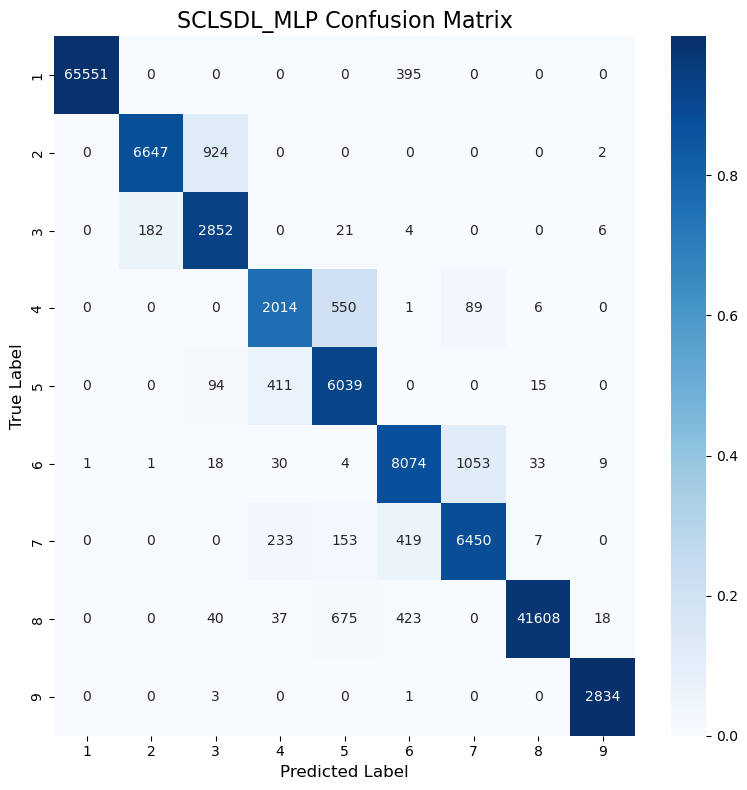

Classification Accuracy: 96.04%


In [62]:
class_names = [str(i+1) for i in range(len(np.unique(y_labels)))]
confusion_matrices_dir = 'confusion_matrices'
os.makedirs(confusion_matrices_dir, exist_ok=True)
print(f"Saving confusion matrices to: {confusion_matrices_dir}")
plot_conf_matrix('e2e_cnn', class_names, confusion_matrices_dir)
plot_conf_matrix('cae_lrm', class_names, confusion_matrices_dir)
plot_conf_matrix('cae_mlp', class_names, confusion_matrices_dir)
plot_conf_matrix('tscl_lrm', class_names, confusion_matrices_dir)
plot_conf_matrix('tscl_mlp', class_names, confusion_matrices_dir)
plot_conf_matrix('sclsdl_lrm', class_names, confusion_matrices_dir)
plot_conf_matrix('sclsdl_mlp', class_names, confusion_matrices_dir)

In [63]:
final_results_df = pd.DataFrame({
    "Model": ["E2E CNN", "LRM (CAE)", "MLP (CAE)", "TSCL LRM", "TSCL MLP", "SCL_SDL LRM", "SCL_SDL MLP"],
    "Test_Accuracy": [test_accuracy, lrm_test_accuracy * 100, cae_mlp_test_accuracy_pct, 
                      tscl_lrm_test_accuracy * 100, tscl_mlp_test_accuracy_pct, 
                      sclsdl_lrm_test_accuracy * 100, sclsdl_mlp_test_accuracy_pct]
})

pd.options.display.float_format = '{:.2f}'.format

print(final_results_df)
print(f"\nIn Desc. Order (Test Accu)\n{final_results_df.sort_values('Test_Accuracy', ascending=False)}")

         Model  Test_Accuracy
0      E2E CNN          97.44
1    LRM (CAE)          95.21
2    MLP (CAE)          94.47
3     TSCL LRM          95.42
4     TSCL MLP          94.35
5  SCL_SDL LRM          96.16
6  SCL_SDL MLP          96.04

In Desc. Order (Test Accu)
         Model  Test_Accuracy
0      E2E CNN          97.44
5  SCL_SDL LRM          96.16
6  SCL_SDL MLP          96.04
3     TSCL LRM          95.42
1    LRM (CAE)          95.21
2    MLP (CAE)          94.47
4     TSCL MLP          94.35
